In [1]:
import pickle
import pandas as pd
import numpy as np
import torch
import transformers
import bitsandbytes as bnb
import networkx as nx
import random

random_state = 1

random.seed(random_state)

In [2]:
def euclid(list1, list2):
    return sum((p-q)**2 for p, q in zip(list1, list2)) ** .5

In [3]:
with open('df_policies_embeddings.pkl', 'rb') as f:
    df = pickle.load(f)
df

name                                               text Level  \
0        Category                                ACCOUNT INFORMATION  None   
1     SubCategory                                          your name  None   
2     SubCategory                                      email address  None   
3     SubCategory                                           password  None   
4     SubCategory                                      date of birth  None   
...           ...                                                ...   ...   
4113     Category                           your contact information  None   
4114  SubCategory                     information from third parties  None   
4115          cat  Or, if you provide us with your contact inform...     2   
4116          cat            Other Information, With Your Permission     2   
4117          cat  Additionally, there may be instances when you ...     2   

     document_name    Type                                         embeddings  
0       Fitbit.txt  Closed  [1.376953125, -1.1220703125, 1.982421875, 1.12...  
1       Fitbit.txt  Closed  [0.276123046875, 0.7734375, 0.53076171875, 1.2...  
2       Fitbit.txt  Closed  [1.5146484375, -0.07098388671875, 0.3347167968...  
3       Fitbit.txt  Closed  [0.436279296875, -0.021484375, 0.6201171875, -...  
4       Fitbit.txt  Closed  [0.5732421875, -1.681640625, -0.114990234375, ...  
...            ...     ...                                                ...  
4113  Snapchat.txt  Closed  [1.708984375, -0.94384765625, 0.984375, 0.6762...  
4114  Snapchat.txt    Open  [0.6962890625, -1.0859375, 0.611328125, 0.6069...  
4115  Snapchat.txt    None  [0.485107421875, -2.080078125, 0.92724609375, ...  
4116  Snapchat.txt    None  [0.6630859375, -1.1650390625, 0.44580078125, 1...  
4117  Snapchat.txt    None  [0.82421875, -0.7568359375, -0.057342529296875...  

[4118 rows x 6 columns]

In [4]:
validation_set = ['X_Twitter.txt', 'LinkedIn.txt', 'Zoom.txt', 'Fitbit.txt', 'Western Union.txt', 'Ubisoft.txt']
test_set =  ['Yahoo.txt', 'TikTok.txt', 'MySugr.txt', 'Deliveroo.txt', 'Paypal.txt', 'AdobePhotoshop.txt']
nontrain_set = validation_set + test_set
nontrain_set

['X_Twitter.txt',
 'LinkedIn.txt',
 'Zoom.txt',
 'Fitbit.txt',
 'Western Union.txt',
 'Ubisoft.txt',
 'Yahoo.txt',
 'TikTok.txt',
 'MySugr.txt',
 'Deliveroo.txt',
 'Paypal.txt',
 'AdobePhotoshop.txt']

In [5]:
df_train = df[~df.document_name.isin(nontrain_set)]
df_train = df_train.dropna(subset = ['Level'])
df_train

name                                               text Level  \
170   cat  Personal Identifiers\ta real name, birth date,...     1   
177   cat   Race, Color, Age, National origin, or Disability     2   
178   cat  Characteristics of protected classifications u...     2   
183   cat    Biometric information\tPhotos, video, and voice     2   
195   cat  Internet or other electronic network activity ...     2   
...   ...                                                ...   ...   
4110  cat  The last category of data we collect is inform...     2   
4112  cat  This includes linked third-party service data ...     2   
4115  cat  Or, if you provide us with your contact inform...     2   
4116  cat            Other Information, With Your Permission     2   
4117  cat  Additionally, there may be instances when you ...     2   

     document_name  Type                                         embeddings  
170     Kardia.txt  None  [-0.73779296875, -0.94873046875, 2.50390625, 0...  
177     Kardia.txt  None  [-0.06195068359375, -0.273681640625, -0.146484...  
178     Kardia.txt  None  [0.59326171875, -0.6298828125, -0.58984375, 1....  
183     Kardia.txt  None  [-0.38134765625, -1.7529296875, 1.4677734375, ...  
195     Kardia.txt  None  [-0.671875, -0.97802734375, 0.314208984375, 1....  
...            ...   ...                                                ...  
4110  Snapchat.txt  None  [0.80078125, -1.2626953125, 0.30419921875, 0.0...  
4112  Snapchat.txt  None  [-0.57177734375, -1.00390625, 0.8095703125, -0...  
4115  Snapchat.txt  None  [0.485107421875, -2.080078125, 0.92724609375, ...  
4116  Snapchat.txt  None  [0.6630859375, -1.1650390625, 0.44580078125, 1...  
4117  Snapchat.txt  None  [0.82421875, -0.7568359375, -0.057342529296875...  

[419 rows x 6 columns]

In [6]:
df_train_lv1 = df_train[df_train['Level'] == '1']
df_train_lv1

name                                               text Level  \
170   cat  Personal Identifiers\ta real name, birth date,...     1   
200   cat  Geolocation data\tPhysical location or movemen...     1   
222   cat  When you contact AliveCor directly, such as wh...     1   
223   cat                               When You Contact Us.     1   
241   cat  If you choose to buy a Product on our Site, we...     1   
...   ...                                                ...   ...   
3713  cat  For example, we create a permanent URL to your...     1   
3996  cat  We may use your information, including your fu...     1   
4086  cat  To do this, we ask you to provide us with acco...     1   
4088  cat  If you use our commerce products to buy someth...     1   
4094  cat  Lastly, when you contact Support (content and ...     1   

     document_name  Type                                         embeddings  
170     Kardia.txt  None  [-0.73779296875, -0.94873046875, 2.50390625, 0...  
200     Kardia.txt  None  [-0.74658203125, -0.58056640625, 1.771484375, ...  
222     Kardia.txt  None  [1.3701171875, -0.783203125, 0.92431640625, -0...  
223     Kardia.txt  None  [0.00887298583984375, -0.51806640625, 0.136352...  
241        Ava.txt  None  [1.1845703125, -1.4677734375, 2.27734375, 0.14...  
...            ...   ...                                                ...  
3713   Groupon.txt  None  [0.69921875, -1.24609375, 0.68017578125, 1.434...  
3996    Airbnb.txt  None  [0.94873046875, -1.134765625, 0.73291015625, -...  
4086  Snapchat.txt  None  [0.5029296875, -1.318359375, 1.25390625, -0.39...  
4088  Snapchat.txt  None  [0.88720703125, -1.203125, 1.712890625, 0.3522...  
4094  Snapchat.txt  None  [1.0888671875, -0.52783203125, 0.7236328125, -...  

[102 rows x 6 columns]

In [7]:
df_train_lv2 = df_train[df_train['Level'] == '2']
df_train_lv2

name                                               text Level  \
177   cat   Race, Color, Age, National origin, or Disability     2   
178   cat  Characteristics of protected classifications u...     2   
183   cat    Biometric information\tPhotos, video, and voice     2   
195   cat  Internet or other electronic network activity ...     2   
205   cat  User Generated Content\tYou may use your mobil...     2   
...   ...                                                ...   ...   
4110  cat  The last category of data we collect is inform...     2   
4112  cat  This includes linked third-party service data ...     2   
4115  cat  Or, if you provide us with your contact inform...     2   
4116  cat            Other Information, With Your Permission     2   
4117  cat  Additionally, there may be instances when you ...     2   

     document_name  Type                                         embeddings  
177     Kardia.txt  None  [-0.06195068359375, -0.273681640625, -0.146484...  
178     Kardia.txt  None  [0.59326171875, -0.6298828125, -0.58984375, 1....  
183     Kardia.txt  None  [-0.38134765625, -1.7529296875, 1.4677734375, ...  
195     Kardia.txt  None  [-0.671875, -0.97802734375, 0.314208984375, 1....  
205     Kardia.txt  None  [-0.335693359375, -1.3212890625, 1.5400390625,...  
...            ...   ...                                                ...  
4110  Snapchat.txt  None  [0.80078125, -1.2626953125, 0.30419921875, 0.0...  
4112  Snapchat.txt  None  [-0.57177734375, -1.00390625, 0.8095703125, -0...  
4115  Snapchat.txt  None  [0.485107421875, -2.080078125, 0.92724609375, ...  
4116  Snapchat.txt  None  [0.6630859375, -1.1650390625, 0.44580078125, 1...  
4117  Snapchat.txt  None  [0.82421875, -0.7568359375, -0.057342529296875...  

[317 rows x 6 columns]

In [8]:
df_test = df[df.document_name.isin(test_set)]
df_test = df_test.dropna(subset = ['Level'])
df_test

name                                               text Level  \
492   cat  We collect information that you provide when y...     1   
496   cat                                      User Content.     2   
498   cat  We collect the content you create or publish t...     2   
508   cat  We also collect content (such as text, images,...     2   
509   cat  In addition, we collect location information (...     1   
...   ...                                                ...   ...   
3564  cat          Information about your imported contacts.     2   
3575  cat  Information you disclose when you respond to s...     1   
3577  cat  This may include information about others if y...     1   
3586  cat  For example, if you choose to participate in O...     2   
3595  cat  This optional data is collected and processed ...     2   

     document_name  Type                                         embeddings  
492     TikTok.txt  None  [1.44921875, -0.89892578125, 1.8203125, 0.1143...  
496     TikTok.txt  None  [0.123291015625, -1.8173828125, 1.369140625, 1...  
498     TikTok.txt  None  [-0.5400390625, -1.1865234375, 2.10546875, 0.4...  
508     TikTok.txt  None  [-0.35302734375, -1.4091796875, 1.4365234375, ...  
509     TikTok.txt  None  [0.58251953125, -0.2344970703125, 2.423828125,...  
...            ...   ...                                                ...  
3564    Paypal.txt  None  [0.5029296875, -1.8271484375, 0.68701171875, 1...  
3575    Paypal.txt  None  [0.62158203125, -2.248046875, 1.111328125, 0.2...  
3577    Paypal.txt  None  [0.7802734375, -1.66796875, -0.4091796875, 0.7...  
3586    Paypal.txt  None  [1.154296875, -0.71728515625, -0.791015625, 0....  
3595    MySugr.txt  None  [1.1552734375, -1.6357421875, 1.333984375, -0....  

[160 rows x 6 columns]

In [ ]:
df_test_lv1 = df_test[df_test['Level'] == '1']
df_test_lv1

In [9]:
device = torch.device('cuda')
model_id = "meta-llama/Meta-Llama-3.1-8B-Instruct"

In [10]:
pipeline = transformers.pipeline(
    "text-generation",
    model=model_id,
    model_kwargs={"torch_dtype": torch.bfloat16,
                  "quantization_config": {"load_in_4bit": True}},
    device_map="cuda:0"
)

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Device set to use cuda:0


In [11]:
lv1_training_graph = pickle.load(open('lv1graph_Level_.01.pickle', 'rb'))
lv2_training_graph = pickle.load(open('lv2graph_Level_.01.pickle', 'rb'))


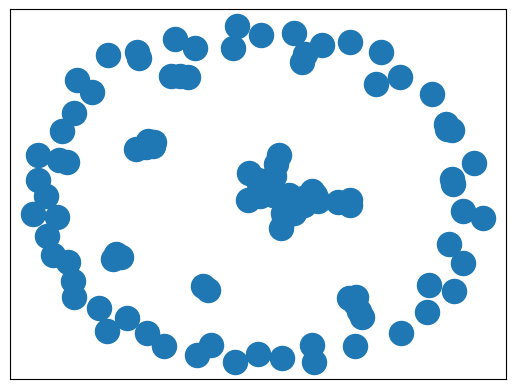

In [12]:
nx.draw_networkx(lv1_training_graph, with_labels = False)

In [13]:
average_degs = sum([lv1_training_graph.degree[i] for i in lv1_training_graph])/len(lv1_training_graph), sum([lv2_training_graph.degree[i] for i in lv2_training_graph])/len(lv2_training_graph)
average_degs

(1.0588235294117647, 3.173501577287066)

In [14]:
def test(template, nexamples):

    count = 0
    lv1TP = 0
    lv1FN = 0
    lv1FP = 0
    lv2TP = 0
    lv2FN = 0
    lv2FP = 0

    for i in range(len(df_test)):

        lv1_subgraph_radius = 69.64              #SET MANUALLY, on the training set, on average these yield a subgraph of size (N*25)**0.5
        lv2_subgraph_radius = 63.42

        query = 'Text: '+ df_test.iloc[i]['text']+'\n'+'label = '

        lv1_test_graph = lv1_training_graph.copy()     
        lv2_test_graph = lv2_training_graph.copy()


        for j in range(len(lv1_training_graph)):
            if euclid(df_train_lv1.iloc[j]['embeddings'], df_test.iloc[i]['embeddings']) > lv1_subgraph_radius:
                lv1_test_graph.remove_node(j)


        while(len(lv1_test_graph) < (nexamples+1)//2):     #If the subgraph doesn't have enough nodes, increment the radius
            lv1_subgraph_radius *= 1.1
            lv1_test_graph = lv1_training_graph.copy()
            for j in range(len(lv1_training_graph)):
                if euclid(df_train_lv1.iloc[j]['embeddings'], df_test.iloc[i]['embeddings']) > lv1_subgraph_radius:
                    lv1_test_graph.remove_node(j)
            #print(subgraph_radius)

        for j in range(len(lv2_training_graph)):
            if euclid(df_train_lv2.iloc[j]['embeddings'], df_test.iloc[i]['embeddings']) > lv2_subgraph_radius:
                lv2_test_graph.remove_node(j)


        while(len(lv2_test_graph) < (nexamples+1)//2):     #If the subgraph doesn't have enough nodes, increment the radius
            lv2_subgraph_radius *= 1.1
            lv2_test_graph = lv2_training_graph.copy()
            for j in range(len(lv2_training_graph)):
                if euclid(df_train_lv2.iloc[j]['embeddings'], df_test.iloc[i]['embeddings']) > lv2_subgraph_radius:
                    lv2_test_graph.remove_node(j)
            #print(subgraph_radius)






        
        lv1_selected_nodes = []
        lv2_selected_nodes = []
        lv1_communities = nx.community.louvain_communities(lv1_test_graph, seed = random_state)
        lv1_sorted_communities = sorted(lv1_communities, key = lambda x: len(x), reverse = True)
        lv2_communities = nx.community.louvain_communities(lv2_test_graph, seed = random_state)
        lv2_sorted_communities = sorted(lv2_communities, key = lambda x: len(x), reverse = True)
        #print(sorted_communities)
        #print(len(sorted_communities))



        if len(lv1_sorted_communities) >= (nexamples+1)//2:    #If there are enough communities:
            for l in range((nexamples+1)//2):
                lv1_subgraph = lv1_test_graph.subgraph(lv1_sorted_communities[l])
                lv1_selected_nodes.append(sorted(nx.pagerank(lv1_subgraph).items(), key=lambda kv: kv[1], reverse = True )[0][0])
                #print(sorted(nx.pagerank(subgraph).items(), key=lambda kv: kv[1], reverse = True ))
        else:                                       #If there are less communities than nodes to choose:
            numberofelements = 2
            while len(lv1_selected_nodes) < (nexamples+1) //2:
                lv1_selected_nodes = []
                for element in lv1_sorted_communities:
                    lv1_subgraph = lv1_test_graph.subgraph(element)
                    lv1_selected_nodes += [foo[0] for foo in sorted(nx.pagerank(lv1_subgraph).items(), key=lambda kv: kv[1], reverse = True )][:numberofelements]
                    numberofelements += 1

        if len(lv2_sorted_communities) >= (nexamples+1)//2:    #If there are enough communities:
            for l in range((nexamples+1)//2):
                lv2_subgraph = lv2_test_graph.subgraph(lv2_sorted_communities[l])
                lv2_selected_nodes.append(sorted(nx.pagerank(lv2_subgraph).items(), key=lambda kv: kv[1], reverse = True )[0][0])
                #print(sorted(nx.pagerank(subgraph).items(), key=lambda kv: kv[1], reverse = True ))
        else:                                       #If there are less communities than nodes to choose:
            numberofelements = 2
            while len(lv2_selected_nodes) < (nexamples+1) //2:
                lv2_selected_nodes = []
                for element in lv2_sorted_communities:
                    lv2_subgraph = lv2_test_graph.subgraph(element)
                    lv2_selected_nodes += [foo[0] for foo in sorted(nx.pagerank(lv2_subgraph).items(), key=lambda kv: kv[1], reverse = True )][:numberofelements]
                    numberofelements += 1
            #print(sorted(nx.pagerank(subgraph).items(), key=lambda kv: kv[1], reverse = True ))
        
        lv1_selected_nodes = lv1_selected_nodes[:(nexamples+1)//2]     #The final chosen demonstrations
        lv2_selected_nodes = lv2_selected_nodes[:(nexamples+1)//2]
        print('Selected Nodes:', lv1_selected_nodes)

        examples_text = []
        
        for el in list(range((nexamples+1)//2)):
            examples_text.append('Text: '+ df_train_lv1.iloc[lv1_selected_nodes[el]]['text'] + '\n' + 'label = '+ 'sufficiently informative'+'\n\n')
            examples_text.append('Text: '+ df_train_lv2.iloc[lv2_selected_nodes[el]]['text'] + '\n' + 'label = '+ 'insufficiently informative'+'\n\n')

        random.shuffle(examples_text)

        examples_text = examples_text[:nexamples]

        text_examples = ''      #Building text examples

        for el in examples_text:
            text_examples += el
        
        print('query:\n'+ query,'\n')
        print('retrieved examples:\n\n'+ text_examples,'\n\n')

        messages = [{'role': 'system', 'content': template},{"role": "user", "content": text_examples},{"role": "user", "content": query}]

        outputs = pipeline(
            messages,
            max_new_tokens=10,
            do_sample = False
        )
        final_output = outputs[0]['generated_text'][-1]['content']
        print('LLM output:', final_output)
        if df_test.iloc[i]['Level'] == '1':
            gt = 'sufficiently informative'
        else:
            gt = 'insufficiently informative'
        print('ground truth:', gt)
        print(200*'-')

        if 'insufficiently' in final_output and df_test.iloc[i]['Level'] == '2':
            lv2TP += 1
        if 'insufficiently' in final_output and df_test.iloc[i]['Level'] == '1':
            lv2FP += 1
        if 'insufficiently' not in final_output and df_test.iloc[i]['Level'] == '2':
            lv2FN += 1
        
        if  final_output == 'sufficiently informative' and df_test.iloc[i]['Level'] == '1':
            lv1TP += 1
        if final_output == 'sufficiently informative' and df_test.iloc[i]['Level'] == '2':
            lv1FP += 1
        if final_output != 'sufficiently informative' and df_test.iloc[i]['Level'] == '1':
            lv1FN += 1
        
    lv1PREC = lv1TP/(lv1TP+lv1FP)
    lv1REC = lv1TP/(lv1TP+lv1FN)
    lv2PREC = lv2TP/(lv2TP+lv2FP)
    lv2REC = lv2TP/(lv2TP+lv2FN)

    lv1F1 = 2/((1/lv1PREC)+(1/lv1REC))
    lv2F1 = 2/((1/lv2PREC)+(1/lv2REC))

    print('lv1 F1:', lv1F1)
    print('lv2 F1:', lv2F1)

    print('macro F1:', (lv1F1+lv2F1)/2 )
            


In [15]:
template = '''You will be given as input a sentence from a privacy policy that contains information about what data the service collects about the user. You have to classify the sentence into one of the following classes: "sufficiently informative" or "insufficiently informative".

In doing so, consider that GDPR, and the EDPB's Guidelines, contain a certain inherent tension, namely that between requiring that the information is provided in as easy a way to understand as possible (comprehensibility) and that it is concrete and definitely (comprehensiveness).
Sometimes, using open-ended qualifiers like “for example” or “such as” might actually facilitate understanding by the data subject, especially when terms not often used in the natural language (e.g. “device information” or “geolocation information”) are concerned. For this reason, we differentiate between:
*	Abstract terms (e.g. usage information) vs. concrete terms (e.g. geolocation information)
*	Open-ended qualifications (“for example”, “such as”, etc.) vs. closed-catalogues (“meaning”, “understood as” ).

A sentence containing an abstract term, UNLESS followed by a comprehensive enumeration, should be judged as "insufficiently informative".
A sentence containing a concrete term, even if followed by an open-ended qualifier, should be judged as "sufficiently informative".

Avoid explanations. Only reply with "insufficiently informative" or "sufficiently informative".

Here are some examples:'''

In [16]:
test(template, 5)

C:\Users\alfio\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\transformers\generation\configuration_utils.py:628: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.6` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
C:\Users\alfio\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\transformers\generation\configuration_utils.py:633: UserWarning: `do_sample` is set to `False`. However, `top_p` is set to `0.9` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_p`.
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [12, 41, 18]
query:
Text: We collect information that you provide when you set up an account, such as your date of birth, username, email address and/or telephone number, and password.
label =  

retrieved examples:

Text: We collect, and associate with your account, the information you provide to us when you do things such as sign up for your account, upgrade to a paid plan, and set up two-factor authentication (like your name, email address, phone number, payment info, and physical address).
label = sufficiently informative

Text: Such as when you fill in a form, add information to your account, respond to surveys, post to community forums, participate in promotions, communicate with Airbnb Support and other Members, import or manually enter address book contacts, provide your address and/or geolocation, or share your experience with us.
label = insufficiently informative

Text: We will collect the following personal data when you interact with the Site for the reason

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


LLM output: sufficiently informative
ground truth: insufficiently informative
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Selected Nodes: [12, 41, 18]
query:
Text: We collect the content you create or publish through the Platform, such as photographs, videos, audio recordings, livestreams, comments, hashtags, feedback, reviews, and the associated metadata (such as when, where, and by whom the content was created).
label =  

retrieved examples:

Text: We collect, and associate with your account, the information you provide to us when you do things such as sign up for your account, upgrade to a paid plan, and set up two-factor authentication (like your name, email address, phone number, payment info, and physical address).
label = sufficiently informative

Text: Such as when you fill in a form, add information to your account, respo

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


LLM output: sufficiently informative
ground truth: insufficiently informative
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Selected Nodes: [12, 41, 18]
query:
Text: We also collect content (such as text, images, and video) from your device's clipboard if you choose to copy and paste content to or from the Platform or share content between it and a third party platform.
label =  

retrieved examples:

Text: The last category of data we collect is information about you that we may receive from others, such as other users, our affiliates, and third parties.
label = insufficiently informative

Text: Such as when you fill in a form, add information to your account, respond to surveys, post to community forums, participate in promotions, communicate with Airbnb Support and other Members, import or manually enter address book contacts, pro

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


LLM output: sufficiently informative
ground truth: sufficiently informative
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Selected Nodes: [89, 52, 3]
query:
Text: Direct Messages.
label =  

retrieved examples:

Text: Payment Information.
label = sufficiently informative

Text: Your Stuff.
label = insufficiently informative

Text: Device Information.
label = insufficiently informative

Text: When You Contact Us.
label = sufficiently informative

Text: Contacts.
label = insufficiently informative

 


LLM output: insufficiently informative
ground truth: insufficiently informative
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Selected Nodes: [12, 41, 18]
query:
Text: If you communica

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


LLM output: sufficiently informative
ground truth: insufficiently informative
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Selected Nodes: [12, 41, 10]
query:
Text: We also collect the messages you send or receive through our chat functionality when communicating with merchants who sell goods to you, and your use of virtual assistants when purchasing items through the Platform.
label =  

retrieved examples:

Text: The last category of data we collect is information about you that we may receive from others, such as other users, our affiliates, and third parties.
label = insufficiently informative

Text: Such as when you fill in a form, add information to your account, respond to surveys, post to community forums, participate in promotions, communicate with Airbnb Support and other Members, import or manually enter address book cont

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


LLM output: sufficiently informative
ground truth: insufficiently informative
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Selected Nodes: [89, 52, 3]
query:
Text: Your Contacts.
label =  

retrieved examples:

Text: When You Contact Us.
label = sufficiently informative

Text: Usage Information.
label = insufficiently informative

Text: Information About Others.
label = insufficiently informative

Text: Account details.
label = sufficiently informative

Text: Payment Information.
label = sufficiently informative

 




Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


LLM output: sufficiently informative
ground truth: insufficiently informative
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Selected Nodes: [12, 41, 18]
query:
Text: If you choose to sync your contacts, we will collect information from your device’s phone book such as names, phone numbers, and email addresses, and match that information to users of the Platform.
label =  

retrieved examples:

Text: For example, we receive information from developers about your achievements in their app and share that information with your friends on Meta Quest.
label = insufficiently informative

Text: Examples of such information we automatically collect include Internet Protocol address (“IP Address”), a unique user ID, device and browser types and identifiers, referring and exit page addresses, software and system type, and information about your

You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


LLM output: sufficiently informative
ground truth: insufficiently informative
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Selected Nodes: [12, 41, 18]
query:
Text: If you choose to find other users through your social network contacts, we will collect your public profile information as well as names and profiles of your social network contacts.
label =  

retrieved examples:

Text: Whenever you interact with JET via our Services we collect and process your personal data.
label = insufficiently informative

Text: If you contact our customer care team, we collect the information you give us during the interaction.
label = sufficiently informative

Text: We collect, and associate with your account, the information you provide to us when you do things such as sign up for your account, upgrade to a paid plan, and set up two-factor authe

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


LLM output: sufficiently informative
ground truth: insufficiently informative
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Selected Nodes: [52, 89, 3]
query:
Text: Purchase Information.
label =  

retrieved examples:

Text: Payment Information.
label = sufficiently informative

Text: Other Information.
label = insufficiently informative

Text: When You Contact Us.
label = sufficiently informative

Text: Usage Information.
label = insufficiently informative

Text: Information from our DNA Services.
label = insufficiently informative

 




Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


LLM output: sufficiently informative
ground truth: sufficiently informative
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Selected Nodes: [12, 41, 10]
query:
Text: When you make a purchase or payment on or through the Platform, including when you buy TikTok Coins or purchase goods through our shopping features, we collect information about the purchase or payment transaction, such as payment card information, billing, delivery, and contact information, and items you purchased.
label =  

retrieved examples:

Text: We collect, and associate with your account, the information you provide to us when you do things such as sign up for your account, upgrade to a paid plan, and set up two-factor authentication (like your name, email address, phone number, payment info, and physical address).
label = sufficiently informative

Text: Such as d

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


LLM output: sufficiently informative
ground truth: sufficiently informative
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Selected Nodes: [12, 41, 10]
query:
Text: We collect Information You Provide if you choose to participate in a survey, research, promotion, contest, marketing campaign, or event conducted or sponsored by us.
label =  

retrieved examples:

Text: If you contact our customer care team, we collect the information you give us during the interaction.
label = sufficiently informative

Text: When you subscribe to a paid service or make a purchase directly from us (rather than through a platform such as iOS or Android), you provide us with information related to the purchases you make and our payment processors with information such as your debit or credit card number or other financial information.
label = sufficiently i

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


LLM output: insufficiently informative
ground truth: insufficiently informative
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Selected Nodes: [52, 3, 28]
query:
Text: Information When You Contact Us.
label =  

retrieved examples:

Text: When You Contact Us.
label = sufficiently informative

Text: Information we receive when you use our Service.
label = insufficiently informative

Text: Identity Verification and Payment Information.
label = sufficiently informative

Text: Information We Collect.
label = insufficiently informative

Text: Information from our DNA Services.
label = insufficiently informative

 


LLM output: sufficiently informative
ground truth: sufficiently informative
-------------------------------------------------------------------------------------------------------------------------------------------------------

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


LLM output: sufficiently informative
ground truth: sufficiently informative
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Selected Nodes: [52, 3, 28]
query:
Text: Information From Forms and Features You Use.
label =  

retrieved examples:

Text: Information from our DNA Services.
label = insufficiently informative

Text: Payment Information.
label = sufficiently informative

Text: Information We Collect.
label = insufficiently informative

Text: Information We Generate When You Use Our Services
label = insufficiently informative

Text: Identity Verification and Payment Information.
label = sufficiently informative

 




Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


LLM output: sufficiently informative
ground truth: insufficiently informative
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Selected Nodes: [52, 89, 3]
query:
Text: Location Information.
label =  

retrieved examples:

Text: Usage Information.
label = insufficiently informative

Text: Account details.
label = sufficiently informative

Text: Payment Information.
label = sufficiently informative

Text: Information We Collect.
label = insufficiently informative

Text: When You Contact Us.
label = sufficiently informative

 




Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


LLM output: sufficiently informative
ground truth: sufficiently informative
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Selected Nodes: [52, 89, 3]
query:
Text: Usage Information.
label =  

retrieved examples:

Text: Payment Information.
label = sufficiently informative

Text: Account details.
label = sufficiently informative

Text: Information We Collect.
label = insufficiently informative

Text: Information About Others.
label = insufficiently informative

Text: Information We Generate When You Use Our Services
label = insufficiently informative

 


LLM output: insufficiently informative
ground truth: insufficiently informative
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Se

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


LLM output: sufficiently informative
ground truth: sufficiently informative
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Selected Nodes: [12, 41, 18]
query:
Text: Also, where you enable location services for the TikTok app within your device settings, we collect approximate location information from your device.
label =  

retrieved examples:

Text: Your Use of the Service: While you use our Service, we may collect information based on your interaction with our Website or from the devices or computers you use to access the Website, to enhance your experience of visiting the Website and understand how our Services are being used.
label = insufficiently informative

Text: If you contact our customer care team, we collect the information you give us during the interaction.
label = sufficiently informative

Text: We collect, and associa

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


LLM output: sufficiently informative
ground truth: sufficiently informative
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Selected Nodes: [12, 18, 10]
query:
Text: We collect information about how you engage with the Platform, including information about the content you view, the duration and frequency of your use, your engagement with other users, your search history and your settings.
label =  

retrieved examples:

Text: Location data (riders and order recipients). We collect precise or approximate location information from riders’ and order recipients’ mobile devices if they enable us to do so via their device settings.
label = sufficiently informative

Text: When you subscribe to a paid service or make a purchase directly from us (rather than through a platform such as iOS or Android), you provide us with information related to 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


LLM output: insufficiently informative
ground truth: insufficiently informative
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Selected Nodes: [36, 72, 5]
query:
Text: We detect and collect characteristics and features about the videos, images, and audio recordings that are part of your User Content, for example, by identifying objects and scenery, the existence or location within an image of a face or other body parts; and the text of words spoken in your User Content.
label =  

retrieved examples:

Text: Such as precise or approximate location determined from your IP address, mobile or other device’s GPS, or other information you share with us, depending on your device settings.
label = sufficiently informative

Text: Some examples of the log data are the sync time and date, device battery level, and the IP address used when syncin

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


LLM output: sufficiently informative
ground truth: insufficiently informative
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Selected Nodes: [52, 3, 28]
query:
Text: Inferred Information.
label =  

retrieved examples:

Text: Information About Others.
label = insufficiently informative

Text: Identity Verification and Payment Information.
label = sufficiently informative

Text: Information from Public and Historical Records.
label = insufficiently informative

Text: Usage Information.
label = insufficiently informative

Text: Payment Information.
label = sufficiently informative

 


LLM output: insufficiently informative
ground truth: insufficiently informative
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


LLM output: insufficiently informative
ground truth: insufficiently informative
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Selected Nodes: [79, 41, 18]
query:
Text: Third party platforms provide us with information (such as your email address, user ID, and public profile) when you choose to sign up for or log in to the Platform using sign-in features provided by those third parties.
label =  

retrieved examples:

Text: We collect, and associate with your account, the information you provide to us when you do things such as sign up for your account, upgrade to a paid plan, and set up two-factor authentication (like your name, email address, phone number, payment info, and physical address).
label = sufficiently informative

Text: Whenever you interact with JET via our Services we collect and process your personal data.
label = ins

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


LLM output: sufficiently informative
ground truth: insufficiently informative
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Selected Nodes: [79, 41, 96]
query:
Text: You can add other information to your profile, such as a bio or a profile photo.
label =  

retrieved examples:

Text: If you purchase a subscription or another product, we will need to know your postal address, phone number and payment details to facilitate payment and fulfillment.
label = sufficiently informative

Text: When you complete your profile, you have the option to share your sexual orientation with us.
label = insufficiently informative

Text: Of course, you’ll also provide us with the information you send through or save within our Services.
label = insufficiently informative

Text: This can include information about you, such as when they send us an abuse r

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


LLM output: insufficiently informative
ground truth: insufficiently informative
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Selected Nodes: [79, 41, 18]
query:
Text: This information includes your device model, operating system, keystroke patterns or rhythms, IP address, and system language.
label =  

retrieved examples:

Text: Location data (riders and order recipients). We collect precise or approximate location information from riders’ and order recipients’ mobile devices if they enable us to do so via their device settings.
label = sufficiently informative

Text: If you choose to do so, we will collect and use the information you authorized to share with us via that service, (for example, the email address for a connected Google account), in accordance with this Privacy Policy.
label = sufficiently informative

Text: As a resu

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


LLM output: sufficiently informative
ground truth: insufficiently informative
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Selected Nodes: [12, 18, 10]
query:
Text: Advertisers, measurement and other partners share information with us about you and the actions you have taken outside of the Platform, such as your activities on other websites and apps or in stores, including the products or services you purchased, online or in person.
label =  

retrieved examples:

Text: If you contact our customer care team, we collect the information you give us during the interaction.
label = sufficiently informative

Text: We may also collect demographic data, such as age group and household composition, through user surveys, and use this information to offer Uber products and services that are likely to be of interest to you.
label = insufficien

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


LLM output: insufficiently informative
ground truth: insufficiently informative
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Selected Nodes: [12, 41, 18]
query:
Text: These partners also share information with us, such as mobile identifiers for advertising, hashed email addresses and phone numbers, and cookie identifiers, which we use to help match you and your actions outside of the Platform with your TikTok account.
label =  

retrieved examples:

Text: We collect, and associate with your account, the information you provide to us when you do things such as sign up for your account, upgrade to a paid plan, and set up two-factor authentication (like your name, email address, phone number, payment info, and physical address).
label = sufficiently informative

Text: Your Use of the Service: While you use our Service, we may collect i

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


LLM output: insufficiently informative
ground truth: insufficiently informative
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Selected Nodes: [12, 41, 18]
query:
Text: Some of our advertisers and other partners enable us to collect similar information directly from their website or app by integrating our TikTok Advertiser Tools (such as TikTok Pixel).
label =  

retrieved examples:

Text: Such as when you fill in a form, add information to your account, respond to surveys, post to community forums, participate in promotions, communicate with Airbnb Support and other Members, import or manually enter address book contacts, provide your address and/or geolocation, or share your experience with us.
label = insufficiently informative

Text: The last category of data we collect is information about you that we may receive from others, suc

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


LLM output: insufficiently informative
ground truth: insufficiently informative
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Selected Nodes: [12, 41, 18]
query:
Text: We may also receive contact information that you hold or is held about you when contact information is synced with our Platform by you or another user
label =  

retrieved examples:

Text: We collect, and associate with your account, the information you provide to us when you do things such as sign up for your account, upgrade to a paid plan, and set up two-factor authentication (like your name, email address, phone number, payment info, and physical address).
label = sufficiently informative

Text: Whenever you interact with JET via our Services we collect and process your personal data.
label = insufficiently informative

Text: Location data (riders and order recipie

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


LLM output: insufficiently informative
ground truth: insufficiently informative
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Selected Nodes: [41, 35, 24]
query:
Text: To create a user account we require, collect and process the following User Data:

Email address
Password (which we store cryptographically secure)
Account ID (which we generate during account creation)
Registration date
Status of consents
Device ID, manufacturer, device type, operating system version of your mobile device
Language, country, time zone
IP address.
label =  

retrieved examples:

Text: Examples of the information we collect and analyse include:

the Internet protocol (IP) address used to connect your computer to the Internet;
login; e-mail address; password;
the location of your device or computer;
content interaction information, such as content downloa

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


LLM output: sufficiently informative
ground truth: sufficiently informative
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Selected Nodes: [12, 41, 10]
query:
Text: This includes processing individual user information, such as your location, diabetes type or type of therapy, for instance to configure the user interface.
label =  

retrieved examples:

Text: Usage data: We collect data about how users interact with our services.
label = insufficiently informative

Text: We collect, and associate with your account, the information you provide to us when you do things such as sign up for your account, upgrade to a paid plan, and set up two-factor authentication (like your name, email address, phone number, payment info, and physical address).
label = sufficiently informative

Text: If you contact our customer care team, we collect the in

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


LLM output: insufficiently informative
ground truth: insufficiently informative
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Selected Nodes: [12, 41, 18]
query:
Text: When you install and use our app, we also collect information on the device you are using and generate crash and bug reports if required.
label =  

retrieved examples:

Text: If you contact our customer care team, we collect the information you give us during the interaction.
label = sufficiently informative

Text: Such as details about how you’ve used the Airbnb Platform (including if you clicked on links to third-party applications), IP address, access dates and times, hardware and software information, device information, device event information, unique identifiers, crash data, and the pages you’ve viewed or engaged with before or after using the Airbnb Platform.


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


LLM output: sufficiently informative
ground truth: insufficiently informative
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Selected Nodes: [12, 41, 18]
query:
Text: We also process your IP address to assess from which country or region you are using our services and to provide you with the features and information which is relevant in your country.
label =  

retrieved examples:

Text: Of course, you’ll also provide us with the information you send through or save within our Services.
label = insufficiently informative

Text: Location data (riders and order recipients). We collect precise or approximate location information from riders’ and order recipients’ mobile devices if they enable us to do so via their device settings.
label = sufficiently informative

Text: Whenever you interact with JET via our Services we collect and proce

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


LLM output: sufficiently informative
ground truth: sufficiently informative
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Selected Nodes: [35, 101, 72]
query:
Text: Those optional User Data and their collection purposes are:

General Data
label =  

retrieved examples:

Text: Data created during use of our services.
label = insufficiently informative

Text: We will collect the following personal data when you interact with the Site for the reasons listed here and in Sections 4 and 5 below:

Authentication and identification information (e.g. your name, email address, and password).
label = insufficiently informative

Text: Whenever you interact with JET via our Services we collect and process your personal data.
label = insufficiently informative

Text: Some examples of the log data are the sync time and date, device battery level, a

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [32, 34, 92]
query:
Text: It includes:

First Name
Last Name
Address
Date of Birth
Sex
Telephone Number.
label =  

retrieved examples:

Text: We may process the following personal data in the ordering process:

Name

Address data

Contact data

Order and transaction data

Payment data
label = sufficiently informative

Text: This information may include:

Geolocation Information.
label = sufficiently informative

Text: We may process the following personal data for customer account purposes:

Name

Address data

Contact data

Credentials (applicable for Just Eat for Business)
label = sufficiently informative

Text: We may process following personal data for fraud prevention purposes:

Name

Order and transaction data

Payment data

Device information

IP address

Browser information
label = insufficiently informative

Text: We may process the following personal data for marketing purposes:

Name

Address data

Contact data

Order and transaction data

Review(s) (optiona

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [32, 34, 92]
query:
Text: It includes:

Diabetes Type
Diagnosis Year
Insulin Therapy Type (Pen / Pump)
Blood Glucose Target Range
Body Height
Body Weight
Blood Glucose Meter / Therapy Device
Medication
Type of Insulin
Basal Settings
Correction Factors
Carbs / Insulin Ratio.
label =  

retrieved examples:

Text: We may collect and use the following personal information (hereinafter, collectively referred to as “Personal Information”):

Categories of Personal Information	Specific Types of Personal Information Collected
label = insufficiently informative

Text: This information includes:

Contact, Account, and Profile Information.
label = insufficiently informative

Text: We may process the following personal data for customer account purposes:

Name

Address data

Contact data

Credentials (applicable for Just Eat for Business)
label = sufficiently informative

Text: This information may include:

Geolocation Information.
label = sufficiently informative

Text: We may pro

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


LLM output: sufficiently informative
ground truth: insufficiently informative
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Selected Nodes: [32, 34, 92]
query:
Text: It includes:

App Store Download Information
Purchases
Invoices
Payment Status
Payment Method (Credit Card, Bank Account etc.)
Social Insurance Number
mySugr Pro Status
Vouchers Redeemed
Browser Type and Version
Authentication Token
Activity Events for Customization
Support Queries.
label =  

retrieved examples:

Text: This information includes:

Contact, Account, and Profile Information.
label = insufficiently informative

Text: We may process the following personal data in the ordering process:

Name

Address data

Contact data

Order and transaction data

Payment data
label = sufficiently informative

Text: We may process the following personal data for customer acco

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [32, 92, 95]
query:
Text: It includes:

Date, Time, Time Zone, Place, Type and Duration of Physical Activities
Food Intake / Meal / Ingredients
Pills taken / Injections
Blood Glucose Measurements
Notes
Blood Pressure
Body Weight
HbA1c
Ketones
Steps
Images / Photos
Medication
Tags
Values imported from 3rd Party Apps
Sensor data, such as start date/time, end date/time, time zone, sensor value, sensor type
Temporary basal rate and date
App settings such as display options, activated integrations
Coaching data such as status, targets, other illnesses.
label =  

retrieved examples:

Text: Here are the types of personal information we request, collect or you provide:

1) Name, Contact Information and Payment Details: When you sign up for the Service, we ask for your name, gender and email address, as well as birth year and country.
label = sufficiently informative

Text: We may process following personal data for fraud prevention purposes:

Name

Order and transaction data



Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


LLM output: sufficiently informative
ground truth: insufficiently informative
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Selected Nodes: [12, 10, 41]
query:
Text: We record key data of your device and your usage behavior as our contractual fulfilment, as well as to customize our products.
label =  

retrieved examples:

Text: When you subscribe to a paid service or make a purchase directly from us (rather than through a platform such as iOS or Android), you provide us with information related to the purchases you make and our payment processors with information such as your debit or credit card number or other financial information.
label = sufficiently informative

Text: If you contact our customer care team, we collect the information you give us during the interaction.
label = sufficiently informative

Text: Such as details abo

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


LLM output: insufficiently informative
ground truth: insufficiently informative
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Selected Nodes: [12, 41, 10]
query:
Text: Any other User Data which is collected and processed while you use our services is optionally provided by you when using certain functions of our applications.
label =  

retrieved examples:

Text: If you contact our customer care team, we collect the information you give us during the interaction.
label = sufficiently informative

Text: Whenever you interact with JET via our Services we collect and process your personal data.
label = insufficiently informative

Text: When you subscribe to a paid service or make a purchase directly from us (rather than through a platform such as iOS or Android), you provide us with information related to the purchases you make and our 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [52, 28, 33]
query:
Text: Medical Master Data
label =  

retrieved examples:

Text: Customer Accounts
label = sufficiently informative

Text: Fraud Prevention Information.
label = insufficiently informative

Text: Information From Other Sources
label = insufficiently informative

Text: Personal Data We Collect
label = insufficiently informative

Text: Identity Verification and Payment Information.
label = sufficiently informative

 




Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


LLM output: sufficiently informative
ground truth: insufficiently informative
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Selected Nodes: [37, 28, 63]
query:
Text: Commercial and Usage Data
label =  

retrieved examples:

Text: Government ID Data.
label = sufficiently informative

Text: Payment Transaction Information.
label = sufficiently informative

Text: Usage Data.
label = insufficiently informative

Text: Identity Verification and Payment Information.
label = sufficiently informative

Text: Financial Information.
label = insufficiently informative

 


LLM output: insufficiently informative
ground truth: insufficiently informative
------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [52, 33, 63]
query:
Text: Medical Data
label =  

retrieved examples:

Text: Automatic Information
label = insufficiently informative

Text: Payment Information.
label = sufficiently informative

Text: Government ID Data.
label = sufficiently informative

Text: Health Information.
label = insufficiently informative

Text: Financial Information.
label = insufficiently informative

 




Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


LLM output: insufficiently informative
ground truth: insufficiently informative
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Selected Nodes: [10, 12, 18]
query:
Text: In addition, mySugr may also record the following User Data:

Usage Data - We record Activity Events, not necessarily related to the delivery of our services, which allow us to understand how you use our products.
label =  

retrieved examples:

Text: When you subscribe to a paid service or make a purchase directly from us (rather than through a platform such as iOS or Android), you provide us with information related to the purchases you make and our payment processors with information such as your debit or credit card number or other financial information.
label = sufficiently informative

Text: The last category of data we collect is information about you that we ma

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [42, 89, 54]
query:
Text: Additional data
label =  

retrieved examples:

Text: The data we collect
label = insufficiently informative

Text: Data provided by users.
label = insufficiently informative

Text: Account details.
label = sufficiently informative

Text: Account information.
label = sufficiently informative

Text: Other Information.
label = insufficiently informative

 




Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


LLM output: insufficiently informative
ground truth: insufficiently informative
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Selected Nodes: [12, 73, 36]
query:
Text: Yahoo analyzes and stores all communications content, including email content from incoming and outgoing mail.
label =  

retrieved examples:

Text: If you exchange messages with others through the Service, we may store them in order to process and deliver them, allow you to manage them, and we may review and disclose them in connection with investigations related to use of the Service, as well as our efforts to improve the Service.
label = insufficiently informative

Text: Communication: We collect communications between you and AVA, such as services related emails regarding account management, notices regarding technical issues or changes to the Products, some of whi

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


LLM output: sufficiently informative
ground truth: insufficiently informative
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Selected Nodes: [12, 41, 18]
query:
Text: Yahoo may use device IDs, cookies, and other signals, including information obtained from third parties, to associate accounts and/or devices with you.
label =  

retrieved examples:

Text: If you contact our customer care team, we collect the information you give us during the interaction.
label = sufficiently informative

Text: We may also collect demographic data, such as age group and household composition, through user surveys, and use this information to offer Uber products and services that are likely to be of interest to you.
label = insufficiently informative

Text: Your Use of the Service: While you use our Service, we may collect information based on your inte

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


LLM output: sufficiently informative
ground truth: insufficiently informative
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Selected Nodes: [12, 41, 10]
query:
Text: When you otherwise use our Services, such as title queries, watch history, page views, search queries, view the content we make available or install any Yahoo software such as plugins.
label =  

retrieved examples:

Text: Such as details about how you’ve used the Airbnb Platform (including if you clicked on links to third-party applications), IP address, access dates and times, hardware and software information, device information, device event information, unique identifiers, crash data, and the pages you’ve viewed or engaged with before or after using the Airbnb Platform.
label = insufficiently informative

Text: Whenever you interact with JET via our Services we coll

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


LLM output: insufficiently informative
ground truth: insufficiently informative
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Selected Nodes: [12, 41, 18]
query:
Text: We collect information from your devices (computers, mobile phones, tablets, etc.), including information about how you interact with our Services and those of our third-party partners and information that allows us to recognize and associate your activity across devices and Services.
label =  

retrieved examples:

Text: Whenever you interact with JET via our Services we collect and process your personal data.
label = insufficiently informative

Text: We collect, and associate with your account, the information you provide to us when you do things such as sign up for your account, upgrade to a paid plan, and set up two-factor authentication (like your name, email addr

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


LLM output: insufficiently informative
ground truth: insufficiently informative
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Selected Nodes: [18, 45, 72]
query:
Text: This information includes device specific identifiers and information such as IP address, cookie information, mobile device and advertising identifiers, browser version, operating system type and version, mobile network information, device settings, and software data.
label =  

retrieved examples:

Text: Examples of such information we automatically collect include Internet Protocol address (“IP Address”), a unique user ID, device and browser types and identifiers, referring and exit page addresses, software and system type, and information about your usage of Twitch Services.
label = insufficiently informative

Text: This also includes device information (such as you

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


LLM output: sufficiently informative
ground truth: insufficiently informative
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Selected Nodes: [52, 89, 3]
query:
Text: Location Information.
label =  

retrieved examples:

Text: Information We Collect.
label = insufficiently informative

Text: Usage Information.
label = insufficiently informative

Text: Information About Others.
label = insufficiently informative

Text: Account details.
label = sufficiently informative

Text: Payment Information.
label = sufficiently informative

 




Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


LLM output: sufficiently informative
ground truth: sufficiently informative
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Selected Nodes: [52, 3, 28]
query:
Text: Information from Cookies and Other Technologies.
label =  

retrieved examples:

Text: Information from our DNA Services.
label = insufficiently informative

Text: When You Contact Us.
label = sufficiently informative

Text: Information We Generate When You Use Our Services
label = insufficiently informative

Text: Payment Information.
label = sufficiently informative

Text: Information we receive when you use our Service.
label = insufficiently informative

 




Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


LLM output: insufficiently informative
ground truth: insufficiently informative
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Selected Nodes: [52, 89, 3]
query:
Text: Information from Others.
label =  

retrieved examples:

Text: Information You Choose to Give Us.
label = insufficiently informative

Text: Data created during use of our services.
label = insufficiently informative

Text: When You Contact Us.
label = sufficiently informative

Text: Account details.
label = sufficiently informative

Text: Other Information.
label = insufficiently informative

 




Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


LLM output: insufficiently informative
ground truth: insufficiently informative
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Selected Nodes: [12, 18, 10]
query:
Text: We collect information when you access content, advertising, sites, interactive widgets, applications, and other products (both on and off of our Services) where Yahoo data collection technologies (such as web beacons, development tools, cookies and other technologies, etc.) are present.
label =  

retrieved examples:

Text: When you post, share or communicate with us or other users on our Meta VR Products, we receive and store those communications and information associated with them, such as the date a post was created.
label = insufficiently informative

Text: Location data (riders and order recipients). We collect precise or approximate location information from ri

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


LLM output: insufficiently informative
ground truth: insufficiently informative
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Selected Nodes: [12, 41, 18]
query:
Text: This information also includes the kind of content or ads served, viewed or clicked on; the frequency and duration of your activities; the sites or apps you used before accessing our Services and where you went next; whether you engaged with specific content or ads; and whether you went on to visit an advertiser's website, downloaded an advertiser’s app, purchased a product or service advertised, or took other actions.
label =  

retrieved examples:

Text: The last category of data we collect is information about you that we may receive from others, such as other users, our affiliates, and third parties.
label = insufficiently informative

Text: We collect, and associa

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


LLM output: insufficiently informative
ground truth: insufficiently informative
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Selected Nodes: [12, 41, 35]
query:
Text: We collect information about you when we receive it from other users, third-parties, and affiliates, such as: 

When you connect your account to third-party services or sign in using a third-party partner (like Facebook or Twitter).
label =  

retrieved examples:

Text: The last category of data we collect is information about you that we may receive from others, such as other users, our affiliates, and third parties.
label = insufficiently informative

Text: We collect, and associate with your account, the information you provide to us when you do things such as sign up for your account, upgrade to a paid plan, and set up two-factor authentication (like your name, ema

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


LLM output: sufficiently informative
ground truth: insufficiently informative
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Selected Nodes: [76, 62, 82]
query:
Text: From advertisers about your experiences or interactions with their offerings.
label =  

retrieved examples:

Text: We also associate a user’s name with that of anyone who uses their promotion code.
label = sufficiently informative

Text: Of course, you’ll also provide us with the information you send through or save within our Services.
label = insufficiently informative

Text: For example, we receive information about in-app purchases that you have made in a game provided by a third-party developer;
label = sufficiently informative

Text: Precise location only to support services such as Find My or where you agree for
region-specific services, and coarse location
label

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


LLM output: sufficiently informative
ground truth: insufficiently informative
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Selected Nodes: [12, 10, 41]
query:
Text: When we obtain information from third-parties or other companies, such as those that use our Services.
label =  

retrieved examples:

Text: Whenever you interact with JET via our Services we collect and process your personal data.
label = insufficiently informative

Text: We collect, and associate with your account, the information you provide to us when you do things such as sign up for your account, upgrade to a paid plan, and set up two-factor authentication (like your name, email address, phone number, payment info, and physical address).
label = sufficiently informative

Text: If you contact our customer care team, we collect the information you give us during the 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


LLM output: insufficiently informative
ground truth: insufficiently informative
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [52, 33, 39]
query:
Text: General Data
label =  

retrieved examples:

Text: Payment Information.
label = sufficiently informative

Text: Financial Information.
label = insufficiently informative

Text: Other Information.
label = insufficiently informative

Text: Automatic Information
label = insufficiently informative

Text: Background Information.
label = sufficiently informative

 




Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


LLM output: insufficiently informative
ground truth: sufficiently informative
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Selected Nodes: [12, 41, 18]
query:
Text: Certain categories of information collected by Yahoo are necessary to use our Services, such as the information you must provide when registering for some Services.
label =  

retrieved examples:

Text: Of course, you’ll also provide us with the information you send through or save within our Services.
label = insufficiently informative

Text: Whenever you interact with JET via our Services we collect and process your personal data.
label = insufficiently informative

Text: Location data (riders and order recipients). We collect precise or approximate location information from riders’ and order recipients’ mobile devices if they enable us to do so via their device settin

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


LLM output: sufficiently informative
ground truth: sufficiently informative
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Selected Nodes: [52, 3, 28]
query:
Text: Information Collection and Use - General
label =  

retrieved examples:

Text: Payment Information.
label = sufficiently informative

Text: Information We Generate When You Use Our Services
label = insufficiently informative

Text: When You Contact Us.
label = sufficiently informative

Text: Personal Information We Collect from Third Parties.
label = insufficiently informative

Text: Information From Other Sources
label = insufficiently informative

 




Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


LLM output: insufficiently informative
ground truth: insufficiently informative
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Selected Nodes: [12, 41, 18]
query:
Text: We collect location information from a variety of sources.
label =  

retrieved examples:

Text: The last category of data we collect is information about you that we may receive from others, such as other users, our affiliates, and third parties.
label = insufficiently informative

Text: If you contact our customer care team, we collect the information you give us during the interaction.
label = sufficiently informative

Text: Whenever you interact with JET via our Services we collect and process your personal data.
label = insufficiently informative

Text: Location data (riders and order recipients). We collect precise or approximate location information from riders’

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


LLM output: insufficiently informative
ground truth: sufficiently informative
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Selected Nodes: [3, 28, 37]
query:
Text: Categories of Personal Data We Collect about You
label =  

retrieved examples:

Text: Payment Transaction Information.
label = sufficiently informative

Text: Information We Generate When You Use Our Services
label = insufficiently informative

Text: Personal Information We Collect from Third Parties.
label = insufficiently informative

Text: When You Contact Us.
label = sufficiently informative

Text: Identity Verification and Payment Information.
label = sufficiently informative

 




Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


LLM output: insufficiently informative
ground truth: insufficiently informative
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Selected Nodes: [10, 12, 35]
query:
Text: Information that can be automatically collected from any device used to access the Site or Services. Such information
may include, but is not limited to, your device type; your device’s network connections; your device’s name; your device IP address;
information about your device’s web browser and internet connection you use to access the Site or Services; Geolocation Information;
information about apps downloaded to your device; and biometric data.
label =  

retrieved examples:

Text: We will collect the following personal data when you interact with the Site for the reasons listed here and in Sections 4 and 5 below:

Authentication and identification information (e.

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


LLM output: sufficiently informative
ground truth: insufficiently informative
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Selected Nodes: [12, 41, 10]
query:
Text: We may derive inferences from your transactions and personal data when you use the Services.
label =  

retrieved examples:

Text: We may also collect demographic data, such as age group and household composition, through user surveys, and use this information to offer Uber products and services that are likely to be of interest to you.
label = insufficiently informative

Text: Your Use of the Service: While you use our Service, we may collect information based on your interaction with our Website or from the devices or computers you use to access the Website, to enhance your experience of visiting the Website and understand how our Services are being used.
label = insuf

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


LLM output: insufficiently informative
ground truth: insufficiently informative
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Selected Nodes: [12, 41, 35]
query:
Text: Depending on the Services you choose, we will collect your name, mailing address, email, income,
telephone number, tax ID, Payment Information, profession, employment or business information, and other information necessary to
establish an account and use our Services.
label =  

retrieved examples:

Text: Information from third parties: AVA reserves the right to receive from time to time information about you and your activities on the App from third party service providers, including without limitation advertising companies, which can include aggregated non-PII information.
label = insufficiently informative

Text: We collect, and associate with your account, the inf

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


LLM output: sufficiently informative
ground truth: sufficiently informative
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Selected Nodes: [12, 41, 18]
query:
Text: Depending on the Services you choose, we will collect information to verify your name, address,
email, phone number, government- issued identification, age and biometric data as well as to create and issue your electronic signature.
label =  

retrieved examples:

Text: We collect, and associate with your account, the information you provide to us when you do things such as sign up for your account, upgrade to a paid plan, and set up two-factor authentication (like your name, email address, phone number, payment info, and physical address).
label = sufficiently informative

Text: Location data (riders and order recipients). We collect precise or approximate location inform

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


LLM output: sufficiently informative
ground truth: sufficiently informative
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Selected Nodes: [52, 28, 39]
query:
Text: Identification and Signature Information.
label =  

retrieved examples:

Text: Usage Information.
label = insufficiently informative

Text: Identity Verification and Payment Information.
label = sufficiently informative

Text: Information About Others.
label = insufficiently informative

Text: Information from our DNA Services.
label = insufficiently informative

Text: Payment Information.
label = sufficiently informative

 




Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


LLM output: sufficiently informative
ground truth: sufficiently informative
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Selected Nodes: [52, 89, 3]
query:
Text: Payment Information.
label =  

retrieved examples:

Text: When You Contact Us.
label = sufficiently informative

Text: Payment Information.
label = sufficiently informative

Text: Information About Others.
label = insufficiently informative

Text: Usage Information.
label = insufficiently informative

Text: Information We Collect.
label = insufficiently informative

 




Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


LLM output: sufficiently informative
ground truth: sufficiently informative
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Selected Nodes: [41, 10, 35]
query:
Text: Information such as amount you send or request, your payment instrument, card, or financial or funding account
used in connection with the Services, including issuer name, card type, country code, payment account number, CVV, username, and IBAN
information.
label =  

retrieved examples:

Text: The personal data we receive from Business Partners includes basic personal details, contact details, device details, profile inputs, as well as:

Demographic information, (e.g. details about age brackets and educational background);
Location data (e.g. information about postal or ZIP code); and
Purchase information from third party sites (e.g. information about purchases on other s

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


LLM output: sufficiently informative
ground truth: sufficiently informative
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Selected Nodes: [79, 41, 35]
query:
Text: If you choose to import your contact lists, we will collect Information you enter or import
about your contacts, such as name, address, phone number, images, email address or usernames associated with the contacts you import
or enter manually.
label =  

retrieved examples:

Text: If you choose to do so, we will collect and use the information you authorized to share with us via that service, (for example, the email address for a connected Google account), in accordance with this Privacy Policy.
label = sufficiently informative

Text: We collect, and associate with your account, the information you provide to us when you do things such as sign up for your account, upgrade 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


LLM output: sufficiently informative
ground truth: insufficiently informative
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Selected Nodes: [52, 89, 3]
query:
Text: Information in your Account Profile.
label =  

retrieved examples:

Text: Information We Generate When You Use Our Services
label = insufficiently informative

Text: Information we receive when you use our Service.
label = insufficiently informative

Text: Information from our DNA Services.
label = insufficiently informative

Text: Account details.
label = sufficiently informative

Text: When You Contact Us.
label = sufficiently informative

 




Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


LLM output: sufficiently informative
ground truth: insufficiently informative
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Selected Nodes: [79, 41, 35]
query:
Text: Information you choose to enter such as your username, email, mobile number, profile picture,
preferred language, or personal description which may include sensitive Personal Data that reveals religious beliefs, political or
philosophical views, disability, sexual orientation as well as biometric data.
label =  

retrieved examples:

Text: We collect, and associate with your account, the information you provide to us when you do things such as sign up for your account, upgrade to a paid plan, and set up two-factor authentication (like your name, email address, phone number, payment info, and physical address).
label = sufficiently informative

Text: We will collect the f

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


LLM output: insufficiently informative
ground truth: insufficiently informative
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Selected Nodes: [41, 12, 73]
query:
Text: Information you provide when you contact us.
label =  

retrieved examples:

Text: If you share with us information about other people (for example, if you use contact details of a friend for a given feature), we process this information on your behalf in order to complete your request.
label = insufficiently informative

Text: We collect, and associate with your account, the information you provide to us when you do things such as sign up for your account, upgrade to a paid plan, and set up two-factor authentication (like your name, email address, phone number, payment info, and physical address).
label = sufficiently informative

Text: Communication: We collect commu

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


LLM output: insufficiently informative
ground truth: sufficiently informative
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Selected Nodes: [52, 89, 28]
query:
Text: Device Information.
label =  

retrieved examples:

Text: Information About Others.
label = insufficiently informative

Text: Identity Verification and Payment Information.
label = sufficiently informative

Text: Device Information.
label = insufficiently informative

Text: Account details.
label = sufficiently informative

Text: Usage Information.
label = insufficiently informative

 




Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


LLM output: insufficiently informative
ground truth: insufficiently informative
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Selected Nodes: [52, 3, 28]
query:
Text: Information from Credit Reporting Agencies.
label =  

retrieved examples:

Text: Payment Information.
label = sufficiently informative

Text: Information We Collect.
label = insufficiently informative

Text: Data from other sources.
label = insufficiently informative

Text: When You Contact Us.
label = sufficiently informative

Text: Identity Verification and Payment Information.
label = sufficiently informative

 




Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


LLM output: sufficiently informative
ground truth: insufficiently informative
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Selected Nodes: [52, 3, 5]
query:
Text: Information related to legal requirements.
label =  

retrieved examples:

Text: Other Information.
label = insufficiently informative

Text: When You Contact Us.
label = sufficiently informative

Text: Information from our DNA Services.
label = insufficiently informative

Text: Payment Information.
label = sufficiently informative

Text: Information we receive when you use our Service.
label = insufficiently informative

 


LLM output: sufficiently informative
ground truth: sufficiently informative
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


LLM output: sufficiently informative
ground truth: sufficiently informative
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Selected Nodes: [12, 41, 35]
query:
Text: If you choose to connect non-financial or financial account such as your personal
email, social media, or bank or credit accounts, we will collect information consistent with the disclosed purpose for which it was linked.
label =  

retrieved examples:

Text: As a result of those actions, you might supply us with such information as: your name; address and phone number; payment information; your age; your location information; your IP address; people, addresses and phone numbers listed in your Addresses ; e-mail addresses of your friends and other people; content of reviews and e-mails to us; personal description and photograph in Your Profile; voice recordings when you sp

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


LLM output: sufficiently informative
ground truth: insufficiently informative
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Selected Nodes: [10, 35, 79]
query:
Text: Where permitted by law, we collect credit-related information such as outstanding and
historical debt, repayment history, previous credit approvals, current employment relationship, and relationship with other financial
institutions within the framework of your use of our Services.
label =  

retrieved examples:

Text: We may process the following personal data processed for the loyalty shop and shipping of your order:

Name

Address data

Contact data
label = sufficiently informative

Text: To the extent permitted by applicable law, we may receive additional information about you, such as references, demographic data, or information to help detect fraud and safety issue

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


LLM output: sufficiently informative
ground truth: insufficiently informative
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Selected Nodes: [41, 35, 12]
query:
Text: Consistent with applicable law (such as anti-money laundering laws), this may include
information from external sanction lists such as name, date of birth, place of birth, occupation, and the reason why the person is on the
list in question.
label =  

retrieved examples:

Text: To the extent permitted by applicable law, we may receive additional information about you, such as references, demographic data, or information to help detect fraud and safety issues from third-party service providers and/or partners, and combine it with information we have about you.
label = insufficiently informative

Text: We will collect the following personal data when you interact with the

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


LLM output: sufficiently informative
ground truth: insufficiently informative
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Selected Nodes: [52, 89, 97]
query:
Text: Information from your device.
label =  

retrieved examples:

Text: Account details.
label = sufficiently informative

Text: Information from our DNA Services.
label = insufficiently informative

Text: Payment Information.
label = sufficiently informative

Text: Information we receive when you use our Service.
label = insufficiently informative

Text: Data created during use of our services.
label = insufficiently informative

 




Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


LLM output: sufficiently informative
ground truth: insufficiently informative
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Selected Nodes: [39, 54, 61]
query:
Text: Inferred data.
label =  

retrieved examples:

Text: Background Information.
label = sufficiently informative

Text: Location Information.
label = sufficiently informative

Text: Transaction Information.
label = sufficiently informative

Text: Data provided by users.
label = insufficiently informative

Text: Information About Others.
label = insufficiently informative

 




Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


LLM output: insufficiently informative
ground truth: insufficiently informative
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Selected Nodes: [41, 12, 18]
query:
Text: Information about response time for web pages, download errors and date and time when you used the service, such
as your IP address, statistics regarding how pages are loaded or viewed, the websites you visited before coming to the Sites and other
usage and browsing information collected through Cookies (“Technical Usage Data”).
label =  

retrieved examples:

Text: Examples of such information we automatically collect include Internet Protocol address (“IP Address”), a unique user ID, device and browser types and identifiers, referring and exit page addresses, software and system type, and information about your usage of Twitch Services.
label = insufficiently informa

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


LLM output: insufficiently informative
ground truth: insufficiently informative
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Selected Nodes: [12, 45, 95]
query:
Text: Inferences drawn to create a profile about you that may reflect behavior patterns and personal preferences, such as gender,
income, browsing and purchasing habits, and creditworthiness.
label =  

retrieved examples:

Text: Or, if you provide us with your contact information, we may use that to determine if we can communicate with you in other ways, like SMS, email, or other messaging services), and data relating to potential violations of our Terms (we may receive information from third parties, including website publishers, social network providers, law enforcement, and others, about potential violators of our Terms of Service and Community Guidelines).
label = insuf

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


LLM output: insufficiently informative
ground truth: insufficiently informative
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Selected Nodes: [79, 41, 18]
query:
Text: Information from IP-based geolocation such as latitude and longitude data, and Global Positioning System (GPS)
information when you give us permission through your device settings.
label =  

retrieved examples:

Text: If you choose to do so, we will collect and use the information you authorized to share with us via that service, (for example, the email address for a connected Google account), in accordance with this Privacy Policy.
label = sufficiently informative

Text: Automatically Collected Information: When you access the Twitch Services or open one of our emails, we automatically record and store certain information about your system by using cookies and other 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


LLM output: sufficiently informative
ground truth: sufficiently informative
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Selected Nodes: [41, 12, 35]
query:
Text: Categories of Personal Data automatically collected about you, including through your access to our website or mobile app, from cookies
and similar tracking technologies, and your devices:
Technical Usage Data.
label =  

retrieved examples:

Text: If you contact our customer care team, we collect the information you give us during the interaction.
label = sufficiently informative

Text: We will collect the following personal data when you interact with the Site for the reasons listed here and in Sections 4 and 5 below:

Authentication and identification information (e.g. your name, email address, and password).
label = insufficiently informative

Text: We may process the 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


LLM output: insufficiently informative
ground truth: insufficiently informative
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Selected Nodes: [12, 35, 41]
query:
Text: Categories of Personal Data collected from you, including from your interactions with us and use of the Services:
Registration and Contact Information.
label =  

retrieved examples:

Text: We will collect the following personal data when you interact with the Site for the reasons listed here and in Sections 4 and 5 below:

Authentication and identification information (e.g. your name, email address, and password).
label = insufficiently informative

Text: If you contact our customer care team, we collect the information you give us during the interaction.
label = sufficiently informative

Text: We collect, and associate with your account, the information you provide t

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


LLM output: insufficiently informative
ground truth: sufficiently informative
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Selected Nodes: [12, 41, 10]
query:
Text: Categories of Personal Data collected from third parties, including from identity verification vendors, data brokers, vendors that help us
with fraud detection, your bank, merchants or third party platforms you engage with using our Services:
Information from your connected third party accounts
label =  

retrieved examples:

Text: Your Use of the Service: While you use our Service, we may collect information based on your interaction with our Website or from the devices or computers you use to access the Website, to enhance your experience of visiting the Website and understand how our Services are being used.
label = insufficiently informative

Text: The last category 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


LLM output: insufficiently informative
ground truth: insufficiently informative
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Selected Nodes: [12, 41, 10]
query:
Text: We collect your information when you interact with us or use our services, such as when you use our Sites to place an order.
label =  

retrieved examples:

Text: Whenever you interact with JET via our Services we collect and process your personal data.
label = insufficiently informative

Text: If you contact our customer care team, we collect the information you give us during the interaction.
label = sufficiently informative

Text: When you subscribe to a paid service or make a purchase directly from us (rather than through a platform such as iOS or Android), you provide us with information related to the purchases you make and our payment processors with information

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


LLM output: insufficiently informative
ground truth: insufficiently informative
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Selected Nodes: [12, 41, 10]
query:
Text: We also look at how visitors use our Sites, to help us improve our services and optimise customer experience.
label =  

retrieved examples:

Text: We collect, and associate with your account, the information you provide to us when you do things such as sign up for your account, upgrade to a paid plan, and set up two-factor authentication (like your name, email address, phone number, payment info, and physical address).
label = sufficiently informative

Text: Of course, you’ll also provide us with the information you send through or save within our Services.
label = insufficiently informative

Text: Your Use of the Service: While you use our Service, we may collect inf

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


LLM output: insufficiently informative
ground truth: insufficiently informative
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Selected Nodes: [37, 52, 3]
query:
Text: Information We Collect From You
label =  

retrieved examples:

Text: Information We Generate When You Use Our Services
label = insufficiently informative

Text: When You Contact Us.
label = sufficiently informative

Text: Information We Collect.
label = insufficiently informative

Text: Information we receive from others
label = insufficiently informative

Text: Payment Transaction Information.
label = sufficiently informative

 




Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


LLM output: insufficiently informative
ground truth: insufficiently informative
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Selected Nodes: [12, 41, 18]
query:
Text: When you visit the Sites or make a Deliveroo order through the Sites, including any partner’s website we work with to provide delivery services, you are asked for information about yourself including your name, contact details, delivery address, order details, loyalty scheme details where applicable, and payment information such as credit or debit card details.
label =  

retrieved examples:

Text: If you contact our customer care team, we collect the information you give us during the interaction.
label = sufficiently informative

Text: We collect, and associate with your account, the information you provide to us when you do things such as sign up for your account, u

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


LLM output: sufficiently informative
ground truth: sufficiently informative
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Selected Nodes: [12, 41, 10]
query:
Text: We will also collect information from you when you contact our riders using the chat function on our Sites.
label =  

retrieved examples:

Text: When you subscribe to a paid service or make a purchase directly from us (rather than through a platform such as iOS or Android), you provide us with information related to the purchases you make and our payment processors with information such as your debit or credit card number or other financial information.
label = sufficiently informative

Text: Such as when you fill in a form, add information to your account, respond to surveys, post to community forums, participate in promotions, communicate with Airbnb Support and other M

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


LLM output: sufficiently informative
ground truth: sufficiently informative
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Selected Nodes: [12, 41, 10]
query:
Text: We will also collect your date of birth to verify your age when you purchase age restricted items.
label =  

retrieved examples:

Text: When you subscribe to a paid service or make a purchase directly from us (rather than through a platform such as iOS or Android), you provide us with information related to the purchases you make and our payment processors with information such as your debit or credit card number or other financial information.
label = sufficiently informative

Text: When you complete your profile, you have the option to share your sexual orientation with us.
label = insufficiently informative

Text: We collect, and associate with your account, the inform

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


LLM output: insufficiently informative
ground truth: insufficiently informative
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Selected Nodes: [12, 41, 10]
query:
Text: If you contact us by phone, we record and make notes about the call, including for training and service improvement purposes.
label =  

retrieved examples:

Text: We collect, and associate with your account, the information you provide to us when you do things such as sign up for your account, upgrade to a paid plan, and set up two-factor authentication (like your name, email address, phone number, payment info, and physical address).
label = sufficiently informative

Text: Whenever you interact with JET via our Services we collect and process your personal data.
label = insufficiently informative

Text: To the extent permitted by applicable law, we may receive additi

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


LLM output: sufficiently informative
ground truth: sufficiently informative
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Selected Nodes: [10, 12, 24]
query:
Text: If you make a complaint we may request a photograph of your order showing the problem, if it is something that can be seen by inspecting the items.
label =  

retrieved examples:

Text: If you share with us information about other people (for example, if you use contact details of a friend for a given feature), we process this information on your behalf in order to complete your request.
label = insufficiently informative

Text: In specific cases, we may ask you to provide a copy of a document or government-issued ID to verify your identity, location, and/or account ownership.
label = insufficiently informative

Text: If you contact our customer care team, we collect the i

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


LLM output: sufficiently informative
ground truth: sufficiently informative
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Selected Nodes: [12, 41, 18]
query:
Text: We collect information from your mobile device or computer, such as its operating system, the device and connection type and the IP address from which you are accessing our Sites.
label =  

retrieved examples:

Text: Examples of such information we automatically collect include Internet Protocol address (“IP Address”), a unique user ID, device and browser types and identifiers, referring and exit page addresses, software and system type, and information about your usage of Twitch Services.
label = insufficiently informative

Text: If you contact our customer care team, we collect the information you give us during the interaction.
label = sufficiently informative

Text: S

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


LLM output: sufficiently informative
ground truth: sufficiently informative
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Selected Nodes: [12, 41, 10]
query:
Text: We process health information about you only where you volunteer and consent to this, for example if you report any specific food allergies after placing an order.
label =  

retrieved examples:

Text: If you contact our customer care team, we collect the information you give us during the interaction.
label = sufficiently informative

Text: When you subscribe to a paid service or make a purchase directly from us (rather than through a platform such as iOS or Android), you provide us with information related to the purchases you make and our payment processors with information such as your debit or credit card number or other financial information.
label = sufficiently inf

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


LLM output: sufficiently informative
ground truth: insufficiently informative
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Selected Nodes: [52, 3, 63]
query:
Text: What Information We Collect
label =  

retrieved examples:

Text: When You Contact Us.
label = sufficiently informative

Text: Information We Generate When You Use Our Services
label = insufficiently informative

Text: Government ID Data.
label = sufficiently informative

Text: Payment Information.
label = sufficiently informative

Text: Personal Information We Collect from Third Parties.
label = insufficiently informative

 




Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


LLM output: insufficiently informative
ground truth: insufficiently informative
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Selected Nodes: [12, 41, 18]
query:
Text: When you interact with any third party service (such as third party apps, websites or products) that integrate TikTok Developer Tools, we will receive the information necessary to provide you with features like cross-service authentication or cross-posting.
label =  

retrieved examples:

Text: The last category of data we collect is information about you that we may receive from others, such as other users, our affiliates, and third parties.
label = insufficiently informative

Text: Location data (riders and order recipients). We collect precise or approximate location information from riders’ and order recipients’ mobile devices if they enable us to do so via their d

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


LLM output: insufficiently informative
ground truth: insufficiently informative
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Selected Nodes: [12, 41, 18]
query:
Text: We may also receive information from third party providers which we use for safety purposes, including to protect users on the Platform and for content moderation.
label =  

retrieved examples:

Text: Whenever you interact with JET via our Services we collect and process your personal data.
label = insufficiently informative

Text: Of course, you’ll also provide us with the information you send through or save within our Services.
label = insufficiently informative

Text: The last category of data we collect is information about you that we may receive from others, such as other users, our affiliates, and third parties.
label = insufficiently informative

Text: We col

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


LLM output: insufficiently informative
ground truth: insufficiently informative
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Selected Nodes: [12, 41, 24]
query:
Text: We may collect or receive information about you from organisations, businesses, people, and others, including, for example, publicly available sources, government authorities, professional organisations, and charity groups.
label =  

retrieved examples:

Text: We may use the data we collect to infer other data, for example about your content preferences.
label = insufficiently informative

Text: Or, if you provide us with your contact information, we may use that to determine if we can communicate with you in other ways, like SMS, email, or other messaging services), and data relating to potential violations of our Terms (we may receive information from third parties,

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


LLM output: sufficiently informative
ground truth: insufficiently informative
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Selected Nodes: [52, 3, 28]
query:
Text: Information From Other Sources
label =  

retrieved examples:

Text: Identity Verification and Payment Information.
label = sufficiently informative

Text: Information from our DNA Services.
label = insufficiently informative

Text: When You Contact Us.
label = sufficiently informative

Text: Information We Generate When You Use Our Services
label = insufficiently informative

Text: Information We Collect.
label = insufficiently informative

 


LLM output: insufficiently informative
ground truth: insufficiently informative
------------------------------------------------------------------------------------------------------------------------------------------------------

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


LLM output: sufficiently informative
ground truth: insufficiently informative
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Selected Nodes: [12, 41, 10]
query:
Text: When you register to use an Adobe Service, create an Adobe ID, purchase a licence to our Services and Software or contact us for support or other offerings, Adobe collects information that identifies you.
label =  

retrieved examples:

Text: Such as when you fill in a form, add information to your account, respond to surveys, post to community forums, participate in promotions, communicate with Airbnb Support and other Members, import or manually enter address book contacts, provide your address and/or geolocation, or share your experience with us.
label = insufficiently informative

Text: We collect, and associate with your account, the information you provide to us wh

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


LLM output: sufficiently informative
ground truth: insufficiently informative
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Selected Nodes: [79, 41, 35]
query:
Text: This includes:
 
Identifiers and contact information, such as:
Name;
Email address;
Telephone number;
Postal or Physical Address;
Country;
 
Commercial and transaction information, such as:
Payment/billing information (where an app or website is 'paid for');
Licences purchased;
Eligibility information (e.g., student or teacher identification for student and teacher editions of apps);
Content of and information provided through customer support and other communications (e.g., recorded customer and technical support calls and stored content of your correspondence with us via our website, chat features, phone and video calls, emails and other channels);
Types of Services an

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


LLM output: sufficiently informative
ground truth: sufficiently informative
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Selected Nodes: [79, 41, 18]
query:
Text: Professional, education or other demographic information, such as:
Date of birth;
Company or school name;
Title;
Occupation;
Job function;
Expertise;
Company details, such as the size, industry and other information about the company where a user may work (when the user has provided the company name);
 
Analytics or other electronic network activity, such as: 
IP address;
Browser;
Mobile Device ID;
Browser extensions connected to your Adobe accounts.
label =  

retrieved examples:

Text: Location data (riders and order recipients). We collect precise or approximate location information from riders’ and order recipients’ mobile devices if they enable us to do so via their d

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


LLM output: insufficiently informative
ground truth: insufficiently informative
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Selected Nodes: [39, 54, 61]
query:
Text: Inferred Information
label =  

retrieved examples:

Text: Information About Others.
label = insufficiently informative

Text: Other Information, With Your Permission
label = insufficiently informative

Text: Data from other sources.
label = insufficiently informative

Text: Background Information.
label = sufficiently informative

Text: Location Information.
label = sufficiently informative

 


LLM output: insufficiently informative
ground truth: insufficiently informative
-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


LLM output: sufficiently informative
ground truth: insufficiently informative
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Selected Nodes: [12, 41, 35]
query:
Text: We collect information you provide to us (e.g., when you access and use our Services and Software) or permit us to collect (e.g., as part of a third-party integration).
label =  

retrieved examples:

Text: We may process the following personal data processed for the loyalty shop and shipping of your order:

Name

Address data

Contact data
label = sufficiently informative

Text: If you contact our customer care team, we collect the information you give us during the interaction.
label = sufficiently informative

Text: When you post, share or communicate with us or other users on our Meta VR Products, we receive and store those communications and information associated w

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


LLM output: insufficiently informative
ground truth: insufficiently informative
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Selected Nodes: [12, 41, 18]
query:
Text: We also collect or generate information about how you access and use our Services and Software, including when you use a desktop or mobile app feature that takes you online (such as a photo syncing feature).
label =  

retrieved examples:

Text: We collect, and associate with your account, the information you provide to us when you do things such as sign up for your account, upgrade to a paid plan, and set up two-factor authentication (like your name, email address, phone number, payment info, and physical address).
label = sufficiently informative

Text: If you contact our customer care team, we collect the information you give us during the interaction.
label = suffi

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


LLM output: insufficiently informative
ground truth: insufficiently informative
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Selected Nodes: [41, 79, 18]
query:
Text: It includes:
 
Analytics or other electronic network activity, such as:
IP address;
Browser and device information, including browser and device type, settings, unique identifiers, version, language settings and configuration;
Webpage that led you to an Adobe website;
Search terms entered into a search engine which led you to an Adobe website;
Use and navigation of Services and Software, including how you interact with Adobe websites (collected through cookies and similar technologies or by Adobe servers when you are logged into the app or website);
Analysis of your use and navigation of the Services and Software as well as your content
label =  

retrieved examples:



Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


LLM output: sufficiently informative
ground truth: insufficiently informative
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Selected Nodes: [79, 41, 18]
query:
Text: Sensitive personal information, such as:
Biometric identifiers or information as defined under US laws (e.g., faceprints and voiceprints from your user Content, as defined in the Adobe General Terms of Use) and precise geolocation.
label =  

retrieved examples:

Text: We will collect the following personal data when you interact with the Site for the reasons listed here and in Sections 4 and 5 below:

Authentication and identification information (e.g. your name, email address, and password).
label = insufficiently informative

Text: If you choose to do so, we will collect and use the information you authorized to share with us via that service, (for example, the email 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


LLM output: insufficiently informative
ground truth: insufficiently informative
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Selected Nodes: [79, 41, 18]
query:
Text: When you activate your Adobe Software or when you install updates to the Software, we collect analytics or other electronic network activity information, such as: your device (manufacturer, model, IP address);
the Adobe Software (version, date of activation, successful and unsuccessful updates);
your product serial number (e.g., where this is required before you can start using your product).
label =  

retrieved examples:

Text: Examples of such information we automatically collect include Internet Protocol address (“IP Address”), a unique user ID, device and browser types and identifiers, referring and exit page addresses, software and system type, and information ab

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


LLM output: insufficiently informative
ground truth: insufficiently informative
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Selected Nodes: [41, 12, 18]
query:
Text: We collect Analytics or other electronic network activity information such as:
 
Which ads are displayed;
Which ads are clicked; and 
Where the ad was displayed.
label =  

retrieved examples:

Text: The last category of data we collect is information about you that we may receive from others, such as other users, our affiliates, and third parties.
label = insufficiently informative

Text: Whenever you interact with JET via our Services we collect and process your personal data.
label = insufficiently informative

Text: We collect, and associate with your account, the information you provide to us when you do things such as sign up for your account, upgrade to a paid p

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


LLM output: sufficiently informative
ground truth: insufficiently informative
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Selected Nodes: [12, 41, 35]
query:
Text: When you visit an Adobe office, we will collect Identifiers and Contact information such as your name, company name and email address; and Audio, electronic, visual or similar information including facial images and voice information such as from CCTV video or voice recordings and photos.
label =  

retrieved examples:

Text: Such as when you fill in a form, add information to your account, respond to surveys, post to community forums, participate in promotions, communicate with Airbnb Support and other Members, import or manually enter address book contacts, provide your address and/or geolocation, or share your experience with us.
label = insufficiently informative

Te

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


LLM output: insufficiently informative
ground truth: insufficiently informative
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Selected Nodes: [12, 41, 18]
query:
Text: We may collect information about your use of these features, such as content “liked” and address information in Google Maps.
label =  

retrieved examples:

Text: Such as when you fill in a form, add information to your account, respond to surveys, post to community forums, participate in promotions, communicate with Airbnb Support and other Members, import or manually enter address book contacts, provide your address and/or geolocation, or share your experience with us.
label = insufficiently informative

Text: If you contact our customer care team, we collect the information you give us during the interaction.
label = sufficiently informative

Text: Examples of such 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


LLM output: insufficiently informative
ground truth: insufficiently informative
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Selected Nodes: [12, 18, 10]
query:
Text: Enterprise collects hardware and software information, such as device and application data and sends it to Google for purposes of providing, maintaining and improving reCAPTCHA Enterprise and for general security purposes.
label =  

retrieved examples:

Text: Location data (riders and order recipients). We collect precise or approximate location information from riders’ and order recipients’ mobile devices if they enable us to do so via their device settings.
label = sufficiently informative

Text: Such as details about how you’ve used the Airbnb Platform (including if you clicked on links to third-party applications), IP address, access dates and times, hardware and 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


LLM output: sufficiently informative
ground truth: insufficiently informative
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Selected Nodes: [12, 41, 18]
query:
Text: Where you give appropriate permissions, we will receive contact and identifier information about you from your social networking account, such as name, country and basic demographic information.
label =  

retrieved examples:

Text: Whenever you interact with JET via our Services we collect and process your personal data.
label = insufficiently informative

Text: If you contact our customer care team, we collect the information you give us during the interaction.
label = sufficiently informative

Text: Of course, you’ll also provide us with the information you send through or save within our Services.
label = insufficiently informative

Text: The last category of data we

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


LLM output: sufficiently informative
ground truth: insufficiently informative
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Selected Nodes: [12, 41, 18]
query:
Text: In certain instances, Adobe is acting only on your behalf for personal information collected and processed by our services (for example, for the address book contacts shared by users when entering recipient information).
label =  

retrieved examples:

Text: Such as details about how you’ve used the Airbnb Platform (including if you clicked on links to third-party applications), IP address, access dates and times, hardware and software information, device information, device event information, unique identifiers, crash data, and the pages you’ve viewed or engaged with before or after using the Airbnb Platform.
label = insufficiently informative

Text: If you contact our 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


LLM output: sufficiently informative
ground truth: insufficiently informative
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Selected Nodes: [12, 41, 18]
query:
Text: We will collect information which you have made publicly available on your social networking account, such as name and interests in our products and services, when you interact with our social networking pages.
label =  

retrieved examples:

Text: The last category of data we collect is information about you that we may receive from others, such as other users, our affiliates, and third parties.
label = insufficiently informative

Text: If you contact our customer care team, we collect the information you give us during the interaction.
label = sufficiently informative

Text: Whenever you interact with JET via our Services we collect and process your personal data.
labe

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


LLM output: sufficiently informative
ground truth: insufficiently informative
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Selected Nodes: [37, 3, 92]
query:
Text: Information You Provide
label =  

retrieved examples:

Text: Payment Transaction Information.
label = sufficiently informative

Text: Information we receive from others
label = insufficiently informative

Text: When You Contact Us.
label = sufficiently informative

Text: Information We Generate When You Use Our Services
label = insufficiently informative

Text: Information We Collect.
label = insufficiently informative

 




Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


LLM output: sufficiently informative
ground truth: insufficiently informative
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Selected Nodes: [52, 89, 3]
query:
Text: Profile Information.
label =  

retrieved examples:

Text: Device Information.
label = insufficiently informative

Text: Account details.
label = sufficiently informative

Text: Payment Information.
label = sufficiently informative

Text: Information About Others.
label = insufficiently informative

Text: When You Contact Us.
label = sufficiently informative

 


LLM output: insufficiently informative
ground truth: insufficiently informative
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Selected Nodes: [12, 41, 10]
quer

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


LLM output: sufficiently informative
ground truth: insufficiently informative
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Selected Nodes: [12, 10, 41]
query:
Text: Even if you are not a user, information about you may appear in content created or published by users on the Platform
label =  

retrieved examples:

Text: We collect, and associate with your account, the information you provide to us when you do things such as sign up for your account, upgrade to a paid plan, and set up two-factor authentication (like your name, email address, phone number, payment info, and physical address).
label = sufficiently informative

Text: Of course, you’ll also provide us with the information you send through or save within our Services.
label = insufficiently informative

Text: When you subscribe to a paid service or make a purchase directly

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


LLM output: insufficiently informative
ground truth: insufficiently informative
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Selected Nodes: [12, 41, 10]
query:
Text: We collect the Information You Provide when you fill in a form on the Platform.
label =  

retrieved examples:

Text: When you subscribe to a paid service or make a purchase directly from us (rather than through a platform such as iOS or Android), you provide us with information related to the purchases you make and our payment processors with information such as your debit or credit card number or other financial information.
label = sufficiently informative

Text: We collect, and associate with your account, the information you provide to us when you do things such as sign up for your account, upgrade to a paid plan, and set up two-factor authentication (like your na

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


LLM output: insufficiently informative
ground truth: insufficiently informative
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Selected Nodes: [12, 18, 10]
query:
Text: We also collect service-related, diagnostic, and performance information, including crash reports and performance logs.
label =  

retrieved examples:

Text: Information from third parties: AVA reserves the right to receive from time to time information about you and your activities on the App from third party service providers, including without limitation advertising companies, which can include aggregated non-PII information.
label = insufficiently informative

Text: Location data (riders and order recipients). We collect precise or approximate location information from riders’ and order recipients’ mobile devices if they enable us to do so via their device settings

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


LLM output: insufficiently informative
ground truth: insufficiently informative
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Selected Nodes: [37, 28, 39]
query:
Text: Content Characteristics and Features
label =  

retrieved examples:

Text: Information About Others.
label = insufficiently informative

Text: Examples of Information Collected
label = insufficiently informative

Text: Identity Verification and Payment Information.
label = sufficiently informative

Text: Usage Information.
label = insufficiently informative

Text: Payment Transaction Information.
label = sufficiently informative

 


LLM output: insufficiently informative
ground truth: insufficiently informative
---------------------------------------------------------------------------------------------------------------------------------------------------------------

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


LLM output: sufficiently informative
ground truth: insufficiently informative
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Selected Nodes: [12, 41, 10]
query:
Text: We also collect information about you where you are included or mentioned in User Content, Direct Messages, in a complaint, appeal, request or feedback submitted by a user or third party, or if your contact information is provided to us by a user.
label =  

retrieved examples:

Text: The last category of data we collect is information about you that we may receive from others, such as other users, our affiliates, and third parties.
label = insufficiently informative

Text: We collect, and associate with your account, the information you provide to us when you do things such as sign up for your account, upgrade to a paid plan, and set up two-factor authentication (like y

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


LLM output: insufficiently informative
ground truth: insufficiently informative
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Selected Nodes: [18, 35, 45]
query:
Text: Information about your language settings, IP address, browser ID, device ID, cookie preferences, time zone,
operating system, platform, screen resolution and similar information about your device settings, and data collected from cookies or other
tracking technologies,
label =  

retrieved examples:

Text: Location data (riders and order recipients). We collect precise or approximate location information from riders’ and order recipients’ mobile devices if they enable us to do so via their device settings.
label = sufficiently informative

Text: We may process the following personal data processed for the loyalty shop and shipping of your order:

Name

Address data

Co

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


LLM output: sufficiently informative
ground truth: insufficiently informative
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Selected Nodes: [52, 89, 3]
query:
Text: Location Information.
label =  

retrieved examples:

Text: Payment Information.
label = sufficiently informative

Text: Account details.
label = sufficiently informative

Text: Usage Information.
label = insufficiently informative

Text: When You Contact Us.
label = sufficiently informative

Text: Information We Collect.
label = insufficiently informative

 




Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


LLM output: sufficiently informative
ground truth: sufficiently informative
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Selected Nodes: [41, 35, 66]
query:
Text: Information about your order details and purchases, such as item description, quantity, price, currency, shipping
address, online shopping cart information, seller and buyer information, and Payment Information.
label =  

retrieved examples:

Text: We may process the following personal data processed for the loyalty shop and shipping of your order:

Name

Address data

Contact data
label = sufficiently informative

Text: The personal data we receive from Business Partners includes basic personal details, contact details, device details, profile inputs, as well as:

Demographic information, (e.g. details about age brackets and educational background);
Location data (e.g. i

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


LLM output: sufficiently informative
ground truth: sufficiently informative
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Selected Nodes: [12, 41, 10]
query:
Text: This includes information from your
transactions where you use our Services without a PayPal account (e.g. Guest checkout).
label =  

retrieved examples:

Text: Sensitive Personal Information: In the course of using the Service, you may choose to allow Yelp to collect and store sensitive personal information about you, such as your precise geolocation.
label = insufficiently informative

Text: If you contact our customer care team, we collect the information you give us during the interaction.
label = sufficiently informative

Text: We will collect the following personal data when you interact with the Site for the reasons listed here and in Sections 4 and 5 below:

Authe

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


LLM output: sufficiently informative
ground truth: sufficiently informative
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Selected Nodes: [12, 41, 18]
query:
Text: We may collect and combine information when you interact with Yahoo Services information outlined below:

Information You Provide to Us.
label =  

retrieved examples:

Text: We will collect the following personal data when you interact with the Site for the reasons listed here and in Sections 4 and 5 below:

Authentication and identification information (e.g. your name, email address, and password).
label = insufficiently informative

Text: We collect, and associate with your account, the information you provide to us when you do things such as sign up for your account, upgrade to a paid plan, and set up two-factor authentication (like your name, email address, phone numb

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


LLM output: sufficiently informative
ground truth: insufficiently informative
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Selected Nodes: [12, 41, 35]
query:
Text: We may collect the information that you provide to us, such as:

When you create an account with a Yahoo Service or brand.
label =  

retrieved examples:

Text: If you contact our customer care team, we collect the information you give us during the interaction.
label = sufficiently informative

Text: Whenever you interact with JET via our Services we collect and process your personal data.
label = insufficiently informative

Text: We may process the following personal data processed for the loyalty shop and shipping of your order:

Name

Address data

Contact data
label = sufficiently informative

Text: The last category of data we collect is information about you that 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


LLM output: insufficiently informative
ground truth: insufficiently informative
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Selected Nodes: [89, 52, 97]
query:
Text: Information about your imported contacts.
label =  

retrieved examples:

Text: For example, we create a permanent URL to your account page which may include your name.
label = sufficiently informative

Text: Account details.
label = sufficiently informative

Text: Payment Information.
label = sufficiently informative

Text: Data created during use of our services.
label = insufficiently informative

Text: Information from our DNA Services.
label = insufficiently informative

 


LLM output: sufficiently informative
ground truth: insufficiently informative
------------------------------------------------------------------------------------------------------------------

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


LLM output: sufficiently informative
ground truth: sufficiently informative
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Selected Nodes: [12, 96, 41]
query:
Text: This may include information about others if you choose to share it with us.
label =  

retrieved examples:

Text: Whenever you interact with JET via our Services we collect and process your personal data.
label = insufficiently informative

Text: Of course, you’ll also provide us with the information you send through or save within our Services.
label = insufficiently informative

Text: If you contact our customer care team, we collect the information you give us during the interaction.
label = sufficiently informative

Text: If you purchase a subscription or another product, we will need to know your postal address, phone number and payment details to facilitate payment 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


LLM output: insufficiently informative
ground truth: sufficiently informative
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Selected Nodes: [12, 41, 10]
query:
Text: For example, if you choose to participate in Open Banking, we will collect account credentials, account balances, account transactions, and
information about your financial standing from your linked accounts
label =  

retrieved examples:

Text: To the extent permitted by applicable law, we may receive additional information about you, such as references, demographic data, or information to help detect fraud and safety issues from third-party service providers and/or partners, and combine it with information we have about you.
label = insufficiently informative

Text: When you subscribe to a paid service or make a purchase directly from us (rather than through a platform

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


LLM output: insufficiently informative
ground truth: insufficiently informative
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
lv1 F1: 0.5271317829457365
lv2 F1: 0.6806282722513088
macro F1: 0.6038800275985227


In [18]:
test(template, 10)

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [12, 41, 18, 10, 35]
query:
Text: We collect information that you provide when you set up an account, such as your date of birth, username, email address and/or telephone number, and password.
label =  

retrieved examples:

Text: Location data (riders and order recipients). We collect precise or approximate location information from riders’ and order recipients’ mobile devices if they enable us to do so via their device settings.
label = sufficiently informative

Text: The last category of data we collect is information about you that we may receive from others, such as other users, our affiliates, and third parties.
label = insufficiently informative

Text: We will collect the following personal data when you interact with the Site for the reasons listed here and in Sections 4 and 5 below:

Authentication and identification information (e.g. your name, email address, and password).
label = insufficiently informative

Text: We collect, and associate with your account, 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


LLM output: insufficiently informative
ground truth: insufficiently informative
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Selected Nodes: [12, 41, 18, 10, 24]
query:
Text: We collect the content you create or publish through the Platform, such as photographs, videos, audio recordings, livestreams, comments, hashtags, feedback, reviews, and the associated metadata (such as when, where, and by whom the content was created).
label =  

retrieved examples:

Text: When you subscribe to a paid service or make a purchase directly from us (rather than through a platform such as iOS or Android), you provide us with information related to the purchases you make and our payment processors with information such as your debit or credit card number or other financial information.
label = sufficiently informative

Text: We use these to process 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


LLM output: sufficiently informative
ground truth: insufficiently informative
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Selected Nodes: [12, 41, 18, 10, 24]
query:
Text: In addition, we collect location information (such as tourist attractions, shops, or other points of interest) if you choose to add the location information to your User Content.
label =  

retrieved examples:

Text: When you subscribe to a paid service or make a purchase directly from us (rather than through a platform such as iOS or Android), you provide us with information related to the purchases you make and our payment processors with information such as your debit or credit card number or other financial information.
label = sufficiently informative

Text: Examples of such information we automatically collect include Internet Protocol address (“IP Address”

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


LLM output: insufficiently informative
ground truth: insufficiently informative
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Selected Nodes: [12, 41, 18, 10, 24]
query:
Text: If you communicate with others using direct messages, we collect the content of the message and the associated metadata (such as the time the message was sent, received and/or read, as well as the participants in the communication).
label =  

retrieved examples:

Text: Location data (riders and order recipients). We collect precise or approximate location information from riders’ and order recipients’ mobile devices if they enable us to do so via their device settings.
label = sufficiently informative

Text: Your Use of the Service: While you use our Service, we may collect information based on your interaction with our Website or from the devices or computers

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


LLM output: sufficiently informative
ground truth: insufficiently informative
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Selected Nodes: [12, 41, 10, 18, 24]
query:
Text: We also collect the messages you send or receive through our chat functionality when communicating with merchants who sell goods to you, and your use of virtual assistants when purchasing items through the Platform.
label =  

retrieved examples:

Text: Usage Information: Using the services generates data about your activity on our services, for instance how you use them (e.g., when you logged in, features you’ve been using, actions taken, information shown to you, referring webpages address and ads that you interacted with) and your interactions with other members (e.g., members you connect and interact with, and when you matched and exchanged messages with them

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


LLM output: sufficiently informative
ground truth: insufficiently informative
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Selected Nodes: [89, 52, 3, 33, 39]
query:
Text: Your Contacts.
label =  

retrieved examples:

Text: Contacts.
label = insufficiently informative

Text: Information About Others.
label = insufficiently informative

Text: Your Stuff.
label = insufficiently informative

Text: Background Information.
label = sufficiently informative

Text: Account details.
label = sufficiently informative

Text: Information from our DNA Services.
label = insufficiently informative

Text: Customer Accounts
label = sufficiently informative

Text: When You Contact Us.
label = sufficiently informative

Text: Payment Information.
label = sufficiently informative

Text: Usage Information.
label = insufficiently informative

 




Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


LLM output: sufficiently informative
ground truth: insufficiently informative
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Selected Nodes: [12, 41, 18, 10, 24]
query:
Text: If you choose to sync your contacts, we will collect information from your device’s phone book such as names, phone numbers, and email addresses, and match that information to users of the Platform.
label =  

retrieved examples:

Text: If you contact our customer care team, we collect the information you give us during the interaction.
label = sufficiently informative

Text: Your Use of the Service: While you use our Service, we may collect information based on your interaction with our Website or from the devices or computers you use to access the Website, to enhance your experience of visiting the Website and understand how our Services are being used.
label =

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


LLM output: sufficiently informative
ground truth: insufficiently informative
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Selected Nodes: [12, 41, 18, 10, 24]
query:
Text: If you choose to find other users through your social network contacts, we will collect your public profile information as well as names and profiles of your social network contacts.
label =  

retrieved examples:

Text: We use these to process your order and fulfil our contractual obligations to you, and won’t be able to take payment from you or give refunds if you don’t provide it; and
With your consent, information about your contacts with Groupon (e.g. call recordings, instant messages on our site, and user generated content) so that we have a record of your communication with us, as it is in our legitimate interest to receive customer feedback, be able to re

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


LLM output: sufficiently informative
ground truth: insufficiently informative
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Selected Nodes: [52, 89, 3, 39, 50]
query:
Text: Purchase Information.
label =  

retrieved examples:

Text: Contact Information.
label = sufficiently informative

Text: Information We Collect.
label = insufficiently informative

Text: Other Information.
label = insufficiently informative

Text: Information collected from you.
label = insufficiently informative

Text: Payment Information.
label = sufficiently informative

Text: Account details.
label = sufficiently informative

Text: When You Contact Us.
label = sufficiently informative

Text: Background Information.
label = sufficiently informative

Text: Information from our DNA Services.
label = insufficiently informative

Text: Usage Information.
label = ins

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


LLM output: sufficiently informative
ground truth: sufficiently informative
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Selected Nodes: [12, 41, 10, 24, 73]
query:
Text: We collect Information You Provide if you choose to participate in a survey, research, promotion, contest, marketing campaign, or event conducted or sponsored by us.
label =  

retrieved examples:

Text: Whenever you interact with JET via our Services we collect and process your personal data.
label = insufficiently informative

Text: The last category of data we collect is information about you that we may receive from others, such as other users, our affiliates, and third parties.
label = insufficiently informative

Text: We use these to process your order and fulfil our contractual obligations to you, and won’t be able to take payment from you or give refunds if

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


LLM output: sufficiently informative
ground truth: insufficiently informative
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Selected Nodes: [52, 3, 28, 39, 50]
query:
Text: Information When You Contact Us.
label =  

retrieved examples:

Text: Information from our DNA Services.
label = insufficiently informative

Text: Information We Generate When You Use Our Services
label = insufficiently informative

Text: Information we receive when you use our Service.
label = insufficiently informative

Text: Payment Information.
label = sufficiently informative

Text: Identity Verification and Payment Information.
label = sufficiently informative

Text: Personal Information We Collect from Third Parties.
label = insufficiently informative

Text: Background Information.
label = sufficiently informative

Text: Contact Information.
label = suffic

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


LLM output: sufficiently informative
ground truth: sufficiently informative
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Selected Nodes: [52, 3, 28, 39, 61]
query:
Text: Information From Forms and Features You Use.
label =  

retrieved examples:

Text: Payment Information.
label = sufficiently informative

Text: Information We Generate When You Use Our Services
label = insufficiently informative

Text: Information We Collect.
label = insufficiently informative

Text: When You Contact Us.
label = sufficiently informative

Text: Usage Information.
label = insufficiently informative

Text: Information from our DNA Services.
label = insufficiently informative

Text: Background Information.
label = sufficiently informative

Text: Identity Verification and Payment Information.
label = sufficiently informative

Text: Personal Information W

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


LLM output: insufficiently informative
ground truth: insufficiently informative
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Selected Nodes: [52, 89, 3, 39, 50]
query:
Text: Location Information.
label =  

retrieved examples:

Text: Usage Information.
label = insufficiently informative

Text: Information We Collect.
label = insufficiently informative

Text: Payment Information.
label = sufficiently informative

Text: Information About Others.
label = insufficiently informative

Text: Device Information.
label = insufficiently informative

Text: Account details.
label = sufficiently informative

Text: Contact Information.
label = sufficiently informative

Text: Contacts.
label = insufficiently informative

Text: When You Contact Us.
label = sufficiently informative

Text: Background Information.
label = sufficiently informative

 



Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


LLM output: sufficiently informative
ground truth: sufficiently informative
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Selected Nodes: [52, 89, 3, 28, 33]
query:
Text: Usage Information.
label =  

retrieved examples:

Text: Usage Information.
label = insufficiently informative

Text: Information We Generate When You Use Our Services
label = insufficiently informative

Text: Data provided by users.
label = insufficiently informative

Text: Identity Verification and Payment Information.
label = sufficiently informative

Text: Customer Accounts
label = sufficiently informative

Text: Information About Others.
label = insufficiently informative

Text: Payment Information.
label = sufficiently informative

Text: Account details.
label = sufficiently informative

Text: Information We Collect.
label = insufficiently informative

Text: W

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


LLM output: insufficiently informative
ground truth: insufficiently informative
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Selected Nodes: [10, 79, 41, 18, 95]
query:
Text: We automatically collect information about your approximate location (e.g. country, state, or city) based on your Technical Information (such as SIM card and IP address).
label =  

retrieved examples:

Text: Other Partners: We may receive information about you from our partners where our ads are published on a partner’s service (in which case they may pass along details on a campaign’s success).
label = insufficiently informative

Text: If you choose to do so, we will collect and use the information you authorized to share with us via that service, (for example, the email address for a connected Google account), in accordance with this Privacy Policy.
label = 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


LLM output: sufficiently informative
ground truth: sufficiently informative
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Selected Nodes: [12, 41, 18, 10, 73]
query:
Text: Also, where you enable location services for the TikTok app within your device settings, we collect approximate location information from your device.
label =  

retrieved examples:

Text: Automatically Collected Information: When you access the Twitch Services or open one of our emails, we automatically record and store certain information about your system by using cookies and other types of technologies.
label = insufficiently informative

Text: Of course, you’ll also provide us with the information you send through or save within our Services.
label = insufficiently informative

Text: Your Use of the Service: While you use our Service, we may collect informatio

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


LLM output: sufficiently informative
ground truth: sufficiently informative
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Selected Nodes: [12, 18, 10, 41, 24]
query:
Text: We collect information about how you engage with the Platform, including information about the content you view, the duration and frequency of your use, your engagement with other users, your search history and your settings.
label =  

retrieved examples:

Text: If you contact our customer care team, we collect the information you give us during the interaction.
label = sufficiently informative

Text: Such as when you fill in a form, add information to your account, respond to surveys, post to community forums, participate in promotions, communicate with Airbnb Support and other Members, import or manually enter address book contacts, provide your address and/or g

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


LLM output: insufficiently informative
ground truth: insufficiently informative
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Selected Nodes: [36, 72, 5, 7, 9]
query:
Text: We detect and collect characteristics and features about the videos, images, and audio recordings that are part of your User Content, for example, by identifying objects and scenery, the existence or location within an image of a face or other body parts; and the text of words spoken in your User Content.
label =  

retrieved examples:

Text: Biometric Information: If you choose to use our Photo Tagger feature, it uses facial recognition technology, to create facial recognition models (i.e., biometric information) of you and your deceased relatives, in order to help you tag people in your photos quickly and easily.
label = insufficiently informative

Text: From ti

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


LLM output: insufficiently informative
ground truth: insufficiently informative
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Selected Nodes: [41, 12, 18, 73, 95]
query:
Text: We infer your attributes (such as age-range and gender) and interests based on the information we have about you.
label =  

retrieved examples:

Text: This may include data about your location. With respect to geolocation information collected from your mobile device, we will only collect this where you have provided consent; and
Device details (e.g. MAC address, IP address, bluetooth data and advertising identifiers).
label = insufficiently informative

Text: Communication: We collect communications between you and AVA, such as services related emails regarding account management, notices regarding technical issues or changes to the Products, some of which yo

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


LLM output: insufficiently informative
ground truth: insufficiently informative
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Selected Nodes: [79, 41, 18, 10, 35]
query:
Text: Third party platforms provide us with information (such as your email address, user ID, and public profile) when you choose to sign up for or log in to the Platform using sign-in features provided by those third parties.
label =  

retrieved examples:

Text: If you choose to do so, we will collect and use the information you authorized to share with us via that service, (for example, the email address for a connected Google account), in accordance with this Privacy Policy.
label = sufficiently informative

Text: Whenever you interact with JET via our Services we collect and process your personal data.
label = insufficiently informative

Text: We collect, and as

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


LLM output: sufficiently informative
ground truth: insufficiently informative
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Selected Nodes: [79, 41, 96, 73, 36]
query:
Text: You can add other information to your profile, such as a bio or a profile photo.
label =  

retrieved examples:

Text: When you complete your profile, you have the option to share your sexual orientation with us.
label = insufficiently informative

Text: If you choose to do so, we will collect and use the information you authorized to share with us via that service, (for example, the email address for a connected Google account), in accordance with this Privacy Policy.
label = sufficiently informative

Text: User profile information: We collect data when users create or update their Uber accounts, or place orders via guest checkout features.
label = insufficientl

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [35, 52, 3, 23, 92]
query:
Text: Automatically Collected Information
Technical Information.
label =  

retrieved examples:

Text: Information Automatically Collected by Using the Airbnb Platform and Our Payment Services.
label = insufficiently informative

Text: Payment Information.
label = sufficiently informative

Text: Information You Give Us When You Use Amazon Services
label = insufficiently informative

Text: This information may include:

Geolocation Information.
label = sufficiently informative

Text: Log Data and Device Information.
label = insufficiently informative

Text: Information We Collect.
label = insufficiently informative

Text: Information Collected Automatically.
label = insufficiently informative

Text: This personal data includes the following:

Analytics data (e.g. information about app downloads, app and web page histories),
label = sufficiently informative

Text: We may process the following personal data processed for the loyalty shop and ship

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


LLM output: insufficiently informative
ground truth: insufficiently informative
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Selected Nodes: [12, 18, 10, 41, 24]
query:
Text: Advertisers, measurement and other partners share information with us about you and the actions you have taken outside of the Platform, such as your activities on other websites and apps or in stores, including the products or services you purchased, online or in person.
label =  

retrieved examples:

Text: We use these to process your order and fulfil our contractual obligations to you, and won’t be able to take payment from you or give refunds if you don’t provide it; and
With your consent, information about your contacts with Groupon (e.g. call recordings, instant messages on our site, and user generated content) so that we have a record of your communicati

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


LLM output: insufficiently informative
ground truth: insufficiently informative
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Selected Nodes: [12, 41, 18, 10, 73]
query:
Text: These partners also share information with us, such as mobile identifiers for advertising, hashed email addresses and phone numbers, and cookie identifiers, which we use to help match you and your actions outside of the Platform with your TikTok account.
label =  

retrieved examples:

Text: Such as when you fill in a form, add information to your account, respond to surveys, post to community forums, participate in promotions, communicate with Airbnb Support and other Members, import or manually enter address book contacts, provide your address and/or geolocation, or share your experience with us.
label = insufficiently informative

Text: We will collect the f

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


LLM output: sufficiently informative
ground truth: insufficiently informative
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Selected Nodes: [12, 41, 18, 10, 35]
query:
Text: We collect certain device and network connection information when you access the Platform.
label =  

retrieved examples:

Text: If you contact our customer care team, we collect the information you give us during the interaction.
label = sufficiently informative

Text: Examples of such information we automatically collect include Internet Protocol address (“IP Address”), a unique user ID, device and browser types and identifiers, referring and exit page addresses, software and system type, and information about your usage of Twitch Services.
label = insufficiently informative

Text: The last category of data we collect is information about you that we may receiv

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


LLM output: insufficiently informative
ground truth: insufficiently informative
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Selected Nodes: [12, 41, 18, 10, 35]
query:
Text: We may also receive contact information that you hold or is held about you when contact information is synced with our Platform by you or another user
label =  

retrieved examples:

Text: We will collect the following personal data when you interact with the Site for the reasons listed here and in Sections 4 and 5 below:

Authentication and identification information (e.g. your name, email address, and password).
label = insufficiently informative

Text: Location data (riders and order recipients). We collect precise or approximate location information from riders’ and order recipients’ mobile devices if they enable us to do so via their device settings.
label

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


LLM output: sufficiently informative
ground truth: insufficiently informative
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Selected Nodes: [41, 35, 24, 14, 23]
query:
Text: To create a user account we require, collect and process the following User Data:

Email address
Password (which we store cryptographically secure)
Account ID (which we generate during account creation)
Registration date
Status of consents
Device ID, manufacturer, device type, operating system version of your mobile device
Language, country, time zone
IP address.
label =  

retrieved examples:

Text: Uber collects data: 

provided by users to Uber, such as during account creation
created during use of our services, such as location, app usage, and device data
from other sources, such as other users or account owners, business partners, vendors, insurance and fina

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


LLM output: sufficiently informative
ground truth: sufficiently informative
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Selected Nodes: [12, 41, 10, 57, 24]
query:
Text: This includes processing individual user information, such as your location, diabetes type or type of therapy, for instance to configure the user interface.
label =  

retrieved examples:

Text: Such as details about how you’ve used the Airbnb Platform (including if you clicked on links to third-party applications), IP address, access dates and times, hardware and software information, device information, device event information, unique identifiers, crash data, and the pages you’ve viewed or engaged with before or after using the Airbnb Platform.
label = insufficiently informative

Text: Usage data: We collect data about how users interact with our services.
label

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


LLM output: sufficiently informative
ground truth: insufficiently informative
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [12, 41, 18, 10, 24]
query:
Text: We also process your IP address to assess from which country or region you are using our services and to provide you with the features and information which is relevant in your country.
label =  

retrieved examples:

Text: To the extent permitted by applicable law, we may receive additional information about you, such as references, demographic data, or information to help detect fraud and safety issues from third-party service providers and/or partners, and combine it with information we have about you.
label = insufficiently informative

Text: We use these to process your order and fulfil our contractual obligations to you, and won’t be able to take payment from you or give refunds if you don’t provide it; and
With your consent, information about your contacts with Groupon (e.g. call recordings, instant messages on our site, and user generated content) so that we have a record of your communication with us, as it is in our legitimate

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


LLM output: sufficiently informative
ground truth: sufficiently informative
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Selected Nodes: [35, 101, 72, 23, 28]
query:
Text: Those optional User Data and their collection purposes are:

General Data
label =  

retrieved examples:

Text: Lastly, when you contact Support (content and communications shared with Support) or our Safety team, or communicate with us in any other way, including through our research efforts (like responses to surveys, consumer panels, or other research questions) we’ll collect whatever information you provide or that we need to resolve your question
label = sufficiently informative

Text: Some examples of the log data are the sync time and date, device battery level, and the IP address used when syncing.
label = sufficiently informative

Text: Personal data we c

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [32, 34, 77, 95, 0]
query:
Text: It includes:

First Name
Last Name
Address
Date of Birth
Sex
Telephone Number.
label =  

retrieved examples:

Text: We may process the following personal data in the ordering process:

Name

Address data

Contact data

Order and transaction data

Payment data
label = sufficiently informative

Text: We may process the following personal data for marketing purposes:

Name

Address data

Contact data

Order and transaction data

Review(s) (optional)

Campaign data (optional)

DeviceID

Cookie and Technology data
label = insufficiently informative

Text: We may process the following personal data for customer account purposes:

Name

Address data

Contact data

Credentials (applicable for Just Eat for Business)
label = sufficiently informative

Text: We may process the following personal data for customer service purposes:

Name

Address data (if applicable)

Contact data

Order and transaction data

Payment data (if applicable)

Comments (

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [32, 34, 77, 95, 23]
query:
Text: It includes:

Diabetes Type
Diagnosis Year
Insulin Therapy Type (Pen / Pump)
Blood Glucose Target Range
Body Height
Body Weight
Blood Glucose Meter / Therapy Device
Medication
Type of Insulin
Basal Settings
Correction Factors
Carbs / Insulin Ratio.
label =  

retrieved examples:

Text: We may process the following personal data for research purposes:

Name

Contact data

Order and transaction data

Research input
label = insufficiently informative

Text: This personal data includes the following:

Analytics data (e.g. information about app downloads, app and web page histories),
label = sufficiently informative

Text: We may collect and use the following personal information (hereinafter, collectively referred to as “Personal Information”):

Categories of Personal Information	Specific Types of Personal Information Collected
label = insufficiently informative

Text: This includes:

When you create an account, you provide us with at least

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [32, 34, 35, 95, 23]
query:
Text: It includes:

App Store Download Information
Purchases
Invoices
Payment Status
Payment Method (Credit Card, Bank Account etc.)
Social Insurance Number
mySugr Pro Status
Vouchers Redeemed
Browser Type and Version
Authentication Token
Activity Events for Customization
Support Queries.
label =  

retrieved examples:

Text: Here are the types of personal information we request, collect or you provide:

1) Name, Contact Information and Payment Details: When you sign up for the Service, we ask for your name, gender and email address, as well as birth year and country.
label = sufficiently informative

Text: We may process the following personal data in the ordering process:

Name

Address data

Contact data

Order and transaction data

Payment data
label = sufficiently informative

Text: This information may include:

Additional Profile Information.
label = insufficiently informative

Text: This personal data includes the following:

Analytic

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [32, 77, 1, 23, 65]
query:
Text: It includes:

Date, Time, Time Zone, Place, Type and Duration of Physical Activities
Food Intake / Meal / Ingredients
Pills taken / Injections
Blood Glucose Measurements
Notes
Blood Pressure
Body Weight
HbA1c
Ketones
Steps
Images / Photos
Medication
Tags
Values imported from 3rd Party Apps
Sensor data, such as start date/time, end date/time, time zone, sensor value, sensor type
Temporary basal rate and date
App settings such as display options, activated integrations
Coaching data such as status, targets, other illnesses.
label =  

retrieved examples:

Text: The personal data we receive from Business Partners includes basic personal details, contact details, device details, profile inputs, as well as:

Demographic information, (e.g. details about age brackets and educational background);
Location data (e.g. information about postal or ZIP code); and
Purchase information from third party sites (e.g. information about purchases on other s

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


LLM output: sufficiently informative
ground truth: insufficiently informative
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Selected Nodes: [12, 41, 10, 35, 24]
query:
Text: Any other User Data which is collected and processed while you use our services is optionally provided by you when using certain functions of our applications.
label =  

retrieved examples:

Text: If you contact our customer care team, we collect the information you give us during the interaction.
label = sufficiently informative

Text: Of course, you’ll also provide us with the information you send through or save within our Services.
label = insufficiently informative

Text: We use these to process your order and fulfil our contractual obligations to you, and won’t be able to take payment from you or give refunds if you don’t provide it; and
With your consent,

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [52, 28, 33, 39, 42]
query:
Text: Medical Master Data
label =  

retrieved examples:

Text: Personal Data We Collect
label = insufficiently informative

Text: Usage Data.
label = insufficiently informative

Text: Fraud Prevention Information.
label = insufficiently informative

Text: Information From Other Sources
label = insufficiently informative

Text: Background Information.
label = sufficiently informative

Text: Health Information.
label = insufficiently informative

Text: Customer Accounts
label = sufficiently informative

Text: Payment Information.
label = sufficiently informative

Text: Identity Verification and Payment Information.
label = sufficiently informative

Text: Account information.
label = sufficiently informative

 


LLM output: insufficiently informative
ground truth: insufficiently informative
-----------------------------------------------------------------------------------------------------------------------------------------------------------

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [52, 3, 28, 33, 39]
query:
Text: Commercial and Usage Data
label =  

retrieved examples:

Text: Personal Data Apple Collects from You
label = insufficiently informative

Text: Data provided by users.
label = insufficiently informative

Text: Customer Accounts
label = sufficiently informative

Text: Identity Verification and Payment Information.
label = sufficiently informative

Text: Information From Other Sources
label = insufficiently informative

Text: Payment Information.
label = sufficiently informative

Text: When You Contact Us.
label = sufficiently informative

Text: Background Information.
label = sufficiently informative

Text: Information from our DNA Services.
label = insufficiently informative

Text: Usage Information.
label = insufficiently informative

 


LLM output: insufficiently informative
ground truth: insufficiently informative
-------------------------------------------------------------------------------------------------------------------------

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [52, 89, 3, 28, 33]
query:
Text: Medical Data
label =  

retrieved examples:

Text: Information from our DNA Services.
label = insufficiently informative

Text: Identity Verification and Payment Information.
label = sufficiently informative

Text: Account details.
label = sufficiently informative

Text: Data provided by users.
label = insufficiently informative

Text: Usage Information.
label = insufficiently informative

Text: Customer Accounts
label = sufficiently informative

Text: When You Contact Us.
label = sufficiently informative

Text: Payment Information.
label = sufficiently informative

Text: Information About Others.
label = insufficiently informative

Text: Information We Collect
label = insufficiently informative

 


LLM output: sufficiently informative
ground truth: insufficiently informative
-------------------------------------------------------------------------------------------------------------------------------------------------------------------

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


LLM output: insufficiently informative
ground truth: insufficiently informative
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [89, 52, 33, 39, 50]
query:
Text: Additional data
label =  

retrieved examples:

Text: Account details.
label = sufficiently informative

Text: Personal data from other sources
label = insufficiently informative

Text: Contact Information.
label = sufficiently informative

Text: Contacts.
label = insufficiently informative

Text: Payment Information.
label = sufficiently informative

Text: Background Information.
label = sufficiently informative

Text: The data we collect
label = insufficiently informative

Text: Customer Accounts
label = sufficiently informative

Text: Data provided by users.
label = insufficiently informative

Text: Other Information.
label = insufficiently informative

 




Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


LLM output: insufficiently informative
ground truth: insufficiently informative
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Selected Nodes: [12, 73, 36, 5, 8]
query:
Text: Yahoo analyzes and stores all communications content, including email content from incoming and outgoing mail.
label =  

retrieved examples:

Text: Communications data: We collect data regarding phone, text or in-app communications between users that are enabled through Uber’s apps.
label = insufficiently informative

Text: If you exchange messages with others through the Service, we may store them in order to process and deliver them, allow you to manage them, and we may review and disclose them in connection with investigations related to use of the Service, as well as our efforts to improve the Service.
label = insufficiently informative

Text: Such as precis

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


LLM output: insufficiently informative
ground truth: insufficiently informative
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Selected Nodes: [12, 41, 18, 10, 24]
query:
Text: Yahoo may use device IDs, cookies, and other signals, including information obtained from third parties, to associate accounts and/or devices with you.
label =  

retrieved examples:

Text: We may also collect demographic data, such as age group and household composition, through user surveys, and use this information to offer Uber products and services that are likely to be of interest to you.
label = insufficiently informative

Text: The last category of data we collect is information about you that we may receive from others, such as other users, our affiliates, and third parties.
label = insufficiently informative

Text: When you subscribe to a paid service

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


LLM output: sufficiently informative
ground truth: insufficiently informative
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Selected Nodes: [12, 41, 10, 18, 24]
query:
Text: When you otherwise use our Services, such as title queries, watch history, page views, search queries, view the content we make available or install any Yahoo software such as plugins.
label =  

retrieved examples:

Text: We collect, and associate with your account, the information you provide to us when you do things such as sign up for your account, upgrade to a paid plan, and set up two-factor authentication (like your name, email address, phone number, payment info, and physical address).
label = sufficiently informative

Text: To the extent permitted by applicable law, we may receive additional information about you, such as references, demographic data, or

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


LLM output: sufficiently informative
ground truth: insufficiently informative
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Selected Nodes: [52, 89, 28, 33, 39]
query:
Text: Device Information.
label =  

retrieved examples:

Text: Background Information.
label = sufficiently informative

Text: Information About Others.
label = insufficiently informative

Text: Log Data and Device Information.
label = insufficiently informative

Text: Customer Accounts
label = sufficiently informative

Text: Account details.
label = sufficiently informative

Text: Information We Collect.
label = insufficiently informative

Text: Payment Information.
label = sufficiently informative

Text: Identity Verification and Payment Information.
label = sufficiently informative

Text: Device Information.
label = insufficiently informative

Text: Usage Informati

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


LLM output: insufficiently informative
ground truth: insufficiently informative
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Selected Nodes: [12, 41, 18, 10, 35]
query:
Text: We collect information from your devices (computers, mobile phones, tablets, etc.), including information about how you interact with our Services and those of our third-party partners and information that allows us to recognize and associate your activity across devices and Services.
label =  

retrieved examples:

Text: The last category of data we collect is information about you that we may receive from others, such as other users, our affiliates, and third parties.
label = insufficiently informative

Text: Whenever you interact with JET via our Services we collect and process your personal data.
label = insufficiently informative

Text: We collect, and ass

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


LLM output: insufficiently informative
ground truth: insufficiently informative
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Selected Nodes: [18, 45, 72, 36, 1]
query:
Text: This information includes device specific identifiers and information such as IP address, cookie information, mobile device and advertising identifiers, browser version, operating system type and version, mobile network information, device settings, and software data.
label =  

retrieved examples:

Text: Device identifiers: In the course of using a mobile device like a tablet or phone to access our Products, we may access, collect, monitor, store on your device, and/or remotely store one or more “device identifiers.”
label = insufficiently informative

Text: As a result of those actions, you might supply us with such information as: your name; address and phone

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


LLM output: insufficiently informative
ground truth: insufficiently informative
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Selected Nodes: [52, 89, 3, 39, 50]
query:
Text: Location Information.
label =  

retrieved examples:

Text: Background Information.
label = sufficiently informative

Text: Information We Collect.
label = insufficiently informative

Text: Information About Others.
label = insufficiently informative

Text: Payment Information.
label = sufficiently informative

Text: When You Contact Us.
label = sufficiently informative

Text: Device Information.
label = insufficiently informative

Text: Contacts.
label = insufficiently informative

Text: Contact Information.
label = sufficiently informative

Text: Usage Information.
label = insufficiently informative

Text: Account details.
label = sufficiently informative

 



Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


LLM output: insufficiently informative
ground truth: insufficiently informative
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Selected Nodes: [52, 89, 3, 28, 39]
query:
Text: Information from Others.
label =  

retrieved examples:

Text: Identity Verification and Payment Information.
label = sufficiently informative

Text: Other Information.
label = insufficiently informative

Text: Information we receive from others
label = insufficiently informative

Text: Information You Choose to Give Us.
label = insufficiently informative

Text: Data created during use of our services.
label = insufficiently informative

Text: Account details.
label = sufficiently informative

Text: When You Contact Us.
label = sufficiently informative

Text: Payment Information.
label = sufficiently informative

Text: Usage Information.
label = insufficiently i

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


LLM output: insufficiently informative
ground truth: insufficiently informative
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Selected Nodes: [12, 41, 18, 10, 73]
query:
Text: This information also includes the kind of content or ads served, viewed or clicked on; the frequency and duration of your activities; the sites or apps you used before accessing our Services and where you went next; whether you engaged with specific content or ads; and whether you went on to visit an advertiser's website, downloaded an advertiser’s app, purchased a product or service advertised, or took other actions.
label =  

retrieved examples:

Text: Examples of such information we automatically collect include Internet Protocol address (“IP Address”), a unique user ID, device and browser types and identifiers, referring and exit page addresses, software 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


LLM output: insufficiently informative
ground truth: insufficiently informative
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Selected Nodes: [12, 41, 35, 18, 10]
query:
Text: We collect information about you when we receive it from other users, third-parties, and affiliates, such as: 

When you connect your account to third-party services or sign in using a third-party partner (like Facebook or Twitter).
label =  

retrieved examples:

Text: Usage Information: Using the services generates data about your activity on our services, for instance how you use them (e.g., when you logged in, features you’ve been using, actions taken, information shown to you, referring webpages address and ads that you interacted with) and your interactions with other members (e.g., members you connect and interact with, and when you matched and exchanged

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


LLM output: sufficiently informative
ground truth: insufficiently informative
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Selected Nodes: [97, 101, 3, 29, 46]
query:
Text: From advertisers about your experiences or interactions with their offerings.
label =  

retrieved examples:

Text: Of course, you’ll also provide us with the information you send through or save within our Services.
label = insufficiently informative

Text: Data regarding bids, purchases, or sales that you provide in a transaction.
label = sufficiently informative

Text: For example, we create a permanent URL to your account page which may include your name.
label = sufficiently informative

Text: Other information with your consent:
label = insufficiently informative

Text: This may include health information if you choose to share it with us.
label = insuffici

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


LLM output: sufficiently informative
ground truth: insufficiently informative
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Selected Nodes: [12, 10, 41, 24, 73]
query:
Text: When we obtain information from third-parties or other companies, such as those that use our Services.
label =  

retrieved examples:

Text: We collect, and associate with your account, the information you provide to us when you do things such as sign up for your account, upgrade to a paid plan, and set up two-factor authentication (like your name, email address, phone number, payment info, and physical address).
label = sufficiently informative

Text: The last category of data we collect is information about you that we may receive from others, such as other users, our affiliates, and third parties.
label = insufficiently informative

Text: When you subscribe to

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


LLM output: insufficiently informative
ground truth: insufficiently informative
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Selected Nodes: [12, 41, 10, 24, 73]
query:
Text: This may include your activity on other sites and apps as well as information those third-parties provide to you or us.
label =  

retrieved examples:

Text: We collect, and associate with your account, the information you provide to us when you do things such as sign up for your account, upgrade to a paid plan, and set up two-factor authentication (like your name, email address, phone number, payment info, and physical address).
label = sufficiently informative

Text: Usage Information: Using the services generates data about your activity on our services, for instance how you use them (e.g., when you logged in, features you’ve been using, actions taken, infor

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


LLM output: insufficiently informative
ground truth: insufficiently informative
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [52, 33, 39, 50, 61]
query:
Text: General Data
label =  

retrieved examples:

Text: Background Information.
label = sufficiently informative

Text: Data provided by users.
label = insufficiently informative

Text: Location Information.
label = sufficiently informative

Text: Contact Information.
label = sufficiently informative

Text: Information We Collect
label = insufficiently informative

Text: Device Information.
label = insufficiently informative

Text: Usage Information.
label = insufficiently informative

Text: Payment Information.
label = sufficiently informative

Text: Information About Others.
label = insufficiently informative

Text: Customer Accounts
label = sufficiently informative

 


LLM output: insufficiently informative
ground truth: sufficiently informative
---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


LLM output: insufficiently informative
ground truth: insufficiently informative
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Selected Nodes: [12, 41, 10, 35, 24]
query:
Text: When you sign up for paid Services, use Services that require your financial information or complete transactions with us or our business partners, we may collect your payment and billing information.
label =  

retrieved examples:

Text: When you subscribe to a paid service or make a purchase directly from us (rather than through a platform such as iOS or Android), you provide us with information related to the purchases you make and our payment processors with information such as your debit or credit card number or other financial information.
label = sufficiently informative

Text: Such as when you fill in a form, add information to your account, respond to 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


LLM output: sufficiently informative
ground truth: sufficiently informative
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Selected Nodes: [52, 3, 28, 39, 61]
query:
Text: Information Collection and Use - General
label =  

retrieved examples:

Text: When You Contact Us.
label = sufficiently informative

Text: Information We Collect.
label = insufficiently informative

Text: Identity Verification and Payment Information.
label = sufficiently informative

Text: Usage Information.
label = insufficiently informative

Text: Background Information.
label = sufficiently informative

Text: Location Information.
label = sufficiently informative

Text: Personal Information We Collect from Third Parties.
label = insufficiently informative

Text: Payment Information.
label = sufficiently informative

Text: Information We Generate When You Use Ou

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


LLM output: insufficiently informative
ground truth: sufficiently informative
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Selected Nodes: [52, 3, 28, 35, 39]
query:
Text: Categories of Personal Data We Collect about You
label =  

retrieved examples:

Text: Identity Verification and Payment Information.
label = sufficiently informative

Text: Information We Collect.
label = insufficiently informative

Text: When You Contact Us.
label = sufficiently informative

Text: Payment Information.
label = sufficiently informative

Text: What personal information is collected?
label = insufficiently informative

Text: We may process the following personal data processed for the loyalty shop and shipping of your order:

Name

Address data

Contact data
label = sufficiently informative

Text: Background Information.
label = sufficiently informa

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


LLM output: sufficiently informative
ground truth: insufficiently informative
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Selected Nodes: [10, 12, 35, 18, 24]
query:
Text: Information that can be automatically collected from any device used to access the Site or Services. Such information
may include, but is not limited to, your device type; your device’s network connections; your device’s name; your device IP address;
information about your device’s web browser and internet connection you use to access the Site or Services; Geolocation Information;
information about apps downloaded to your device; and biometric data.
label =  

retrieved examples:

Text: Examples of such information we automatically collect include Internet Protocol address (“IP Address”), a unique user ID, device and browser types and identifiers, referring and e

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


LLM output: sufficiently informative
ground truth: insufficiently informative
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Selected Nodes: [12, 41, 10, 24, 73]
query:
Text: We may derive inferences from your transactions and personal data when you use the Services.
label =  

retrieved examples:

Text: We may also collect demographic data, such as age group and household composition, through user surveys, and use this information to offer Uber products and services that are likely to be of interest to you.
label = insufficiently informative

Text: Communication: We collect communications between you and AVA, such as services related emails regarding account management, notices regarding technical issues or changes to the Products, some of which you cannot opt out.
label = sufficiently informative

Text: If you contact our customer c

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


LLM output: insufficiently informative
ground truth: insufficiently informative
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Selected Nodes: [12, 41, 35, 10, 24]
query:
Text: Depending on the Services you choose, we will collect your name, mailing address, email, income,
telephone number, tax ID, Payment Information, profession, employment or business information, and other information necessary to
establish an account and use our Services.
label =  

retrieved examples:

Text: We may process the following personal data processed for the loyalty shop and shipping of your order:

Name

Address data

Contact data
label = sufficiently informative

Text: Such as when you fill in a form, add information to your account, respond to surveys, post to community forums, participate in promotions, communicate with Airbnb Support and other Memb

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


LLM output: sufficiently informative
ground truth: sufficiently informative
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Selected Nodes: [12, 41, 18, 35, 10]
query:
Text: Depending on the Services you choose, we will collect information to verify your name, address,
email, phone number, government- issued identification, age and biometric data as well as to create and issue your electronic signature.
label =  

retrieved examples:

Text: When you subscribe to a paid service or make a purchase directly from us (rather than through a platform such as iOS or Android), you provide us with information related to the purchases you make and our payment processors with information such as your debit or credit card number or other financial information.
label = sufficiently informative

Text: For some activities, we may ask you to create a u

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


LLM output: sufficiently informative
ground truth: sufficiently informative
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Selected Nodes: [52, 28, 39, 61, 63]
query:
Text: Identification and Signature Information.
label =  

retrieved examples:

Text: Location Information.
label = sufficiently informative

Text: Background Information.
label = sufficiently informative

Text: Identity Verification and Payment Information.
label = sufficiently informative

Text: Payment Information.
label = sufficiently informative

Text: Information from our DNA Services.
label = insufficiently informative

Text: Information About Others.
label = insufficiently informative

Text: Information Needed to Use the Airbnb Platform.
label = insufficiently informative

Text: Usage Information.
label = insufficiently informative

Text: Log Data and Device Info

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


LLM output: sufficiently informative
ground truth: sufficiently informative
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Selected Nodes: [52, 89, 3, 28, 33]
query:
Text: Payment Information.
label =  

retrieved examples:

Text: Information Needed to Use the Airbnb Platform.
label = insufficiently informative

Text: Account details.
label = sufficiently informative

Text: When You Contact Us.
label = sufficiently informative

Text: Information collected from you.
label = insufficiently informative

Text: Payment Information.
label = sufficiently informative

Text: Usage Information.
label = insufficiently informative

Text: Information We Collect.
label = insufficiently informative

Text: Customer Accounts
label = sufficiently informative

Text: Information About Others.
label = insufficiently informative

Text: Identity Verificatio

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


LLM output: sufficiently informative
ground truth: sufficiently informative
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Selected Nodes: [41, 10, 35, 24, 20]
query:
Text: Information such as amount you send or request, your payment instrument, card, or financial or funding account
used in connection with the Services, including issuer name, card type, country code, payment account number, CVV, username, and IBAN
information.
label =  

retrieved examples:

Text: We collect, and associate with your account, the information you provide to us when you do things such as sign up for your account, upgrade to a paid plan, and set up two-factor authentication (like your name, email address, phone number, payment info, and physical address).
label = sufficiently informative

Text: We use these to process your order and fulfil our contractual

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


LLM output: sufficiently informative
ground truth: sufficiently informative
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Selected Nodes: [79, 41, 35, 10, 24]
query:
Text: If you choose to import your contact lists, we will collect Information you enter or import
about your contacts, such as name, address, phone number, images, email address or usernames associated with the contacts you import
or enter manually.
label =  

retrieved examples:

Text: We collect, and associate with your account, the information you provide to us when you do things such as sign up for your account, upgrade to a paid plan, and set up two-factor authentication (like your name, email address, phone number, payment info, and physical address).
label = sufficiently informative

Text: To the extent permitted by applicable law, we may receive additional inform

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


LLM output: sufficiently informative
ground truth: insufficiently informative
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Selected Nodes: [79, 41, 35, 10, 57]
query:
Text: Information you choose to enter such as your username, email, mobile number, profile picture,
preferred language, or personal description which may include sensitive Personal Data that reveals religious beliefs, political or
philosophical views, disability, sexual orientation as well as biometric data.
label =  

retrieved examples:

Text: If you choose to do so, we will collect and use the information you authorized to share with us via that service, (for example, the email address for a connected Google account), in accordance with this Privacy Policy.
label = sufficiently informative

Text: We will collect the following personal data when you interact with the

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


LLM output: sufficiently informative
ground truth: insufficiently informative
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Selected Nodes: [41, 12, 73, 27, 35]
query:
Text: Information you provide when you contact us.
label =  

retrieved examples:

Text: Information we receive when you use our Service.
label = insufficiently informative

Text: Communication: We collect communications between you and AVA, such as services related emails regarding account management, notices regarding technical issues or changes to the Products, some of which you cannot opt out.
label = sufficiently informative

Text: We may process the following personal data processed for the loyalty shop and shipping of your order:

Name

Address data

Contact data
label = sufficiently informative

Text: If you share with us information about other people (for exa

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


LLM output: sufficiently informative
ground truth: sufficiently informative
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Selected Nodes: [52, 89, 28, 33, 39]
query:
Text: Device Information.
label =  

retrieved examples:

Text: Payment Information.
label = sufficiently informative

Text: Device Information.
label = insufficiently informative

Text: Account details.
label = sufficiently informative

Text: Customer Accounts
label = sufficiently informative

Text: Usage Information.
label = insufficiently informative

Text: Information We Collect.
label = insufficiently informative

Text: Identity Verification and Payment Information.
label = sufficiently informative

Text: Information About Others.
label = insufficiently informative

Text: Background Information.
label = sufficiently informative

Text: Log Data and Device Information

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


LLM output: insufficiently informative
ground truth: insufficiently informative
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Selected Nodes: [52, 3, 28, 39, 61]
query:
Text: Information from Credit Reporting Agencies.
label =  

retrieved examples:

Text: When You Contact Us.
label = sufficiently informative

Text: Identity Verification and Payment Information.
label = sufficiently informative

Text: Location Information.
label = sufficiently informative

Text: Information About Others.
label = insufficiently informative

Text: Personal Information We Collect from Third Parties.
label = insufficiently informative

Text: Payment Information.
label = sufficiently informative

Text: Data from other sources.
label = insufficiently informative

Text: Information We Collect.
label = insufficiently informative

Text: Information We Generat

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


LLM output: sufficiently informative
ground truth: insufficiently informative
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Selected Nodes: [52, 3, 5, 39, 40]
query:
Text: Information related to legal requirements.
label =  

retrieved examples:

Text: Data created during use of our services.
label = insufficiently informative

Text: Other Information.
label = insufficiently informative

Text: Information we receive when you use our Service.
label = insufficiently informative

Text: Payment Information.
label = sufficiently informative

Text: Information from our DNA Services.
label = insufficiently informative

Text: For Members outside of the United States, to the extent permitted by applicable laws and with your consent where required, we may obtain police, background, or registered sex offender checks.
label = sufficiently inform

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


LLM output: insufficiently informative
ground truth: sufficiently informative
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Selected Nodes: [52, 89, 3, 28, 33]
query:
Text: Transaction Information.
label =  

retrieved examples:

Text: Information About Others.
label = insufficiently informative

Text: Payment Information.
label = sufficiently informative

Text: Customer Accounts
label = sufficiently informative

Text: Information We Collect.
label = insufficiently informative

Text: Information from our DNA Services.
label = insufficiently informative

Text: Identity Verification and Payment Information.
label = sufficiently informative

Text: Device Information.
label = insufficiently informative

Text: Usage Information.
label = insufficiently informative

Text: When You Contact Us.
label = sufficiently informative

Text: Account 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


LLM output: sufficiently informative
ground truth: insufficiently informative
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Selected Nodes: [10, 35, 79, 24, 41]
query:
Text: Where permitted by law, we collect credit-related information such as outstanding and
historical debt, repayment history, previous credit approvals, current employment relationship, and relationship with other financial
institutions within the framework of your use of our Services.
label =  

retrieved examples:

Text: Data from credit agencies or bureaus (e.g. credit reports/checks, identity confirmation, data for risk modeling and setting of credit limits).
label = insufficiently informative

Text: We will collect the following personal data when you interact with the Site for the reasons listed here and in Sections 4 and 5 below:

Authentication and identifica

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


LLM output: sufficiently informative
ground truth: insufficiently informative
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Selected Nodes: [41, 35, 12, 24, 10]
query:
Text: Consistent with applicable law (such as anti-money laundering laws), this may include
information from external sanction lists such as name, date of birth, place of birth, occupation, and the reason why the person is on the
list in question.
label =  

retrieved examples:

Text: The personal data we receive from Business Partners includes basic personal details, contact details, device details, profile inputs, as well as:

Demographic information, (e.g. details about age brackets and educational background);
Location data (e.g. information about postal or ZIP code); and
Purchase information from third party sites (e.g. information about purchases on other sites).

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


LLM output: sufficiently informative
ground truth: insufficiently informative
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Selected Nodes: [52, 89, 97, 3, 39]
query:
Text: Information from your device.
label =  

retrieved examples:

Text: Information we receive when you use our Service.
label = insufficiently informative

Text: Payment Information.
label = sufficiently informative

Text: Data created during use of our services.
label = insufficiently informative

Text: Other Information.
label = insufficiently informative

Text: For example, we create a permanent URL to your account page which may include your name.
label = sufficiently informative

Text: Information from our DNA Services.
label = insufficiently informative

Text: Information We Generate When You Use Our Services
label = insufficiently informative

Text: Account de

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


LLM output: insufficiently informative
ground truth: insufficiently informative
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Selected Nodes: [41, 12, 18, 35, 24]
query:
Text: Information about response time for web pages, download errors and date and time when you used the service, such
as your IP address, statistics regarding how pages are loaded or viewed, the websites you visited before coming to the Sites and other
usage and browsing information collected through Cookies (“Technical Usage Data”).
label =  

retrieved examples:

Text: We collect, and associate with your account, the information you provide to us when you do things such as sign up for your account, upgrade to a paid plan, and set up two-factor authentication (like your name, email address, phone number, payment info, and physical address).
label = sufficiently inf

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


LLM output: insufficiently informative
ground truth: insufficiently informative
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Selected Nodes: [79, 41, 18, 35, 10]
query:
Text: Information from IP-based geolocation such as latitude and longitude data, and Global Positioning System (GPS)
information when you give us permission through your device settings.
label =  

retrieved examples:

Text: Usage Information: Using the services generates data about your activity on our services, for instance how you use them (e.g., when you logged in, features you’ve been using, actions taken, information shown to you, referring webpages address and ads that you interacted with) and your interactions with other members (e.g., members you connect and interact with, and when you matched and exchanged messages with them).
label = insufficiently informa

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


LLM output: sufficiently informative
ground truth: sufficiently informative
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Selected Nodes: [41, 12, 35, 18, 24]
query:
Text: Categories of Personal Data automatically collected about you, including through your access to our website or mobile app, from cookies
and similar tracking technologies, and your devices:
Technical Usage Data.
label =  

retrieved examples:

Text: Examples of such information we automatically collect include Internet Protocol address (“IP Address”), a unique user ID, device and browser types and identifiers, referring and exit page addresses, software and system type, and information about your usage of Twitch Services.
label = insufficiently informative

Text: We will collect the following personal data when you interact with the Site for the reasons listed here 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


LLM output: insufficiently informative
ground truth: insufficiently informative
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Selected Nodes: [12, 35, 41, 24, 73]
query:
Text: Categories of Personal Data collected from you, including from your interactions with us and use of the Services:
Registration and Contact Information.
label =  

retrieved examples:

Text: We may process the following personal data processed for the loyalty shop and shipping of your order:

Name

Address data

Contact data
label = sufficiently informative

Text: Such as when you fill in a form, add information to your account, respond to surveys, post to community forums, participate in promotions, communicate with Airbnb Support and other Members, import or manually enter address book contacts, provide your address and/or geolocation, or share your experience

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


LLM output: sufficiently informative
ground truth: sufficiently informative
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Selected Nodes: [12, 41, 10, 35, 24]
query:
Text: Categories of Personal Data collected from third parties, including from identity verification vendors, data brokers, vendors that help us
with fraud detection, your bank, merchants or third party platforms you engage with using our Services:
Information from your connected third party accounts
label =  

retrieved examples:

Text: Your Use of the Service: While you use our Service, we may collect information based on your interaction with our Website or from the devices or computers you use to access the Website, to enhance your experience of visiting the Website and understand how our Services are being used.
label = insufficiently informative

Text: We collect, 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


LLM output: insufficiently informative
ground truth: insufficiently informative
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Selected Nodes: [12, 41, 10, 24, 73]
query:
Text: We also look at how visitors use our Sites, to help us improve our services and optimise customer experience.
label =  

retrieved examples:

Text: Of course, you’ll also provide us with the information you send through or save within our Services.
label = insufficiently informative

Text: Your Use of the Service: While you use our Service, we may collect information based on your interaction with our Website or from the devices or computers you use to access the Website, to enhance your experience of visiting the Website and understand how our Services are being used.
label = insufficiently informative

Text: If you contact our customer care team, we collect t

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [52, 3, 28, 39, 61]
query:
Text: Information We Collect From You
label =  

retrieved examples:

Text: Information we receive from others
label = insufficiently informative

Text: Information We Generate When You Use Our Services
label = insufficiently informative

Text: When You Contact Us.
label = sufficiently informative

Text: Information We Collect.
label = insufficiently informative

Text: Personal Information We Collect from Third Parties.
label = insufficiently informative

Text: Location Information.
label = sufficiently informative

Text: Identity Verification and Payment Information.
label = sufficiently informative

Text: Payment Information.
label = sufficiently informative

Text: Information From Other Sources
label = insufficiently informative

Text: Background Information.
label = sufficiently informative

 




Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


LLM output: insufficiently informative
ground truth: insufficiently informative
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Selected Nodes: [12, 41, 18, 35, 10]
query:
Text: When you visit the Sites or make a Deliveroo order through the Sites, including any partner’s website we work with to provide delivery services, you are asked for information about yourself including your name, contact details, delivery address, order details, loyalty scheme details where applicable, and payment information such as credit or debit card details.
label =  

retrieved examples:

Text: We may also automatically collect information about your use of the Services and the device you use to access the Services, including identifiers such as an Advertising ID.
label = insufficiently informative

Text: We will collect the following personal data when you

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


LLM output: sufficiently informative
ground truth: sufficiently informative
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Selected Nodes: [12, 41, 10, 24, 73]
query:
Text: We will also collect information from you when you contact our riders using the chat function on our Sites.
label =  

retrieved examples:

Text: We use these to process your order and fulfil our contractual obligations to you, and won’t be able to take payment from you or give refunds if you don’t provide it; and
With your consent, information about your contacts with Groupon (e.g. call recordings, instant messages on our site, and user generated content) so that we have a record of your communication with us, as it is in our legitimate interest to receive customer feedback, be able to respond to customers and analyze the quality of responses.
label = sufficiently

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


LLM output: sufficiently informative
ground truth: sufficiently informative
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Selected Nodes: [12, 41, 10, 35, 24]
query:
Text: We will also collect your date of birth to verify your age when you purchase age restricted items.
label =  

retrieved examples:

Text: We use these to process your order and fulfil our contractual obligations to you, and won’t be able to take payment from you or give refunds if you don’t provide it; and
With your consent, information about your contacts with Groupon (e.g. call recordings, instant messages on our site, and user generated content) so that we have a record of your communication with us, as it is in our legitimate interest to receive customer feedback, be able to respond to customers and analyze the quality of responses.
label = sufficiently informat

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


LLM output: sufficiently informative
ground truth: insufficiently informative
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Selected Nodes: [12, 41, 10, 24, 73]
query:
Text: If you contact us by phone, we record and make notes about the call, including for training and service improvement purposes.
label =  

retrieved examples:

Text: Whenever you interact with JET via our Services we collect and process your personal data.
label = insufficiently informative

Text: We also store and use any preferences you provide to personalize your user experience, including dining and activity preferences.
label = insufficiently informative

Text: Such as when you fill in a form, add information to your account, respond to surveys, post to community forums, participate in promotions, communicate with Airbnb Support and other Members, import or ma

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


LLM output: sufficiently informative
ground truth: sufficiently informative
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Selected Nodes: [10, 12, 24, 11, 27]
query:
Text: If you make a complaint we may request a photograph of your order showing the problem, if it is something that can be seen by inspecting the items.
label =  

retrieved examples:

Text: For this purpose we may ask you to present a valid, government issued identification document and JET will not be obliged to perform and complete its Services if you do not cooperate for the required verification procedure.
label = sufficiently informative

Text: If you don’t provide this, we may not be able to provide our full range of account services to you;
Basic personal details (e.g. your date of birth and nationality).
label = insufficiently informative

Text: When you subscr

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


LLM output: sufficiently informative
ground truth: sufficiently informative
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Selected Nodes: [12, 41, 18, 10, 24]
query:
Text: We collect information from your mobile device or computer, such as its operating system, the device and connection type and the IP address from which you are accessing our Sites.
label =  

retrieved examples:

Text: Usage Information: Using the services generates data about your activity on our services, for instance how you use them (e.g., when you logged in, features you’ve been using, actions taken, information shown to you, referring webpages address and ads that you interacted with) and your interactions with other members (e.g., members you connect and interact with, and when you matched and exchanged messages with them).
label = insufficiently informative


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


LLM output: sufficiently informative
ground truth: insufficiently informative
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Selected Nodes: [12, 41, 18, 10, 73]
query:
Text: We also collect technical information about your use of our services through a mobile device, for example, carrier, location data and performance data such as mobile payment methods, interaction with other retail technology such as use of NFC Tags, QR Codes and/or use of mobile vouchers.
label =  

retrieved examples:

Text: Examples of such information we automatically collect include Internet Protocol address (“IP Address”), a unique user ID, device and browser types and identifiers, referring and exit page addresses, software and system type, and information about your usage of Twitch Services.
label = insufficiently informative

Text: When you subscribe to a 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


LLM output: sufficiently informative
ground truth: sufficiently informative
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Selected Nodes: [12, 41, 10, 24, 73]
query:
Text: We process health information about you only where you volunteer and consent to this, for example if you report any specific food allergies after placing an order.
label =  

retrieved examples:

Text: We use these to process your order and fulfil our contractual obligations to you, and won’t be able to take payment from you or give refunds if you don’t provide it; and
With your consent, information about your contacts with Groupon (e.g. call recordings, instant messages on our site, and user generated content) so that we have a record of your communication with us, as it is in our legitimate interest to receive customer feedback, be able to respond to customers an

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


LLM output: sufficiently informative
ground truth: insufficiently informative
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Selected Nodes: [52, 37, 3, 63, 92]
query:
Text: What Information We Collect
label =  

retrieved examples:

Text: What personal data we collect and process
label = insufficiently informative

Text: Personal Information We Collect from Third Parties.
label = insufficiently informative

Text: Information From Other Sources
label = insufficiently informative

Text: Government ID Data.
label = sufficiently informative

Text: Information We Generate When You Use Our Services
label = insufficiently informative

Text: When You Contact Us.
label = sufficiently informative

Text: Payment Information.
label = sufficiently informative

Text: This information may include:

Geolocation Information.
label = sufficiently info

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


LLM output: insufficiently informative
ground truth: insufficiently informative
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Selected Nodes: [12, 41, 18, 10, 35]
query:
Text: When you interact with any third party service (such as third party apps, websites or products) that integrate TikTok Developer Tools, we will receive the information necessary to provide you with features like cross-service authentication or cross-posting.
label =  

retrieved examples:

Text: Whenever you interact with JET via our Services we collect and process your personal data.
label = insufficiently informative

Text: The last category of data we collect is information about you that we may receive from others, such as other users, our affiliates, and third parties.
label = insufficiently informative

Text: Usage Information: Using the services generates

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


LLM output: sufficiently informative
ground truth: insufficiently informative
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Selected Nodes: [12, 41, 18, 10, 35]
query:
Text: We may also receive information from third party providers which we use for safety purposes, including to protect users on the Platform and for content moderation.
label =  

retrieved examples:

Text: When you subscribe to a paid service or make a purchase directly from us (rather than through a platform such as iOS or Android), you provide us with information related to the purchases you make and our payment processors with information such as your debit or credit card number or other financial information.
label = sufficiently informative

Text: Of course, you’ll also provide us with the information you send through or save within our Services.
label = insuffi

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


LLM output: insufficiently informative
ground truth: insufficiently informative
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Selected Nodes: [12, 41, 24, 73, 11]
query:
Text: We may collect or receive information about you from organisations, businesses, people, and others, including, for example, publicly available sources, government authorities, professional organisations, and charity groups.
label =  

retrieved examples:

Text: Communication: We collect communications between you and AVA, such as services related emails regarding account management, notices regarding technical issues or changes to the Products, some of which you cannot opt out.
label = sufficiently informative

Text: We may collect, transmit, and store information about you in connection with your use of the Service, including any information you send to or thr

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


LLM output: sufficiently informative
ground truth: insufficiently informative
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Selected Nodes: [52, 3, 28, 39, 50]
query:
Text: Information From Other Sources
label =  

retrieved examples:

Text: Other Information.
label = insufficiently informative

Text: Information We Collect.
label = insufficiently informative

Text: Information from our DNA Services.
label = insufficiently informative

Text: Payment Information.
label = sufficiently informative

Text: When You Contact Us.
label = sufficiently informative

Text: Personal Data Apple Collects from You
label = insufficiently informative

Text: Contact Information.
label = sufficiently informative

Text: Background Information.
label = sufficiently informative

Text: Identity Verification and Payment Information.
label = sufficiently info

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


LLM output: sufficiently informative
ground truth: insufficiently informative
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Selected Nodes: [12, 41, 10, 35, 24]
query:
Text: When you register to use an Adobe Service, create an Adobe ID, purchase a licence to our Services and Software or contact us for support or other offerings, Adobe collects information that identifies you.
label =  

retrieved examples:

Text: If you contact our customer care team, we collect the information you give us during the interaction.
label = sufficiently informative

Text: Such as when you fill in a form, add information to your account, respond to surveys, post to community forums, participate in promotions, communicate with Airbnb Support and other Members, import or manually enter address book contacts, provide your address and/or geolocation, or shar

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


LLM output: sufficiently informative
ground truth: insufficiently informative
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Selected Nodes: [79, 41, 35, 18, 10]
query:
Text: This includes:
 
Identifiers and contact information, such as:
Name;
Email address;
Telephone number;
Postal or Physical Address;
Country;
 
Commercial and transaction information, such as:
Payment/billing information (where an app or website is 'paid for');
Licences purchased;
Eligibility information (e.g., student or teacher identification for student and teacher editions of apps);
Content of and information provided through customer support and other communications (e.g., recorded customer and technical support calls and stored content of your correspondence with us via our website, chat features, phone and video calls, emails and other channels);
Types of Ser

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


LLM output: sufficiently informative
ground truth: insufficiently informative
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Selected Nodes: [52, 3, 28, 33, 39]
query:
Text: Inferred Information
label =  

retrieved examples:

Text: Background Information.
label = sufficiently informative

Text: Automatic Information
label = insufficiently informative

Text: Other Information, With Your Permission
label = insufficiently informative

Text: Identity Verification and Payment Information.
label = sufficiently informative

Text: Payment Information.
label = sufficiently informative

Text: Information About Others.
label = insufficiently informative

Text: Examples of Information Collected
label = insufficiently informative

Text: Customer Accounts
label = sufficiently informative

Text: When You Contact Us.
label = sufficiently informative

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


LLM output: insufficiently informative
ground truth: insufficiently informative
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Selected Nodes: [12, 41, 10, 24, 72]
query:
Text: For example, the size, industry and other information about the company you work for (where you have provided company name) will be obtained from sources including, professional networking sites and information service providers
label =  

retrieved examples:

Text: Such as when you fill in a form, add information to your account, respond to surveys, post to community forums, participate in promotions, communicate with Airbnb Support and other Members, import or manually enter address book contacts, provide your address and/or geolocation, or share your experience with us.
label = insufficiently informative

Text: The last category of data we collect is informa

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


LLM output: insufficiently informative
ground truth: insufficiently informative
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Selected Nodes: [12, 41, 35, 18, 10]
query:
Text: We collect information you provide to us (e.g., when you access and use our Services and Software) or permit us to collect (e.g., as part of a third-party integration).
label =  

retrieved examples:

Text: Usage Information: Using the services generates data about your activity on our services, for instance how you use them (e.g., when you logged in, features you’ve been using, actions taken, information shown to you, referring webpages address and ads that you interacted with) and your interactions with other members (e.g., members you connect and interact with, and when you matched and exchanged messages with them).
label = insufficiently informative

Text: 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


LLM output: insufficiently informative
ground truth: insufficiently informative
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Selected Nodes: [12, 41, 18, 10, 35]
query:
Text: We also collect or generate information about how you access and use our Services and Software, including when you use a desktop or mobile app feature that takes you online (such as a photo syncing feature).
label =  

retrieved examples:

Text: Such as when you fill in a form, add information to your account, respond to surveys, post to community forums, participate in promotions, communicate with Airbnb Support and other Members, import or manually enter address book contacts, provide your address and/or geolocation, or share your experience with us.
label = insufficiently informative

Text: When you post, share or communicate with us or other users on our Me

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


LLM output: insufficiently informative
ground truth: insufficiently informative
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Selected Nodes: [41, 79, 35, 36, 0]
query:
Text: Professional, Education or other demographic information, such as:
Profile information (e.g., account profile, public profile, Behance profile).
label =  

retrieved examples:

Text: We will collect the following personal data when you interact with the Site for the reasons listed here and in Sections 4 and 5 below:

Authentication and identification information (e.g. your name, email address, and password).
label = insufficiently informative

Text: Such as precise or approximate location determined from your IP address, mobile or other device’s GPS, or other information you share with us, depending on your device settings.
label = sufficiently informative

Text

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


LLM output: insufficiently informative
ground truth: insufficiently informative
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Selected Nodes: [41, 79, 18, 35, 24]
query:
Text: It includes:
 
Analytics or other electronic network activity, such as:
IP address;
Browser and device information, including browser and device type, settings, unique identifiers, version, language settings and configuration;
Webpage that led you to an Adobe website;
Search terms entered into a search engine which led you to an Adobe website;
Use and navigation of Services and Software, including how you interact with Adobe websites (collected through cookies and similar technologies or by Adobe servers when you are logged into the app or website);
Analysis of your use and navigation of the Services and Software as well as your content
label =  

retrieved exa

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


LLM output: sufficiently informative
ground truth: insufficiently informative
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Selected Nodes: [79, 41, 18, 35, 80]
query:
Text: Sensitive personal information, such as:
Biometric identifiers or information as defined under US laws (e.g., faceprints and voiceprints from your user Content, as defined in the Adobe General Terms of Use) and precise geolocation.
label =  

retrieved examples:

Text: If you update your profile with payment information or buy something on or through our Meta VR Products, we collect information about the transaction, including your payment information, purchase activity, and delivery and contact details.
label = sufficiently informative

Text: Device information: We collect information from and about the device(s) you use to access our services, including hardwar

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


LLM output: insufficiently informative
ground truth: insufficiently informative
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Selected Nodes: [12, 41, 18, 10, 24]
query:
Text: Commercial and transaction information, such as:
Content that includes personal information which is sent or received using an online feature of Adobe Services and Software or which is stored on Adobe servers, such as documents, photos, videos, activity logs, direct feedback from you, metadata about your content, user generated requests such as search terms, prompts (e.g., text, images, videos, audio etc.), enquiries, feedback and other information you may disclose when you access or use our Services and Software as well as any information the Services and Software returns in response to such requests.
label =  

retrieved examples:

Text: Location data (riders

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


LLM output: sufficiently informative
ground truth: insufficiently informative
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Selected Nodes: [12, 41, 18, 10, 35]
query:
Text: Emails we send you may include a technology (called a web beacon) that collects Analytics or other electronic network activity, such as whether you have received or opened the email or clicked a link in the email.
label =  

retrieved examples:

Text: When you post, share or communicate with us or other users on our Meta VR Products, we receive and store those communications and information associated with them, such as the date a post was created.
label = insufficiently informative

Text: Examples of such information we automatically collect include Internet Protocol address (“IP Address”), a unique user ID, device and browser types and identifiers, referring an

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


LLM output: sufficiently informative
ground truth: insufficiently informative
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Selected Nodes: [12, 41, 35, 18, 10]
query:
Text: When you visit an Adobe office, we will collect Identifiers and Contact information such as your name, company name and email address; and Audio, electronic, visual or similar information including facial images and voice information such as from CCTV video or voice recordings and photos.
label =  

retrieved examples:

Text: We will collect the following personal data when you interact with the Site for the reasons listed here and in Sections 4 and 5 below:

Authentication and identification information (e.g. your name, email address, and password).
label = insufficiently informative

Text: Usage Information: Using the services generates data about your activity

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


LLM output: sufficiently informative
ground truth: insufficiently informative
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Selected Nodes: [12, 41, 10, 24, 73]
query:
Text: In addition, when you see or interact with these buttons, tools or content or view an Adobe web page or app containing them, some information from your browser may automatically be sent to the other company.
label =  

retrieved examples:

Text: Usage Information: Using the services generates data about your activity on our services, for instance how you use them (e.g., when you logged in, features you’ve been using, actions taken, information shown to you, referring webpages address and ads that you interacted with) and your interactions with other members (e.g., members you connect and interact with, and when you matched and exchanged messages with them).
label

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


LLM output: sufficiently informative
ground truth: insufficiently informative
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Selected Nodes: [12, 41, 18, 10, 35]
query:
Text: We may collect information about your use of these features, such as content “liked” and address information in Google Maps.
label =  

retrieved examples:

Text: When you subscribe to a paid service or make a purchase directly from us (rather than through a platform such as iOS or Android), you provide us with information related to the purchases you make and our payment processors with information such as your debit or credit card number or other financial information.
label = sufficiently informative

Text: Usage Information: Using the services generates data about your activity on our services, for instance how you use them (e.g., when you logged in, features

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


LLM output: sufficiently informative
ground truth: insufficiently informative
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Selected Nodes: [12, 18, 10, 45, 24]
query:
Text: Enterprise collects hardware and software information, such as device and application data and sends it to Google for purposes of providing, maintaining and improving reCAPTCHA Enterprise and for general security purposes.
label =  

retrieved examples:

Text: Usage data: We collect data about how users interact with our services.
label = insufficiently informative

Text: Location data (riders and order recipients). We collect precise or approximate location information from riders’ and order recipients’ mobile devices if they enable us to do so via their device settings.
label = sufficiently informative

Text: We use these to process your order and fulfil our co

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


LLM output: sufficiently informative
ground truth: insufficiently informative
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Selected Nodes: [12, 41, 18, 10, 35]
query:
Text: Where you give appropriate permissions, we will receive contact and identifier information about you from your social networking account, such as name, country and basic demographic information.
label =  

retrieved examples:

Text: The last category of data we collect is information about you that we may receive from others, such as other users, our affiliates, and third parties.
label = insufficiently informative

Text: We collect, and associate with your account, the information you provide to us when you do things such as sign up for your account, upgrade to a paid plan, and set up two-factor authentication (like your name, email address, phone number, paymen

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


LLM output: sufficiently informative
ground truth: insufficiently informative
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Selected Nodes: [12, 41, 18, 10, 24]
query:
Text: In certain instances, Adobe is acting only on your behalf for personal information collected and processed by our services (for example, for the address book contacts shared by users when entering recipient information).
label =  

retrieved examples:

Text: Whenever you interact with JET via our Services we collect and process your personal data.
label = insufficiently informative

Text: The last category of data we collect is information about you that we may receive from others, such as other users, our affiliates, and third parties.
label = insufficiently informative

Text: Such as when you fill in a form, add information to your account, respond to surveys, 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


LLM output: sufficiently informative
ground truth: insufficiently informative
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Selected Nodes: [12, 41, 18, 10, 35]
query:
Text: We will collect information which you have made publicly available on your social networking account, such as name and interests in our products and services, when you interact with our social networking pages.
label =  

retrieved examples:

Text: When you subscribe to a paid service or make a purchase directly from us (rather than through a platform such as iOS or Android), you provide us with information related to the purchases you make and our payment processors with information such as your debit or credit card number or other financial information.
label = sufficiently informative

Text: Such as details about how you’ve used the Airbnb Platform (including 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


LLM output: sufficiently informative
ground truth: insufficiently informative
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Selected Nodes: [79, 24, 41, 80, 36]
query:
Text: Adobe offers certain features that let you edit and organise your photographs, videos and other types of content using characteristics like face and voice (e.g., you can group similar faces, places and image characteristics within your collection) and such characteristics may be considered biometric identifiers or biometric information under certain US laws or other applicable privacy laws.
label =  

retrieved examples:

Text: If you update your profile with payment information or buy something on or through our Meta VR Products, we collect information about the transaction, including your payment information, purchase activity, and delivery and contact details.

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


LLM output: sufficiently informative
ground truth: insufficiently informative
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Selected Nodes: [37, 52, 54, 3, 92]
query:
Text: Information You Provide
label =  

retrieved examples:

Text: This information may include:

Geolocation Information.
label = sufficiently informative

Text: Transaction Information.
label = sufficiently informative

Text: Payment Transaction Information.
label = sufficiently informative

Text: Personal Data Apple Collects from You
label = insufficiently informative

Text: When You Contact Us.
label = sufficiently informative

Text: Information we receive from others
label = insufficiently informative

Text: Payment Information.
label = sufficiently informative

Text: Information We Collect.
label = insufficiently informative

Text: Usage Information.
label = insu

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


LLM output: sufficiently informative
ground truth: insufficiently informative
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Selected Nodes: [52, 89, 3, 33, 39]
query:
Text: Profile Information.
label =  

retrieved examples:

Text: Payment Information.
label = sufficiently informative

Text: Information About Others.
label = insufficiently informative

Text: Information We Collect.
label = insufficiently informative

Text: Contacts.
label = insufficiently informative

Text: Background Information.
label = sufficiently informative

Text: Customer Accounts
label = sufficiently informative

Text: Account details.
label = sufficiently informative

Text: Device Information.
label = insufficiently informative

Text: Usage Information.
label = insufficiently informative

Text: When You Contact Us.
label = sufficiently informative

 


LLM o

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


LLM output: sufficiently informative
ground truth: insufficiently informative
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Selected Nodes: [12, 10, 41, 24, 73]
query:
Text: Even if you are not a user, information about you may appear in content created or published by users on the Platform
label =  

retrieved examples:

Text: If you contact our customer care team, we collect the information you give us during the interaction.
label = sufficiently informative

Text: This can include information about you, such as when they send us an abuse report that refers to or contains video of you.
label = insufficiently informative

Text: Communication: We collect communications between you and AVA, such as services related emails regarding account management, notices regarding technical issues or changes to the Products, some of which you can

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


LLM output: sufficiently informative
ground truth: insufficiently informative
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Selected Nodes: [12, 41, 10, 35, 24]
query:
Text: We collect the Information You Provide when you fill in a form on the Platform.
label =  

retrieved examples:

Text: We may process the following personal data processed for the loyalty shop and shipping of your order:

Name

Address data

Contact data
label = sufficiently informative

Text: When you subscribe to a paid service or make a purchase directly from us (rather than through a platform such as iOS or Android), you provide us with information related to the purchases you make and our payment processors with information such as your debit or credit card number or other financial information.
label = sufficiently informative

Text: Whenever you interact wi

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


LLM output: insufficiently informative
ground truth: insufficiently informative
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Selected Nodes: [12, 18, 10, 73, 41]
query:
Text: We also collect service-related, diagnostic, and performance information, including crash reports and performance logs.
label =  

retrieved examples:

Text: We collect, and associate with your account, the information you provide to us when you do things such as sign up for your account, upgrade to a paid plan, and set up two-factor authentication (like your name, email address, phone number, payment info, and physical address).
label = sufficiently informative

Text: Automatically Collected Information: When you access the Twitch Services or open one of our emails, we automatically record and store certain information about your system by using cookies and ot

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


LLM output: insufficiently informative
ground truth: insufficiently informative
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Selected Nodes: [37, 52, 28, 39, 61]
query:
Text: Content Characteristics and Features
label =  

retrieved examples:

Text: Background Information.
label = sufficiently informative

Text: Information About Others.
label = insufficiently informative

Text: Usage Data.
label = insufficiently informative

Text: Usage Information.
label = insufficiently informative

Text: Information From Other Sources
label = insufficiently informative

Text: Identity Verification and Payment Information.
label = sufficiently informative

Text: Payment Transaction Information.
label = sufficiently informative

Text: Location Information.
label = sufficiently informative

Text: Examples of Information Collected
label = insufficie

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


LLM output: insufficiently informative
ground truth: insufficiently informative
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Selected Nodes: [12, 41, 10, 35, 24]
query:
Text: We receive information about you from merchants as well as payment and transaction fulfillment providers, such as payment confirmation details, and information about the delivery of products you have purchased through our shopping features.
label =  

retrieved examples:

Text: Such as when you fill in a form, add information to your account, respond to surveys, post to community forums, participate in promotions, communicate with Airbnb Support and other Members, import or manually enter address book contacts, provide your address and/or geolocation, or share your experience with us.
label = insufficiently informative

Text: We use these to process your order 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


LLM output: sufficiently informative
ground truth: insufficiently informative
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Selected Nodes: [12, 41, 10, 35, 18]
query:
Text: We also collect information about you where you are included or mentioned in User Content, Direct Messages, in a complaint, appeal, request or feedback submitted by a user or third party, or if your contact information is provided to us by a user.
label =  

retrieved examples:

Text: We may process the following personal data processed for the loyalty shop and shipping of your order:

Name

Address data

Contact data
label = sufficiently informative

Text: When you subscribe to a paid service or make a purchase directly from us (rather than through a platform such as iOS or Android), you provide us with information related to the purchases you make and our payme

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


LLM output: sufficiently informative
ground truth: insufficiently informative
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Selected Nodes: [18, 35, 45, 24, 72]
query:
Text: Information about your language settings, IP address, browser ID, device ID, cookie preferences, time zone,
operating system, platform, screen resolution and similar information about your device settings, and data collected from cookies or other
tracking technologies,
label =  

retrieved examples:

Text: This also includes device information (such as your hardware or software, operating system, device memory, advertising identifiers, apps installed, browser type, information from device sensors that measure the motion of your device or compasses and microphones, including whether you have headphones connected, and information about your wireless and mobile conn

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


LLM output: sufficiently informative
ground truth: sufficiently informative
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Selected Nodes: [41, 35, 66, 10, 24]
query:
Text: Information about your order details and purchases, such as item description, quantity, price, currency, shipping
address, online shopping cart information, seller and buyer information, and Payment Information.
label =  

retrieved examples:

Text: We use these to process your order and fulfil our contractual obligations to you, and won’t be able to take payment from you or give refunds if you don’t provide it; and
With your consent, information about your contacts with Groupon (e.g. call recordings, instant messages on our site, and user generated content) so that we have a record of your communication with us, as it is in our legitimate interest to receive custo

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


LLM output: sufficiently informative
ground truth: sufficiently informative
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Selected Nodes: [12, 41, 10, 35, 24]
query:
Text: This includes information from your
transactions where you use our Services without a PayPal account (e.g. Guest checkout).
label =  

retrieved examples:

Text: We may process the following personal data processed for the loyalty shop and shipping of your order:

Name

Address data

Contact data
label = sufficiently informative

Text: Examples of the information we collect and analyse include:

the Internet protocol (IP) address used to connect your computer to the Internet;
login; e-mail address; password;
the location of your device or computer;
content interaction information, such as content downloads, streams, and playback details including duration and numbe

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


LLM output: insufficiently informative
ground truth: insufficiently informative
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Selected Nodes: [12, 41, 35, 18, 10]
query:
Text: We may collect the information that you provide to us, such as:

When you create an account with a Yahoo Service or brand.
label =  

retrieved examples:

Text: Location data (riders and order recipients). We collect precise or approximate location information from riders’ and order recipients’ mobile devices if they enable us to do so via their device settings.
label = sufficiently informative

Text: We will collect the following personal data when you interact with the Site for the reasons listed here and in Sections 4 and 5 below:

Authentication and identification information (e.g. your name, email address, and password).
label = insufficiently informative


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


LLM output: insufficiently informative
ground truth: insufficiently informative
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Selected Nodes: [89, 52, 97, 3, 39]
query:
Text: Information about your imported contacts.
label =  

retrieved examples:

Text: Data created during use of our services.
label = insufficiently informative

Text: For example, we create a permanent URL to your account page which may include your name.
label = sufficiently informative

Text: When You Contact Us.
label = sufficiently informative

Text: Background Information.
label = sufficiently informative

Text: Information collected from you.
label = insufficiently informative

Text: Other Information.
label = insufficiently informative

Text: Account details.
label = sufficiently informative

Text: Information from our DNA Services.
label = insufficiently inf

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


LLM output: sufficiently informative
ground truth: insufficiently informative
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Selected Nodes: [12, 41, 35, 10, 24]
query:
Text: Information you disclose when you respond to surveys, or contact our customer support
teams, such as Services you have used, recorded conversations, chat conversations with us, email correspondence with us, account status,
repayment history, voice identification.
label =  

retrieved examples:

Text: We collect, and associate with your account, the information you provide to us when you do things such as sign up for your account, upgrade to a paid plan, and set up two-factor authentication (like your name, email address, phone number, payment info, and physical address).
label = sufficiently informative

Text: To the extent permitted by applicable law, we may rec

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


LLM output: sufficiently informative
ground truth: sufficiently informative
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Selected Nodes: [12, 41, 10, 35, 24]
query:
Text: For example, if you choose to participate in Open Banking, we will collect account credentials, account balances, account transactions, and
information about your financial standing from your linked accounts
label =  

retrieved examples:

Text: When you subscribe to a paid service or make a purchase directly from us (rather than through a platform such as iOS or Android), you provide us with information related to the purchases you make and our payment processors with information such as your debit or credit card number or other financial information.
label = sufficiently informative

Text: To the extent permitted by applicable law, we may receive additional infor

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


LLM output: sufficiently informative
ground truth: insufficiently informative
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Selected Nodes: [12, 41, 10, 24, 73]
query:
Text: This optional data is collected and processed in order to store and retain necessary financial information in case you make a purchase, as well as to improve our app experience for you.
label =  

retrieved examples:

Text: If you contact our customer care team, we collect the information you give us during the interaction.
label = sufficiently informative

Text: Such as when you fill in a form, add information to your account, respond to surveys, post to community forums, participate in promotions, communicate with Airbnb Support and other Members, import or manually enter address book contacts, provide your address and/or geolocation, or share your experience w

In [20]:
test(template, 15)

Selected Nodes:

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 [12, 41, 18, 10, 35, 73, 24, 27]
query:
Text: We collect information that you provide when you set up an account, such as your date of birth, username, email address and/or telephone number, and password.
label =  

retrieved examples:

Text: For this purpose we may ask you to present a valid, government issued identification document and JET will not be obliged to perform and complete its Services if you do not cooperate for the required verification procedure.
label = sufficiently informative

Text: Such as when you fill in a form, add information to your account, respond to surveys, post to community forums, participate in promotions, communicate with Airbnb Support and other Members, import or manually enter address book contacts, provide your address and/or geolocation, or share your experience with us.
label = insufficiently informative

Text: Communication: We collect communications between you and AVA, such as services related emails regarding account management, notices regar

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [52, 37, 89, 42, 3, 28, 33, 39]
query:
Text: User Content.
label =  

retrieved examples:

Text: When You Contact Us.
label = sufficiently informative

Text: Identity Verification and Payment Information.
label = sufficiently informative

Text: Information About Others.
label = insufficiently informative

Text: Background Information.
label = sufficiently informative

Text: Data provided by users.
label = insufficiently informative

Text: Device Information.
label = insufficiently informative

Text: Information We Collect.
label = insufficiently informative

Text: Personal Information We Collect from Third Parties.
label = insufficiently informative

Text: Customer Accounts
label = sufficiently informative

Text: This information includes:

Contact, Account, and Profile Information.
label = insufficiently informative

Text: Payment Transaction Information.
label = sufficiently informative

Text: Account details.
label = sufficiently informative

Text: Payment Informatio

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


LLM output: insufficiently informative
ground truth: insufficiently informative
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Selected Nodes: [12, 41, 18, 10, 24, 73, 95, 36]
query:
Text: We collect the content you create or publish through the Platform, such as photographs, videos, audio recordings, livestreams, comments, hashtags, feedback, reviews, and the associated metadata (such as when, where, and by whom the content was created).
label =  

retrieved examples:

Text: When you access the Twitch Services through social media networks or when you connect the Twitch Services to social media networks, you are authorizing Twitch to collect, store, and use such additional information and content in accordance with this Privacy Notice
label = insufficiently informative

Text: We use these to process your order and fulfil our contract

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


LLM output: sufficiently informative
ground truth: insufficiently informative
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Selected Nodes: [12, 41, 18, 10, 24, 73, 95, 48]
query:
Text: We also collect content (such as text, images, and video) from your device's clipboard if you choose to copy and paste content to or from the Platform or share content between it and a third party platform.
label =  

retrieved examples:

Text: Location data (riders and order recipients). We collect precise or approximate location information from riders’ and order recipients’ mobile devices if they enable us to do so via their device settings.
label = sufficiently informative

Text: Information we receive when you use our Service.
label = insufficiently informative

Text: If you link, connect, or login to the Airbnb Platform with a third-party servic

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


LLM output: sufficiently informative
ground truth: insufficiently informative
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Selected Nodes: [12, 41, 18, 10, 24, 73, 95, 27]
query:
Text: In addition, we collect location information (such as tourist attractions, shops, or other points of interest) if you choose to add the location information to your User Content.
label =  

retrieved examples:

Text: Such as when you fill in a form, add information to your account, respond to surveys, post to community forums, participate in promotions, communicate with Airbnb Support and other Members, import or manually enter address book contacts, provide your address and/or geolocation, or share your experience with us.
label = insufficiently informative

Text: Whenever you interact with JET via our Services we collect and process your personal da

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [89, 42, 52, 54, 3, 39, 61, 63]
query:
Text: Direct Messages.
label =  

retrieved examples:

Text: Fitness Information.
label = insufficiently informative

Text: Background Information.
label = sufficiently informative

Text: Government ID Data.
label = sufficiently informative

Text: Account information.
label = sufficiently informative

Text: Device Information.
label = insufficiently informative

Text: Account details.
label = sufficiently informative

Text: Transaction Information.
label = sufficiently informative

Text: Payment Information.
label = sufficiently informative

Text: When You Contact Us.
label = sufficiently informative

Text: Information About Others.
label = insufficiently informative

Text: Data provided by users.
label = insufficiently informative

Text: Location Information.
label = sufficiently informative

Text: Usage Information.
label = insufficiently informative

Text: Your Stuff.
label = insufficiently informative

Text: Contacts.
label = i

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


LLM output: insufficiently informative
ground truth: insufficiently informative
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Selected Nodes: [12, 41, 18, 10, 24, 95, 48, 72]
query:
Text: If you communicate with others using direct messages, we collect the content of the message and the associated metadata (such as the time the message was sent, received and/or read, as well as the participants in the communication).
label =  

retrieved examples:

Text: When you subscribe to a paid service or make a purchase directly from us (rather than through a platform such as iOS or Android), you provide us with information related to the purchases you make and our payment processors with information such as your debit or credit card number or other financial information.
label = sufficiently informative

Text: Here are the types of personal in

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


LLM output: sufficiently informative
ground truth: insufficiently informative
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Selected Nodes: [89, 52, 3, 33, 39, 50, 61, 63]
query:
Text: Your Contacts.
label =  

retrieved examples:

Text: Location Information.
label = sufficiently informative

Text: Account details.
label = sufficiently informative

Text: Government ID Data.
label = sufficiently informative

Text: Payment Information.
label = sufficiently informative

Text: Information from our DNA Services.
label = insufficiently informative

Text: Fitness Information.
label = insufficiently informative

Text: Information About Others.
label = insufficiently informative

Text: When You Contact Us.
label = sufficiently informative

Text: Contacts.
label = insufficiently informative

Text: Contact Information.
label = sufficiently info

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


LLM output: insufficiently informative
ground truth: insufficiently informative
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Selected Nodes: [12, 41, 18, 10, 24, 73, 95, 36]
query:
Text: If you choose to sync your contacts, we will collect information from your device’s phone book such as names, phone numbers, and email addresses, and match that information to users of the Platform.
label =  

retrieved examples:

Text: Usage Information: Using the services generates data about your activity on our services, for instance how you use them (e.g., when you logged in, features you’ve been using, actions taken, information shown to you, referring webpages address and ads that you interacted with) and your interactions with other members (e.g., members you connect and interact with, and when you matched and exchanged messages with them).


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


LLM output: sufficiently informative
ground truth: insufficiently informative
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Selected Nodes: [12, 41, 18, 10, 24, 72, 73, 95]
query:
Text: If you choose to find other users through your social network contacts, we will collect your public profile information as well as names and profiles of your social network contacts.
label =  

retrieved examples:

Text: When you subscribe to a paid service or make a purchase directly from us (rather than through a platform such as iOS or Android), you provide us with information related to the purchases you make and our payment processors with information such as your debit or credit card number or other financial information.
label = sufficiently informative

Text: We collect, and associate with your account, the information you provide to us when y

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


LLM output: sufficiently informative
ground truth: insufficiently informative
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Selected Nodes: [52, 37, 89, 42, 3, 39, 50, 61]
query:
Text: Purchase Information.
label =  

retrieved examples:

Text: Contacts.
label = insufficiently informative

Text: Other Information.
label = insufficiently informative

Text: Background Information.
label = sufficiently informative

Text: Account details.
label = sufficiently informative

Text: Payment Transaction Information.
label = sufficiently informative

Text: Account information.
label = sufficiently informative

Text: Contact Information.
label = sufficiently informative

Text: Your Stuff.
label = insufficiently informative

Text: Usage Information.
label = insufficiently informative

Text: Information Needed to Use the Airbnb Platform.
label = i

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


LLM output: sufficiently informative
ground truth: sufficiently informative
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Selected Nodes: [12, 41, 10, 24, 73, 27, 35, 5]
query:
Text: We collect Information You Provide if you choose to participate in a survey, research, promotion, contest, marketing campaign, or event conducted or sponsored by us.
label =  

retrieved examples:

Text: From time to time, de-identified data, where all personal information has been removed under strict privacy and HIPAA protocols, may be reviewed as part of our ongoing mission to improve our service to you.
label = sufficiently informative

Text: For this purpose we may ask you to present a valid, government issued identification document and JET will not be obliged to perform and complete its Services if you do not cooperate for the required verificatio

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


LLM output: sufficiently informative
ground truth: insufficiently informative
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Selected Nodes: [52, 3, 28, 39, 50, 61, 63, 92]
query:
Text: Information When You Contact Us.
label =  

retrieved examples:

Text: Log Data and Device Information.
label = insufficiently informative

Text: Background Information.
label = sufficiently informative

Text: Usage Information.
label = insufficiently informative

Text: Payment Information.
label = sufficiently informative

Text: Information we receive when you use our Service.
label = insufficiently informative

Text: Government ID Data.
label = sufficiently informative

Text: Information We Generate When You Use Our Services
label = insufficiently informative

Text: Contact Information.
label = sufficiently informative

Text: Location Information.
la

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


LLM output: sufficiently informative
ground truth: sufficiently informative
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Selected Nodes: [79, 41, 18, 35, 10, 24, 27, 48]
query:
Text: When you contact us, we collect the information you send us, such as proof of identity or age, feedback or inquiries about your use of the Platform or information about possible violations of our Terms of Service (our “Terms”), Community Guidelines (our “Guidelines”), or other policies.
label =  

retrieved examples:

Text: If you link, connect, or login to the Airbnb Platform with a third-party service (e.g., Google, Facebook, WeChat), you direct the service to send us information such as your registration, friends list, and profile information as controlled by that service or as authorized by you via your privacy settings at that service.
label = insu

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


LLM output: insufficiently informative
ground truth: sufficiently informative
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Selected Nodes: [52, 37, 54, 3, 28, 39, 61, 63]
query:
Text: Information From Forms and Features You Use.
label =  

retrieved examples:

Text: Government ID Data.
label = sufficiently informative

Text: Information we receive when you use our Service.
label = insufficiently informative

Text: Identity Verification and Payment Information.
label = sufficiently informative

Text: Payment Information.
label = sufficiently informative

Text: When You Contact Us.
label = sufficiently informative

Text: Usage Information.
label = insufficiently informative

Text: Information We Generate When You Use Our Services
label = insufficiently informative

Text: Background Information.
label = sufficiently informative

Text: 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


LLM output: sufficiently informative
ground truth: insufficiently informative
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Selected Nodes: [52, 37, 89, 42, 3, 39, 50, 61]
query:
Text: Location Information.
label =  

retrieved examples:

Text: Account details.
label = sufficiently informative

Text: Account information.
label = sufficiently informative

Text: Payment Information.
label = sufficiently informative

Text: Information About Others.
label = insufficiently informative

Text: Fitness Information.
label = insufficiently informative

Text: Usage Information.
label = insufficiently informative

Text: Payment Transaction Information.
label = sufficiently informative

Text: Contact Information.
label = sufficiently informative

Text: Device Information.
label = insufficiently informative

Text: Location Information.
label = suf

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


LLM output: insufficiently informative
ground truth: insufficiently informative
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Selected Nodes: [10, 79, 41, 18, 95, 48, 36, 72]
query:
Text: We automatically collect information about your approximate location (e.g. country, state, or city) based on your Technical Information (such as SIM card and IP address).
label =  

retrieved examples:

Text: Delivery, billing, and other information you provide, as well as information required for customs clearance (such as tax identification numbers or other identification numbers) and relevant delivery information (such as shipment numbers and tracking information) if sent through one of our programmes.
label = sufficiently informative

Text: Some examples of the log data are the sync time and date, device battery level, and the IP address used wh

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


LLM output: sufficiently informative
ground truth: sufficiently informative
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Selected Nodes: [12, 18, 10, 41, 24, 73, 36, 72]
query:
Text: We collect information about how you engage with the Platform, including information about the content you view, the duration and frequency of your use, your engagement with other users, your search history and your settings.
label =  

retrieved examples:

Text: The last category of data we collect is information about you that we may receive from others, such as other users, our affiliates, and third parties.
label = insufficiently informative

Text: Some examples of the log data are the sync time and date, device battery level, and the IP address used when syncing.
label = sufficiently informative

Text: If you contact our customer care team, we coll

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


LLM output: insufficiently informative
ground truth: insufficiently informative
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Selected Nodes: [36, 72, 5, 7, 9, 13, 14, 31]
query:
Text: We detect and collect characteristics and features about the videos, images, and audio recordings that are part of your User Content, for example, by identifying objects and scenery, the existence or location within an image of a face or other body parts; and the text of words spoken in your User Content.
label =  

retrieved examples:

Text: These social networks may automatically provide us with access to certain personal data they have stored about you (e.g. content you have viewed or enjoyed, information about the advertisements you have been shown or clicked on, etc.).
label = insufficiently informative

Text: We collect content that you create us

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


LLM output: insufficiently informative
ground truth: insufficiently informative
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Selected Nodes: [52, 37, 3, 28, 39, 50, 61, 63]
query:
Text: Inferred Information.
label =  

retrieved examples:

Text: Government ID Data.
label = sufficiently informative

Text: When You Contact Us.
label = sufficiently informative

Text: Information Needed to Use the Airbnb Platform.
label = insufficiently informative

Text: Identity Verification and Payment Information.
label = sufficiently informative

Text: Location Information.
label = sufficiently informative

Text: Usage Information.
label = insufficiently informative

Text: Device Information.
label = insufficiently informative

Text: Information About Others.
label = insufficiently informative

Text: Log Data and Device Information.
label = insuffi

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


LLM output: insufficiently informative
ground truth: insufficiently informative
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Selected Nodes: [79, 41, 18, 10, 35, 24, 72, 27]
query:
Text: Third party platforms provide us with information (such as your email address, user ID, and public profile) when you choose to sign up for or log in to the Platform using sign-in features provided by those third parties.
label =  

retrieved examples:

Text: If you choose to do so, we will collect and use the information you authorized to share with us via that service, (for example, the email address for a connected Google account), in accordance with this Privacy Policy.
label = sufficiently informative

Text: We may process the following personal data processed for the loyalty shop and shipping of your order:

Name

Address data

Contact data
lab

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


LLM output: sufficiently informative
ground truth: insufficiently informative
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Selected Nodes: [79, 41, 96, 73, 36, 97, 5, 7]
query:
Text: You can add other information to your profile, such as a bio or a profile photo.
label =  

retrieved examples:

Text: Such as precise or approximate location determined from your IP address, mobile or other device’s GPS, or other information you share with us, depending on your device settings.
label = sufficiently informative

Text: We collect, and associate with your account, the information you provide to us when you do things such as sign up for your account, upgrade to a paid plan, and set up two-factor authentication (like your name, email address, phone number, payment info, and physical address).
label = sufficiently informative

Text: Of cours

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


LLM output: sufficiently informative
ground truth: insufficiently informative
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [35, 32, 52, 37, 54, 3, 23, 92]
query:
Text: Automatically Collected Information
Technical Information.
label =  

retrieved examples:

Text: We may process the following personal data in the ordering process:

Name

Address data

Contact data

Order and transaction data

Payment data
label = sufficiently informative

Text: We will collect the following personal data when you interact with the Site for the reasons listed here and in Sections 4 and 5 below:

Authentication and identification information (e.g. your name, email address, and password).
label = insufficiently informative

Text: Information collected from you.
label = insufficiently informative

Text: Automatically Collected Information: When you access the Twitch Services or open one of our emails, we automatically record and store certain information about your system by using cookies and other types of technologies.
label = insufficiently informative

Text: Payment Information.
label = sufficiently informa

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


LLM output: insufficiently informative
ground truth: insufficiently informative
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Selected Nodes: [79, 41, 18, 96, 72, 20, 36, 97]
query:
Text: This information includes your device model, operating system, keystroke patterns or rhythms, IP address, and system language.
label =  

retrieved examples:

Text: User Generated Content	You may use your mobile device to add notes, tags, or voice memos to EKG recording you make with our Devices.
label = insufficiently informative

Text: Examples of such information we automatically collect include Internet Protocol address (“IP Address”), a unique user ID, device and browser types and identifiers, referring and exit page addresses, software and system type, and information about your usage of Twitch Services.
label = insufficiently informative

Tex

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


LLM output: insufficiently informative
ground truth: insufficiently informative
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Selected Nodes: [12, 18, 10, 41, 24, 73, 36, 5]
query:
Text: Advertisers, measurement and other partners share information with us about you and the actions you have taken outside of the Platform, such as your activities on other websites and apps or in stores, including the products or services you purchased, online or in person.
label =  

retrieved examples:

Text: When you subscribe to a paid service or make a purchase directly from us (rather than through a platform such as iOS or Android), you provide us with information related to the purchases you make and our payment processors with information such as your debit or credit card number or other financial information.
label = sufficiently informative

T

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


LLM output: sufficiently informative
ground truth: insufficiently informative
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Selected Nodes: [12, 41, 18, 10, 35, 73, 24, 72]
query:
Text: We collect certain device and network connection information when you access the Platform.
label =  

retrieved examples:

Text: We use these to process your order and fulfil our contractual obligations to you, and won’t be able to take payment from you or give refunds if you don’t provide it; and
With your consent, information about your contacts with Groupon (e.g. call recordings, instant messages on our site, and user generated content) so that we have a record of your communication with us, as it is in our legitimate interest to receive customer feedback, be able to respond to customers and analyze the quality of responses.
label = sufficiently in

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [12, 41, 18, 10, 35, 24, 73, 27]
query:
Text: Some of our advertisers and other partners enable us to collect similar information directly from their website or app by integrating our TikTok Advertiser Tools (such as TikTok Pixel).
label =  

retrieved examples:

Text: Such as when you fill in a form, add information to your account, respond to surveys, post to community forums, participate in promotions, communicate with Airbnb Support and other Members, import or manually enter address book contacts, provide your address and/or geolocation, or share your experience with us.
label = insufficiently informative

Text: We collect, and associate with your account, the information you provide to us when you do things such as sign up for your account, upgrade to a paid plan, and set up two-factor authentication (like your name, email address, phone number, payment info, and physical address).
label = sufficiently informative

Text: When you subscribe to a paid service or mak

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


LLM output: sufficiently informative
ground truth: insufficiently informative
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Selected Nodes: [12, 41, 18, 10, 35, 24, 73, 27]
query:
Text: We may also receive contact information that you hold or is held about you when contact information is synced with our Platform by you or another user
label =  

retrieved examples:

Text: Communication: We collect communications between you and AVA, such as services related emails regarding account management, notices regarding technical issues or changes to the Products, some of which you cannot opt out.
label = sufficiently informative

Text: We collect, and associate with your account, the information you provide to us when you do things such as sign up for your account, upgrade to a paid plan, and set up two-factor authentication (like your name,

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


LLM output: sufficiently informative
ground truth: sufficiently informative
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Selected Nodes: [12, 41, 10, 57, 24, 73, 72, 95]
query:
Text: This includes processing individual user information, such as your location, diabetes type or type of therapy, for instance to configure the user interface.
label =  

retrieved examples:

Text: which may include data collected from cookies and other types of device identifiers;
Profile inputs (e.g. page and deal views on the site, purchase details, click information and information about the website you clicked to our Site from).
label = insufficiently informative

Text: We collect, and associate with your account, the information you provide to us when you do things such as sign up for your account, upgrade to a paid plan, and set up two-factor authen

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


LLM output: insufficiently informative
ground truth: insufficiently informative
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Selected Nodes: [12, 41, 18, 10, 24, 73, 72, 95]
query:
Text: When you install and use our app, we also collect information on the device you are using and generate crash and bug reports if required.
label =  

retrieved examples:

Text: Whenever you interact with JET via our Services we collect and process your personal data.
label = insufficiently informative

Text: Communication: We collect communications between you and AVA, such as services related emails regarding account management, notices regarding technical issues or changes to the Products, some of which you cannot opt out.
label = sufficiently informative

Text: Information we receive when you use our Service.
label = insufficiently informative

Te

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


LLM output: sufficiently informative
ground truth: insufficiently informative
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [12, 41, 18, 10, 24, 73, 95, 27]
query:
Text: We also process your IP address to assess from which country or region you are using our services and to provide you with the features and information which is relevant in your country.
label =  

retrieved examples:

Text: Communication: We collect communications between you and AVA, such as services related emails regarding account management, notices regarding technical issues or changes to the Products, some of which you cannot opt out.
label = sufficiently informative

Text: If you share with us information about other people (for example, if you use contact details of a friend for a given feature), we process this information on your behalf in order to complete your request.
label = insufficiently informative

Text: We may also collect demographic data, such as age group and household composition, through user surveys, and use this information to offer Uber products and services that are likely to be of interest to you

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


LLM output: sufficiently informative
ground truth: sufficiently informative
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Selected Nodes: [35, 101, 72, 23, 28, 43, 46, 55]
query:
Text: Those optional User Data and their collection purposes are:

General Data
label =  

retrieved examples:

Text: Identity Verification and Payment Information.
label = sufficiently informative

Text: We may process the following personal data processed for the loyalty shop and shipping of your order:

Name

Address data

Contact data
label = sufficiently informative

Text: Data regarding bids, purchases, or sales that you provide in a transaction.
label = sufficiently informative

Text: Lastly, when you contact Support (content and communications shared with Support) or our Safety team, or communicate with us in any other way, including through our rese

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [32, 77, 0, 23, 51, 64, 65, 92]
query:
Text: It includes:

First Name
Last Name
Address
Date of Birth
Sex
Telephone Number.
label =  

retrieved examples:

Text: We will collect the following personal data when you interact with the Site for the reasons listed here and in Sections 4 and 5 below:

Authentication and identification information (e.g. your name, email address, and password).
label = insufficiently informative

Text: This information may include:

Geolocation Information.
label = sufficiently informative

Text: In certain jurisdictions, we may ask for a government-issued ID in limited
circumstances, including when setting up a wireless account and activating your device, for the purpose
of extending commercial credit, managing reservations, or as required by law
label = sufficiently informative

Text: For example,
you may direct your mobile carrier to share data about your carrier account with Apple for account
activation, or for your loyalty program to shar

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [32, 52, 77, 0, 1, 3, 4, 13]
query:
Text: It includes:

Diabetes Type
Diagnosis Year
Insulin Therapy Type (Pen / Pump)
Blood Glucose Target Range
Body Height
Body Weight
Blood Glucose Meter / Therapy Device
Medication
Type of Insulin
Basal Settings
Correction Factors
Carbs / Insulin Ratio.
label =  

retrieved examples:

Text: This information may include:

Additional Profile Information.
label = insufficiently informative

Text: We may process the following personal data for research purposes:

Name

Contact data

Order and transaction data

Research input
label = insufficiently informative

Text: When You Contact Us.
label = sufficiently informative

Text: Precise geolocation data: If you give us your consent, we can collect your precise geolocation (latitude and longitude) from your device.
label = sufficiently informative

Text: We may process the following personal data in the ordering process:

Name

Address data

Contact data

Order and transaction data

Payment 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [32, 77, 23, 37, 55, 64, 65, 92]
query:
Text: It includes:

App Store Download Information
Purchases
Invoices
Payment Status
Payment Method (Credit Card, Bank Account etc.)
Social Insurance Number
mySugr Pro Status
Vouchers Redeemed
Browser Type and Version
Authentication Token
Activity Events for Customization
Support Queries.
label =  

retrieved examples:

Text: For example,
you may direct your mobile carrier to share data about your carrier account with Apple for account
activation, or for your loyalty program to share information about your participation so that you can earn
rewards for Apple purchases.
label = insufficiently informative

Text: Data about purchases of Apple products and services or transactions
facilitated by Apple, including purchases on Apple platforms
label = sufficiently informative

Text: This information may include:

Geolocation Information.
label = sufficiently informative

Text: Details such as the content of your communications with Apple

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [32, 34, 77, 95, 1, 23, 65, 92]
query:
Text: It includes:

Date, Time, Time Zone, Place, Type and Duration of Physical Activities
Food Intake / Meal / Ingredients
Pills taken / Injections
Blood Glucose Measurements
Notes
Blood Pressure
Body Weight
HbA1c
Ketones
Steps
Images / Photos
Medication
Tags
Values imported from 3rd Party Apps
Sensor data, such as start date/time, end date/time, time zone, sensor value, sensor type
Temporary basal rate and date
App settings such as display options, activated integrations
Coaching data such as status, targets, other illnesses.
label =  

retrieved examples:

Text: This includes:

When you create an account, you provide us with at least your phone number and email address, as well as some basic details necessary for the service to work, such as your gender, date of birth, and who you’d like to connect with.
label = sufficiently informative

Text: This information may include:

Geolocation Information.
label = sufficiently informati

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


LLM output: sufficiently informative
ground truth: insufficiently informative
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Selected Nodes: [12, 10, 41, 24, 73, 72, 18, 27]
query:
Text: We record key data of your device and your usage behavior as our contractual fulfilment, as well as to customize our products.
label =  

retrieved examples:

Text: You understand that users should have no expectation of privacy concerning the transmission of any user generated content or communications, including without limitation chat text or voice communications, and you hereby acknowledge and agree that we will monitor and record such communications as described in this Privacy Policy.
label = insufficiently informative

Text: Whenever you interact with JET via our Services we collect and process your personal data.
label = insufficiently informa

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


LLM output: sufficiently informative
ground truth: insufficiently informative
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Selected Nodes: [12, 41, 10, 35, 24, 73, 18, 27]
query:
Text: Any other User Data which is collected and processed while you use our services is optionally provided by you when using certain functions of our applications.
label =  

retrieved examples:

Text: When you subscribe to a paid service or make a purchase directly from us (rather than through a platform such as iOS or Android), you provide us with information related to the purchases you make and our payment processors with information such as your debit or credit card number or other financial information.
label = sufficiently informative

Text: Information we receive when you use our Service.
label = insufficiently informative

Text: The last category

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [52, 28, 33, 39, 42, 61, 63, 92]
query:
Text: Medical Master Data
label =  

retrieved examples:

Text: Payment Information.
label = sufficiently informative

Text: Financial Information.
label = insufficiently informative

Text: This information may include:

Geolocation Information.
label = sufficiently informative

Text: Information from our Photo Tagger feature.
label = insufficiently informative

Text: Customer Accounts
label = sufficiently informative

Text: Health Information.
label = insufficiently informative

Text: Location Information.
label = sufficiently informative

Text: Identity Verification and Payment Information.
label = sufficiently informative

Text: Government ID Data.
label = sufficiently informative

Text: Usage Data.
label = insufficiently informative

Text: Fitness Information.
label = insufficiently informative

Text: Personal Data We Collect
label = insufficiently informative

Text: Information From Other Sources
label = insufficiently inform

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [52, 3, 28, 33, 39, 61, 63, 92]
query:
Text: Commercial and Usage Data
label =  

retrieved examples:

Text: Information from our DNA Services.
label = insufficiently informative

Text: Usage Information.
label = insufficiently informative

Text: This information may include:

Geolocation Information.
label = sufficiently informative

Text: Information From Other Sources
label = insufficiently informative

Text: Personal Data Apple Collects from You
label = insufficiently informative

Text: Data provided by users.
label = insufficiently informative

Text: Background Information.
label = sufficiently informative

Text: This information includes:

Contact, Account, and Profile Information.
label = insufficiently informative

Text: Identity Verification and Payment Information.
label = sufficiently informative

Text: Log Data and Device Information.
label = insufficiently informative

Text: Government ID Data.
label = sufficiently informative

Text: Information Needed to U

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [52, 89, 3, 28, 33, 39, 61, 63]
query:
Text: Medical Data
label =  

retrieved examples:

Text: Information We Collect
label = insufficiently informative

Text: Customer research
label = insufficiently informative

Text: Background Information.
label = sufficiently informative

Text: Usage Information.
label = insufficiently informative

Text: Payment Information.
label = sufficiently informative

Text: Analytics
label = insufficiently informative

Text: Government ID Data.
label = sufficiently informative

Text: Location Information.
label = sufficiently informative

Text: Account details.
label = sufficiently informative

Text: Data provided by users.
label = insufficiently informative

Text: Information About Others.
label = insufficiently informative

Text: Customer Accounts
label = sufficiently informative

Text: When You Contact Us.
label = sufficiently informative

Text: Identity Verification and Payment Information.
label = sufficiently informative

Text: Inform

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


LLM output: sufficiently informative
ground truth: insufficiently informative
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Selected Nodes: [10, 12, 18, 35, 24, 73, 36, 5]
query:
Text: In addition, mySugr may also record the following User Data:

Usage Data - We record Activity Events, not necessarily related to the delivery of our services, which allow us to understand how you use our products.
label =  

retrieved examples:

Text: which may include data collected from cookies and other types of device identifiers;
Profile inputs (e.g. page and deal views on the site, purchase details, click information and information about the website you clicked to our Site from).
label = insufficiently informative

Text: Automatically Collected Information: When you access the Twitch Services or open one of our emails, we automatically record an

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [89, 52, 33, 39, 50, 61, 63, 92]
query:
Text: Additional data
label =  

retrieved examples:

Text: Customer Accounts
label = sufficiently informative

Text: Contacts.
label = insufficiently informative

Text: Location Information.
label = sufficiently informative

Text: Data provided by users.
label = insufficiently informative

Text: Payment Information.
label = sufficiently informative

Text: Data from other sources.
label = insufficiently informative

Text: Contact Information.
label = sufficiently informative

Text: Personal data from other sources
label = insufficiently informative

Text: Other information collected
label = insufficiently informative

Text: Other Information.
label = insufficiently informative

Text: The data we collect
label = insufficiently informative

Text: This information may include:

Geolocation Information.
label = sufficiently informative

Text: Device information.
label = insufficiently informative

Text: Government ID Data.
label = suf

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


LLM output: insufficiently informative
ground truth: insufficiently informative
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Selected Nodes: [12, 73, 36, 5, 8, 14, 19, 43]
query:
Text: Yahoo analyzes and stores all communications content, including email content from incoming and outgoing mail.
label =  

retrieved examples:

Text: Communications data: We collect data regarding phone, text or in-app communications between users that are enabled through Uber’s apps.
label = insufficiently informative

Text: Blizzard may also collect IP information, which it may use to determine your approximate location.
label = sufficiently informative

Text: Or, if you provide us with your contact information, we may use that to determine if we can communicate with you in other ways, like SMS, email, or other messaging services), and data relating 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


LLM output: insufficiently informative
ground truth: insufficiently informative
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Selected Nodes: [12, 41, 10, 18, 24, 73, 72, 95]
query:
Text: When you otherwise use our Services, such as title queries, watch history, page views, search queries, view the content we make available or install any Yahoo software such as plugins.
label =  

retrieved examples:

Text: Some examples of the log data are the sync time and date, device battery level, and the IP address used when syncing.
label = sufficiently informative

Text: Of course, you’ll also provide us with the information you send through or save within our Services.
label = insufficiently informative

Text: Location data (riders and order recipients). We collect precise or approximate location information from riders’ and order recipients

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


LLM output: insufficiently informative
ground truth: insufficiently informative
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [12, 41, 18, 10, 35, 24, 73, 27]
query:
Text: We collect information from your devices (computers, mobile phones, tablets, etc.), including information about how you interact with our Services and those of our third-party partners and information that allows us to recognize and associate your activity across devices and Services.
label =  

retrieved examples:

Text: We will collect the following personal data when you interact with the Site for the reasons listed here and in Sections 4 and 5 below:

Authentication and identification information (e.g. your name, email address, and password).
label = insufficiently informative

Text: When you subscribe to a paid service or make a purchase directly from us (rather than through a platform such as iOS or Android), you provide us with information related to the purchases you make and our payment processors with information such as your debit or credit card number or other financial information.
label = sufficiently informati

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


LLM output: insufficiently informative
ground truth: insufficiently informative
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Selected Nodes: [18, 45, 72, 36, 1, 9, 14, 19]
query:
Text: This information includes device specific identifiers and information such as IP address, cookie information, mobile device and advertising identifiers, browser version, operating system type and version, mobile network information, device settings, and software data.
label =  

retrieved examples:

Text: We may also receive and store your location whenever our mobile applications are running, including when running in the background, if you enable our mobile apps to access such information in the course of using the Service.
label = sufficiently informative

Text: As a result of those actions, you might supply us with such information as: your name; 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


LLM output: sufficiently informative
ground truth: insufficiently informative
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Selected Nodes: [52, 37, 89, 42, 3, 39, 50, 61]
query:
Text: Location Information.
label =  

retrieved examples:

Text: Information About Others.
label = insufficiently informative

Text: Location Information.
label = sufficiently informative

Text: Account information.
label = sufficiently informative

Text: Information We Collect.
label = insufficiently informative

Text: Device Information.
label = insufficiently informative

Text: Payment Transaction Information.
label = sufficiently informative

Text: Information from our Photo Tagger feature.
label = insufficiently informative

Text: Usage Information.
label = insufficiently informative

Text: Fitness Information.
label = insufficiently informative

Text:

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


LLM output: insufficiently informative
ground truth: insufficiently informative
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Selected Nodes: [52, 89, 3, 28, 39, 50, 61, 63]
query:
Text: Information from Others.
label =  

retrieved examples:

Text: Information we receive from others
label = insufficiently informative

Text: Usage Information.
label = insufficiently informative

Text: Identity Verification and Payment Information.
label = sufficiently informative

Text: Contact Information.
label = sufficiently informative

Text: Personal Data Apple Collects from You
label = insufficiently informative

Text: Government ID Data.
label = sufficiently informative

Text: Background Information.
label = sufficiently informative

Text: When You Contact Us.
label = sufficiently informative

Text: Location Information.
label = sufficiently i

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


LLM output: insufficiently informative
ground truth: insufficiently informative
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Selected Nodes: [12, 18, 10, 41, 24, 73, 35, 48]
query:
Text: We collect information when you access content, advertising, sites, interactive widgets, applications, and other products (both on and off of our Services) where Yahoo data collection technologies (such as web beacons, development tools, cookies and other technologies, etc.) are present.
label =  

retrieved examples:

Text: Delivery, billing, and other information you provide, as well as information required for customs clearance (such as tax identification numbers or other identification numbers) and relevant delivery information (such as shipment numbers and tracking information) if sent through one of our programmes.
label = sufficiently informa

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


LLM output: insufficiently informative
ground truth: insufficiently informative
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Selected Nodes: [12, 41, 18, 10, 73, 24, 95, 27]
query:
Text: This information also includes the kind of content or ads served, viewed or clicked on; the frequency and duration of your activities; the sites or apps you used before accessing our Services and where you went next; whether you engaged with specific content or ads; and whether you went on to visit an advertiser's website, downloaded an advertiser’s app, purchased a product or service advertised, or took other actions.
label =  

retrieved examples:

Text: Your Use of the Service: While you use our Service, we may collect information based on your interaction with our Website or from the devices or computers you use to access the Website, to enhance

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


LLM output: sufficiently informative
ground truth: insufficiently informative
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Selected Nodes: [97, 101, 3, 29, 46, 58, 59, 62]
query:
Text: From advertisers about your experiences or interactions with their offerings.
label =  

retrieved examples:

Text: This can include information about you, such as when they send us an abuse report that refers to or contains video of you.
label = insufficiently informative

Text: When You Contact Us.
label = sufficiently informative

Text: This may include health information if you choose to share it with us.
label = insufficiently informative

Text: For example, we create a permanent URL to your account page which may include your name.
label = sufficiently informative

Text: Such as images of your government-issued ID (as permitted by applicable law

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


LLM output: sufficiently informative
ground truth: insufficiently informative
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Selected Nodes: [12, 10, 41, 24, 73, 18, 27, 48]
query:
Text: When we obtain information from third-parties or other companies, such as those that use our Services.
label =  

retrieved examples:

Text: Of course, you’ll also provide us with the information you send through or save within our Services.
label = insufficiently informative

Text: Location data (riders and order recipients). We collect precise or approximate location information from riders’ and order recipients’ mobile devices if they enable us to do so via their device settings.
label = sufficiently informative

Text: Information we receive when you use our Service.
label = insufficiently informative

Text: The last category of data we collect is 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


LLM output: insufficiently informative
ground truth: insufficiently informative
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Selected Nodes: [12, 41, 10, 24, 73, 95, 18, 27]
query:
Text: This may include your activity on other sites and apps as well as information those third-parties provide to you or us.
label =  

retrieved examples:

Text: Your Survey Answers: If you voluntarily participate in any Surveys or questionnaires on the Service, we will collect the information you provide.
label = insufficiently informative

Text: If you contact our customer care team, we collect the information you give us during the interaction.
label = sufficiently informative

Text: We use these to process your order and fulfil our contractual obligations to you, and won’t be able to take payment from you or give refunds if you don’t provide it; and

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


LLM output: insufficiently informative
ground truth: insufficiently informative
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [52, 89, 3, 28, 33, 39, 50, 61]
query:
Text: General Data
label =  

retrieved examples:

Text: Customer Accounts
label = sufficiently informative

Text: Background Information.
label = sufficiently informative

Text: Payment Information.
label = sufficiently informative

Text: Account details.
label = sufficiently informative

Text: Contacts.
label = insufficiently informative

Text: Contact Information.
label = sufficiently informative

Text: Data provided by users.
label = insufficiently informative

Text: Information About Others.
label = insufficiently informative

Text: Log Data and Device Information.
label = insufficiently informative

Text: Information We Collect
label = insufficiently informative

Text: Device Information.
label = insufficiently informative

Text: Your Stuff.
label = insufficiently informative

Text: Usage Information.
label = insufficiently informative

Text: Identity Verification and Payment Information.
label = sufficiently informative

Tex

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


LLM output: insufficiently informative
ground truth: insufficiently informative
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Selected Nodes: [12, 41, 10, 35, 24, 73, 18, 27]
query:
Text: When you sign up for paid Services, use Services that require your financial information or complete transactions with us or our business partners, we may collect your payment and billing information.
label =  

retrieved examples:

Text: If you contact our customer care team, we collect the information you give us during the interaction.
label = sufficiently informative

Text: Whenever you interact with JET via our Services we collect and process your personal data.
label = insufficiently informative

Text: When you subscribe to a paid service or make a purchase directly from us (rather than through a platform such as iOS or Android), you provide u

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


LLM output: insufficiently informative
ground truth: insufficiently informative
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Selected Nodes: [12, 41, 18, 10, 73, 72, 36, 35]
query:
Text: We collect location information from a variety of sources.
label =  

retrieved examples:

Text: We collect, and associate with your account, the information you provide to us when you do things such as sign up for your account, upgrade to a paid plan, and set up two-factor authentication (like your name, email address, phone number, payment info, and physical address).
label = sufficiently informative

Text: Communication: We collect communications between you and AVA, such as services related emails regarding account management, notices regarding technical issues or changes to the Products, some of which you cannot opt out.
label = sufficiently in

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


LLM output: insufficiently informative
ground truth: sufficiently informative
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Selected Nodes: [52, 3, 28, 35, 39, 61, 63, 92]
query:
Text: Categories of Personal Data We Collect about You
label =  

retrieved examples:

Text: Log Data and Device Information.
label = insufficiently informative

Text: Location Information.
label = sufficiently informative

Text: We may process the following personal data processed for the loyalty shop and shipping of your order:

Name

Address data

Contact data
label = sufficiently informative

Text: 4.1 Personal data you provide when using our Services or creating an eBay account
label = insufficiently informative

Text: What Personal Information About Customers Does Amazon Europe Collect?
label = insufficiently informative

Text: Government ID Data.
labe

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


LLM output: insufficiently informative
ground truth: insufficiently informative
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Selected Nodes: [10, 12, 35, 18, 24, 36, 9, 14]
query:
Text: Information that can be automatically collected from any device used to access the Site or Services. Such information
may include, but is not limited to, your device type; your device’s network connections; your device’s name; your device IP address;
information about your device’s web browser and internet connection you use to access the Site or Services; Geolocation Information;
information about apps downloaded to your device; and biometric data.
label =  

retrieved examples:

Text: Log files: AVA gathers certain information automatically and stores it in log files.
label = insufficiently informative

Text: We may process the following personal d

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


LLM output: insufficiently informative
ground truth: insufficiently informative
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [89, 52, 97, 72, 3, 39, 46, 50]
query:
Text: Inferred data.
label =  

retrieved examples:

Text: Background Information.
label = sufficiently informative

Text: Payment Information.
label = sufficiently informative

Text: Data regarding bids, purchases, or sales that you provide in a transaction.
label = sufficiently informative

Text: Contact Information.
label = sufficiently informative

Text: When You Contact Us.
label = sufficiently informative

Text: Data from other sources.
label = insufficiently informative

Text: Information About Others.
label = insufficiently informative

Text: Some examples of the log data are the sync time and date, device battery level, and the IP address used when syncing.
label = sufficiently informative

Text: Usage information.
label = insufficiently informative

Text: Data provided by users.
label = insufficiently informative

Text: Account details.
label = sufficiently informative

Text: Information from our Photo Tagger feature.
lab

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


LLM output: sufficiently informative
ground truth: sufficiently informative
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Selected Nodes: [12, 41, 18, 35, 10, 73, 24, 27]
query:
Text: Depending on the Services you choose, we will collect information to verify your name, address,
email, phone number, government- issued identification, age and biometric data as well as to create and issue your electronic signature.
label =  

retrieved examples:

Text: Such as when you fill in a form, add information to your account, respond to surveys, post to community forums, participate in promotions, communicate with Airbnb Support and other Members, import or manually enter address book contacts, provide your address and/or geolocation, or share your experience with us.
label = insufficiently informative

Text: If you link, connect, or login to t

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


LLM output: sufficiently informative
ground truth: sufficiently informative
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Selected Nodes: [52, 89, 3, 28, 33, 39, 50, 61]
query:
Text: Payment Information.
label =  

retrieved examples:

Text: Fraud Prevention Information.
label = insufficiently informative

Text: When You Contact Us.
label = sufficiently informative

Text: Contact Information.
label = sufficiently informative

Text: Usage Information.
label = insufficiently informative

Text: Device Information.
label = insufficiently informative

Text: Payment Information.
label = sufficiently informative

Text: Account details.
label = sufficiently informative

Text: Customer Accounts
label = sufficiently informative

Text: Fitness Information.
label = insufficiently informative

Text: Background Information.
label = sufficiently in

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


LLM output: sufficiently informative
ground truth: sufficiently informative
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Selected Nodes: [41, 10, 35, 24, 20, 48, 0, 8]
query:
Text: Information such as amount you send or request, your payment instrument, card, or financial or funding account
used in connection with the Services, including issuer name, card type, country code, payment account number, CVV, username, and IBAN
information.
label =  

retrieved examples:

Text: We may process following personal data for fraud prevention purposes:

Name

Order and transaction data

Payment data

Device information

IP address

Browser information
label = insufficiently informative

Text: As a result of those actions, you might supply us with such information as: your name; address and phone number; payment information; your age; your locat

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


LLM output: sufficiently informative
ground truth: insufficiently informative
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Selected Nodes: [52, 89, 3, 28, 39, 59, 61, 63]
query:
Text: Information in your Account Profile.
label =  

retrieved examples:

Text: Background Information.
label = sufficiently informative

Text: Information We Generate When You Use Our Services
label = insufficiently informative

Text: Information we receive when you use our Service.
label = insufficiently informative

Text: Government ID Data.
label = sufficiently informative

Text: Payment Information.
label = sufficiently informative

Text: Information from our DNA Services.
label = insufficiently informative

Text: Location Information.
label = sufficiently informative

Text: Data created during use of our services.
label = insufficiently informative

T

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


LLM output: sufficiently informative
ground truth: insufficiently informative
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Selected Nodes: [79, 41, 35, 10, 57, 24, 48, 36]
query:
Text: Information you choose to enter such as your username, email, mobile number, profile picture,
preferred language, or personal description which may include sensitive Personal Data that reveals religious beliefs, political or
philosophical views, disability, sexual orientation as well as biometric data.
label =  

retrieved examples:

Text: Such as when you fill in a form, add information to your account, respond to surveys, post to community forums, participate in promotions, communicate with Airbnb Support and other Members, import or manually enter address book contacts, provide your address and/or geolocation, or share your experience with us.
labe

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


LLM output: sufficiently informative
ground truth: sufficiently informative
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Selected Nodes: [52, 37, 89, 42, 28, 33, 39, 61]
query:
Text: Device Information.
label =  

retrieved examples:

Text: Usage Information.
label = insufficiently informative

Text: Payment Transaction Information.
label = sufficiently informative

Text: Information About Others.
label = insufficiently informative

Text: Device Information.
label = insufficiently informative

Text: Usage Data.
label = insufficiently informative

Text: Payment Information.
label = sufficiently informative

Text: Other Information.
label = insufficiently informative

Text: Account information.
label = sufficiently informative

Text: Log Data and Device Information.
label = insufficiently informative

Text: Location Information.
label

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


LLM output: insufficiently informative
ground truth: insufficiently informative
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Selected Nodes: [52, 37, 3, 28, 39, 61, 63, 92]
query:
Text: Information from Credit Reporting Agencies.
label =  

retrieved examples:

Text: Government ID Data.
label = sufficiently informative

Text: Personal Information We Collect from Third Parties.
label = insufficiently informative

Text: Information We Collect.
label = insufficiently informative

Text: Information We Generate When You Use Our Services
label = insufficiently informative

Text: Background Information.
label = sufficiently informative

Text: Data from other sources.
label = insufficiently informative

Text: This information may include:

Geolocation Information.
label = sufficiently informative

Text: When You Contact Us.
label = sufficie

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


LLM output: sufficiently informative
ground truth: insufficiently informative
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Selected Nodes: [52, 3, 5, 39, 40, 42, 46, 59]
query:
Text: Information related to legal requirements.
label =  

retrieved examples:

Text: When You Contact Us.
label = sufficiently informative

Text: For Members outside of the United States, to the extent permitted by applicable laws and with your consent where required, we may obtain police, background, or registered sex offender checks.
label = sufficiently informative

Text: Other Information.
label = insufficiently informative

Text: From time to time, de-identified data, where all personal information has been removed under strict privacy and HIPAA protocols, may be reviewed as part of our ongoing mission to improve our service to you.
label = sufficientl

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


LLM output: sufficiently informative
ground truth: sufficiently informative
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Selected Nodes: [52, 89, 3, 28, 33, 39, 50, 61]
query:
Text: Transaction Information.
label =  

retrieved examples:

Text: Contact Information.
label = sufficiently informative

Text: Information We Collect.
label = insufficiently informative

Text: Background Information.
label = sufficiently informative

Text: Usage Information.
label = insufficiently informative

Text: Information About Others.
label = insufficiently informative

Text: Device Information.
label = insufficiently informative

Text: Information from our DNA Services.
label = insufficiently informative

Text: Information collected from you.
label = insufficiently informative

Text: Customer Accounts
label = sufficiently informative

Text: When You

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


LLM output: sufficiently informative
ground truth: insufficiently informative
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Selected Nodes: [10, 35, 79, 24, 41, 27, 48, 73]
query:
Text: Where permitted by law, we collect credit-related information such as outstanding and
historical debt, repayment history, previous credit approvals, current employment relationship, and relationship with other financial
institutions within the framework of your use of our Services.
label =  

retrieved examples:

Text: We collect, and associate with your account, the information you provide to us when you do things such as sign up for your account, upgrade to a paid plan, and set up two-factor authentication (like your name, email address, phone number, payment info, and physical address).
label = sufficiently informative

Text: To the extent permitte

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


LLM output: sufficiently informative
ground truth: sufficiently informative
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Selected Nodes: [12, 41, 18, 35, 24, 73, 80, 48]
query:
Text: Information from others from your use of third-party applications, such as the Apple App Store or Google Play
Store, social networking sites, such as name, your social network ID, Location Information, email, device ID, browser ID, and profile picture.
label =  

retrieved examples:

Text: The last category of data we collect is information about you that we may receive from others, such as other users, our affiliates, and third parties.
label = insufficiently informative

Text: Such as when you fill in a form, add information to your account, respond to surveys, post to community forums, participate in promotions, communicate with Airbnb Support and ot

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


LLM output: sufficiently informative
ground truth: insufficiently informative
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Selected Nodes: [52, 89, 97, 3, 39, 43, 46, 50]
query:
Text: Information from your device.
label =  

retrieved examples:

Text: Device Information.
label = insufficiently informative

Text: Information we receive when you use our Service.
label = insufficiently informative

Text: Data created during use of our services.
label = insufficiently informative

Text: Data regarding bids, purchases, or sales that you provide in a transaction.
label = sufficiently informative

Text: Payment Information.
label = sufficiently informative

Text: For example, we create a permanent URL to your account page which may include your name.
label = sufficiently informative

Text: Usage Information.
label = insufficiently informat

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


LLM output: insufficiently informative
ground truth: insufficiently informative
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Selected Nodes: [41, 12, 18, 35, 24, 73, 72, 36]
query:
Text: Information about response time for web pages, download errors and date and time when you used the service, such
as your IP address, statistics regarding how pages are loaded or viewed, the websites you visited before coming to the Sites and other
usage and browsing information collected through Cookies (“Technical Usage Data”).
label =  

retrieved examples:

Text: We also store and use any preferences you provide to personalize your user experience, including dining and activity preferences.
label = insufficiently informative

Text: Such as precise or approximate location determined from your IP address, mobile or other device’s GPS, or other info

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


LLM output: insufficiently informative
ground truth: insufficiently informative
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Selected Nodes: [12, 45, 95, 24, 27, 36, 5, 7]
query:
Text: Inferences drawn to create a profile about you that may reflect behavior patterns and personal preferences, such as gender,
income, browsing and purchasing habits, and creditworthiness.
label =  

retrieved examples:

Text: This also includes vehicle or insurance information of drivers and delivery persons, emergency contact information, user settings, and evidence of health or fitness to provide services using Uber apps.
label = insufficiently informative

Text: Such as precise or approximate location determined from your IP address, mobile or other device’s GPS, or other information you share with us, depending on your device settings.
label = suffi

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


LLM output: insufficiently informative
ground truth: insufficiently informative
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Selected Nodes: [79, 41, 18, 35, 10, 24, 48, 36]
query:
Text: Information from IP-based geolocation such as latitude and longitude data, and Global Positioning System (GPS)
information when you give us permission through your device settings.
label =  

retrieved examples:

Text: Information generated or automatically collected when you use our services
label = insufficiently informative

Text: Examples of such information we automatically collect include Internet Protocol address (“IP Address”), a unique user ID, device and browser types and identifiers, referring and exit page addresses, software and system type, and information about your usage of Twitch Services.
label = insufficiently informative

Text: S

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


LLM output: insufficiently informative
ground truth: insufficiently informative
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Selected Nodes: [12, 35, 41, 24, 73, 10, 48, 5]
query:
Text: Categories of Personal Data collected from you, including from your interactions with us and use of the Services:
Registration and Contact Information.
label =  

retrieved examples:

Text: Automatically Collected Information: When you access the Twitch Services or open one of our emails, we automatically record and store certain information about your system by using cookies and other types of technologies.
label = insufficiently informative

Text: Information You Give Us When You Use Amazon Services
label = insufficiently informative

Text: If you contact our customer care team, we collect the information you give us during the interaction.
label =

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


LLM output: sufficiently informative
ground truth: sufficiently informative
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Selected Nodes: [12, 41, 10, 35, 24, 73, 17, 27]
query:
Text: Categories of Personal Data collected from third parties, including from identity verification vendors, data brokers, vendors that help us
with fraud detection, your bank, merchants or third party platforms you engage with using our Services:
Information from your connected third party accounts
label =  

retrieved examples:

Text: For this purpose we may ask you to present a valid, government issued identification document and JET will not be obliged to perform and complete its Services if you do not cooperate for the required verification procedure.
label = sufficiently informative

Text: Communication: We collect communications between you and AVA, s

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


LLM output: sufficiently informative
ground truth: insufficiently informative
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Selected Nodes: [12, 41, 10, 24, 73, 27, 97, 36]
query:
Text: We also look at how visitors use our Sites, to help us improve our services and optimise customer experience.
label =  

retrieved examples:

Text: Your Use of the Service: While you use our Service, we may collect information based on your interaction with our Website or from the devices or computers you use to access the Website, to enhance your experience of visiting the Website and understand how our Services are being used.
label = insufficiently informative

Text: If you contact our customer care team, we collect the information you give us during the interaction.
label = sufficiently informative

Text: Of course, you’ll also provide us with the

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


LLM output: insufficiently informative
ground truth: insufficiently informative
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Selected Nodes: [52, 37, 3, 28, 39, 61, 63, 92]
query:
Text: Information We Collect From You
label =  

retrieved examples:

Text: Government ID Data.
label = sufficiently informative

Text: Payment Transaction Information.
label = sufficiently informative

Text: Information We Collect.
label = insufficiently informative

Text: This information may include:

Geolocation Information.
label = sufficiently informative

Text: Identity Verification and Payment Information.
label = sufficiently informative

Text: Location Information.
label = sufficiently informative

Text: Background Information.
label = sufficiently informative

Text: Information You Choose to Give Us.
label = insufficiently informative

Text: Inf

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


LLM output: insufficiently informative
ground truth: insufficiently informative
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Selected Nodes: [12, 41, 18, 35, 10, 24, 73, 27]
query:
Text: When you visit the Sites or make a Deliveroo order through the Sites, including any partner’s website we work with to provide delivery services, you are asked for information about yourself including your name, contact details, delivery address, order details, loyalty scheme details where applicable, and payment information such as credit or debit card details.
label =  

retrieved examples:

Text: We use these to process your order and fulfil our contractual obligations to you, and won’t be able to take payment from you or give refunds if you don’t provide it; and
With your consent, information about your contacts with Groupon (e.g. call recordings

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


LLM output: sufficiently informative
ground truth: sufficiently informative
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Selected Nodes: [12, 41, 10, 24, 73, 95, 18, 27]
query:
Text: We will also collect information from you when you contact our riders using the chat function on our Sites.
label =  

retrieved examples:

Text: For this purpose we may ask you to present a valid, government issued identification document and JET will not be obliged to perform and complete its Services if you do not cooperate for the required verification procedure.
label = sufficiently informative

Text: We may also collect demographic data, such as age group and household composition, through user surveys, and use this information to offer Uber products and services that are likely to be of interest to you.
label = insufficiently informative

Text: O

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


LLM output: sufficiently informative
ground truth: sufficiently informative
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Selected Nodes: [12, 41, 10, 57, 35, 24, 73, 27]
query:
Text: We collect information about your use of the Sites and information about you from any messages you post to the Sites or when you contact us or provide us with feedback, including via email, post, phone or chat function.
label =  

retrieved examples:

Text: We may process the following personal data processed for the loyalty shop and shipping of your order:

Name

Address data

Contact data
label = sufficiently informative

Text: For example, we receive information from developers about your achievements in their app and share that information with your friends on Meta Quest.
label = insufficiently informative

Text: Usage Information: Using the service

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


LLM output: insufficiently informative
ground truth: insufficiently informative
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Selected Nodes: [12, 41, 10, 24, 73, 95, 18, 27]
query:
Text: If you contact us by phone, we record and make notes about the call, including for training and service improvement purposes.
label =  

retrieved examples:

Text: If you share with us information about other people (for example, if you use contact details of a friend for a given feature), we process this information on your behalf in order to complete your request.
label = insufficiently informative

Text: Here are the types of personal information we request, collect or you provide:

1) Name, Contact Information and Payment Details: When you sign up for the Service, we ask for your name, gender and email address, as well as birth year and country.

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


LLM output: sufficiently informative
ground truth: sufficiently informative
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [10, 12, 24, 11, 27, 5, 14, 29]
query:
Text: If you make a complaint we may request a photograph of your order showing the problem, if it is something that can be seen by inspecting the items.
label =  

retrieved examples:

Text: Such as images of your government-issued ID (as permitted by applicable laws), your ID number or other verification information, a selfie when we verify your ID, bank account or payment account information.
label = sufficiently informative

Text: We use these to process your order and fulfil our contractual obligations to you, and won’t be able to take payment from you or give refunds if you don’t provide it; and
With your consent, information about your contacts with Groupon (e.g. call recordings, instant messages on our site, and user generated content) so that we have a record of your communication with us, as it is in our legitimate interest to receive customer feedback, be able to respond to customers and analyze the quality of responses.

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


LLM output: sufficiently informative
ground truth: sufficiently informative
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Selected Nodes: [12, 41, 18, 10, 24, 73, 95, 48]
query:
Text: We collect information from your mobile device or computer, such as its operating system, the device and connection type and the IP address from which you are accessing our Sites.
label =  

retrieved examples:

Text: Personal data we collect automatically when you use our Services or create an eBay account
label = insufficiently informative

Text: Communication: We collect communications between you and AVA, such as services related emails regarding account management, notices regarding technical issues or changes to the Products, some of which you cannot opt out.
label = sufficiently informative

Text: Here are the types of personal information we req

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


LLM output: sufficiently informative
ground truth: sufficiently informative
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Selected Nodes: [12, 41, 10, 24, 73, 95, 18, 27]
query:
Text: We process health information about you only where you volunteer and consent to this, for example if you report any specific food allergies after placing an order.
label =  

retrieved examples:

Text: We will collect the following personal data when you interact with the Site for the reasons listed here and in Sections 4 and 5 below:

Authentication and identification information (e.g. your name, email address, and password).
label = insufficiently informative

Text: Here are the types of personal information we request, collect or you provide:

1) Name, Contact Information and Payment Details: When you sign up for the Service, we ask for your name, ge

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


LLM output: sufficiently informative
ground truth: insufficiently informative
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [52, 3, 28, 33, 39, 61, 63, 92]
query:
Text: What Information We Collect
label =  

retrieved examples:

Text: Location Information.
label = sufficiently informative

Text: Information We Generate When You Use Our Services
label = insufficiently informative

Text: This information may include:

Geolocation Information.
label = sufficiently informative

Text: Customer Accounts
label = sufficiently informative

Text: Personal Information Twitch Collects About You
label = insufficiently informative

Text: Information We Collect.
label = insufficiently informative

Text: Personal Data Apple Collects from You
label = insufficiently informative

Text: Personal Information We Collect from Third Parties.
label = insufficiently informative

Text: Information You Give Us When You Use Amazon Services
label = insufficiently informative

Text: Background Information.
label = sufficiently informative

Text: Identity Verification and Payment Information.
label = sufficiently informati

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


LLM output: sufficiently informative
ground truth: insufficiently informative
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Selected Nodes: [12, 41, 18, 10, 35, 73, 24, 27]
query:
Text: We may also receive information from third party providers which we use for safety purposes, including to protect users on the Platform and for content moderation.
label =  

retrieved examples:

Text: The last category of data we collect is information about you that we may receive from others, such as other users, our affiliates, and third parties.
label = insufficiently informative

Text: Of course, you’ll also provide us with the information you send through or save within our Services.
label = insufficiently informative

Text: We collect, and associate with your account, the information you provide to us when you do things such as sign up for you

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


LLM output: insufficiently informative
ground truth: insufficiently informative
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Selected Nodes: [12, 41, 24, 73, 11, 35, 5, 21]
query:
Text: We may collect or receive information about you from organisations, businesses, people, and others, including, for example, publicly available sources, government authorities, professional organisations, and charity groups.
label =  

retrieved examples:

Text: If you contact our customer care team, we collect the information you give us during the interaction.
label = sufficiently informative

Text: From time to time, de-identified data, where all personal information has been removed under strict privacy and HIPAA protocols, may be reviewed as part of our ongoing mission to improve our service to you.
label = sufficiently informative

Text: We use 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


LLM output: sufficiently informative
ground truth: insufficiently informative
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Selected Nodes: [52, 37, 3, 28, 39, 50, 61, 63]
query:
Text: Information From Other Sources
label =  

retrieved examples:

Text: Identity Verification and Payment Information.
label = sufficiently informative

Text: Other Information.
label = insufficiently informative

Text: Contact Information.
label = sufficiently informative

Text: Background Information.
label = sufficiently informative

Text: Personal Data Apple Collects from You
label = insufficiently informative

Text: Information from our DNA Services.
label = insufficiently informative

Text: Information collected from you.
label = insufficiently informative

Text: Payment Information.
label = sufficiently informative

Text: Location Information.
labe

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [12, 41, 10, 73, 35, 36, 72, 97]
query:
Text: What information does Adobe collect about me?
label =  

retrieved examples:

Text: Of course, you’ll also provide us with the information you send through or save within our Services.
label = insufficiently informative

Text: This can include information about you, such as when they send us an abuse report that refers to or contains video of you.
label = insufficiently informative

Text: The last category of data we collect is information about you that we may receive from others, such as other users, our affiliates, and third parties.
label = insufficiently informative

Text: Information we receive when you use our Service.
label = insufficiently informative

Text: Whenever you interact with JET via our Services we collect and process your personal data.
label = insufficiently informative

Text: Such as precise or approximate location determined from your IP address, mobile or other device’s GPS, or other information you s

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


LLM output: sufficiently informative
ground truth: insufficiently informative
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Selected Nodes: [79, 41, 35, 18, 10, 24, 20, 27]
query:
Text: This includes:
 
Identifiers and contact information, such as:
Name;
Email address;
Telephone number;
Postal or Physical Address;
Country;
 
Commercial and transaction information, such as:
Payment/billing information (where an app or website is 'paid for');
Licences purchased;
Eligibility information (e.g., student or teacher identification for student and teacher editions of apps);
Content of and information provided through customer support and other communications (e.g., recorded customer and technical support calls and stored content of your correspondence with us via our website, chat features, phone and video calls, emails and other channels);


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


LLM output: sufficiently informative
ground truth: sufficiently informative
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Selected Nodes: [79, 41, 18, 35, 10, 24, 27, 36]
query:
Text: Professional, education or other demographic information, such as:
Date of birth;
Company or school name;
Title;
Occupation;
Job function;
Expertise;
Company details, such as the size, industry and other information about the company where a user may work (when the user has provided the company name);
 
Analytics or other electronic network activity, such as: 
IP address;
Browser;
Mobile Device ID;
Browser extensions connected to your Adobe accounts.
label =  

retrieved examples:

Text: For this purpose we may ask you to present a valid, government issued identification document and JET will not be obliged to perform and complete its Services if you do

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


LLM output: sufficiently informative
ground truth: insufficiently informative
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [52, 3, 28, 33, 39, 50, 61, 63]
query:
Text: Inferred Information
label =  

retrieved examples:

Text: Contact Information.
label = sufficiently informative

Text: Identity Verification and Payment Information.
label = sufficiently informative

Text: Your Stuff.
label = insufficiently informative

Text: Payment Information.
label = sufficiently informative

Text: Background Information.
label = sufficiently informative

Text: Log Data and Device Information.
label = insufficiently informative

Text: Data provided by users.
label = insufficiently informative

Text: When You Contact Us.
label = sufficiently informative

Text: Government ID Data.
label = sufficiently informative

Text: Usage Information.
label = insufficiently informative

Text: Location Information.
label = sufficiently informative

Text: Device Information.
label = insufficiently informative

Text: Other Information.
label = insufficiently informative

Text: Information We Collect.
label = insufficientl

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


LLM output: sufficiently informative
ground truth: insufficiently informative
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Selected Nodes: [12, 41, 35, 18, 10, 24, 73, 27]
query:
Text: We collect information you provide to us (e.g., when you access and use our Services and Software) or permit us to collect (e.g., as part of a third-party integration).
label =  

retrieved examples:

Text: The last category of data we collect is information about you that we may receive from others, such as other users, our affiliates, and third parties.
label = insufficiently informative

Text: Location data (riders and order recipients). We collect precise or approximate location information from riders’ and order recipients’ mobile devices if they enable us to do so via their device settings.
label = sufficiently informative

Text: We will collect

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


LLM output: insufficiently informative
ground truth: insufficiently informative
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Selected Nodes: [41, 79, 35, 36, 0, 5, 7, 14]
query:
Text: Professional, Education or other demographic information, such as:
Profile information (e.g., account profile, public profile, Behance profile).
label =  

retrieved examples:

Text: If you register an account using your Facebook credentials, the following information may be collected: (1) your first and last name and other information made publicly available by you, (2) your friends list, and (3) the email address associated with your account.
label = insufficiently informative

Text: Such as when you fill in a form, add information to your account, respond to surveys, post to community forums, participate in promotions, communicate with Airbnb Suppor

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


LLM output: insufficiently informative
ground truth: insufficiently informative
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Selected Nodes: [41, 79, 18, 35, 24, 72, 36, 7]
query:
Text: It includes:
 
Analytics or other electronic network activity, such as:
IP address;
Browser and device information, including browser and device type, settings, unique identifiers, version, language settings and configuration;
Webpage that led you to an Adobe website;
Search terms entered into a search engine which led you to an Adobe website;
Use and navigation of Services and Software, including how you interact with Adobe websites (collected through cookies and similar technologies or by Adobe servers when you are logged into the app or website);
Analysis of your use and navigation of the Services and Software as well as your content
label =  

re

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


LLM output: sufficiently informative
ground truth: insufficiently informative
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Selected Nodes: [79, 41, 18, 35, 80, 24, 36, 48]
query:
Text: Sensitive personal information, such as:
Biometric identifiers or information as defined under US laws (e.g., faceprints and voiceprints from your user Content, as defined in the Adobe General Terms of Use) and precise geolocation.
label =  

retrieved examples:

Text: Location data (riders and order recipients). We collect precise or approximate location information from riders’ and order recipients’ mobile devices if they enable us to do so via their device settings.
label = sufficiently informative

Text: Device information: We collect information from and about the device(s) you use to access our services, including hardware and software informati

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


LLM output: sufficiently informative
ground truth: insufficiently informative
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Selected Nodes: [79, 41, 18, 10, 24, 95, 72, 9]
query:
Text: When you activate your Adobe Software or when you install updates to the Software, we collect analytics or other electronic network activity information, such as: your device (manufacturer, model, IP address);
the Adobe Software (version, date of activation, successful and unsuccessful updates);
your product serial number (e.g., where this is required before you can start using your product).
label =  

retrieved examples:

Text: The data collected includes the following usage- and device-related information:

Data about the pages you visit, the access time, frequency and duration of visits, the links on which you click and other actions you take as pa

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


LLM output: sufficiently informative
ground truth: insufficiently informative
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Selected Nodes: [12, 41, 18, 10, 35, 24, 73, 36]
query:
Text: Emails we send you may include a technology (called a web beacon) that collects Analytics or other electronic network activity, such as whether you have received or opened the email or clicked a link in the email.
label =  

retrieved examples:

Text: Usage Information: Using the services generates data about your activity on our services, for instance how you use them (e.g., when you logged in, features you’ve been using, actions taken, information shown to you, referring webpages address and ads that you interacted with) and your interactions with other members (e.g., members you connect and interact with, and when you matched and exchanged messages

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


LLM output: sufficiently informative
ground truth: insufficiently informative
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Selected Nodes: [41, 12, 18, 35, 24, 73, 72, 36]
query:
Text: We collect Analytics or other electronic network activity information such as:
 
Which ads are displayed;
Which ads are clicked; and 
Where the ad was displayed.
label =  

retrieved examples:

Text: Information generated or automatically collected when you use our services
label = insufficiently informative

Text: Examples of such information we automatically collect include Internet Protocol address (“IP Address”), a unique user ID, device and browser types and identifiers, referring and exit page addresses, software and system type, and information about your usage of Twitch Services.
label = insufficiently informative

Text: If you contact our cus

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [12, 41, 35, 18, 10, 24, 73, 27]
query:
Text: When you visit an Adobe office, we will collect Identifiers and Contact information such as your name, company name and email address; and Audio, electronic, visual or similar information including facial images and voice information such as from CCTV video or voice recordings and photos.
label =  

retrieved examples:

Text: Automatically Collected Information: When you access the Twitch Services or open one of our emails, we automatically record and store certain information about your system by using cookies and other types of technologies.
label = insufficiently informative

Text: Such as when you fill in a form, add information to your account, respond to surveys, post to community forums, participate in promotions, communicate with Airbnb Support and other Members, import or manually enter address book contacts, provide your address and/or geolocation, or share your experience with us.
label = insufficiently informativ

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


LLM output: insufficiently informative
ground truth: insufficiently informative
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [12, 41, 18, 10, 35, 73, 24, 36]
query:
Text: We may collect information about your use of these features, such as content “liked” and address information in Google Maps.
label =  

retrieved examples:

Text: Examples of such information we automatically collect include Internet Protocol address (“IP Address”), a unique user ID, device and browser types and identifiers, referring and exit page addresses, software and system type, and information about your usage of Twitch Services.
label = insufficiently informative

Text: We may also collect demographic data, such as age group and household composition, through user surveys, and use this information to offer Uber products and services that are likely to be of interest to you.
label = insufficiently informative

Text: We use these to process your order and fulfil our contractual obligations to you, and won’t be able to take payment from you or give refunds if you don’t provide it; and
With your consent, information abou

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


LLM output: insufficiently informative
ground truth: insufficiently informative
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Selected Nodes: [12, 18, 10, 45, 24, 73, 72, 36]
query:
Text: Enterprise collects hardware and software information, such as device and application data and sends it to Google for purposes of providing, maintaining and improving reCAPTCHA Enterprise and for general security purposes.
label =  

retrieved examples:

Text: When you subscribe to a paid service or make a purchase directly from us (rather than through a platform such as iOS or Android), you provide us with information related to the purchases you make and our payment processors with information such as your debit or credit card number or other financial information.
label = sufficiently informative

Text: Data that identifies you, such as your name

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


LLM output: sufficiently informative
ground truth: insufficiently informative
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Selected Nodes: [12, 41, 18, 10, 24, 73, 95, 27]
query:
Text: In certain instances, Adobe is acting only on your behalf for personal information collected and processed by our services (for example, for the address book contacts shared by users when entering recipient information).
label =  

retrieved examples:

Text: Location data (riders and order recipients). We collect precise or approximate location information from riders’ and order recipients’ mobile devices if they enable us to do so via their device settings.
label = sufficiently informative

Text: We will collect the following personal data when you interact with the Site for the reasons listed here and in Sections 4 and 5 below:

Authentication and i

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


LLM output: sufficiently informative
ground truth: insufficiently informative
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Selected Nodes: [12, 41, 18, 10, 35, 24, 73, 27]
query:
Text: We will collect information which you have made publicly available on your social networking account, such as name and interests in our products and services, when you interact with our social networking pages.
label =  

retrieved examples:

Text: Location data (riders and order recipients). We collect precise or approximate location information from riders’ and order recipients’ mobile devices if they enable us to do so via their device settings.
label = sufficiently informative

Text: Whenever you interact with JET via our Services we collect and process your personal data.
label = insufficiently informative

Text: Communication: We collect communi

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


LLM output: sufficiently informative
ground truth: insufficiently informative
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Selected Nodes: [52, 89, 3, 28, 33, 39, 61, 63]
query:
Text: Information You Provide
label =  

retrieved examples:

Text: Account details.
label = sufficiently informative

Text: Background Information.
label = sufficiently informative

Text: Information we receive from others
label = insufficiently informative

Text: Information We Collect.
label = insufficiently informative

Text: Government ID Data.
label = sufficiently informative

Text: Information We Generate When You Use Our Services
label = insufficiently informative

Text: Information You Provide
label = insufficiently informative

Text: Payment Information.
label = sufficiently informative

Text: When You Contact Us.
label = sufficiently informative



Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


LLM output: insufficiently informative
ground truth: insufficiently informative
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Selected Nodes: [52, 89, 3, 33, 39, 50, 61, 63]
query:
Text: Profile Information.
label =  

retrieved examples:

Text: When You Contact Us.
label = sufficiently informative

Text: Location Information.
label = sufficiently informative

Text: Usage Information.
label = insufficiently informative

Text: Payment Information.
label = sufficiently informative

Text: Other Information You Provide to Us.
label = insufficiently informative

Text: Contacts.
label = insufficiently informative

Text: Information About Others.
label = insufficiently informative

Text: Device Information.
label = insufficiently informative

Text: Financial Information.
label = insufficiently informative

Text: Customer Accounts
label = su

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


LLM output: sufficiently informative
ground truth: insufficiently informative
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Selected Nodes: [12, 41, 10, 24, 73, 95, 18, 7]
query:
Text: When you use our Services to communicate with others or post, upload or store content (such as comments, photos, voice inputs, videos, emails, messaging services and attachments).
label =  

retrieved examples:

Text: Here are the types of personal information we request, collect or you provide:

1) Name, Contact Information and Payment Details: When you sign up for the Service, we ask for your name, gender and email address, as well as birth year and country.
label = sufficiently informative

Text: We may publicly display the first name and last initial that you provide, as well as any photo or other content you submit through the account creation pro

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


LLM output: insufficiently informative
ground truth: insufficiently informative
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Selected Nodes: [12, 41, 10, 35, 24, 73, 27, 48]
query:
Text: We collect the Information You Provide when you fill in a form on the Platform.
label =  

retrieved examples:

Text: Information we receive when you use our Service.
label = insufficiently informative

Text: Activity: We store information about your use of the Service, such as your search activity, the pages you view, the date and time of your visits, businesses you call using our mobile applications, and reservations, purchases, or transactions you make through the Service.
label = insufficiently informative

Text: For this purpose we may ask you to present a valid, government issued identification document and JET will not be obliged to perform a

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


LLM output: insufficiently informative
ground truth: insufficiently informative
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [52, 89, 3, 28, 33, 39, 61, 63]
query:
Text: Content Characteristics and Features
label =  

retrieved examples:

Text: Identity Verification and Payment Information.
label = sufficiently informative

Text: Personal Information Twitch Collects About You
label = insufficiently informative

Text: Background Information.
label = sufficiently informative

Text: Payment Information.
label = sufficiently informative

Text: When You Contact Us.
label = sufficiently informative

Text: Information About Others.
label = insufficiently informative

Text: Customer Accounts
label = sufficiently informative

Text: Log Data and Device Information.
label = insufficiently informative

Text: Fraud Prevention Information.
label = insufficiently informative

Text: Information We Generate When You Use Our Services
label = insufficiently informative

Text: Government ID Data.
label = sufficiently informative

Text: Location Information.
label = sufficiently informative

Text: Account details

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


LLM output: sufficiently informative
ground truth: insufficiently informative
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Selected Nodes: [12, 41, 10, 35, 18, 24, 73, 27]
query:
Text: We also collect information about you where you are included or mentioned in User Content, Direct Messages, in a complaint, appeal, request or feedback submitted by a user or third party, or if your contact information is provided to us by a user.
label =  

retrieved examples:

Text: For this purpose we may ask you to present a valid, government issued identification document and JET will not be obliged to perform and complete its Services if you do not cooperate for the required verification procedure.
label = sufficiently informative

Text: When you subscribe to a paid service or make a purchase directly from us (rather than through a platform such

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


LLM output: sufficiently informative
ground truth: insufficiently informative
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Selected Nodes: [18, 35, 45, 24, 72, 36, 9, 19]
query:
Text: Information about your language settings, IP address, browser ID, device ID, cookie preferences, time zone,
operating system, platform, screen resolution and similar information about your device settings, and data collected from cookies or other
tracking technologies,
label =  

retrieved examples:

Text: We use these to process your order and fulfil our contractual obligations to you, and won’t be able to take payment from you or give refunds if you don’t provide it; and
With your consent, information about your contacts with Groupon (e.g. call recordings, instant messages on our site, and user generated content) so that we have a record of your comm

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


LLM output: sufficiently informative
ground truth: insufficiently informative
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Selected Nodes: [52, 37, 89, 42, 3, 39, 50, 61]
query:
Text: Location Information.
label =  

retrieved examples:

Text: Background Information.
label = sufficiently informative

Text: Fitness Information.
label = insufficiently informative

Text: Contact Information.
label = sufficiently informative

Text: Information About Others.
label = insufficiently informative

Text: Usage Information.
label = insufficiently informative

Text: Device Information.
label = insufficiently informative

Text: Financial Information.
label = insufficiently informative

Text: Information from our Photo Tagger feature.
label = insufficiently informative

Text: Account details.
label = sufficiently informative

Text: When You Conta

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


LLM output: sufficiently informative
ground truth: sufficiently informative
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Selected Nodes: [41, 35, 66, 10, 24, 20, 48, 72]
query:
Text: Information about your order details and purchases, such as item description, quantity, price, currency, shipping
address, online shopping cart information, seller and buyer information, and Payment Information.
label =  

retrieved examples:

Text: Some examples of the log data are the sync time and date, device battery level, and the IP address used when syncing.
label = sufficiently informative

Text: which may include data collected from cookies and other types of device identifiers;
Profile inputs (e.g. page and deal views on the site, purchase details, click information and information about the website you clicked to our Site from).
label = insuf

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


LLM output: sufficiently informative
ground truth: sufficiently informative
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Selected Nodes: [12, 41, 10, 35, 24, 73, 48, 8]
query:
Text: This includes information from your
transactions where you use our Services without a PayPal account (e.g. Guest checkout).
label =  

retrieved examples:

Text: When you submit credit card numbers and other sensitive payment information, that information is encrypted using industry standard technology.
label = sufficiently informative

Text: When you subscribe to a paid service or make a purchase directly from us (rather than through a platform such as iOS or Android), you provide us with information related to the purchases you make and our payment processors with information such as your debit or credit card number or other financial information.
labe

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


LLM output: insufficiently informative
ground truth: insufficiently informative
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Selected Nodes: [12, 41, 35, 18, 10, 73, 24, 27]
query:
Text: We may collect the information that you provide to us, such as:

When you create an account with a Yahoo Service or brand.
label =  

retrieved examples:

Text: If you choose to invite a family member or another person to view or edit your family tree, we will ask you for the individual's email address and name.
label = insufficiently informative

Text: We may process the following personal data processed for the loyalty shop and shipping of your order:

Name

Address data

Contact data
label = sufficiently informative

Text: Whenever you interact with JET via our Services we collect and process your personal data.
label = insufficiently informative

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


LLM output: insufficiently informative
ground truth: insufficiently informative
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Selected Nodes: [89, 52, 97, 3, 39, 46, 50, 58]
query:
Text: Information about your imported contacts.
label =  

retrieved examples:

Text: Payment Information.
label = sufficiently informative

Text: Data created during use of our services.
label = insufficiently informative

Text: Information from our DNA Services.
label = insufficiently informative

Text: For example, we create a permanent URL to your account page which may include your name.
label = sufficiently informative

Text: Information collected from you.
label = insufficiently informative

Text: Background Information.
label = sufficiently informative

Text: Contact Information.
label = sufficiently informative

Text: When You Contact Us.
label = 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


LLM output: sufficiently informative
ground truth: insufficiently informative
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Selected Nodes: [12, 41, 35, 10, 24, 73, 48, 5]
query:
Text: Information you disclose when you respond to surveys, or contact our customer support
teams, such as Services you have used, recorded conversations, chat conversations with us, email correspondence with us, account status,
repayment history, voice identification.
label =  

retrieved examples:

Text: We may collect, transmit, and store information about you in connection with your use of the Service, including any information you send to or through the Service.
label = insufficiently informative

Text: Communication: We collect communications between you and AVA, such as services related emails regarding account management, notices regarding technical 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


LLM output: sufficiently informative
ground truth: sufficiently informative
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Selected Nodes: [12, 96, 41, 73, 27, 97, 36, 5]
query:
Text: This may include information about others if you choose to share it with us.
label =  

retrieved examples:

Text: If you contact our customer care team, we collect the information you give us during the interaction.
label = sufficiently informative

Text: Whenever you interact with JET via our Services we collect and process your personal data.
label = insufficiently informative

Text: Information we receive when you use our Service.
label = insufficiently informative

Text: For this purpose we may ask you to present a valid, government issued identification document and JET will not be obliged to perform and complete its Services if you do not cooperat

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


LLM output: insufficiently informative
ground truth: sufficiently informative
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Selected Nodes: [12, 41, 10, 35, 24, 73, 18, 27]
query:
Text: For example, if you choose to participate in Open Banking, we will collect account credentials, account balances, account transactions, and
information about your financial standing from your linked accounts
label =  

retrieved examples:

Text: We collect, and associate with your account, the information you provide to us when you do things such as sign up for your account, upgrade to a paid plan, and set up two-factor authentication (like your name, email address, phone number, payment info, and physical address).
label = sufficiently informative

Text: To the extent permitted by applicable law, we may receive additional information about you, such 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


LLM output: sufficiently informative
ground truth: insufficiently informative
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Selected Nodes: [12, 41, 10, 24, 73, 72, 95, 18]
query:
Text: This optional data is collected and processed in order to store and retain necessary financial information in case you make a purchase, as well as to improve our app experience for you.
label =  

retrieved examples:

Text: Location data (riders and order recipients). We collect precise or approximate location information from riders’ and order recipients’ mobile devices if they enable us to do so via their device settings.
label = sufficiently informative

Text: Some examples of the log data are the sync time and date, device battery level, and the IP address used when syncing.
label = sufficiently informative

Text: Communication: We collect communi

In [22]:
test(template, 30)

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [12, 41, 18, 10, 35, 73, 24, 27, 48, 5, 7, 8, 9, 14, 16]
query:
Text: We collect information that you provide when you set up an account, such as your date of birth, username, email address and/or telephone number, and password.
label =  

retrieved examples:

Text: Depending on which Oculus services you use, you have the option of submitting information about your physical features and dimensions.
label = insufficiently informative

Text: When you subscribe to a paid service or make a purchase directly from us (rather than through a platform such as iOS or Android), you provide us with information related to the purchases you make and our payment processors with information such as your debit or credit card number or other financial information.
label = sufficiently informative

Text: We collect personal information about you when you use the Airbnb Platform.
label = insufficiently informative

Text: We collect, and associate with your account, the information you prov

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [52, 97, 89, 3, 28, 33, 39, 50, 59, 61, 63, 65, 83, 92, 94]
query:
Text: User Content.
label =  

retrieved examples:

Text: Information From Other Sources
label = insufficiently informative

Text: Usage Data.
label = insufficiently informative

Text: Location Information.
label = sufficiently informative

Text: Other Information.
label = insufficiently informative

Text: Government ID Data.
label = sufficiently informative

Text: Information We Generate When You Use Our Services
label = insufficiently informative

Text: Personal Information We Collect from Third Parties.
label = insufficiently informative

Text: Background Information.
label = sufficiently informative

Text: Information Needed to Use the Airbnb Platform.
label = insufficiently informative

Text: This information may include:

Geolocation Information.
label = sufficiently informative

Text: Payment Information.
label = sufficiently informative

Text: When You Contact Us.
label = sufficiently informative

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


LLM output: sufficiently informative
ground truth: insufficiently informative
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Selected Nodes: [12, 41, 18, 10, 24, 73, 95, 48, 97, 36, 72, 5, 7, 8, 9]
query:
Text: We also collect content (such as text, images, and video) from your device's clipboard if you choose to copy and paste content to or from the Platform or share content between it and a third party platform.
label =  

retrieved examples:

Text: If you link, connect, or login to the Airbnb Platform with a third-party service (e.g., Google, Facebook, WeChat), you direct the service to send us information such as your registration, friends list, and profile information as controlled by that service or as authorized by you via your privacy settings at that service.
label = insufficiently informative

Text: We may also receive and s

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


LLM output: sufficiently informative
ground truth: insufficiently informative
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Selected Nodes: [12, 41, 18, 10, 24, 73, 95, 27, 48, 72, 36, 1, 5, 7, 8]
query:
Text: In addition, we collect location information (such as tourist attractions, shops, or other points of interest) if you choose to add the location information to your User Content.
label =  

retrieved examples:

Text: Automatically Collected Information: When you access the Twitch Services or open one of our emails, we automatically record and store certain information about your system by using cookies and other types of technologies.
label = insufficiently informative

Text: Location data (riders and order recipients). We collect precise or approximate location information from riders’ and order recipients’ mobile devices if t

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


LLM output: sufficiently informative
ground truth: sufficiently informative
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [52, 97, 89, 3, 28, 33, 39, 50, 59, 61, 62, 63, 83, 92, 94]
query:
Text: Direct Messages.
label =  

retrieved examples:

Text: Other Information, With Your Permission
label = insufficiently informative

Text: Certain identifiers that are unique to you.
label = sufficiently informative

Text: Usage Information.
label = insufficiently informative

Text: Government ID Data.
label = sufficiently informative

Text: Data from other sources.
label = insufficiently informative

Text: Fitness Information.
label = insufficiently informative

Text: Device Information.
label = insufficiently informative

Text: Each time a synchronization occurs, the Device logs data about the transmission.
label = sufficiently informative

Text: Location Information.
label = sufficiently informative

Text: Information About Others.
label = insufficiently informative

Text: For example, we create a permanent URL to your account page which may include your name.
label = sufficiently informative

Tex

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


LLM output: insufficiently informative
ground truth: insufficiently informative
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Selected Nodes: [12, 41, 10, 18, 24, 95, 73, 27, 48, 72, 97, 36, 5, 7, 8]
query:
Text: We also collect the messages you send or receive through our chat functionality when communicating with merchants who sell goods to you, and your use of virtual assistants when purchasing items through the Platform.
label =  

retrieved examples:

Text: Biometric Information: If you choose to use our Photo Tagger feature, it uses facial recognition technology, to create facial recognition models (i.e., biometric information) of you and your deceased relatives, in order to help you tag people in your photos quickly and easily.
label = insufficiently informative

Text: If you contact our customer care team, we collect the info

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [52, 97, 89, 3, 28, 33, 39, 43, 50, 59, 61, 62, 63, 65, 83]
query:
Text: Your Contacts.
label =  

retrieved examples:

Text: The IP address from which your device accesses our Services.
label = sufficiently informative

Text: Other Information You Provide to Us.
label = insufficiently informative

Text: Your Stuff.
label = insufficiently informative

Text: Other Information.
label = insufficiently informative

Text: Payment Information.
label = sufficiently informative

Text: Details such as the content of your communications with Apple,
including interactions with customer support and contacts through social media channels
label = sufficiently informative

Text: Precise location only to support services such as Find My or where you agree for
region-specific services, and coarse location
label = sufficiently informative

Text: For example, we create a permanent URL to your account page which may include your name.
label = sufficiently informative

Text: Data created du

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


LLM output: insufficiently informative
ground truth: insufficiently informative
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Selected Nodes: [12, 41, 18, 10, 24, 73, 95, 36, 48, 97, 72, 5, 7, 8, 9]
query:
Text: If you choose to sync your contacts, we will collect information from your device’s phone book such as names, phone numbers, and email addresses, and match that information to users of the Platform.
label =  

retrieved examples:

Text: We may also collect demographic data, such as age group and household composition, through user surveys, and use this information to offer Uber products and services that are likely to be of interest to you.
label = insufficiently informative

Text: Such as when you fill in a form, add information to your account, respond to surveys, post to community forums, participate in promotions, communi

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


LLM output: sufficiently informative
ground truth: insufficiently informative
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [52, 37, 89, 42, 3, 28, 33, 39, 50, 59, 61, 62, 63, 83, 92]
query:
Text: Purchase Information.
label =  

retrieved examples:

Text: Contact Information.
label = sufficiently informative

Text: Usage Information.
label = insufficiently informative

Text: Contacts.
label = insufficiently informative

Text: Information Needed to Use the Airbnb Platform.
label = insufficiently informative

Text: Other Information.
label = insufficiently informative

Text: Your Stuff.
label = insufficiently informative

Text: Information from our Photo Tagger feature.
label = insufficiently informative

Text: Government ID Data.
label = sufficiently informative

Text: Information from our DNA Services.
label = insufficiently informative

Text: Customer Accounts
label = sufficiently informative

Text: Information collected from you.
label = insufficiently informative

Text: Device Information.
label = insufficiently informative

Text: Identity Verification and Payment Information.
label = su

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


LLM output: sufficiently informative
ground truth: sufficiently informative
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Selected Nodes: [12, 41, 10, 24, 73, 27, 35, 5, 7, 8, 9, 14, 19, 21, 30]
query:
Text: We collect Information You Provide if you choose to participate in a survey, research, promotion, contest, marketing campaign, or event conducted or sponsored by us.
label =  

retrieved examples:

Text: From time to time, de-identified data, where all personal information has been removed under strict privacy and HIPAA protocols, may be reviewed as part of our ongoing mission to improve our service to you.
label = sufficiently informative

Text: When you submit credit card numbers and other sensitive payment information, that information is encrypted using industry standard technology.
label = sufficiently informative

Text: Pho

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


LLM output: insufficiently informative
ground truth: insufficiently informative
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Selected Nodes: [52, 12, 89, 3, 28, 33, 39, 40, 50, 59, 61, 62, 63, 65, 92]
query:
Text: Information When You Contact Us.
label =  

retrieved examples:

Text: Information We Collect
label = insufficiently informative

Text: If you contact our customer care team, we collect the information you give us during the interaction.
label = sufficiently informative

Text: Contact Information.
label = sufficiently informative

Text: Information You Provide
label = insufficiently informative

Text: Information About Others.
label = insufficiently informative

Text: Customer Accounts
label = sufficiently informative

Text: Information From Other Sources
label = insufficiently informative

Text: Precise location only to s

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


LLM output: sufficiently informative
ground truth: sufficiently informative
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Selected Nodes: [79, 41, 18, 35, 10, 24, 27, 48, 36, 5, 7, 8, 9, 14, 15]
query:
Text: When you contact us, we collect the information you send us, such as proof of identity or age, feedback or inquiries about your use of the Platform or information about possible violations of our Terms of Service (our “Terms”), Community Guidelines (our “Guidelines”), or other policies.
label =  

retrieved examples:

Text: Identity verification photos: This includes photos of users (such as, selfies) and/or their government issued identifications (such as, driver’s license or passports).
label = sufficiently informative

Text: When you submit credit card numbers and other sensitive payment information, that information is encryp

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


LLM output: insufficiently informative
ground truth: sufficiently informative
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [52, 36, 97, 89, 3, 28, 33, 39, 40, 46, 50, 55, 58, 59, 61]
query:
Text: Information From Forms and Features You Use.
label =  

retrieved examples:

Text: When You Contact Us.
label = sufficiently informative

Text: The IP address from which your device accesses our Services.
label = sufficiently informative

Text: For Members outside of the United States, to the extent permitted by applicable laws and with your consent where required, we may obtain police, background, or registered sex offender checks.
label = sufficiently informative

Text: Information About Others.
label = insufficiently informative

Text: Information You Give Us When You Use Amazon Services
label = insufficiently informative

Text: Identity Verification and Payment Information.
label = sufficiently informative

Text: Personal Data Apple Collects from You
label = insufficiently informative

Text: Personal Data We Collect
label = insufficiently informative

Text: Usage Information.
label = insufficie

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [52, 37, 54, 89, 42, 3, 28, 33, 39, 50, 59, 61, 62, 63, 92]
query:
Text: Location Information.
label =  

retrieved examples:

Text: Information Needed to Use the Airbnb Platform.
label = insufficiently informative

Text: Data from other sources.
label = insufficiently informative

Text: Payment Information.
label = sufficiently informative

Text: This information may include:

Geolocation Information.
label = sufficiently informative

Text: Account information.
label = sufficiently informative

Text: Precise location only to support services such as Find My or where you agree for
region-specific services, and coarse location
label = sufficiently informative

Text: Usage Information.
label = insufficiently informative

Text: Account details.
label = sufficiently informative

Text: Payment Transaction Information.
label = sufficiently informative

Text: Information From Other Sources
label = insufficiently informative

Text: Device Information.
label = insufficiently inf

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [52, 89, 1, 3, 28, 33, 39, 50, 59, 61, 62, 63, 83, 92, 94]
query:
Text: Usage Information.
label =  

retrieved examples:

Text: Usage Information.
label = insufficiently informative

Text: Precise location only to support services such as Find My or where you agree for
region-specific services, and coarse location
label = sufficiently informative

Text: Background Information.
label = sufficiently informative

Text: Other Information.
label = insufficiently informative

Text: Account details.
label = sufficiently informative

Text: Customer Accounts
label = sufficiently informative

Text: Data from other sources.
label = insufficiently informative

Text: Data We Receive From Others
label = insufficiently informative

Text: When You Contact Us.
label = sufficiently informative

Text: Each time a synchronization occurs, the Device logs data about the transmission.
label = sufficiently informative

Text: Usage Data.
label = insufficiently informative

Text: Certain identi

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


LLM output: insufficiently informative
ground truth: insufficiently informative
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Selected Nodes: [10, 79, 41, 18, 95, 48, 36, 72, 1, 7, 9, 14, 19, 22, 23]
query:
Text: We automatically collect information about your approximate location (e.g. country, state, or city) based on your Technical Information (such as SIM card and IP address).
label =  

retrieved examples:

Text: We may also collect demographic data, such as age group and household composition, through user surveys, and use this information to offer Uber products and services that are likely to be of interest to you.
label = insufficiently informative

Text: Device information: We collect information from and about the device(s) you use to access our services, including hardware and software information such as IP address, devic

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


LLM output: sufficiently informative
ground truth: sufficiently informative
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Selected Nodes: [12, 41, 18, 10, 73, 72, 36, 97, 1, 5, 7, 8, 9, 14, 19]
query:
Text: Also, where you enable location services for the TikTok app within your device settings, we collect approximate location information from your device.
label =  

retrieved examples:

Text: From time to time, de-identified data, where all personal information has been removed under strict privacy and HIPAA protocols, may be reviewed as part of our ongoing mission to improve our service to you.
label = sufficiently informative

Text: We may also receive and store your location whenever our mobile applications are running, including when running in the background, if you enable our mobile apps to access such information in the course

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


LLM output: sufficiently informative
ground truth: sufficiently informative
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Selected Nodes: [12, 18, 10, 41, 24, 73, 36, 72, 35, 5, 7, 9, 14, 19, 21]
query:
Text: We collect information about how you engage with the Platform, including information about the content you view, the duration and frequency of your use, your engagement with other users, your search history and your settings.
label =  

retrieved examples:

Text: If you contact our customer care team, we collect the information you give us during the interaction.
label = sufficiently informative

Text: When you access the Twitch Services through social media networks or when you connect the Twitch Services to social media networks, you are authorizing Twitch to collect, store, and use such additional information and content in a

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


LLM output: sufficiently informative
ground truth: insufficiently informative
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Selected Nodes: [36, 72, 5, 7, 9, 13, 14, 31, 43, 58, 65, 75, 81, 82, 84]
query:
Text: We detect and collect characteristics and features about the videos, images, and audio recordings that are part of your User Content, for example, by identifying objects and scenery, the existence or location within an image of a face or other body parts; and the text of words spoken in your User Content.
label =  

retrieved examples:

Text: This may include photographs, or audio or video recordings submitted by users in connection with a customer support request.
label = insufficiently informative

Text: Such as precise or approximate location determined from your IP address, mobile or other device’s GPS, or other informatio

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [52, 89, 72, 97, 1, 3, 28, 33, 39, 46, 50, 58, 59, 61, 62]
query:
Text: Inferred Information.
label =  

retrieved examples:

Text: Precise location only to support services such as Find My or where you agree for
region-specific services, and coarse location
label = sufficiently informative

Text: Some examples of the log data are the sync time and date, device battery level, and the IP address used when syncing.
label = sufficiently informative

Text: Location Information.
label = sufficiently informative

Text: When You Contact Us.
label = sufficiently informative

Text: Other Information, With Your Permission
label = insufficiently informative

Text: The IP address from which your device accesses our Services.
label = sufficiently informative

Text: Other Information.
label = insufficiently informative

Text: Financial Information.
label = insufficiently informative

Text: Data regarding bids, purchases, or sales that you provide in a transaction.
label = sufficientl

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


LLM output: insufficiently informative
ground truth: insufficiently informative
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Selected Nodes: [41, 12, 18, 73, 95, 24, 27, 36, 72, 97, 5, 7, 8, 9, 14]
query:
Text: We infer your attributes (such as age-range and gender) and interests based on the information we have about you.
label =  

retrieved examples:

Text: Of course, we also process your chats with other members as well as the content you publish to operate and secure the services, and to keep our community safe.
label = insufficiently informative

Text: Your Survey Answers: If you voluntarily participate in any Surveys or questionnaires on the Service, we will collect the information you provide.
label = insufficiently informative

Text: Such as precise or approximate location determined from your IP address, mobile or other de

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


LLM output: insufficiently informative
ground truth: insufficiently informative
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Selected Nodes: [79, 41, 18, 10, 35, 24, 72, 27, 36, 48, 97, 5, 7, 8, 9]
query:
Text: Third party platforms provide us with information (such as your email address, user ID, and public profile) when you choose to sign up for or log in to the Platform using sign-in features provided by those third parties.
label =  

retrieved examples:

Text: Log files: AVA gathers certain information automatically and stores it in log files.
label = insufficiently informative

Text: User Generated Content	You may use your mobile device to add notes, tags, or voice memos to EKG recording you make with our Devices.
label = insufficiently informative

Text: When you submit credit card numbers and other sensitive payment informat

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


LLM output: sufficiently informative
ground truth: insufficiently informative
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Selected Nodes: [79, 41, 96, 73, 36, 97, 5, 7, 14, 22, 29, 31, 43, 58, 62]
query:
Text: You can add other information to your profile, such as a bio or a profile photo.
label =  

retrieved examples:

Text: The user segment or category into which you as a user fall, for example: female, 20-49 years old, interested in sneakers.
label = insufficiently informative

Text: This can include information about you, such as when they send us an abuse report that refers to or contains video of you.
label = insufficiently informative

Text: Such as gender, preferred language(s), city, and personal description.
label = insufficiently informative

Text: We also store and use any preferences you provide to personalize your us

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [32, 52, 71, 77, 0, 1, 3, 4, 13, 19, 23, 28, 39, 42, 43]
query:
Text: Automatically Collected Information
Technical Information.
label =  

retrieved examples:

Text: Personal Information Twitch Collects About You
label = insufficiently informative

Text: This information includes:

Contact, Account, and Profile Information.
label = insufficiently informative

Text: We will collect the following personal data when you interact with the Site for the reasons listed here and in Sections 4 and 5 below:

Authentication and identification information (e.g. your name, email address, and password).
label = insufficiently informative

Text: We may process the following personal data in the ordering process:

Name

Address data

Contact data

Order and transaction data

Payment data
label = sufficiently informative

Text: Blizzard may also collect IP information, which it may use to determine your approximate location.
label = sufficiently informative

Text: Background Informatio

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


LLM output: sufficiently informative
ground truth: insufficiently informative
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Selected Nodes: [12, 18, 10, 41, 24, 73, 36, 5, 7, 8, 9, 14, 19, 21, 30]
query:
Text: Advertisers, measurement and other partners share information with us about you and the actions you have taken outside of the Platform, such as your activities on other websites and apps or in stores, including the products or services you purchased, online or in person.
label =  

retrieved examples:

Text: We may publicly display the first name and last initial that you provide, as well as any photo or other content you submit through the account creation process, as part of your account profile.
label = sufficiently informative

Text: The last category of data we collect is information about you that we may receive from othe

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


LLM output: insufficiently informative
ground truth: insufficiently informative
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Selected Nodes: [12, 41, 18, 10, 73, 24, 95, 27, 36, 48, 97, 72, 5, 7, 8]
query:
Text: These partners also share information with us, such as mobile identifiers for advertising, hashed email addresses and phone numbers, and cookie identifiers, which we use to help match you and your actions outside of the Platform with your TikTok account.
label =  

retrieved examples:

Text: We may publicly display the first name and last initial that you provide, as well as any photo or other content you submit through the account creation process, as part of your account profile.
label = sufficiently informative

Text: Such as precise or approximate location determined from your IP address, mobile or other device’s GPS, or

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


LLM output: insufficiently informative
ground truth: insufficiently informative
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [12, 41, 18, 10, 35, 24, 73, 27, 48, 36, 72, 97, 5, 7, 8]
query:
Text: Some of our advertisers and other partners enable us to collect similar information directly from their website or app by integrating our TikTok Advertiser Tools (such as TikTok Pixel).
label =  

retrieved examples:

Text: Usage Information: Using the services generates data about your activity on our services, for instance how you use them (e.g., when you logged in, features you’ve been using, actions taken, information shown to you, referring webpages address and ads that you interacted with) and your interactions with other members (e.g., members you connect and interact with, and when you matched and exchanged messages with them).
label = insufficiently informative

Text: Location data (riders and order recipients). We collect precise or approximate location information from riders’ and order recipients’ mobile devices if they enable us to do so via their device settings.
label = sufficiently in

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


LLM output: insufficiently informative
ground truth: insufficiently informative
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Selected Nodes: [12, 41, 18, 10, 35, 24, 73, 27, 48, 36, 5, 7, 8, 9, 14]
query:
Text: We may also receive contact information that you hold or is held about you when contact information is synced with our Platform by you or another user
label =  

retrieved examples:

Text: Such as when you fill in a form, add information to your account, respond to surveys, post to community forums, participate in promotions, communicate with Airbnb Support and other Members, import or manually enter address book contacts, provide your address and/or geolocation, or share your experience with us.
label = insufficiently informative

Text: Communication: We collect communications between you and AVA, such as services related em

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


LLM output: sufficiently informative
ground truth: sufficiently informative
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Selected Nodes: [12, 41, 10, 57, 24, 73, 72, 95, 27, 36, 97, 5, 7, 8, 9]
query:
Text: This includes processing individual user information, such as your location, diabetes type or type of therapy, for instance to configure the user interface.
label =  

retrieved examples:

Text: We may also receive and store your location whenever our mobile applications are running, including when running in the background, if you enable our mobile apps to access such information in the course of using the Service.
label = sufficiently informative

Text: which may include data collected from cookies and other types of device identifiers;
Profile inputs (e.g. page and deal views on the site, purchase details, click information an

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


LLM output: sufficiently informative
ground truth: insufficiently informative
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Selected Nodes: [12, 41, 18, 10, 24, 73, 72, 95, 27, 97, 36, 5, 7, 8, 9]
query:
Text: When you install and use our app, we also collect information on the device you are using and generate crash and bug reports if required.
label =  

retrieved examples:

Text: You understand that users should have no expectation of privacy concerning the transmission of any user generated content or communications, including without limitation chat text or voice communications, and you hereby acknowledge and agree that we will monitor and record such communications as described in this Privacy Policy.
label = insufficiently informative

Text: We may publicly display the first name and last initial that you provide, as well as a

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


LLM output: sufficiently informative
ground truth: insufficiently informative
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Selected Nodes: [12, 41, 18, 10, 24, 73, 95, 27, 36, 48, 72, 97, 5, 7, 8]
query:
Text: We also process your IP address to assess from which country or region you are using our services and to provide you with the features and information which is relevant in your country.
label =  

retrieved examples:

Text: If you share with us information about other people (for example, if you use contact details of a friend for a given feature), we process this information on your behalf in order to complete your request.
label = insufficiently informative

Text: When you subscribe to a paid service or make a purchase directly from us (rather than through a platform such as iOS or Android), you provide us with information r

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


LLM output: sufficiently informative
ground truth: sufficiently informative
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Selected Nodes: [35, 101, 72, 23, 28, 43, 46, 55, 58, 62, 65, 75, 80, 83, 85]
query:
Text: Those optional User Data and their collection purposes are:

General Data
label =  

retrieved examples:

Text: You may also provide AVA with certain optional information at your sole discretion.
label = insufficiently informative

Text: We may process the following personal data when you post a Partner and/or courier review:

Name 

Contact data

Review
label = insufficiently informative

Text: This information includes:

Contact, Account, and Profile Information.
label = insufficiently informative

Text: We may process the following personal data processed for the loyalty shop and shipping of your order:

Name

Address dat

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [41, 35, 12, 18, 24, 52, 0, 1, 3, 14, 19, 20, 22, 23, 28]
query:
Text: It includes:

First Name
Last Name
Address
Date of Birth
Sex
Telephone Number.
label =  

retrieved examples:

Text: Identity Verification and Payment Information.
label = sufficiently informative

Text: Blizzard may also collect IP information, which it may use to determine your approximate location.
label = sufficiently informative

Text: We collect, and associate with your account, the information you provide to us when you do things such as sign up for your account, upgrade to a paid plan, and set up two-factor authentication (like your name, email address, phone number, payment info, and physical address).
label = sufficiently informative

Text: The transaction related information include: name, phone number, address, credit card number, expiration date, email address, bank name, bank account number and/or bank account owner’s name.
label = sufficiently informative

Text: We may process the foll

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [32, 52, 77, 0, 1, 3, 4, 13, 14, 17, 23, 24, 28, 39, 40]
query:
Text: It includes:

Diabetes Type
Diagnosis Year
Insulin Therapy Type (Pen / Pump)
Blood Glucose Target Range
Body Height
Body Weight
Blood Glucose Meter / Therapy Device
Medication
Type of Insulin
Basal Settings
Correction Factors
Carbs / Insulin Ratio.
label =  

retrieved examples:

Text: We may process the following personal data for customer service purposes:

Name

Address data (if applicable)

Contact data

Order and transaction data

Payment data (if applicable)

Comments (if applicable) 

Content of correspondences between you and customer services department

Any other content that may be required for compliance with the Digital Services Act
label = insufficiently informative

Text: For example,
you may direct your mobile carrier to share data about your carrier account with Apple for account
activation, or for your loyalty program to share information about your participation so that you can earn

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [35, 41, 18, 24, 52, 80, 0, 1, 14, 23, 28, 47, 49, 53, 55]
query:
Text: It includes:

App Store Download Information
Purchases
Invoices
Payment Status
Payment Method (Credit Card, Bank Account etc.)
Social Insurance Number
mySugr Pro Status
Vouchers Redeemed
Browser Type and Version
Authentication Token
Activity Events for Customization
Support Queries.
label =  

retrieved examples:

Text: We will collect the following personal data when you interact with the Site for the reasons listed here and in Sections 4 and 5 below:

Authentication and identification information (e.g. your name, email address, and password).
label = insufficiently informative

Text: Financial information (e.g. credit card and account numbers, transaction details, and form of payment).
label = sufficiently informative

Text: Data about your billing address and method of payment, such as bank details,
credit, debit, or other payment card information
label = sufficiently informative

Text: Your Appl

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [18, 35, 24, 36, 72, 0, 1, 4, 9, 14, 23, 51, 53, 55, 56]
query:
Text: It includes:

Date, Time, Time Zone, Place, Type and Duration of Physical Activities
Food Intake / Meal / Ingredients
Pills taken / Injections
Blood Glucose Measurements
Notes
Blood Pressure
Body Weight
HbA1c
Ketones
Steps
Images / Photos
Medication
Tags
Values imported from 3rd Party Apps
Sensor data, such as start date/time, end date/time, time zone, sensor value, sensor type
Temporary basal rate and date
App settings such as display options, activated integrations
Coaching data such as status, targets, other illnesses.
label =  

retrieved examples:

Text: This information includes:

Contact, Account, and Profile Information.
label = insufficiently informative

Text: We may process the following personal data for campaigning purposes:

Name

Contact data

Order and transaction data (optional)

Campaign data (optional)
label = insufficiently informative

Text: The data collected includes the followi

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


LLM output: sufficiently informative
ground truth: insufficiently informative
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Selected Nodes: [12, 10, 41, 24, 73, 72, 18, 27, 48, 97, 36, 5, 7, 8, 9]
query:
Text: We record key data of your device and your usage behavior as our contractual fulfilment, as well as to customize our products.
label =  

retrieved examples:

Text: Such as precise or approximate location determined from your IP address, mobile or other device’s GPS, or other information you share with us, depending on your device settings.
label = sufficiently informative

Text: Depending on which Oculus services you use, you have the option of submitting information about your physical features and dimensions.
label = insufficiently informative

Text: Delivery, billing, and other information you provide, as well as informatio

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


LLM output: insufficiently informative
ground truth: insufficiently informative
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [79, 32, 52, 73, 51, 36, 89, 97, 0, 1, 3, 4, 5, 8, 13]
query:
Text: Medical Master Data
label =  

retrieved examples:

Text: This information includes:

Contact, Account, and Profile Information.
label = insufficiently informative

Text: Device Information.
label = insufficiently informative

Text: The data we collect
label = insufficiently informative

Text: Information we receive from others
label = insufficiently informative

Text: Communication: We collect communications between you and AVA, such as services related emails regarding account management, notices regarding technical issues or changes to the Products, some of which you cannot opt out.
label = sufficiently informative

Text: Your Stuff.
label = insufficiently informative

Text: Geolocation data	Physical location or movements, local time, and local time zone.
label = sufficiently informative

Text: Information We Collect.
label = insufficiently informative

Text: Payment Information.
label = sufficiently

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [52, 89, 3, 28, 33, 35, 39, 40, 46, 50, 55, 59, 61, 62, 63]
query:
Text: Commercial and Usage Data
label =  

retrieved examples:

Text: Account details.
label = sufficiently informative

Text: Identity Verification and Payment Information.
label = sufficiently informative

Text: Personal Data Apple Collects from You
label = insufficiently informative

Text: Data about purchases of Apple products and services or transactions
facilitated by Apple, including purchases on Apple platforms
label = sufficiently informative

Text: Location Information.
label = sufficiently informative

Text: We may process the following personal data processed for the loyalty shop and shipping of your order:

Name

Address data

Contact data
label = sufficiently informative

Text: For Members outside of the United States, to the extent permitted by applicable laws and with your consent where required, we may obtain police, background, or registered sex offender checks.
label = sufficiently inf

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [52, 73, 34, 97, 89, 0, 1, 3, 5, 13, 28, 33, 39, 40, 43]
query:
Text: Medical Data
label =  

retrieved examples:

Text: Identity Verification and Payment Information.
label = sufficiently informative

Text: Precise geolocation data: If you give us your consent, we can collect your precise geolocation (latitude and longitude) from your device.
label = sufficiently informative

Text: We may process the following personal data for customer account purposes:

Name

Address data

Contact data

Credentials (applicable for Just Eat for Business)
label = sufficiently informative

Text: Device Information.
label = insufficiently informative

Text: Examples of Information Collected
label = insufficiently informative

Text: Financial Information.
label = insufficiently informative

Text: Customer research
label = insufficiently informative

Text: Customer Accounts
label = sufficiently informative

Text: Personal Identifiers	a real name, birth date, e-mail address, shipping addres

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


LLM output: insufficiently informative
ground truth: insufficiently informative
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Selected Nodes: [10, 12, 18, 35, 24, 73, 36, 5, 9, 14, 19, 21, 23, 40, 43]
query:
Text: In addition, mySugr may also record the following User Data:

Usage Data - We record Activity Events, not necessarily related to the delivery of our services, which allow us to understand how you use our products.
label =  

retrieved examples:

Text: We may also collect the content of phone calls solely where users are notified in advance that the call may be recorded.
label = insufficiently informative

Text: Your Use of the Service: While you use our Service, we may collect information based on your interaction with our Website or from the devices or computers you use to access the Website, to enhance your experience of 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [52, 89, 97, 3, 33, 39, 46, 50, 59, 61, 62, 63, 65, 83, 92]
query:
Text: Additional data
label =  

retrieved examples:

Text: The IP address from which your device accesses our Services.
label = sufficiently informative

Text: Data provided by users.
label = insufficiently informative

Text: Precise location only to support services such as Find My or where you agree for
region-specific services, and coarse location
label = sufficiently informative

Text: Device Information.
label = insufficiently informative

Text: Data from other sources.
label = insufficiently informative

Text: Certain identifiers that are unique to you.
label = sufficiently informative

Text: Customer Accounts
label = sufficiently informative

Text: Other information with your consent:
label = insufficiently informative

Text: Details such as the content of your communications with Apple,
including interactions with customer support and contacts through social media channels
label = sufficiently i

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [12, 73, 36, 5, 8, 14, 19, 43, 45, 55, 56, 58, 65, 70, 72]
query:
Text: Yahoo analyzes and stores all communications content, including email content from incoming and outgoing mail.
label =  

retrieved examples:

Text: If you scan your badge or agree to have your badge scanned by Twitch events staff, the data will be used for various purposes such as analytics, promotional products, or prize fulfillment consistent with this Notice.
label = insufficiently informative

Text: Blizzard may also monitor your computer, console, or other device (including mobile device) for the signatures of unauthorized programs and communicate this information back to Blizzard about that unauthorized activity to prevent cheating and fraud, and to enforce our EULA.
label = insufficiently informative

Text: Blizzard may also collect IP information, which it may use to determine your approximate location.
label = sufficiently informative

Text: From time to time, de-identified data, where all

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [12, 41, 18, 10, 24, 95, 73, 36, 72, 5, 7, 8, 9, 14, 19]
query:
Text: Yahoo may use device IDs, cookies, and other signals, including information obtained from third parties, to associate accounts and/or devices with you.
label =  

retrieved examples:

Text: We may also receive and store your location whenever our mobile applications are running, including when running in the background, if you enable our mobile apps to access such information in the course of using the Service.
label = sufficiently informative

Text: Log files: AVA gathers certain information automatically and stores it in log files.
label = insufficiently informative

Text: Location data (riders and order recipients). We collect precise or approximate location information from riders’ and order recipients’ mobile devices if they enable us to do so via their device settings.
label = sufficiently informative

Text: When you submit credit card numbers and other sensitive payment information, that inform

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [12, 41, 10, 18, 24, 73, 72, 95, 27, 36, 48, 97, 5, 7, 8]
query:
Text: When you otherwise use our Services, such as title queries, watch history, page views, search queries, view the content we make available or install any Yahoo software such as plugins.
label =  

retrieved examples:

Text: Location data (riders and order recipients). We collect precise or approximate location information from riders’ and order recipients’ mobile devices if they enable us to do so via their device settings.
label = sufficiently informative

Text: You understand that users should have no expectation of privacy concerning the transmission of any user generated content or communications, including without limitation chat text or voice communications, and you hereby acknowledge and agree that we will monitor and record such communications as described in this Privacy Policy.
label = insufficiently informative

Text: When you subscribe to a paid service or make a purchase directly from us 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [52, 89, 1, 3, 28, 33, 39, 50, 59, 61, 62, 63, 83, 92, 94]
query:
Text: Device Information.
label =  

retrieved examples:

Text: Log Data and Device Information.
label = insufficiently informative

Text: Information from our DNA Services.
label = insufficiently informative

Text: Identity Verification and Payment Information.
label = sufficiently informative

Text: Account details.
label = sufficiently informative

Text: Information We Generate When You Use Our Services
label = insufficiently informative

Text: Government ID Data.
label = sufficiently informative

Text: Contact Information.
label = sufficiently informative

Text: Geolocation data	Physical location or movements, local time, and local time zone.
label = sufficiently informative

Text: Information collected from you.
label = insufficiently informative

Text: The IP address from which your device accesses our Services.
label = sufficiently informative

Text: Information We Collect.
label = insufficiently i

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


LLM output: insufficiently informative
ground truth: insufficiently informative
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Selected Nodes: [12, 41, 18, 10, 35, 24, 73, 27, 48, 72, 36, 5, 7, 8, 9]
query:
Text: We collect information from your devices (computers, mobile phones, tablets, etc.), including information about how you interact with our Services and those of our third-party partners and information that allows us to recognize and associate your activity across devices and Services.
label =  

retrieved examples:

Text: Whenever you interact with JET via our Services we collect and process your personal data.
label = insufficiently informative

Text: Communication: We collect communications between you and AVA, such as services related emails regarding account management, notices regarding technical issues or changes to the

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


LLM output: insufficiently informative
ground truth: insufficiently informative
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [52, 37, 54, 89, 42, 3, 28, 33, 39, 50, 59, 61, 62, 63, 92]
query:
Text: Location Information.
label =  

retrieved examples:

Text: Information We Collect.
label = insufficiently informative

Text: Information from our DNA Services.
label = insufficiently informative

Text: Payment Information.
label = sufficiently informative

Text: Other Information.
label = insufficiently informative

Text: This information may include:

Geolocation Information.
label = sufficiently informative

Text: The IP address from which your device accesses our Services.
label = sufficiently informative

Text: Government ID Data.
label = sufficiently informative

Text: Payment Transaction Information.
label = sufficiently informative

Text: Information From Other Sources
label = insufficiently informative

Text: Information from Public and Historical Records.
label = insufficiently informative

Text: Account information.
label = sufficiently informative

Text: Transaction Information.
label =

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


LLM output: insufficiently informative
ground truth: insufficiently informative
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [52, 89, 3, 28, 33, 39, 46, 50, 59, 61, 62, 63, 65, 83, 92]
query:
Text: Information from Others.
label =  

retrieved examples:

Text: Information we receive when you use our Service.
label = insufficiently informative

Text: Information we receive from others
label = insufficiently informative

Text: Usage Information.
label = insufficiently informative

Text: Location Information.
label = sufficiently informative

Text: Precise location only to support services such as Find My or where you agree for
region-specific services, and coarse location
label = sufficiently informative

Text: This information may include:

Geolocation Information.
label = sufficiently informative

Text: Payment Information.
label = sufficiently informative

Text: Other Information, With Your Permission
label = insufficiently informative

Text: Information From Other Sources
label = insufficiently informative

Text: Government ID Data.
label = sufficiently informative

Text: Information you gi

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


LLM output: insufficiently informative
ground truth: insufficiently informative
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Selected Nodes: [12, 41, 18, 10, 73, 24, 95, 27, 48, 72, 36, 5, 7, 8, 9]
query:
Text: This information also includes the kind of content or ads served, viewed or clicked on; the frequency and duration of your activities; the sites or apps you used before accessing our Services and where you went next; whether you engaged with specific content or ads; and whether you went on to visit an advertiser's website, downloaded an advertiser’s app, purchased a product or service advertised, or took other actions.
label =  

retrieved examples:

Text: Usage Information: Using the services generates data about your activity on our services, for instance how you use them (e.g., when you logged in, features you’ve been usin

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


LLM output: insufficiently informative
ground truth: insufficiently informative
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Selected Nodes: [12, 41, 35, 18, 10, 24, 73, 27, 48, 36, 5, 7, 8, 9, 14]
query:
Text: We collect information about you when we receive it from other users, third-parties, and affiliates, such as: 

When you connect your account to third-party services or sign in using a third-party partner (like Facebook or Twitter).
label =  

retrieved examples:

Text: Biometric Information: If you choose to use our Photo Tagger feature, it uses facial recognition technology, to create facial recognition models (i.e., biometric information) of you and your deceased relatives, in order to help you tag people in your photos quickly and easily.
label = insufficiently informative

Text: Whenever you interact with JET via our Ser

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


LLM output: insufficiently informative
ground truth: insufficiently informative
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [97, 76, 101, 79, 3, 29, 46, 58, 59, 62, 65, 67, 70, 82, 83]
query:
Text: From advertisers about your experiences or interactions with their offerings.
label =  

retrieved examples:

Text: For example, we create a permanent URL to your account page which may include your name.
label = sufficiently informative

Text: If you write reviews about businesses with which you transact through the Service, we may publicly display the fact that you transacted with those businesses in connection with such reviews.
label = sufficiently informative

Text: Personal data from other sources
label = insufficiently informative

Text: Such as images of your government-issued ID (as permitted by applicable laws), your ID number or other verification information, a selfie when we verify your ID, bank account or payment account information.
label = sufficiently informative

Text: Other information with your consent:
label = insufficiently informative

Text: This includes date and time, as w

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


LLM output: insufficiently informative
ground truth: insufficiently informative
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Selected Nodes: [12, 41, 10, 24, 73, 95, 18, 27, 36, 72, 97, 5, 7, 8, 9]
query:
Text: This may include your activity on other sites and apps as well as information those third-parties provide to you or us.
label =  

retrieved examples:

Text: You understand that users should have no expectation of privacy concerning the transmission of any user generated content or communications, including without limitation chat text or voice communications, and you hereby acknowledge and agree that we will monitor and record such communications as described in this Privacy Policy.
label = insufficiently informative

Text: This may include data about your location. With respect to geolocation information collected from your

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [52, 97, 89, 1, 3, 5, 28, 33, 35, 39, 40, 46, 50, 55, 59]
query:
Text: General Data
label =  

retrieved examples:

Text: Data We Receive From Others
label = insufficiently informative

Text: For example, we create a permanent URL to your account page which may include your name.
label = sufficiently informative

Text: Fitness Information.
label = insufficiently informative

Text: Contacts.
label = insufficiently informative

Text: Your Stuff.
label = insufficiently informative

Text: Data about purchases of Apple products and services or transactions
facilitated by Apple, including purchases on Apple platforms
label = sufficiently informative

Text: We may process the following personal data processed for the loyalty shop and shipping of your order:

Name

Address data

Contact data
label = sufficiently informative

Text: Usage Information.
label = insufficiently informative

Text: Payment Information.
label = sufficiently informative

Text: Automatic Information
label

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


LLM output: insufficiently informative
ground truth: insufficiently informative
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Selected Nodes: [12, 41, 10, 35, 24, 73, 18, 27, 48, 5, 7, 8, 9, 14, 19]
query:
Text: When you sign up for paid Services, use Services that require your financial information or complete transactions with us or our business partners, we may collect your payment and billing information.
label =  

retrieved examples:

Text: We may also receive and store your location whenever our mobile applications are running, including when running in the background, if you enable our mobile apps to access such information in the course of using the Service.
label = sufficiently informative

Text: Blizzard may also collect IP information, which it may use to determine your approximate location.
label = sufficiently informati

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


LLM output: sufficiently informative
ground truth: sufficiently informative
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [52, 37, 89, 42, 3, 28, 33, 35, 39, 40, 50, 59, 61, 63, 92]
query:
Text: Information Collection and Use - General
label =  

retrieved examples:

Text: Customer Accounts
label = sufficiently informative

Text: Account information.
label = sufficiently informative

Text: Background Information.
label = sufficiently informative

Text: Identity Verification and Payment Information.
label = sufficiently informative

Text: Usage Information.
label = insufficiently informative

Text: We may process the following personal data processed for the loyalty shop and shipping of your order:

Name

Address data

Contact data
label = sufficiently informative

Text: Payment Information.
label = sufficiently informative

Text: Information You Give Us When You Use Amazon Services
label = insufficiently informative

Text: Other Information, With Your Permission
label = insufficiently informative

Text: Location Information.
label = sufficiently informative

Text: Usage Data.
label = insuf

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


LLM output: sufficiently informative
ground truth: sufficiently informative
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [79, 35, 52, 89, 73, 0, 3, 4, 5, 14, 28, 33, 39, 40, 43]
query:
Text: Categories of Personal Data We Collect about You
label =  

retrieved examples:

Text: We may process the following personal data processed for the loyalty shop and shipping of your order:

Name

Address data

Contact data
label = sufficiently informative

Text: Information from Public and Historical Records.
label = insufficiently informative

Text: Your devices (depending on their settings) may also transmit location information to the Services.
label = sufficiently informative

Text: Information Automatically Collected by Using the Airbnb Platform and Our Payment Services.
label = insufficiently informative

Text: Communication: We collect communications between you and AVA, such as services related emails regarding account management, notices regarding technical issues or changes to the Products, some of which you cannot opt out.
label = sufficiently informative

Text: If you choose to buy a Produ

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


LLM output: insufficiently informative
ground truth: insufficiently informative
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Selected Nodes: [12, 41, 10, 24, 73, 72, 95, 18, 27, 48, 97, 36, 5, 7, 8]
query:
Text: We may derive inferences from your transactions and personal data when you use the Services.
label =  

retrieved examples:

Text: This can include information about you, such as when they send us an abuse report that refers to or contains video of you.
label = insufficiently informative

Text: From time to time, de-identified data, where all personal information has been removed under strict privacy and HIPAA protocols, may be reviewed as part of our ongoing mission to improve our service to you.
label = sufficiently informative

Text: We will collect the following personal data when you interact with the Site for the reaso

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


LLM output: insufficiently informative
ground truth: insufficiently informative
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [89, 52, 97, 72, 3, 39, 46, 50, 58, 59, 61, 62, 63, 83, 85]
query:
Text: Inferred data.
label =  

retrieved examples:

Text: For example, we create a permanent URL to your account page which may include your name.
label = sufficiently informative

Text: Data regarding bids, purchases, or sales that you provide in a transaction.
label = sufficiently informative

Text: Data created during use of our services.
label = insufficiently informative

Text: This information may include:

Additional Profile Information.
label = insufficiently informative

Text: Contact Information.
label = sufficiently informative

Text: Precise location only to support services such as Find My or where you agree for
region-specific services, and coarse location
label = sufficiently informative

Text: Account details.
label = sufficiently informative

Text: Other Information.
label = insufficiently informative

Text: Information about your environment, physical movements and dimensions when you 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


LLM output: insufficiently informative
ground truth: sufficiently informative
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Selected Nodes: [12, 41, 18, 35, 10, 73, 24, 27, 20, 48, 0, 5, 7, 8, 9]
query:
Text: Depending on the Services you choose, we will collect information to verify your name, address,
email, phone number, government- issued identification, age and biometric data as well as to create and issue your electronic signature.
label =  

retrieved examples:

Text: We will collect the following personal data when you interact with the Site for the reasons listed here and in Sections 4 and 5 below:

Authentication and identification information (e.g. your name, email address, and password).
label = insufficiently informative

Text: As part of our Services we may sell products that may reveal sensitive personal data, such as 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


LLM output: sufficiently informative
ground truth: sufficiently informative
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [52, 89, 1, 3, 28, 33, 39, 46, 50, 58, 59, 61, 62, 63, 65]
query:
Text: Identification and Signature Information.
label =  

retrieved examples:

Text: Precise location only to support services such as Find My or where you agree for
region-specific services, and coarse location
label = sufficiently informative

Text: Customer Accounts
label = sufficiently informative

Text: Information from our DNA Services.
label = insufficiently informative

Text: Government ID Data.
label = sufficiently informative

Text: Information From Other Sources
label = insufficiently informative

Text: Details such as the content of your communications with Apple,
including interactions with customer support and contacts through social media channels
label = sufficiently informative

Text: Geolocation data	Physical location or movements, local time, and local time zone.
label = sufficiently informative

Text: Information We Collect.
label = insufficiently informative

Text: When You Contact U

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [52, 37, 54, 89, 42, 3, 28, 33, 39, 50, 59, 61, 62, 63, 92]
query:
Text: Payment Information.
label =  

retrieved examples:

Text: Payment Information.
label = sufficiently informative

Text: Identity Verification and Payment Information.
label = sufficiently informative

Text: When You Contact Us.
label = sufficiently informative

Text: Account details.
label = sufficiently informative

Text: Health Information.
label = insufficiently informative

Text: Contacts.
label = insufficiently informative

Text: Government ID Data.
label = sufficiently informative

Text: Transaction Information.
label = sufficiently informative

Text: Data provided by users.
label = insufficiently informative

Text: Account information.
label = sufficiently informative

Text: The IP address from which your device accesses our Services.
label = sufficiently informative

Text: Information from our DNA Services.
label = insufficiently informative

Text: Information We Generate When You Use Our S

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [41, 10, 35, 24, 20, 48, 0, 8, 14, 22, 29, 30, 31, 40, 47]
query:
Text: Information such as amount you send or request, your payment instrument, card, or financial or funding account
used in connection with the Services, including issuer name, card type, country code, payment account number, CVV, username, and IBAN
information.
label =  

retrieved examples:

Text: This also includes vehicle or insurance information of drivers and delivery persons, emergency contact information, user settings, and evidence of health or fitness to provide services using Uber apps.
label = insufficiently informative

Text: In specific cases, we may ask you to provide a copy of a document or government-issued ID to verify your identity, location, and/or account ownership.
label = insufficiently informative

Text: We collect, and associate with your account, the information you provide to us when you do things such as sign up for your account, upgrade to a paid plan, and set up two-factor a

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


LLM output: sufficiently informative
ground truth: sufficiently informative
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Selected Nodes: [79, 41, 35, 10, 24, 18, 48, 7, 8, 9, 14, 19, 21, 22, 23]
query:
Text: If you choose to import your contact lists, we will collect Information you enter or import
about your contacts, such as name, address, phone number, images, email address or usernames associated with the contacts you import
or enter manually.
label =  

retrieved examples:

Text: Usage Information: Using the services generates data about your activity on our services, for instance how you use them (e.g., when you logged in, features you’ve been using, actions taken, information shown to you, referring webpages address and ads that you interacted with) and your interactions with other members (e.g., members you connect and inter

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


LLM output: sufficiently informative
ground truth: insufficiently informative
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Selected Nodes: [79, 41, 35, 10, 57, 24, 48, 36, 0, 5, 7, 8, 9, 14, 19]
query:
Text: Information you choose to enter such as your username, email, mobile number, profile picture,
preferred language, or personal description which may include sensitive Personal Data that reveals religious beliefs, political or
philosophical views, disability, sexual orientation as well as biometric data.
label =  

retrieved examples:

Text: When you subscribe to a paid service or make a purchase directly from us (rather than through a platform such as iOS or Android), you provide us with information related to the purchases you make and our payment processors with information such as your debit or credit card number or other fina

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


LLM output: insufficiently informative
ground truth: insufficiently informative
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Selected Nodes: [41, 12, 73, 27, 35, 3, 5, 7, 8, 14, 21, 30, 40, 43, 46]
query:
Text: Information you provide when you contact us.
label =  

retrieved examples:

Text: For Members outside of the United States, to the extent permitted by applicable laws and with your consent where required, we may obtain police, background, or registered sex offender checks.
label = sufficiently informative

Text: If you are not an Airbnb user, we may receive payment information relating to you, such as when an Airbnb user provides your payment card to complete a booking.
label = sufficiently informative

Text: If you share with us information about other people (for example, if you use contact details of a friend for a given 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


LLM output: sufficiently informative
ground truth: sufficiently informative
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [52, 89, 1, 3, 28, 33, 39, 50, 59, 61, 62, 63, 83, 92, 94]
query:
Text: Device Information.
label =  

retrieved examples:

Text: Each time a synchronization occurs, the Device logs data about the transmission.
label = sufficiently informative

Text: Geolocation data	Physical location or movements, local time, and local time zone.
label = sufficiently informative

Text: Fraud Prevention Information.
label = insufficiently informative

Text: Financial Information.
label = insufficiently informative

Text: Log Data and Device Information.
label = insufficiently informative

Text: Personal Data Apple Collects from You
label = insufficiently informative

Text: Contact Information.
label = sufficiently informative

Text: Fitness Information.
label = insufficiently informative

Text: The IP address from which your device accesses our Services.
label = sufficiently informative

Text: Information We Collect.
label = insufficiently informative

Text: Payment Information.
label =

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


LLM output: sufficiently informative
ground truth: insufficiently informative
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Selected Nodes: [52, 3, 5, 39, 40, 42, 46, 59, 61, 62, 63, 65, 67, 83, 85]
query:
Text: Information related to legal requirements.
label =  

retrieved examples:

Text: Data created during use of our services.
label = insufficiently informative

Text: Data regarding all other interactions with our Services, your advertising preferences, and your communications with us.
label = insufficiently informative

Text: Details including salary, income, and assets information where collected, and
information related to Apple-branded financial offerings
label = insufficiently informative

Text: Certain identifiers that are unique to you.
label = sufficiently informative

Text: You may direct other individuals or third part

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


LLM output: sufficiently informative
ground truth: sufficiently informative
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [52, 89, 3, 28, 33, 39, 46, 50, 59, 61, 62, 63, 83, 92, 94]
query:
Text: Transaction Information.
label =  

retrieved examples:

Text: Usage Information.
label = insufficiently informative

Text: Contacts.
label = insufficiently informative

Text: Precise location only to support services such as Find My or where you agree for
region-specific services, and coarse location
label = sufficiently informative

Text: The IP address from which your device accesses our Services.
label = sufficiently informative

Text: Data provided by users.
label = insufficiently informative

Text: Log Data and Device Information.
label = insufficiently informative

Text: Information Needed to Use the Airbnb Platform.
label = insufficiently informative

Text: Each time a synchronization occurs, the Device logs data about the transmission.
label = sufficiently informative

Text: Contact Information.
label = sufficiently informative

Text: Identity Verification and Payment Information.
label = 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


LLM output: sufficiently informative
ground truth: insufficiently informative
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Selected Nodes: [10, 35, 79, 24, 41, 27, 48, 73, 5, 8, 16, 21, 23, 29, 30]
query:
Text: Where permitted by law, we collect credit-related information such as outstanding and
historical debt, repayment history, previous credit approvals, current employment relationship, and relationship with other financial
institutions within the framework of your use of our Services.
label =  

retrieved examples:

Text: The personal data we receive from Business Partners includes basic personal details, contact details, device details, profile inputs, as well as:

Demographic information, (e.g. details about age brackets and educational background);
Location data (e.g. information about postal or ZIP code); and
Purchase inform

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


LLM output: insufficiently informative
ground truth: insufficiently informative
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Selected Nodes: [41, 35, 12, 24, 10, 27, 48, 5, 8, 14, 15, 16, 23, 29, 30]
query:
Text: Consistent with applicable law (such as anti-money laundering laws), this may include
information from external sanction lists such as name, date of birth, place of birth, occupation, and the reason why the person is on the
list in question.
label =  

retrieved examples:

Text: To the extent permitted by applicable law, we may receive additional information about you, such as references, demographic data, or information to help detect fraud and safety issues from third-party service providers and/or partners, and combine it with information we have about you.
label = insufficiently informative

Text: If you don’t provide t

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


LLM output: sufficiently informative
ground truth: insufficiently informative
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [52, 89, 97, 3, 39, 43, 46, 50, 59, 61, 62, 63, 65, 83, 85]
query:
Text: Information from your device.
label =  

retrieved examples:

Text: Background Information.
label = sufficiently informative

Text: Usage Information.
label = insufficiently informative

Text: Your devices (depending on their settings) may also transmit location information to the Services.
label = sufficiently informative

Text: For example, we create a permanent URL to your account page which may include your name.
label = sufficiently informative

Text: Other Information.
label = insufficiently informative

Text: Data regarding all other interactions with our Services, your advertising preferences, and your communications with us.
label = insufficiently informative

Text: Location Information.
label = sufficiently informative

Text: Information about your environment, physical movements and dimensions when you use an XR device.
label = insufficiently informative

Text: This information may inclu

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [89, 52, 97, 72, 3, 39, 46, 50, 58, 59, 61, 62, 63, 83, 85]
query:
Text: Inferred data.
label =  

retrieved examples:

Text: Location Information.
label = sufficiently informative

Text: The data we collect
label = insufficiently informative

Text: Background Information.
label = sufficiently informative

Text: Data used to help identify and prevent fraud, including a device trust
score
label = insufficiently informative

Text: Data regarding bids, purchases, or sales that you provide in a transaction.
label = sufficiently informative

Text: Examples of Information Collected
label = insufficiently informative

Text: This information may include:

Additional Profile Information.
label = insufficiently informative

Text: Social network data you share with us
label = insufficiently informative

Text: Precise location only to support services such as Find My or where you agree for
region-specific services, and coarse location
label = sufficiently informative

Text: Informa

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


LLM output: insufficiently informative
ground truth: insufficiently informative
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Selected Nodes: [12, 45, 95, 24, 27, 36, 5, 7, 14, 19, 29, 40, 43, 46, 53]
query:
Text: Inferences drawn to create a profile about you that may reflect behavior patterns and personal preferences, such as gender,
income, browsing and purchasing habits, and creditworthiness.
label =  

retrieved examples:

Text: This can include information about you, such as when they send us an abuse report that refers to or contains video of you.
label = insufficiently informative

Text: Here are the types of personal information we request, collect or you provide:

1) Name, Contact Information and Payment Details: When you sign up for the Service, we ask for your name, gender and email address, as well as birth year and coun

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


LLM output: insufficiently informative
ground truth: insufficiently informative
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Selected Nodes: [79, 41, 18, 35, 10, 24, 48, 36, 72, 0, 1, 5, 7, 8, 9]
query:
Text: Information from IP-based geolocation such as latitude and longitude data, and Global Positioning System (GPS)
information when you give us permission through your device settings.
label =  

retrieved examples:

Text: Automatically Collected Information: When you access the Twitch Services or open one of our emails, we automatically record and store certain information about your system by using cookies and other types of technologies.
label = insufficiently informative

Text: Biometric Information: If you choose to use our Photo Tagger feature, it uses facial recognition technology, to create facial recognition models (i.e., 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


LLM output: sufficiently informative
ground truth: sufficiently informative
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Selected Nodes: [41, 12, 35, 18, 24, 73, 36, 5, 7, 9, 14, 19, 21, 23, 40]
query:
Text: Categories of Personal Data automatically collected about you, including through your access to our website or mobile app, from cookies
and similar tracking technologies, and your devices:
Technical Usage Data.
label =  

retrieved examples:

Text: You understand that users should have no expectation of privacy concerning the transmission of any user generated content or communications, including without limitation chat text or voice communications, and you hereby acknowledge and agree that we will monitor and record such communications as described in this Privacy Policy.
label = insufficiently informative

Text: Photo Verifica

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


LLM output: insufficiently informative
ground truth: sufficiently informative
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Selected Nodes: [12, 41, 10, 35, 24, 73, 17, 27, 48, 5, 7, 8, 9, 14, 15]
query:
Text: Categories of Personal Data collected from third parties, including from identity verification vendors, data brokers, vendors that help us
with fraud detection, your bank, merchants or third party platforms you engage with using our Services:
Information from your connected third party accounts
label =  

retrieved examples:

Text: Delivery, billing, and other information you provide, as well as information required for customs clearance (such as tax identification numbers or other identification numbers) and relevant delivery information (such as shipment numbers and tracking information) if sent through one of our programmes.

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


LLM output: sufficiently informative
ground truth: insufficiently informative
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Selected Nodes: [12, 41, 10, 24, 73, 27, 97, 36, 5, 7, 8, 9, 13, 14, 19]
query:
Text: We also look at how visitors use our Sites, to help us improve our services and optimise customer experience.
label =  

retrieved examples:

Text: When you submit credit card numbers and other sensitive payment information, that information is encrypted using industry standard technology.
label = sufficiently informative

Text: We may also receive and store your location whenever our mobile applications are running, including when running in the background, if you enable our mobile apps to access such information in the course of using the Service.
label = sufficiently informative

Text: If you contact our customer care team, 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [79, 35, 52, 3, 28, 33, 39, 40, 42, 50, 61, 63, 65, 90, 92]
query:
Text: Information We Collect From You
label =  

retrieved examples:

Text: Information We Collect.
label = insufficiently informative

Text: We process the personal data you provide to us when you place your order.
label = sufficiently informative

Text: Contact Information.
label = sufficiently informative

Text: Information You Choose to Give Us.
label = insufficiently informative

Text: This information may include:

Geolocation Information.
label = sufficiently informative

Text: Personal Data Apple Receives from Other Sources
label = insufficiently informative

Text: We may process the following personal data processed for the loyalty shop and shipping of your order:

Name

Address data

Contact data
label = sufficiently informative

Text: Account information.
label = sufficiently informative

Text: If you choose to do so, we will collect and use the information you authorized to share with us via 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


LLM output: sufficiently informative
ground truth: sufficiently informative
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Selected Nodes: [12, 41, 10, 24, 73, 95, 18, 27, 36, 48, 97, 5, 7, 8, 9]
query:
Text: We will also collect information from you when you contact our riders using the chat function on our Sites.
label =  

retrieved examples:

Text: When you submit credit card numbers and other sensitive payment information, that information is encrypted using industry standard technology.
label = sufficiently informative

Text: Of course, you’ll also provide us with the information you send through or save within our Services.
label = insufficiently informative

Text: Delivery, billing, and other information you provide, as well as information required for customs clearance (such as tax identification numbers or other identificati

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


LLM output: sufficiently informative
ground truth: sufficiently informative
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Selected Nodes: [12, 41, 10, 57, 35, 24, 73, 27, 48, 5, 7, 8, 9, 14, 19]
query:
Text: We collect information about your use of the Sites and information about you from any messages you post to the Sites or when you contact us or provide us with feedback, including via email, post, phone or chat function.
label =  

retrieved examples:

Text: Information we receive when you use our Service.
label = insufficiently informative

Text: When you submit credit card numbers and other sensitive payment information, that information is encrypted using industry standard technology.
label = sufficiently informative

Text: For example, we receive information from developers about your achievements in their app and share that i

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


LLM output: insufficiently informative
ground truth: insufficiently informative
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Selected Nodes: [12, 41, 10, 24, 73, 95, 18, 27, 48, 5, 7, 8, 9, 14, 19]
query:
Text: If you contact us by phone, we record and make notes about the call, including for training and service improvement purposes.
label =  

retrieved examples:

Text: If you send or receive messages through the Service via SMS, we may log phone numbers, phone carriers, and the date and time that any messages were processed.
label = insufficiently informative

Text: From time to time, we may also post customer testimonials that contain personally identifiable information on Blizzard’s websites.
label = insufficiently informative

Text: When you submit credit card numbers and other sensitive payment information, that information i

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [10, 12, 24, 11, 27, 5, 14, 29, 30, 40, 45, 48, 67, 70, 88]
query:
Text: If you make a complaint we may request a photograph of your order showing the problem, if it is something that can be seen by inspecting the items.
label =  

retrieved examples:

Text: When you subscribe to a paid service or make a purchase directly from us (rather than through a platform such as iOS or Android), you provide us with information related to the purchases you make and our payment processors with information such as your debit or credit card number or other financial information.
label = sufficiently informative

Text: When you submit a report to eBay: Data that identifies you, such as your name and email address, and additional information that you provide with your report.
label = insufficiently informative

Text: Additionally, there may be instances when you interact with our Services that we will ask your permission to collect additional information.
label = insufficiently informa

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


LLM output: sufficiently informative
ground truth: insufficiently informative
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Selected Nodes: [12, 41, 18, 10, 73, 24, 95, 48, 72, 36, 1, 5, 7, 8, 9]
query:
Text: We also collect technical information about your use of our services through a mobile device, for example, carrier, location data and performance data such as mobile payment methods, interaction with other retail technology such as use of NFC Tags, QR Codes and/or use of mobile vouchers.
label =  

retrieved examples:

Text: Automatically Collected Information: When you access the Twitch Services or open one of our emails, we automatically record and store certain information about your system by using cookies and other types of technologies.
label = insufficiently informative

Text: User Generated Content	You may use your mobil

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


LLM output: sufficiently informative
ground truth: sufficiently informative
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Selected Nodes: [12, 41, 10, 24, 73, 95, 18, 27, 48, 5, 7, 8, 9, 14, 16]
query:
Text: We process health information about you only where you volunteer and consent to this, for example if you report any specific food allergies after placing an order.
label =  

retrieved examples:

Text: From time to time, we may also post customer testimonials that contain personally identifiable information on Blizzard’s websites.
label = insufficiently informative

Text: Whenever you interact with JET via our Services we collect and process your personal data.
label = insufficiently informative

Text: Such as when you fill in a form, add information to your account, respond to surveys, post to community forums, participate in pr

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


LLM output: insufficiently informative
ground truth: insufficiently informative
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [52, 89, 12, 3, 19, 28, 33, 35, 39, 43, 50, 59, 61, 62, 63]
query:
Text: What Information We Collect
label =  

retrieved examples:

Text: Payment Information.
label = sufficiently informative

Text: Examples of Information Collected
label = insufficiently informative

Text: What personal data we collect and process
label = insufficiently informative

Text: Information We Collect.
label = insufficiently informative

Text: Information You Choose to Give Us.
label = insufficiently informative

Text: Location Information.
label = sufficiently informative

Text: Your devices (depending on their settings) may also transmit location information to the Services.
label = sufficiently informative

Text: When You Contact Us.
label = sufficiently informative

Text: Precise location only to support services such as Find My or where you agree for
region-specific services, and coarse location
label = sufficiently informative

Text: Contact Information.
label = sufficiently informativ

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


LLM output: insufficiently informative
ground truth: insufficiently informative
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Selected Nodes: [12, 41, 18, 10, 35, 24, 73, 27, 36, 48, 97, 72, 5, 7, 8]
query:
Text: When you interact with any third party service (such as third party apps, websites or products) that integrate TikTok Developer Tools, we will receive the information necessary to provide you with features like cross-service authentication or cross-posting.
label =  

retrieved examples:

Text: When you submit credit card numbers and other sensitive payment information, that information is encrypted using industry standard technology.
label = sufficiently informative

Text: Usage Information: Using the services generates data about your activity on our services, for instance how you use them (e.g., when you logged in, featur

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


LLM output: insufficiently informative
ground truth: insufficiently informative
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Selected Nodes: [12, 41, 24, 73, 11, 35, 5, 21, 31, 40, 44, 56, 69, 70, 75]
query:
Text: We may collect or receive information about you from organisations, businesses, people, and others, including, for example, publicly available sources, government authorities, professional organisations, and charity groups.
label =  

retrieved examples:

Text: We collect the information that you (and others) give us when using Meta VR Products.
label = insufficiently informative

Text: We may use the data we collect to infer other data, for example about your content preferences.
label = insufficiently informative

Text: If you write reviews about businesses with which you transact through the Service, we may publicly dis

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


LLM output: sufficiently informative
ground truth: insufficiently informative
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [52, 37, 89, 42, 3, 28, 33, 39, 50, 59, 61, 62, 63, 83, 92]
query:
Text: Information From Other Sources
label =  

retrieved examples:

Text: Information from our DNA Services.
label = insufficiently informative

Text: Personal Information Twitch Collects About You
label = insufficiently informative

Text: Certain identifiers that are unique to you.
label = sufficiently informative

Text: Payment Transaction Information.
label = sufficiently informative

Text: Location Information.
label = sufficiently informative

Text: The IP address from which your device accesses our Services.
label = sufficiently informative

Text: Identity Verification and Payment Information.
label = sufficiently informative

Text: Account information.
label = sufficiently informative

Text: Personal Data Apple Collects from You
label = insufficiently informative

Text: Information You Choose to Give Us.
label = insufficiently informative

Text: Payment Information.
label = sufficiently informati

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


LLM output: insufficiently informative
ground truth: insufficiently informative
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Selected Nodes: [12, 41, 10, 35, 24, 73, 27, 48, 5, 7, 8, 9, 13, 14, 19]
query:
Text: When you register to use an Adobe Service, create an Adobe ID, purchase a licence to our Services and Software or contact us for support or other offerings, Adobe collects information that identifies you.
label =  

retrieved examples:

Text: Such as when you fill in a form, add information to your account, respond to surveys, post to community forums, participate in promotions, communicate with Airbnb Support and other Members, import or manually enter address book contacts, provide your address and/or geolocation, or share your experience with us.
label = insufficiently informative

Text: Communication: We collect communica

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


LLM output: sufficiently informative
ground truth: insufficiently informative
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Selected Nodes: [79, 41, 35, 18, 10, 24, 20, 27, 36, 48, 72, 0, 5, 7, 8]
query:
Text: This includes:
 
Identifiers and contact information, such as:
Name;
Email address;
Telephone number;
Postal or Physical Address;
Country;
 
Commercial and transaction information, such as:
Payment/billing information (where an app or website is 'paid for');
Licences purchased;
Eligibility information (e.g., student or teacher identification for student and teacher editions of apps);
Content of and information provided through customer support and other communications (e.g., recorded customer and technical support calls and stored content of your correspondence with us via our website, chat features, phone and video calls, emai

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


LLM output: sufficiently informative
ground truth: sufficiently informative
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Selected Nodes: [79, 41, 18, 35, 10, 24, 27, 36, 20, 48, 72, 0, 1, 5, 7]
query:
Text: Professional, education or other demographic information, such as:
Date of birth;
Company or school name;
Title;
Occupation;
Job function;
Expertise;
Company details, such as the size, industry and other information about the company where a user may work (when the user has provided the company name);
 
Analytics or other electronic network activity, such as: 
IP address;
Browser;
Mobile Device ID;
Browser extensions connected to your Adobe accounts.
label =  

retrieved examples:

Text: We may process the following personal data processed for the loyalty shop and shipping of your order:

Name

Address data

Contact data
label = 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


LLM output: insufficiently informative
ground truth: insufficiently informative
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [52, 97, 89, 3, 28, 33, 39, 50, 59, 61, 62, 63, 83, 85, 92]
query:
Text: Inferred Information
label =  

retrieved examples:

Text: This information may include:

Geolocation Information.
label = sufficiently informative

Text: Precise location only to support services such as Find My or where you agree for
region-specific services, and coarse location
label = sufficiently informative

Text: Your Stuff.
label = insufficiently informative

Text: Identity Verification and Payment Information.
label = sufficiently informative

Text: Location Information.
label = sufficiently informative

Text: Account details.
label = sufficiently informative

Text: The IP address from which your device accesses our Services.
label = sufficiently informative

Text: Usage Data.
label = insufficiently informative

Text: Other Information.
label = insufficiently informative

Text: Contact Information.
label = sufficiently informative

Text: Payment Information.
label = sufficiently informativ

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


LLM output: sufficiently informative
ground truth: insufficiently informative
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Selected Nodes: [12, 41, 35, 18, 10, 24, 73, 27, 36, 48, 5, 7, 8, 9, 14]
query:
Text: We collect information you provide to us (e.g., when you access and use our Services and Software) or permit us to collect (e.g., as part of a third-party integration).
label =  

retrieved examples:

Text: We may process the following personal data processed for the loyalty shop and shipping of your order:

Name

Address data

Contact data
label = sufficiently informative

Text: When providing these Products, AVA collects both personally identifiable information (“PII”), which can be used to identify an individual user, and non-personally identifiable information (“non-PII”), as set forth below.
label = insufficiently informat

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


LLM output: insufficiently informative
ground truth: insufficiently informative
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Selected Nodes: [12, 41, 18, 10, 35, 24, 73, 27, 48, 72, 36, 5, 7, 8, 9]
query:
Text: We also collect or generate information about how you access and use our Services and Software, including when you use a desktop or mobile app feature that takes you online (such as a photo syncing feature).
label =  

retrieved examples:

Text: Such as precise or approximate location determined from your IP address, mobile or other device’s GPS, or other information you share with us, depending on your device settings.
label = sufficiently informative

Text: We may also receive and store your location whenever our mobile applications are running, including when running in the background, if you enable our mobile apps to acce

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


LLM output: insufficiently informative
ground truth: insufficiently informative
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Selected Nodes: [41, 79, 35, 36, 0, 5, 7, 14, 15, 22, 23, 26, 29, 40, 44]
query:
Text: Professional, Education or other demographic information, such as:
Profile information (e.g., account profile, public profile, Behance profile).
label =  

retrieved examples:

Text: We may publicly display the first name and last initial that you provide, as well as any photo or other content you submit through the account creation process, as part of your account profile.
label = sufficiently informative

Text: Photo Verification data: If you choose to participate in our Photo Verification feature, we collect your face geometry data, which may be considered biometric data in some jurisdictions, to verify that you’re the re

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


LLM output: insufficiently informative
ground truth: insufficiently informative
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Selected Nodes: [41, 79, 18, 35, 24, 72, 36, 7, 9, 14, 19, 21, 23, 43, 55]
query:
Text: It includes:
 
Analytics or other electronic network activity, such as:
IP address;
Browser and device information, including browser and device type, settings, unique identifiers, version, language settings and configuration;
Webpage that led you to an Adobe website;
Search terms entered into a search engine which led you to an Adobe website;
Use and navigation of Services and Software, including how you interact with Adobe websites (collected through cookies and similar technologies or by Adobe servers when you are logged into the app or website);
Analysis of your use and navigation of the Services and Software as well as

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


LLM output: insufficiently informative
ground truth: insufficiently informative
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Selected Nodes: [79, 41, 18, 35, 80, 24, 36, 48, 0, 2, 5, 7, 8, 9, 14]
query:
Text: Sensitive personal information, such as:
Biometric identifiers or information as defined under US laws (e.g., faceprints and voiceprints from your user Content, as defined in the Adobe General Terms of Use) and precise geolocation.
label =  

retrieved examples:

Text: From time to time, de-identified data, where all personal information has been removed under strict privacy and HIPAA protocols, may be reviewed as part of our ongoing mission to improve our service to you.
label = sufficiently informative

Text: The personal data we receive from Business Partners includes basic personal details, contact details, device details, 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


LLM output: insufficiently informative
ground truth: insufficiently informative
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Selected Nodes: [12, 41, 18, 10, 24, 73, 95, 48, 36, 72, 5, 7, 8, 9, 14]
query:
Text: Commercial and transaction information, such as:
Content that includes personal information which is sent or received using an online feature of Adobe Services and Software or which is stored on Adobe servers, such as documents, photos, videos, activity logs, direct feedback from you, metadata about your content, user generated requests such as search terms, prompts (e.g., text, images, videos, audio etc.), enquiries, feedback and other information you may disclose when you access or use our Services and Software as well as any information the Services and Software returns in response to such requests.
label =  

retrieved ex

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


LLM output: insufficiently informative
ground truth: insufficiently informative
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Selected Nodes: [79, 41, 18, 10, 24, 95, 72, 9, 14, 19, 21, 22, 23, 31, 36]
query:
Text: When you activate your Adobe Software or when you install updates to the Software, we collect analytics or other electronic network activity information, such as: your device (manufacturer, model, IP address);
the Adobe Software (version, date of activation, successful and unsuccessful updates);
your product serial number (e.g., where this is required before you can start using your product).
label =  

retrieved examples:

Text: If a copy of your ID is provided to us, we may scan, use, and store information contained in your ID to verify your identity and for security purposes.
label = sufficiently informative

Text: We a

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


LLM output: sufficiently informative
ground truth: insufficiently informative
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Selected Nodes: [12, 41, 18, 10, 35, 24, 73, 36, 48, 5, 7, 8, 9, 14, 19]
query:
Text: Emails we send you may include a technology (called a web beacon) that collects Analytics or other electronic network activity, such as whether you have received or opened the email or clicked a link in the email.
label =  

retrieved examples:

Text: From time to time, de-identified data, where all personal information has been removed under strict privacy and HIPAA protocols, may be reviewed as part of our ongoing mission to improve our service to you.
label = sufficiently informative

Text: Communication: We collect communications between you and AVA, such as services related emails regarding account management, notices rega

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


LLM output: insufficiently informative
ground truth: insufficiently informative
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Selected Nodes: [41, 12, 18, 35, 24, 73, 72, 36, 1, 5, 7, 8, 9, 14, 19]
query:
Text: We collect Analytics or other electronic network activity information such as:
 
Which ads are displayed;
Which ads are clicked; and 
Where the ad was displayed.
label =  

retrieved examples:

Text: Log files: AVA gathers certain information automatically and stores it in log files.
label = insufficiently informative

Text: Whenever you interact with JET via our Services we collect and process your personal data.
label = insufficiently informative

Text: Usage Information: Using the services generates data about your activity on our services, for instance how you use them (e.g., when you logged in, features you’ve been using,

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


LLM output: sufficiently informative
ground truth: insufficiently informative
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Selected Nodes: [12, 41, 35, 18, 10, 24, 73, 27, 48, 36, 5, 7, 8, 9, 14]
query:
Text: When you visit an Adobe office, we will collect Identifiers and Contact information such as your name, company name and email address; and Audio, electronic, visual or similar information including facial images and voice information such as from CCTV video or voice recordings and photos.
label =  

retrieved examples:

Text: Biometric Information: If you choose to use our Photo Tagger feature, it uses facial recognition technology, to create facial recognition models (i.e., biometric information) of you and your deceased relatives, in order to help you tag people in your photos quickly and easily.
label = insufficiently inform

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


LLM output: sufficiently informative
ground truth: insufficiently informative
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Selected Nodes: [12, 41, 10, 24, 73, 72, 95, 18, 27, 36, 97, 5, 7, 8, 9]
query:
Text: In addition, when you see or interact with these buttons, tools or content or view an Adobe web page or app containing them, some information from your browser may automatically be sent to the other company.
label =  

retrieved examples:

Text: Such as precise or approximate location determined from your IP address, mobile or other device’s GPS, or other information you share with us, depending on your device settings.
label = sufficiently informative

Text: Such as when you fill in a form, add information to your account, respond to surveys, post to community forums, participate in promotions, communicate with Airbnb Support 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


LLM output: sufficiently informative
ground truth: insufficiently informative
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Selected Nodes: [12, 41, 18, 10, 35, 73, 24, 36, 48, 72, 5, 7, 8, 9, 14]
query:
Text: We may collect information about your use of these features, such as content “liked” and address information in Google Maps.
label =  

retrieved examples:

Text: Whenever you interact with JET via our Services we collect and process your personal data.
label = insufficiently informative

Text: Such as precise or approximate location determined from your IP address, mobile or other device’s GPS, or other information you share with us, depending on your device settings.
label = sufficiently informative

Text: Photo Verification data: If you choose to participate in our Photo Verification feature, we collect your face geometry da

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


LLM output: sufficiently informative
ground truth: insufficiently informative
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Selected Nodes: [12, 18, 10, 45, 24, 73, 72, 36, 5, 8, 9, 14, 19, 21, 23]
query:
Text: Enterprise collects hardware and software information, such as device and application data and sends it to Google for purposes of providing, maintaining and improving reCAPTCHA Enterprise and for general security purposes.
label =  

retrieved examples:

Text: We collect web-behavior information using automated means of data collection technologies (like cookies) to enhance your experience of visiting the Website and understand how our Services are being used.
label = insufficiently informative

Text: Such as details about how you’ve used the Airbnb Platform (including if you clicked on links to third-party applications), IP a

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


LLM output: sufficiently informative
ground truth: insufficiently informative
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Selected Nodes: [12, 41, 18, 10, 35, 24, 73, 20, 27, 36, 48, 97, 72, 5, 7]
query:
Text: Where you give appropriate permissions, we will receive contact and identifier information about you from your social networking account, such as name, country and basic demographic information.
label =  

retrieved examples:

Text: Depending on which Oculus services you use, you have the option of submitting information about your physical features and dimensions.
label = insufficiently informative

Text: Location data (riders and order recipients). We collect precise or approximate location information from riders’ and order recipients’ mobile devices if they enable us to do so via their device settings.
label = sufficientl

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


LLM output: sufficiently informative
ground truth: insufficiently informative
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Selected Nodes: [12, 41, 18, 10, 24, 73, 95, 27, 36, 48, 72, 97, 5, 7, 8]
query:
Text: In certain instances, Adobe is acting only on your behalf for personal information collected and processed by our services (for example, for the address book contacts shared by users when entering recipient information).
label =  

retrieved examples:

Text: We use these to process your order and fulfil our contractual obligations to you, and won’t be able to take payment from you or give refunds if you don’t provide it; and
With your consent, information about your contacts with Groupon (e.g. call recordings, instant messages on our site, and user generated content) so that we have a record of your communication with us, as i

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


LLM output: sufficiently informative
ground truth: insufficiently informative
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Selected Nodes: [79, 24, 41, 80, 36, 73, 5, 7, 9, 13, 14, 19, 21, 29, 31]
query:
Text: Adobe offers certain features that let you edit and organise your photographs, videos and other types of content using characteristics like face and voice (e.g., you can group similar faces, places and image characteristics within your collection) and such characteristics may be considered biometric identifiers or biometric information under certain US laws or other applicable privacy laws.
label =  

retrieved examples:

Text: We may also collect details in relation to transactions you make on Blizzard website, and/or information that are necessary to facilitate the licensing and purchasing of our products and services.
label

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


LLM output: sufficiently informative
ground truth: insufficiently informative
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [52, 89, 3, 12, 28, 33, 35, 39, 50, 59, 61, 63, 65, 71, 92]
query:
Text: Information You Provide
label =  

retrieved examples:

Text: Usage Data.
label = insufficiently informative

Text: Purchase: You can browse the Site without providing your identity or data, and we collect PII only if you voluntarily provide it to us.
label = sufficiently informative

Text: Information you give us
label = insufficiently informative

Text: This information may include:

Geolocation Information.
label = sufficiently informative

Text: When You Contact Us.
label = sufficiently informative

Text: Location Information.
label = sufficiently informative

Text: Customer Accounts
label = sufficiently informative

Text: Personal Information We Collect from Third Parties.
label = insufficiently informative

Text: Account details.
label = sufficiently informative

Text: We may process the following personal data processed for the loyalty shop and shipping of your order:

Name

Address data

Co

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [52, 89, 97, 0, 1, 3, 28, 33, 39, 40, 46, 50, 59, 61, 62]
query:
Text: Profile Information.
label =  

retrieved examples:

Text: Geolocation data	Physical location or movements, local time, and local time zone.
label = sufficiently informative

Text: Information We Collect.
label = insufficiently informative

Text: Data regarding bids, purchases, or sales that you provide in a transaction.
label = sufficiently informative

Text: Usage Information.
label = insufficiently informative

Text: Information From Other Sources
label = insufficiently informative

Text: Background Information.
label = sufficiently informative

Text: Contact Information.
label = sufficiently informative

Text: Financial Information.
label = insufficiently informative

Text: Personal Identifiers	a real name, birth date, e-mail address, shipping address, or Patient ID.
label = sufficiently informative

Text: Information About Others.
label = insufficiently informative

Text: Location Information.
l

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


LLM output: insufficiently informative
ground truth: insufficiently informative
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Selected Nodes: [12, 10, 41, 24, 73, 72, 18, 27, 36, 97, 5, 7, 8, 9, 14]
query:
Text: Even if you are not a user, information about you may appear in content created or published by users on the Platform
label =  

retrieved examples:

Text: We may publicly display the first name and last initial that you provide, as well as any photo or other content you submit through the account creation process, as part of your account profile.
label = sufficiently informative

Text: We may also receive and store your location whenever our mobile applications are running, including when running in the background, if you enable our mobile apps to access such information in the course of using the Service.
label = sufficient

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


LLM output: insufficiently informative
ground truth: insufficiently informative
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Selected Nodes: [12, 41, 10, 35, 24, 73, 27, 48, 5, 7, 8, 9, 13, 14, 19]
query:
Text: We collect the Information You Provide when you fill in a form on the Platform.
label =  

retrieved examples:

Text: The last category of data we collect is information about you that we may receive from others, such as other users, our affiliates, and third parties.
label = insufficiently informative

Text: When you subscribe to a paid service or make a purchase directly from us (rather than through a platform such as iOS or Android), you provide us with information related to the purchases you make and our payment processors with information such as your debit or credit card number or other financial information.
label = s

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


LLM output: insufficiently informative
ground truth: insufficiently informative
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [52, 89, 1, 3, 28, 33, 39, 46, 50, 58, 59, 61, 62, 63, 65]
query:
Text: Content Characteristics and Features
label =  

retrieved examples:

Text: Health Information.
label = insufficiently informative

Text: Fraud Prevention Information.
label = insufficiently informative

Text: Information We Collect.
label = insufficiently informative

Text: Certain metadata recording the settings of your camera included in images of items you upload for sale.
label = sufficiently informative

Text: Location Information.
label = sufficiently informative

Text: Details such as the content of your communications with Apple,
including interactions with customer support and contacts through social media channels
label = sufficiently informative

Text: Other Information.
label = insufficiently informative

Text: Personal Information Twitch Collects About You
label = insufficiently informative

Text: When You Contact Us.
label = sufficiently informative

Text: Geolocation data	Physical loc

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


LLM output: sufficiently informative
ground truth: insufficiently informative
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Selected Nodes: [12, 41, 10, 35, 18, 24, 73, 27, 48, 5, 7, 8, 9, 14, 16]
query:
Text: We also collect information about you where you are included or mentioned in User Content, Direct Messages, in a complaint, appeal, request or feedback submitted by a user or third party, or if your contact information is provided to us by a user.
label =  

retrieved examples:

Text: When you subscribe to a paid service or make a purchase directly from us (rather than through a platform such as iOS or Android), you provide us with information related to the purchases you make and our payment processors with information such as your debit or credit card number or other financial information.
label = sufficiently informative

Te

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


LLM output: insufficiently informative
ground truth: insufficiently informative
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Selected Nodes: [18, 35, 45, 24, 72, 36, 9, 19, 23, 43, 53, 55, 56, 65, 73]
query:
Text: Information about your language settings, IP address, browser ID, device ID, cookie preferences, time zone,
operating system, platform, screen resolution and similar information about your device settings, and data collected from cookies or other
tracking technologies,
label =  

retrieved examples:

Text: The personal data we receive from Business Partners includes basic personal details, contact details, device details, profile inputs, as well as:

Demographic information, (e.g. details about age brackets and educational background);
Location data (e.g. information about postal or ZIP code); and
Purchase information from

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [52, 37, 54, 89, 42, 3, 28, 33, 39, 50, 59, 61, 62, 63, 92]
query:
Text: Location Information.
label =  

retrieved examples:

Text: Payment Transaction Information.
label = sufficiently informative

Text: Precise location only to support services such as Find My or where you agree for
region-specific services, and coarse location
label = sufficiently informative

Text: Other Information, With Your Permission
label = insufficiently informative

Text: This information may include:

Geolocation Information.
label = sufficiently informative

Text: Payment Information.
label = sufficiently informative

Text: Data provided by users.
label = insufficiently informative

Text: Information We Collect.
label = insufficiently informative

Text: Background Information.
label = sufficiently informative

Text: Identity Verification and Payment Information.
label = sufficiently informative

Text: Usage Information.
label = insufficiently informative

Text: Account information.
label =

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


LLM output: sufficiently informative
ground truth: sufficiently informative
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Selected Nodes: [12, 41, 10, 35, 24, 73, 48, 8, 9, 14, 21, 23, 29, 30, 31]
query:
Text: This includes information from your
transactions where you use our Services without a PayPal account (e.g. Guest checkout).
label =  

retrieved examples:

Text: For example,
you may direct your mobile carrier to share data about your carrier account with Apple for account
activation, or for your loyalty program to share information about your participation so that you can earn
rewards for Apple purchases.
label = insufficiently informative

Text: When you submit credit card numbers and other sensitive payment information, that information is encrypted using industry standard technology.
label = sufficiently informative

Text: 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


LLM output: sufficiently informative
ground truth: sufficiently informative
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Selected Nodes: [12, 41, 18, 10, 35, 24, 73, 48, 5, 7, 8, 9, 14, 19, 21]
query:
Text: We may collect and combine information when you interact with Yahoo Services information outlined below:

Information You Provide to Us.
label =  

retrieved examples:

Text: We may process the following personal data processed for the loyalty shop and shipping of your order:

Name

Address data

Contact data
label = sufficiently informative

Text: Usage Information: Using the services generates data about your activity on our services, for instance how you use them (e.g., when you logged in, features you’ve been using, actions taken, information shown to you, referring webpages address and ads that you interacted with) and your 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


LLM output: insufficiently informative
ground truth: insufficiently informative
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Selected Nodes: [12, 41, 35, 18, 10, 73, 24, 27, 36, 48, 5, 7, 8, 9, 14]
query:
Text: We may collect the information that you provide to us, such as:

When you create an account with a Yahoo Service or brand.
label =  

retrieved examples:

Text: If you contact our customer care team, we collect the information you give us during the interaction.
label = sufficiently informative

Text: We may process the following personal data processed for the loyalty shop and shipping of your order:

Name

Address data

Contact data
label = sufficiently informative

Text: If you choose to invite a family member or another person to view or edit your family tree, we will ask you for the individual's email address and name.
l

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


LLM output: insufficiently informative
ground truth: insufficiently informative
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Selected Nodes: [89, 52, 97, 3, 39, 46, 50, 58, 59, 61, 62, 65, 83, 92, 94]
query:
Text: Information about your imported contacts.
label =  

retrieved examples:

Text: Information collected from you.
label = insufficiently informative

Text: The IP address from which your device accesses our Services.
label = sufficiently informative

Text: What personal information is collected?
label = insufficiently informative

Text: Information from our DNA Services.
label = insufficiently informative

Text: When You Contact Us.
label = sufficiently informative

Text: Data provided by users.
label = insufficiently informative

Text: Information we receive when you use our Service.
label = insufficiently informative

Text

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


LLM output: sufficiently informative
ground truth: insufficiently informative
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Selected Nodes: [12, 41, 35, 10, 24, 73, 48, 5, 7, 8, 9, 14, 18, 19, 21]
query:
Text: Information you disclose when you respond to surveys, or contact our customer support
teams, such as Services you have used, recorded conversations, chat conversations with us, email correspondence with us, account status,
repayment history, voice identification.
label =  

retrieved examples:

Text: We may publicly display the first name and last initial that you provide, as well as any photo or other content you submit through the account creation process, as part of your account profile.
label = sufficiently informative

Text: Location data (riders and order recipients). We collect precise or approximate location information

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


LLM output: sufficiently informative
ground truth: sufficiently informative
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Selected Nodes: [12, 96, 41, 73, 27, 97, 36, 5, 7, 8, 9, 14, 19, 21, 29]
query:
Text: This may include information about others if you choose to share it with us.
label =  

retrieved examples:

Text: For this purpose we may ask you to present a valid, government issued identification document and JET will not be obliged to perform and complete its Services if you do not cooperate for the required verification procedure.
label = sufficiently informative

Text: We collect, and associate with your account, the information you provide to us when you do things such as sign up for your account, upgrade to a paid plan, and set up two-factor authentication (like your name, email address, phone number, payment info, and p

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


LLM output: sufficiently informative
ground truth: insufficiently informative
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Selected Nodes: [12, 41, 10, 24, 73, 72, 95, 18, 27, 48, 97, 36, 5, 7, 8]
query:
Text: This optional data is collected and processed in order to store and retain necessary financial information in case you make a purchase, as well as to improve our app experience for you.
label =  

retrieved examples:

Text: When you submit credit card numbers and other sensitive payment information, that information is encrypted using industry standard technology.
label = sufficiently informative

Text: We may publicly display the first name and last initial that you provide, as well as any photo or other content you submit through the account creation process, as part of your account profile.
label = sufficiently informative


In [23]:
test(template, 50)

Selected Nodes:

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 [12, 41, 18, 10, 35, 73, 24, 27, 48, 5, 7, 8, 9, 14, 16, 19, 20, 21, 22, 29, 30, 36, 40, 43, 49]
query:
Text: We collect information that you provide when you set up an account, such as your date of birth, username, email address and/or telephone number, and password.
label =  

retrieved examples:

Text: If you are not an Airbnb user, we may receive payment information relating to you, such as when an Airbnb user provides your payment card to complete a booking.
label = sufficiently informative

Text: In specific cases, we may ask you to provide a copy of a document or government-issued ID to verify your identity, location, and/or account ownership.
label = insufficiently informative

Text: Your Survey Answers: If you voluntarily participate in any Surveys or questionnaires on the Service, we will collect the information you provide.
label = insufficiently informative

Text: Your Apple ID and related account details, including email address, devices
registered, account status, and ag

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [79, 41, 35, 52, 73, 89, 36, 72, 97, 0, 1, 3, 5, 7, 8, 14, 19, 23, 28, 29, 33, 39, 40, 43, 46]
query:
Text: User Content.
label =  

retrieved examples:

Text: Personal Identifiers	a real name, birth date, e-mail address, shipping address, or Patient ID.
label = sufficiently informative

Text: Information About Others.
label = insufficiently informative

Text: Data regarding bids, purchases, or sales that you provide in a transaction.
label = sufficiently informative

Text: Information collected from you.
label = insufficiently informative

Text: Information We Collect
label = insufficiently informative

Text: We may publicly display the first name and last initial that you provide, as well as any photo or other content you submit through the account creation process, as part of your account profile.
label = sufficiently informative

Text: Information Automatically Collected by Using the Airbnb Platform and Our Payment Services.
label = insufficiently informative

Text:

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


LLM output: sufficiently informative
ground truth: insufficiently informative
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Selected Nodes: [12, 41, 18, 10, 24, 73, 95, 48, 97, 36, 72, 5, 7, 8, 9, 14, 19, 21, 22, 23, 29, 30, 31, 40, 43]
query:
Text: We also collect content (such as text, images, and video) from your device's clipboard if you choose to copy and paste content to or from the Platform or share content between it and a third party platform.
label =  

retrieved examples:

Text: If you scan your badge or agree to have your badge scanned by Twitch events staff, the data will be used for various purposes such as analytics, promotional products, or prize fulfillment consistent with this Notice.
label = insufficiently informative

Text: Usage Information: Using the services generates data about your activity on our services, f

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


LLM output: sufficiently informative
ground truth: insufficiently informative
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Selected Nodes: [12, 41, 18, 10, 24, 73, 95, 27, 48, 72, 36, 1, 5, 7, 8, 9, 14, 19, 21, 22, 23, 29, 30, 40, 43]
query:
Text: In addition, we collect location information (such as tourist attractions, shops, or other points of interest) if you choose to add the location information to your User Content.
label =  

retrieved examples:

Text: Location data (riders and order recipients). We collect precise or approximate location information from riders’ and order recipients’ mobile devices if they enable us to do so via their device settings.
label = sufficiently informative

Text: If you send or receive messages through the Service via SMS, we may log phone numbers, phone carriers, and the date and time that any m

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


LLM output: sufficiently informative
ground truth: sufficiently informative
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [73, 52, 72, 97, 89, 1, 3, 28, 33, 39, 43, 46, 50, 55, 58, 59, 61, 62, 63, 65, 70, 80, 82, 83, 85]
query:
Text: Direct Messages.
label =  

retrieved examples:

Text: Data created during use of our services.
label = insufficiently informative

Text: Information We Generate When You Use Our Services
label = insufficiently informative

Text: If you write reviews about businesses with which you transact through the Service, we may publicly display the fact that you transacted with those businesses in connection with such reviews.
label = sufficiently informative

Text: Some examples of the log data are the sync time and date, device battery level, and the IP address used when syncing.
label = sufficiently informative

Text: Communication: We collect communications between you and AVA, such as services related emails regarding account management, notices regarding technical issues or changes to the Products, some of which you cannot opt out.
label = sufficiently informative

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


LLM output: insufficiently informative
ground truth: insufficiently informative
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Selected Nodes: [12, 41, 10, 18, 24, 95, 73, 27, 48, 72, 97, 36, 5, 7, 8, 9, 14, 19, 21, 22, 29, 30, 38, 40, 43]
query:
Text: We also collect the messages you send or receive through our chat functionality when communicating with merchants who sell goods to you, and your use of virtual assistants when purchasing items through the Platform.
label =  

retrieved examples:

Text: Some examples of the log data are the sync time and date, device battery level, and the IP address used when syncing.
label = sufficiently informative

Text: Delivery, billing, and other information you provide, as well as information required for customs clearance (such as tax identification numbers or other identification numbers) and 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


LLM output: insufficiently informative
ground truth: insufficiently informative
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [12, 52, 73, 11, 36, 72, 89, 97, 0, 1, 3, 4, 5, 7, 13, 19, 28, 29, 33, 35, 39, 40, 43, 46, 50]
query:
Text: Your Contacts.
label =  

retrieved examples:

Text: We may publicly display the first name and last initial that you provide, as well as any photo or other content you submit through the account creation process, as part of your account profile.
label = sufficiently informative

Text: Some examples of the log data are the sync time and date, device battery level, and the IP address used when syncing.
label = sufficiently informative

Text: Information collected from you.
label = insufficiently informative

Text: Information about the features that you interact with on the Meta VR Products.
label = insufficiently informative

Text: Such as images of your government-issued ID (as permitted by applicable laws), your ID number or other verification information, a selfie when we verify your ID, bank account or payment account information.
label = sufficiently informat

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


LLM output: sufficiently informative
ground truth: insufficiently informative
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Selected Nodes: [12, 41, 18, 10, 24, 72, 73, 95, 27, 48, 97, 36, 5, 7, 8, 9, 14, 19, 21, 22, 29, 30, 40, 43, 46]
query:
Text: If you choose to find other users through your social network contacts, we will collect your public profile information as well as names and profiles of your social network contacts.
label =  

retrieved examples:

Text: This also includes vehicle or insurance information of drivers and delivery persons, emergency contact information, user settings, and evidence of health or fitness to provide services using Uber apps.
label = insufficiently informative

Text: Usage Information: Using the services generates data about your activity on our services, for instance how you use them (e.g., whe

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


LLM output: sufficiently informative
ground truth: insufficiently informative
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [52, 89, 71, 97, 3, 28, 33, 35, 39, 40, 46, 50, 55, 58, 59, 61, 62, 63, 65, 67, 80, 82, 83, 85, 88]
query:
Text: Purchase Information.
label =  

retrieved examples:

Text: Any of our communications with you, including any phone calls, may be monitored and recorded for quality purposes.
label = sufficiently informative

Text: Your information (such as the items you add to your basket) allow us to process your order and send you an accurate bill.
label = sufficiently informative

Text: Health Information.
label = insufficiently informative

Text: Information about the features that you interact with on the Meta VR Products.
label = insufficiently informative

Text: Certain identifiers that are unique to you.
label = sufficiently informative

Text: Other Information.
label = insufficiently informative

Text: Usage Information.
label = insufficiently informative

Text: Identity Verification and Payment Information.
label = sufficiently informative

Text: Device information

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


LLM output: sufficiently informative
ground truth: sufficiently informative
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Selected Nodes: [12, 41, 10, 24, 73, 27, 35, 5, 7, 8, 9, 14, 19, 21, 30, 40, 46, 56, 69, 70, 75, 78, 82, 88, 90]
query:
Text: We collect Information You Provide if you choose to participate in a survey, research, promotion, contest, marketing campaign, or event conducted or sponsored by us.
label =  

retrieved examples:

Text: We may also use aggregated or anonymized  information regarding those transactions for analytics purposes and to improve Yelp’s services.
label = sufficiently informative

Text: We may publicly display the first name and last initial that you provide, as well as any photo or other content you submit through the account creation process, as part of your account profile.
label = sufficiently 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


LLM output: insufficiently informative
ground truth: insufficiently informative
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [12, 52, 73, 11, 35, 36, 89, 97, 99, 0, 3, 4, 5, 8, 14, 19, 28, 29, 33, 39, 40, 43, 46, 50, 55]
query:
Text: Information When You Contact Us.
label =  

retrieved examples:

Text: Payment Information.
label = sufficiently informative

Text: Information About Others.
label = insufficiently informative

Text: From time to time, de-identified data, where all personal information has been removed under strict privacy and HIPAA protocols, may be reviewed as part of our ongoing mission to improve our service to you.
label = sufficiently informative

Text: Personal Identifiers	a real name, birth date, e-mail address, shipping address, or Patient ID.
label = sufficiently informative

Text: Financial Information.
label = insufficiently informative

Text: Information Needed to Use the Airbnb Platform.
label = insufficiently informative

Text: Information we receive from others
label = insufficiently informative

Text: Data provided by users.
label = insufficiently informative

Te

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [79, 41, 18, 35, 10, 24, 27, 48, 36, 5, 7, 8, 9, 14, 15, 16, 19, 21, 22, 23, 29, 30, 38, 40, 43]
query:
Text: When you contact us, we collect the information you send us, such as proof of identity or age, feedback or inquiries about your use of the Platform or information about possible violations of our Terms of Service (our “Terms”), Community Guidelines (our “Guidelines”), or other policies.
label =  

retrieved examples:

Text: For Members outside of the United States, to the extent permitted by applicable laws and with your consent where required, we may obtain police, background, or registered sex offender checks.
label = sufficiently informative

Text: Your devices (depending on their settings) may also transmit location information to the Services.
label = sufficiently informative

Text: Identity verification photos: This includes photos of users (such as, selfies) and/or their government issued identifications (such as, driver’s license or passports).
label = s

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [52, 37, 36, 85, 97, 76, 89, 42, 3, 28, 33, 39, 40, 46, 50, 55, 58, 59, 61, 62, 63, 65, 79, 82, 83]
query:
Text: Information From Forms and Features You Use.
label =  

retrieved examples:

Text: Location Information.
label = sufficiently informative

Text: Information Automatically Collected by Using the Airbnb Platform and Our Payment Services.
label = insufficiently informative

Text: What Personal Information About Customers Does Amazon Europe Collect?
label = insufficiently informative

Text: For Members outside of the United States, to the extent permitted by applicable laws and with your consent where required, we may obtain police, background, or registered sex offender checks.
label = sufficiently informative

Text: Certain identifiers that are unique to you.
label = sufficiently informative

Text: We also associate a user’s name with that of anyone who uses their promotion code.
label = sufficiently informative

Text: Information We Collect.
label = insufficie

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [66, 52, 73, 36, 72, 89, 97, 0, 1, 3, 5, 13, 19, 28, 29, 33, 35, 39, 40, 43, 46, 50, 53, 55, 58]
query:
Text: Location Information.
label =  

retrieved examples:

Text: Information from our DNA Services.
label = insufficiently informative

Text: Data from other sources.
label = insufficiently informative

Text: Information Needed to Use the Airbnb Platform.
label = insufficiently informative

Text: Information About Others.
label = insufficiently informative

Text: Other information with your consent:
label = insufficiently informative

Text: Certain metadata recording the settings of your camera included in images of items you upload for sale.
label = sufficiently informative

Text: Data about purchases of Apple products and services or transactions
facilitated by Apple, including purchases on Apple platforms
label = sufficiently informative

Text: Other information collected
label = insufficiently informative

Text: Information from Public and Historical Records.
lab

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [79, 52, 73, 89, 97, 36, 72, 0, 1, 3, 5, 13, 19, 23, 28, 29, 33, 35, 39, 40, 43, 46, 50, 53, 55]
query:
Text: Usage Information.
label =  

retrieved examples:

Text: Other Information.
label = insufficiently informative

Text: Personal Identifiers	a real name, birth date, e-mail address, shipping address, or Patient ID.
label = sufficiently informative

Text: Information You Provide
label = insufficiently informative

Text: Other information collected
label = insufficiently informative

Text: Device Information.
label = insufficiently informative

Text: Background Information.
label = sufficiently informative

Text: This personal data includes the following:

Analytics data (e.g. information about app downloads, app and web page histories),
label = sufficiently informative

Text: Communication: We collect communications between you and AVA, such as services related emails regarding account management, notices regarding technical issues or changes to the Products, some 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


LLM output: sufficiently informative
ground truth: sufficiently informative
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [12, 41, 18, 10, 73, 72, 36, 97, 1, 5, 7, 8, 9, 14, 19, 21, 29, 30, 31, 40, 43, 46, 55, 58, 59]
query:
Text: Also, where you enable location services for the TikTok app within your device settings, we collect approximate location information from your device.
label =  

retrieved examples:

Text: This also includes vehicle or insurance information of drivers and delivery persons, emergency contact information, user settings, and evidence of health or fitness to provide services using Uber apps.
label = insufficiently informative

Text: If you contact our customer care team, we collect the information you give us during the interaction.
label = sufficiently informative

Text: Location data (riders and order recipients). We collect precise or approximate location information from riders’ and order recipients’ mobile devices if they enable us to do so via their device settings.
label = sufficiently informative

Text: The information that we collect and store through those 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


LLM output: insufficiently informative
ground truth: insufficiently informative
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [12, 41, 18, 73, 24, 27, 72, 97, 36, 5, 7, 8, 9, 14, 15, 19, 21, 23, 29, 35, 40, 43, 44, 46, 55]
query:
Text: We detect and collect characteristics and features about the videos, images, and audio recordings that are part of your User Content, for example, by identifying objects and scenery, the existence or location within an image of a face or other body parts; and the text of words spoken in your User Content.
label =  

retrieved examples:

Text: If you use our Services as a seller, additional identification data, such as, government-issued ID (e.g. social security number), date of birth, tax identification numbers (such as VAT identification number), identification documents and information contained on IDs, selfie photos, and other information (such as bank account number) that you provide when using our payment and other services as a seller.
label = sufficiently informative

Text: If you scan your badge or agree to have your badge scanned by Twitch events staff,

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [52, 37, 89, 42, 72, 94, 97, 76, 1, 3, 28, 33, 39, 46, 50, 58, 59, 61, 62, 63, 65, 82, 83, 85, 92]
query:
Text: Inferred Information.
label =  

retrieved examples:

Text: Device Information.
label = insufficiently informative

Text: Data regarding bids, purchases, or sales that you provide in a transaction.
label = sufficiently informative

Text: Customer Accounts
label = sufficiently informative

Text: Information From Other Sources
label = insufficiently informative

Text: Information About Others.
label = insufficiently informative

Text: For example, we create a permanent URL to your account page which may include your name.
label = sufficiently informative

Text: Information about the features that you interact with on the Meta VR Products.
label = insufficiently informative

Text: Health Information.
label = insufficiently informative

Text: Government ID Data.
label = sufficiently informative

Text: Information from our DNA Services.
label = insufficiently infor

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


LLM output: insufficiently informative
ground truth: insufficiently informative
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [79, 41, 18, 10, 35, 24, 72, 27, 36, 48, 97, 5, 7, 8, 9, 14, 15, 19, 21, 22, 23, 29, 30, 38, 40]
query:
Text: Third party platforms provide us with information (such as your email address, user ID, and public profile) when you choose to sign up for or log in to the Platform using sign-in features provided by those third parties.
label =  

retrieved examples:

Text: Depending on which Oculus services you use, you have the option of submitting information about your physical features and dimensions.
label = insufficiently informative

Text: When you submit credit card numbers and other sensitive payment information, that information is encrypted using industry standard technology.
label = sufficiently informative

Text: In specific cases, we may ask you to provide a copy of a document or government-issued ID to verify your identity, location, and/or account ownership.
label = insufficiently informative

Text: Communications data: We collect data regarding phone, text or 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


LLM output: sufficiently informative
ground truth: insufficiently informative
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Selected Nodes: [79, 12, 41, 45, 99, 96, 100, 80, 4, 73, 67, 101, 36, 85, 97, 76, 5, 7, 14, 22, 29, 31, 43, 58, 62]
query:
Text: You can add other information to your profile, such as a bio or a profile photo.
label =  

retrieved examples:

Text: We also generate tokens to remember your subscription and purchase histories, and any loyalty numbers you may have obtained;
Marketing segment information
label = insufficiently informative

Text: For example, we create a permanent URL to your account page which may include your name.
label = sufficiently informative

Text: You may direct other individuals or third parties to share data with Apple.
label = insufficiently informative

Text: Members: Members may provide 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [32, 52, 71, 77, 0, 1, 3, 4, 13, 19, 23, 28, 39, 42, 43, 55, 59, 61, 62, 63, 65, 69, 74, 75, 80]
query:
Text: Automatically Collected Information
Technical Information.
label =  

retrieved examples:

Text: Identity Verification and Payment Information.
label = sufficiently informative

Text: Precise location only to support services such as Find My or where you agree for
region-specific services, and coarse location
label = sufficiently informative

Text: Log Data and Device Information.
label = insufficiently informative

Text: Information We Generate When You Use Our Services
label = insufficiently informative

Text: Personal Identifiers	a real name, birth date, e-mail address, shipping address, or Patient ID.
label = sufficiently informative

Text: Payment Information.
label = sufficiently informative

Text: Personal Data Apple Collects from You
label = insufficiently informative

Text: Personal Data We Collect
label = insufficiently informative

Text: Information A

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


LLM output: sufficiently informative
ground truth: insufficiently informative
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [12, 18, 10, 41, 24, 73, 36, 5, 7, 8, 9, 14, 19, 21, 30, 35, 40, 43, 46, 55, 56, 62, 65, 69, 70]
query:
Text: Advertisers, measurement and other partners share information with us about you and the actions you have taken outside of the Platform, such as your activities on other websites and apps or in stores, including the products or services you purchased, online or in person.
label =  

retrieved examples:

Text: We collect web-behavior information using automated means of data collection technologies (like cookies) to enhance your experience of visiting the Website and understand how our Services are being used.
label = insufficiently informative

Text: For Members outside of the United States, to the extent permitted by applicable laws and with your consent where required, we may obtain police, background, or registered sex offender checks.
label = sufficiently informative

Text: The last category of data we collect is information about you that we may receive from

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


LLM output: sufficiently informative
ground truth: insufficiently informative
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Selected Nodes: [12, 41, 18, 10, 35, 73, 24, 72, 36, 5, 7, 8, 9, 14, 19, 21, 23, 30, 31, 40, 43, 46, 53, 55, 56]
query:
Text: We collect certain device and network connection information when you access the Platform.
label =  

retrieved examples:

Text: If you choose to use our Photo Tagger feature, it identifies faces in your photos and creates facial recognition models (i.e., biometric information).
label = insufficiently informative

Text: We may process the following personal data processed for the loyalty shop and shipping of your order:

Name

Address data

Contact data
label = sufficiently informative

Text: We may publicly display the first name and last initial that you provide, as well as any photo or

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


LLM output: sufficiently informative
ground truth: insufficiently informative
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [12, 41, 18, 10, 35, 24, 73, 27, 48, 36, 72, 97, 5, 7, 8, 9, 14, 19, 21, 23, 29, 30, 40, 43, 46]
query:
Text: Some of our advertisers and other partners enable us to collect similar information directly from their website or app by integrating our TikTok Advertiser Tools (such as TikTok Pixel).
label =  

retrieved examples:

Text: which may include data collected from cookies and other types of device identifiers;
Profile inputs (e.g. page and deal views on the site, purchase details, click information and information about the website you clicked to our Site from).
label = insufficiently informative

Text: Your devices (depending on their settings) may also transmit location information to the Services.
label = sufficiently informative

Text: Usage Information: Using the services generates data about your activity on our services, for instance how you use them (e.g., when you logged in, features you’ve been using, actions taken, information shown to you, referring web

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


LLM output: sufficiently informative
ground truth: insufficiently informative
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [12, 41, 18, 35, 10, 24, 0, 8, 9, 14, 19, 22, 23, 36, 44, 49, 53, 55, 56, 64, 65, 74, 75, 78, 86]
query:
Text: To create a user account we require, collect and process the following User Data:

Email address
Password (which we store cryptographically secure)
Account ID (which we generate during account creation)
Registration date
Status of consents
Device ID, manufacturer, device type, operating system version of your mobile device
Language, country, time zone
IP address.
label =  

retrieved examples:

Text: For some activities, we may ask you to create a username and password and/or to provide other personal and non-personal information including but not limited to your age, date of birth, gender, and/or game and platform preferences; we may combine such information with other personal and/or non-personal information.
label = insufficiently informative

Text: We may process the following personal data for campaigning purposes:

Name

Contact data

Order and transactio

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [12, 41, 10, 57, 24, 73, 72, 95, 27, 36, 97, 5, 7, 8, 9, 14, 19, 21, 22, 23, 29, 30, 38, 40, 43]
query:
Text: This includes processing individual user information, such as your location, diabetes type or type of therapy, for instance to configure the user interface.
label =  

retrieved examples:

Text: Communications data: We collect data regarding phone, text or in-app communications between users that are enabled through Uber’s apps.
label = insufficiently informative

Text: Members: Members may provide information about you as they use our services, for instance as they interact with you or if they submit a report involving you.
label = insufficiently informative

Text: We may also receive and store your location whenever our mobile applications are running, including when running in the background, if you enable our mobile apps to access such information in the course of using the Service.
label = sufficiently informative

Text: For Members outside of the United St

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


LLM output: sufficiently informative
ground truth: insufficiently informative
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [12, 41, 18, 10, 24, 73, 95, 27, 36, 48, 72, 97, 5, 7, 8, 9, 14, 19, 21, 22, 23, 29, 30, 40, 43]
query:
Text: We also process your IP address to assess from which country or region you are using our services and to provide you with the features and information which is relevant in your country.
label =  

retrieved examples:

Text: If you share with us information about other people (for example, if you use contact details of a friend for a given feature), we process this information on your behalf in order to complete your request.
label = insufficiently informative

Text: In specific cases, we may ask you to provide a copy of a document or government-issued ID to verify your identity, location, and/or account ownership.
label = insufficiently informative

Text: Communication: We collect communications between you and AVA, such as services related emails regarding account management, notices regarding technical issues or changes to the Products, some of which you canno

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [41, 79, 35, 52, 72, 73, 18, 24, 36, 97, 1, 3, 5, 7, 8, 9, 14, 19, 21, 23, 28, 29, 31, 40, 42]
query:
Text: Those optional User Data and their collection purposes are:

General Data
label =  

retrieved examples:

Text: We will collect the following personal data when you interact with the Site for the reasons listed here and in Sections 4 and 5 below:

Authentication and identification information (e.g. your name, email address, and password).
label = insufficiently informative

Text: Identity Verification and Payment Information.
label = sufficiently informative

Text: Log files: AVA gathers certain information automatically and stores it in log files.
label = insufficiently informative

Text: Such as images of your government-issued ID (as permitted by applicable laws), your ID number or other verification information, a selfie when we verify your ID, bank account or payment account information.
label = sufficiently informative

Text: Whenever you interact with JET v

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [41, 35, 12, 18, 24, 52, 0, 1, 3, 14, 19, 20, 22, 23, 28, 39, 40, 49, 53, 55, 62, 63, 64, 65, 70]
query:
Text: It includes:

First Name
Last Name
Address
Date of Birth
Sex
Telephone Number.
label =  

retrieved examples:

Text: In certain jurisdictions, we may ask for a government-issued ID in limited
circumstances, including when setting up a wireless account and activating your device, for the purpose
of extending commercial credit, managing reservations, or as required by law
label = sufficiently informative

Text: This personal data includes the following:

Analytics data (e.g. information about app downloads, app and web page histories),
label = sufficiently informative

Text: If you contact our customer care team, we collect the information you give us during the interaction.
label = sufficiently informative

Text: For example:

When you register to use Meta VR Products, we ask for information such as your name, email address and phone number.
label = insufficient

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [32, 52, 77, 0, 1, 3, 4, 13, 14, 17, 23, 24, 28, 39, 40, 51, 53, 55, 62, 63, 64, 65, 66, 72, 74]
query:
Text: It includes:

Diabetes Type
Diagnosis Year
Insulin Therapy Type (Pen / Pump)
Blood Glucose Target Range
Body Height
Body Weight
Blood Glucose Meter / Therapy Device
Medication
Type of Insulin
Basal Settings
Correction Factors
Carbs / Insulin Ratio.
label =  

retrieved examples:

Text: If you choose to buy a Product on our Site, we require you to provide various PII, such as your e-mail address, first name, last name, and credit card information including the zip code and cv number.
label = sufficiently informative

Text: Information Collected Automatically.
label = insufficiently informative

Text: Fertility Information: The Device is intended to be worn at night.
label = insufficiently informative

Text: Data about purchases of Apple products and services or transactions
facilitated by Apple, including purchases on Apple platforms
label = sufficiently informat

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [35, 95, 41, 45, 51, 18, 17, 13, 24, 25, 26, 52, 37, 54, 80, 10, 100, 0, 1, 14, 23, 28, 47, 49, 53]
query:
Text: It includes:

App Store Download Information
Purchases
Invoices
Payment Status
Payment Method (Credit Card, Bank Account etc.)
Social Insurance Number
mySugr Pro Status
Vouchers Redeemed
Browser Type and Version
Authentication Token
Activity Events for Customization
Support Queries.
label =  

retrieved examples:

Text: Data such as name, email address, physical address, phone number, or other
contact information
label = sufficiently informative

Text: If you use our commerce products to buy something, like those latest sneakers, we may ask you for payment and related information (like your physical address, so we can ship the product to you, payment information, so we can process the payment, and transaction history).
label = sufficiently informative

Text: Identity Verification and Payment Information.
label = sufficiently informative

Text: Geolocation dat

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [18, 13, 35, 95, 32, 24, 26, 36, 85, 72, 94, 0, 1, 4, 9, 14, 23, 51, 53, 55, 56, 62, 64, 65, 66]
query:
Text: It includes:

Date, Time, Time Zone, Place, Type and Duration of Physical Activities
Food Intake / Meal / Ingredients
Pills taken / Injections
Blood Glucose Measurements
Notes
Blood Pressure
Body Weight
HbA1c
Ketones
Steps
Images / Photos
Medication
Tags
Values imported from 3rd Party Apps
Sensor data, such as start date/time, end date/time, time zone, sensor value, sensor type
Temporary basal rate and date
App settings such as display options, activated integrations
Coaching data such as status, targets, other illnesses.
label =  

retrieved examples:

Text: We may process the following personal data when you post a Partner and/or courier review:

Name 

Contact data

Review
label = insufficiently informative

Text: This information may include:

Additional Profile Information.
label = insufficiently informative

Text: The data collected includes the following 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [12, 10, 41, 24, 73, 72, 18, 27, 48, 97, 36, 5, 7, 8, 9, 14, 19, 21, 23, 29, 30, 35, 38, 40, 43]
query:
Text: We record key data of your device and your usage behavior as our contractual fulfilment, as well as to customize our products.
label =  

retrieved examples:

Text: From time to time, we may also post customer testimonials that contain personally identifiable information on Blizzard’s websites.
label = insufficiently informative

Text: JET uses your personal data to be able to improve our website and our range of products and Services and to be able meet our reporting obligations towards third parties which may also include advertisers.
label = insufficiently informative

Text: When you submit credit card numbers and other sensitive payment information, that information is encrypted using industry standard technology.
label = sufficiently informative

Text: Data regarding all other interactions with our Services, your advertising preferences, and your communicat

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


LLM output: insufficiently informative
ground truth: insufficiently informative
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [79, 32, 52, 73, 51, 36, 89, 97, 0, 1, 3, 4, 5, 8, 13, 14, 19, 23, 28, 33, 39, 40, 43, 46, 47]
query:
Text: Medical Master Data
label =  

retrieved examples:

Text: Payment Information.
label = sufficiently informative

Text: Data such as name, email address, physical address, phone number, or other
contact information
label = sufficiently informative

Text: This information may include:

Additional Profile Information.
label = insufficiently informative

Text: Personal Data Apple Receives from Other Sources
label = insufficiently informative

Text: Personal Identifiers	a real name, birth date, e-mail address, shipping address, or Patient ID.
label = sufficiently informative

Text: Customer Accounts
label = sufficiently informative

Text: Device Information.
label = insufficiently informative

Text: Information you give us
label = insufficiently informative

Text: Financial information (e.g. credit card and account numbers, transaction details, and form of payment).
la

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [52, 37, 54, 89, 42, 3, 28, 33, 35, 39, 40, 46, 50, 55, 59, 61, 62, 63, 65, 67, 74, 75, 83, 85, 92]
query:
Text: Commercial and Usage Data
label =  

retrieved examples:

Text: Precise location only to support services such as Find My or where you agree for
region-specific services, and coarse location
label = sufficiently informative

Text: What Personal Information About Customers Does Amazon Europe Collect?
label = insufficiently informative

Text: Information We Collect.
label = insufficiently informative

Text: Contact Information.
label = sufficiently informative

Text: Transaction Information.
label = sufficiently informative

Text: Traffic Data is stored as anonymous, aggregate and non-PII data.
label = sufficiently informative

Text: Payment Information.
label = sufficiently informative

Text: JET processes the personal data you provide when submitting a review.
label = insufficiently informative

Text: Information we receive when you use our Service.
label = i

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [52, 73, 34, 97, 89, 0, 1, 3, 5, 13, 28, 33, 39, 40, 43, 46, 50, 53, 55, 58, 59, 61, 62, 63, 65]
query:
Text: Medical Data
label =  

retrieved examples:

Text: Background Information.
label = sufficiently informative

Text: Contact Information.
label = sufficiently informative

Text: Payment Information.
label = sufficiently informative

Text: Data regarding bids, purchases, or sales that you provide in a transaction.
label = sufficiently informative

Text: Data provided by users.
label = insufficiently informative

Text: The IP address from which your device accesses our Services.
label = sufficiently informative

Text: Personal Information Twitch Collects About You
label = insufficiently informative

Text: Location Information.
label = sufficiently informative

Text: Data about purchases of Apple products and services or transactions
facilitated by Apple, including purchases on Apple platforms
label = sufficiently informative

Text: Customer Accounts
label = sufficie

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


LLM output: insufficiently informative
ground truth: insufficiently informative
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [73, 52, 72, 36, 89, 97, 1, 3, 5, 7, 13, 19, 23, 28, 29, 33, 35, 39, 40, 43, 46, 47, 50, 53, 55]
query:
Text: Additional data
label =  

retrieved examples:

Text: Financial information (e.g. credit card and account numbers, transaction details, and form of payment).
label = sufficiently informative

Text: Precise geolocation data: If you give us your consent, we can collect your precise geolocation (latitude and longitude) from your device.
label = sufficiently informative

Text: The data we collect
label = insufficiently informative

Text: Account details.
label = sufficiently informative

Text: Analytics
label = insufficiently informative

Text: Device Information.
label = insufficiently informative

Text: Some examples of the log data are the sync time and date, device battery level, and the IP address used when syncing.
label = sufficiently informative

Text: This also includes metadata relating to the method you use to communicate with Uber.
label = insufficiently

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [12, 79, 66, 81, 2, 73, 67, 101, 36, 85, 5, 8, 14, 19, 43, 45, 55, 56, 58, 65, 70, 72, 82, 84, 93]
query:
Text: Yahoo analyzes and stores all communications content, including email content from incoming and outgoing mail.
label =  

retrieved examples:

Text: If you contact our customer care team, we collect the information you give us during the interaction.
label = sufficiently informative

Text: Data that is generated as part of one of your transactions (e.g. as relating to bids, purchases, sales, fees) or that is linked to your eBay account as a result of a transaction in which you are involved, such as transaction amounts, time and location of transactions and form of payment or payout method.
label = sufficiently informative

Text: When you communicate with us, you provide us with information such as your email address.
label = sufficiently informative

Text: Blizzard may also collect IP information, which it may use to determine your approximate location.
label 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


LLM output: sufficiently informative
ground truth: insufficiently informative
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [12, 41, 10, 18, 24, 73, 72, 95, 27, 36, 48, 97, 5, 7, 8, 9, 14, 19, 21, 22, 23, 29, 30, 38, 40]
query:
Text: When you otherwise use our Services, such as title queries, watch history, page views, search queries, view the content we make available or install any Yahoo software such as plugins.
label =  

retrieved examples:

Text: Depending on which Oculus services you use, you have the option of submitting information about your physical features and dimensions.
label = insufficiently informative

Text: Organizations that use our Enterprise products may submit personal information to facilitate account management and invitations to use enterprise products.
label = insufficiently informative

Text: When you submit credit card numbers and other sensitive payment information, that information is encrypted using industry standard technology.
label = sufficiently informative

Text: Biometric Information: If you choose to use our Photo Tagger feature, it uses facial recognit

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [52, 97, 36, 89, 72, 0, 1, 3, 13, 19, 28, 33, 39, 43, 46, 50, 55, 58, 59, 61, 62, 63, 65, 80, 82]
query:
Text: Device Information.
label =  

retrieved examples:

Text: Data created during use of our services.
label = insufficiently informative

Text: Customer Accounts
label = sufficiently informative

Text: Information We Generate When You Use Our Services
label = insufficiently informative

Text: Personal Identifiers	a real name, birth date, e-mail address, shipping address, or Patient ID.
label = sufficiently informative

Text: Background Information.
label = sufficiently informative

Text: Government ID Data.
label = sufficiently informative

Text: When You Contact Us.
label = sufficiently informative

Text: Device information.
label = insufficiently informative

Text: Information We Collect
label = insufficiently informative

Text: Information Needed to Use the Airbnb Platform.
label = insufficiently informative

Text: Such as precise or approximate location determ

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


LLM output: insufficiently informative
ground truth: insufficiently informative
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Selected Nodes: [18, 13, 45, 41, 99, 72, 87, 36, 85, 1, 9, 14, 19, 22, 23, 43, 53, 56, 65, 66, 73, 75, 78, 80, 82]
query:
Text: This information includes device specific identifiers and information such as IP address, cookie information, mobile device and advertising identifiers, browser version, operating system type and version, mobile network information, device settings, and software data.
label =  

retrieved examples:

Text: AVA may use non-PII, such as anonymized sets of FI data, for academic and clinical research purposes.
label = sufficiently informative

Text: To do this, we ask you to provide us with account details (information about you, like your name, username, email address, birthday, and phone

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


LLM output: insufficiently informative
ground truth: insufficiently informative
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [66, 52, 73, 36, 72, 89, 97, 0, 1, 3, 5, 13, 19, 28, 29, 33, 35, 39, 40, 43, 46, 50, 53, 55, 58]
query:
Text: Location Information.
label =  

retrieved examples:

Text: Personal Identifiers	a real name, birth date, e-mail address, shipping address, or Patient ID.
label = sufficiently informative

Text: Health Information.
label = insufficiently informative

Text: Information We Collect.
label = insufficiently informative

Text: Information from our Photo Tagger feature.
label = insufficiently informative

Text: Other Information, With Your Permission
label = insufficiently informative

Text: Other Information.
label = insufficiently informative

Text: Your Stuff.
label = insufficiently informative

Text: Precise geolocation data: If you give us your consent, we can collect your precise geolocation (latitude and longitude) from your device.
label = sufficiently informative

Text: Contact Information.
label = sufficiently informative

Text: Background Information.
label 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [79, 52, 73, 89, 72, 97, 36, 35, 1, 3, 5, 9, 13, 14, 19, 23, 28, 33, 39, 40, 43, 45, 46, 50, 53]
query:
Text: Information from Cookies and Other Technologies.
label =  

retrieved examples:

Text: Geolocation data	Physical location or movements, local time, and local time zone.
label = sufficiently informative

Text: Personal Information We Collect from Third Parties.
label = insufficiently informative

Text: Data about your billing address and method of payment, such as bank details,
credit, debit, or other payment card information
label = sufficiently informative

Text: Personal Data Apple Collects from You
label = insufficiently informative

Text: Payment Information.
label = sufficiently informative

Text: Your devices (depending on their settings) may also transmit location information to the Services.
label = sufficiently informative

Text: Information from our DNA Services.
label = insufficiently informative

Text: We may process the following personal data proce

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [73, 52, 97, 36, 89, 1, 3, 5, 28, 33, 39, 40, 43, 46, 50, 55, 58, 59, 61, 62, 63, 65, 82, 83, 88]
query:
Text: Information from Others.
label =  

retrieved examples:

Text: Personal Data We Collect
label = insufficiently informative

Text: For Members outside of the United States, to the extent permitted by applicable laws and with your consent where required, we may obtain police, background, or registered sex offender checks.
label = sufficiently informative

Text: Details such as the content of your communications with Apple,
including interactions with customer support and contacts through social media channels
label = sufficiently informative

Text: For example, we receive information about in-app purchases that you have made in a game provided by a third-party developer;
label = sufficiently informative

Text: Device Information.
label = insufficiently informative

Text: Government ID Data.
label = sufficiently informative

Text: Information You Choose to Give Us

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


LLM output: insufficiently informative
ground truth: insufficiently informative
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [12, 41, 18, 10, 73, 24, 95, 27, 48, 72, 36, 5, 7, 8, 9, 14, 19, 21, 23, 29, 30, 40, 43, 46, 53]
query:
Text: This information also includes the kind of content or ads served, viewed or clicked on; the frequency and duration of your activities; the sites or apps you used before accessing our Services and where you went next; whether you engaged with specific content or ads; and whether you went on to visit an advertiser's website, downloaded an advertiser’s app, purchased a product or service advertised, or took other actions.
label =  

retrieved examples:

Text: Examples of such information we automatically collect include Internet Protocol address (“IP Address”), a unique user ID, device and browser types and identifiers, referring and exit page addresses, software and system type, and information about your usage of Twitch Services.
label = insufficiently informative

Text: Information generated or automatically collected when you use our services
label = insufficie

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [12, 41, 35, 18, 10, 24, 73, 27, 48, 36, 5, 7, 8, 9, 14, 19, 21, 22, 23, 29, 30, 40, 43, 46, 53]
query:
Text: We collect information about you when we receive it from other users, third-parties, and affiliates, such as: 

When you connect your account to third-party services or sign in using a third-party partner (like Facebook or Twitter).
label =  

retrieved examples:

Text: When providing these Products, AVA collects both personally identifiable information (“PII”), which can be used to identify an individual user, and non-personally identifiable information (“non-PII”), as set forth below.
label = insufficiently informative

Text: We may also receive and store your location whenever our mobile applications are running, including when running in the background, if you enable our mobile apps to access such information in the course of using the Service.
label = sufficiently informative

Text: Such as precise or approximate location determined from your IP address, mo

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [12, 73, 36, 72, 97, 3, 5, 7, 11, 21, 29, 31, 38, 40, 43, 46, 55, 58, 59, 62, 65, 70, 80, 82, 83]
query:
Text: From advertisers about your experiences or interactions with their offerings.
label =  

retrieved examples:

Text: Additionally, there may be instances when you interact with our Services that we will ask your permission to collect additional information.
label = insufficiently informative

Text: Personal data from other sources
label = insufficiently informative

Text: Data regarding all other interactions with our Services, your advertising preferences, and your communications with us.
label = insufficiently informative

Text: If you update your profile with payment information or buy something on or through our Meta VR Products, we collect information about the transaction, including your payment information, purchase activity, and delivery and contact details.
label = sufficiently informative

Text: Data about purchases of Apple products and services or tr

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


LLM output: insufficiently informative
ground truth: insufficiently informative
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Selected Nodes: [12, 41, 10, 24, 73, 95, 18, 27, 36, 72, 97, 5, 7, 8, 9, 14, 19, 21, 29, 30, 40, 43, 46, 48, 53]
query:
Text: This may include your activity on other sites and apps as well as information those third-parties provide to you or us.
label =  

retrieved examples:

Text: Of course, you’ll also provide us with the information you send through or save within our Services.
label = insufficiently informative

Text: Your devices (depending on their settings) may also transmit location information to the Services.
label = sufficiently informative

Text: Data regarding bids, purchases, or sales that you provide in a transaction.
label = sufficiently informative

Text: Communications data: We collect data 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


LLM output: sufficiently informative
ground truth: insufficiently informative
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [52, 97, 89, 1, 3, 5, 28, 33, 35, 39, 40, 46, 50, 55, 59, 61, 62, 63, 65, 67, 75, 80, 83, 85, 86]
query:
Text: General Data
label =  

retrieved examples:

Text: Usage Information.
label = insufficiently informative

Text: Any of our communications with you, including any phone calls, may be monitored and recorded for quality purposes.
label = sufficiently informative

Text: Other Information.
label = insufficiently informative

Text: Data about purchases of Apple products and services or transactions
facilitated by Apple, including purchases on Apple platforms
label = sufficiently informative

Text: Account details.
label = sufficiently informative

Text: If you're using a mobile device, some of our Meta VR Products collect information about the device's precise location, which is derived from sources such as the device's GPS signal and information about nearby Wi-Fi networks and cell towers;
label = sufficiently informative

Text: Data from other sources.
label = insu

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [12, 41, 18, 10, 35, 24, 73, 27, 48, 36, 5, 7, 8, 9, 14, 19, 21, 22, 29, 30, 40, 43, 46, 53, 55]
query:
Text: Certain categories of information collected by Yahoo are necessary to use our Services, such as the information you must provide when registering for some Services.
label =  

retrieved examples:

Text: We may also receive and store your location whenever our mobile applications are running, including when running in the background, if you enable our mobile apps to access such information in the course of using the Service.
label = sufficiently informative

Text: Information we receive when you use our Service.
label = insufficiently informative

Text: Your devices (depending on their settings) may also transmit location information to the Services.
label = sufficiently informative

Text: We may publicly display the first name and last initial that you provide, as well as any photo or other content you submit through the account creation process, as part of your

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


LLM output: sufficiently informative
ground truth: sufficiently informative
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [79, 35, 52, 73, 97, 36, 89, 0, 1, 3, 4, 5, 13, 14, 19, 23, 28, 29, 33, 39, 40, 43, 45, 46, 50]
query:
Text: Information Collection and Use - General
label =  

retrieved examples:

Text: Data that identifies you, such as your name, address, telephone numbers, email addresses, username or tax identification number that you provide when setting up your eBay account or at a later date.
label = sufficiently informative

Text: Personal Information Twitch Collects About You
label = insufficiently informative

Text: For Members outside of the United States, to the extent permitted by applicable laws and with your consent where required, we may obtain police, background, or registered sex offender checks.
label = sufficiently informative

Text: Geolocation data	Physical location or movements, local time, and local time zone.
label = sufficiently informative

Text: Data We Receive From Others
label = insufficiently informative

Text: Information You Provide
label = insufficient

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query:
Text: We collect location information from a variety of sources.
label =  

retrieved examples:

Text: We collect personal information about you when you use the Airbnb Platform.
label = insufficiently informative

Text: Device information: We collect information from and about the device(s) you use to access our services, including hardware and software information such as IP address, device ID and type, apps settings and characteristics, app crashes, advertising IDs (which are randomly generated numbers that you can reset by going into your device’ settings and, in some cases, disable entirely), and identifiers associated with cookies or other technologies that may uniquely identify a device or browser.
label = insufficiently informative

Text: Data about purchases of Apple products and services or transactions
facilitated by Apple, including purchases on Apple platforms
label = sufficiently informative

Text: We may also automatically collect information about your use of the

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [79, 35, 52, 89, 73, 0, 3, 4, 5, 14, 28, 33, 39, 40, 43, 45, 46, 50, 55, 59, 61, 62, 63, 65, 70]
query:
Text: Categories of Personal Data We Collect about You
label =  

retrieved examples:

Text: Personal Information Twitch Collects About You
label = insufficiently informative

Text: Information You Give Us When You Use Amazon Services
label = insufficiently informative

Text: Precise location only to support services such as Find My or where you agree for
region-specific services, and coarse location
label = sufficiently informative

Text: Location Information.
label = sufficiently informative

Text: If you choose to buy a Product on our Site, we require you to provide various PII, such as your e-mail address, first name, last name, and credit card information including the zip code and cv number.
label = sufficiently informative

Text: Data that identifies you, such as your name, address, telephone numbers, email addresses, username or tax identification number that 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


LLM output: insufficiently informative
ground truth: insufficiently informative
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Selected Nodes: [12, 41, 10, 24, 73, 72, 95, 18, 27, 48, 97, 36, 5, 7, 8, 9, 14, 19, 21, 29, 30, 38, 40, 43, 46]
query:
Text: We may derive inferences from your transactions and personal data when you use the Services.
label =  

retrieved examples:

Text: The last category of data we collect is information about you that we may receive from others, such as other users, our affiliates, and third parties.
label = insufficiently informative

Text: Photo Verification data: If you choose to participate in our Photo Verification feature, we collect your face geometry data, which may be considered biometric data in some jurisdictions, to verify that you’re the real you.
label = sufficiently informative

Text: For th

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


LLM output: insufficiently informative
ground truth: insufficiently informative
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [52, 72, 97, 36, 89, 1, 3, 5, 13, 28, 33, 39, 40, 43, 46, 50, 55, 58, 59, 61, 62, 63, 65, 67, 74]
query:
Text: Inferred data.
label =  

retrieved examples:

Text: For example, we create a permanent URL to your account page which may include your name.
label = sufficiently informative

Text: Precise location only to support services such as Find My or where you agree for
region-specific services, and coarse location
label = sufficiently informative

Text: When You Contact Us.
label = sufficiently informative

Text: Data created during use of our services.
label = insufficiently informative

Text: Information from our DNA Services.
label = insufficiently informative

Text: Information about your environment, physical movements and dimensions when you use an XR device.
label = insufficiently informative

Text: Any of our communications with you, including any phone calls, may be monitored and recorded for quality purposes.
label = sufficiently informative

Text: Log Data 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


LLM output: sufficiently informative
ground truth: sufficiently informative
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Selected Nodes: [12, 41, 18, 35, 10, 73, 24, 27, 20, 48, 0, 5, 7, 8, 9, 14, 15, 16, 19, 21, 22, 23, 29, 30, 36]
query:
Text: Depending on the Services you choose, we will collect information to verify your name, address,
email, phone number, government- issued identification, age and biometric data as well as to create and issue your electronic signature.
label =  

retrieved examples:

Text: Other data that we are required or entitled by applicable law to collect and process and that we need for your authentication or identification, or for the verification of the data we collect.
label = insufficiently informative

Text: We collect your personal information in order to provide and continually improve our product

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


LLM output: sufficiently informative
ground truth: sufficiently informative
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [73, 52, 89, 72, 36, 97, 0, 1, 3, 4, 5, 13, 14, 19, 28, 29, 33, 35, 39, 40, 43, 46, 50, 51, 53]
query:
Text: Identification and Signature Information.
label =  

retrieved examples:

Text: Information We Collect.
label = insufficiently informative

Text: Such as precise or approximate location determined from your IP address, mobile or other device’s GPS, or other information you share with us, depending on your device settings.
label = sufficiently informative

Text: Other Information.
label = insufficiently informative

Text: Data from other sources.
label = insufficiently informative

Text: Account details.
label = sufficiently informative

Text: Personal Data Apple Receives from Other Sources
label = insufficiently informative

Text: Information collected from you.
label = insufficiently informative

Text: Fitness Information.
label = insufficiently informative

Text: Background Information.
label = sufficiently informative

Text: Personal Information We Collect fro

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [52, 73, 97, 79, 89, 0, 1, 3, 4, 8, 28, 29, 33, 35, 38, 39, 40, 43, 46, 47, 50, 53, 55, 59, 61]
query:
Text: Payment Information.
label =  

retrieved examples:

Text: Payment Information.
label = sufficiently informative

Text: Log Data and Device Information.
label = insufficiently informative

Text: Information About Others.
label = insufficiently informative

Text: Usage Information.
label = insufficiently informative

Text: Information from our Photo Tagger feature.
label = insufficiently informative

Text: Usage information.
label = insufficiently informative

Text: Device Information.
label = insufficiently informative

Text: When You Contact Us.
label = sufficiently informative

Text: Geolocation data	Physical location or movements, local time, and local time zone.
label = sufficiently informative

Text: Usage Data.
label = insufficiently informative

Text: Other Information, With Your Permission
label = insufficiently informative

Text: Customer Accounts
label 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [41, 10, 35, 24, 20, 48, 0, 8, 14, 22, 29, 30, 31, 40, 47, 49, 53, 55, 56, 64, 65, 73, 78, 91, 98]
query:
Text: Information such as amount you send or request, your payment instrument, card, or financial or funding account
used in connection with the Services, including issuer name, card type, country code, payment account number, CVV, username, and IBAN
information.
label =  

retrieved examples:

Text: Details such as the content of your communications with Apple,
including interactions with customer support and contacts through social media channels
label = sufficiently informative

Text: Financial information (e.g. credit card and account numbers, transaction details, and form of payment).
label = sufficiently informative

Text: In certain jurisdictions, we may ask for a government-issued ID in limited
circumstances, including when setting up a wireless account and activating your device, for the purpose
of extending commercial credit, managing reservations, or as r

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


LLM output: sufficiently informative
ground truth: insufficiently informative
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Selected Nodes: [52, 37, 54, 89, 42, 3, 28, 33, 39, 40, 46, 50, 59, 61, 62, 63, 65, 79, 80, 83, 85, 88, 92, 94, 97]
query:
Text: Information in your Account Profile.
label =  

retrieved examples:

Text: Information From Other Sources
label = insufficiently informative

Text: Information about the features that you interact with on the Meta VR Products.
label = insufficiently informative

Text: Contact Information.
label = sufficiently informative

Text: Government ID Data.
label = sufficiently informative

Text: Identity Verification and Payment Information.
label = sufficiently informative

Text: Payment Transaction Information.
label = sufficiently informative

Text: Information you provide to us directly
lab

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


LLM output: sufficiently informative
ground truth: insufficiently informative
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Selected Nodes: [79, 41, 35, 10, 57, 24, 48, 36, 0, 5, 7, 8, 9, 14, 19, 21, 22, 23, 29, 31, 40, 53, 56, 64, 65]
query:
Text: Information you choose to enter such as your username, email, mobile number, profile picture,
preferred language, or personal description which may include sensitive Personal Data that reveals religious beliefs, political or
philosophical views, disability, sexual orientation as well as biometric data.
label =  

retrieved examples:

Text: Details such as the content of your communications with Apple,
including interactions with customer support and contacts through social media channels
label = sufficiently informative

Text: Demographic data: We may collect demographic data about users, 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


LLM output: insufficiently informative
ground truth: insufficiently informative
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Selected Nodes: [41, 12, 73, 27, 35, 3, 5, 7, 8, 14, 21, 30, 40, 43, 46, 59, 62, 65, 70, 82, 88, 90, 92, 93, 98]
query:
Text: Information you provide when you contact us.
label =  

retrieved examples:

Text: We collect personal information about you when you use the Airbnb Platform.
label = insufficiently informative

Text: We will collect the following personal data when you interact with the Site for the reasons listed here and in Sections 4 and 5 below:

Authentication and identification information (e.g. your name, email address, and password).
label = insufficiently informative

Text: Such as when you fill in a form, add information to your account, respond to surveys, post to community forums, participa

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [52, 97, 36, 89, 72, 0, 1, 3, 13, 19, 28, 33, 39, 43, 46, 50, 55, 58, 59, 61, 62, 63, 65, 80, 82]
query:
Text: Device Information.
label =  

retrieved examples:

Text: Usage Data.
label = insufficiently informative

Text: Personal Data Apple Collects from You
label = insufficiently informative

Text: Usage information.
label = insufficiently informative

Text: The IP address from which your device accesses our Services.
label = sufficiently informative

Text: Your devices (depending on their settings) may also transmit location information to the Services.
label = sufficiently informative

Text: Information You Provide
label = insufficiently informative

Text: Certain metadata recording the settings of your camera included in images of items you upload for sale.
label = sufficiently informative

Text: Information We Generate When You Use Our Services
label = insufficiently informative

Text: Precise location only to support services such as Find My or where you agree f

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [79, 52, 73, 89, 3, 5, 28, 29, 33, 35, 39, 40, 43, 46, 50, 53, 55, 58, 59, 61, 62, 63, 65, 70, 74]
query:
Text: Information from Credit Reporting Agencies.
label =  

retrieved examples:

Text: Information We Collect.
label = insufficiently informative

Text: When You Contact Us.
label = sufficiently informative

Text: Information from Public and Historical Records.
label = insufficiently informative

Text: Such as images of your government-issued ID (as permitted by applicable laws), your ID number or other verification information, a selfie when we verify your ID, bank account or payment account information.
label = sufficiently informative

Text: Customer Accounts
label = sufficiently informative

Text: Information From Other Sources
label = insufficiently informative

Text: Information collected from you.
label = insufficiently informative

Text: Information We Generate When You Use Our Services
label = insufficiently informative

Text: Location Information.
label =

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [52, 73, 81, 89, 97, 3, 5, 28, 29, 31, 35, 39, 40, 46, 48, 50, 53, 55, 58, 59, 61, 62, 63, 65, 75]
query:
Text: Information related to legal requirements.
label =  

retrieved examples:

Text: Precise location only to support services such as Find My or where you agree for
region-specific services, and coarse location
label = sufficiently informative

Text: For example, we create a permanent URL to your account page which may include your name.
label = sufficiently informative

Text: For Members outside of the United States, to the extent permitted by applicable laws and with your consent where required, we may obtain police, background, or registered sex offender checks.
label = sufficiently informative

Text: Background Information.
label = sufficiently informative

Text: These records may include public information about you.
label = insufficiently informative

Text: Delivery, billing, and other information you provide, as well as information required for customs cle

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [73, 52, 89, 72, 97, 0, 1, 3, 19, 28, 29, 33, 35, 38, 39, 40, 43, 46, 47, 50, 53, 55, 58, 59, 61]
query:
Text: Transaction Information.
label =  

retrieved examples:

Text: Personal Data We Collect
label = insufficiently informative

Text: Other Information, With Your Permission
label = insufficiently informative

Text: Data We Receive From Others
label = insufficiently informative

Text: Blizzard may also collect IP information, which it may use to determine your approximate location.
label = sufficiently informative

Text: Information We Collect.
label = insufficiently informative

Text: Information from related companies and third parties.
label = insufficiently informative

Text: This information includes:

Contact, Account, and Profile Information.
label = insufficiently informative

Text: Background Information.
label = sufficiently informative

Text: Information You Choose to Give Us.
label = insufficiently informative

Text: Geolocation data	Physical location o

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


LLM output: sufficiently informative
ground truth: insufficiently informative
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [10, 35, 79, 24, 41, 27, 48, 73, 5, 8, 16, 21, 23, 29, 30, 40, 46, 47, 53, 55, 56, 64, 65, 70, 75]
query:
Text: Where permitted by law, we collect credit-related information such as outstanding and
historical debt, repayment history, previous credit approvals, current employment relationship, and relationship with other financial
institutions within the framework of your use of our Services.
label =  

retrieved examples:

Text: The information that we collect and store through those different uses may be cross-referenced and combined, and your contributions through one Yelp platform will typically be similarly visible and accessible through all other Yelp platforms.
label = insufficiently informative

Text: For research and development purposes, we may use datasets such as those that contain images, voices,
or other data that could be associated with an identifiable person.
label = insufficiently informative

Text: From time to time, de-identified data, where all perso

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


LLM output: insufficiently informative
ground truth: sufficiently informative
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [12, 41, 18, 35, 24, 73, 80, 48, 97, 36, 72, 0, 1, 7, 9, 14, 19, 21, 22, 23, 29, 38, 40, 43, 49]
query:
Text: Information from others from your use of third-party applications, such as the Apple App Store or Google Play
Store, social networking sites, such as name, your social network ID, Location Information, email, device ID, browser ID, and profile picture.
label =  

retrieved examples:

Text: If you choose to use our Photo Tagger feature, it identifies faces in your photos and creates facial recognition models (i.e., biometric information).
label = insufficiently informative

Text: This personal data includes the following:

Analytics data (e.g. information about app downloads, app and web page histories),
label = sufficiently informative

Text: The last category of data we collect is information about you that we may receive from others, such as other users, our affiliates, and third parties.
label = insufficiently informative

Text: Blizzard may also collect IP i

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


LLM output: sufficiently informative
ground truth: insufficiently informative
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [52, 72, 97, 36, 89, 1, 3, 5, 13, 28, 33, 39, 40, 43, 46, 50, 55, 58, 59, 61, 62, 63, 65, 67, 74]
query:
Text: Inferred data.
label =  

retrieved examples:

Text: Examples of Information Collected
label = insufficiently informative

Text: Customer Accounts
label = sufficiently informative

Text: Certain metadata recording the settings of your camera included in images of items you upload for sale.
label = sufficiently informative

Text: Data created during use of our services.
label = insufficiently informative

Text: From time to time, de-identified data, where all personal information has been removed under strict privacy and HIPAA protocols, may be reviewed as part of our ongoing mission to improve our service to you.
label = sufficiently informative

Text: Geolocation data	Physical location or movements, local time, and local time zone.
label = sufficiently informative

Text: The IP address from which your device accesses our Services.
label = sufficiently informat

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


LLM output: insufficiently informative
ground truth: insufficiently informative
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Selected Nodes: [41, 12, 18, 35, 24, 73, 72, 36, 1, 5, 8, 9, 14, 19, 21, 23, 43, 48, 53, 55, 56, 58, 59, 62, 64]
query:
Text: Information about response time for web pages, download errors and date and time when you used the service, such
as your IP address, statistics regarding how pages are loaded or viewed, the websites you visited before coming to the Sites and other
usage and browsing information collected through Cookies (“Technical Usage Data”).
label =  

retrieved examples:

Text: In certain jurisdictions, we may ask for a government-issued ID in limited
circumstances, including when setting up a wireless account and activating your device, for the purpose
of extending commercial credit, managing rese

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


LLM output: insufficiently informative
ground truth: insufficiently informative
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [79, 41, 18, 35, 10, 24, 48, 36, 72, 0, 1, 5, 7, 8, 9, 14, 19, 21, 23, 29, 31, 40, 43, 46, 53]
query:
Text: Information from IP-based geolocation such as latitude and longitude data, and Global Positioning System (GPS)
information when you give us permission through your device settings.
label =  

retrieved examples:

Text: Such as images of your government-issued ID (as permitted by applicable laws), your ID number or other verification information, a selfie when we verify your ID, bank account or payment account information.
label = sufficiently informative

Text: If you send or receive messages through the Service via SMS, we may log phone numbers, phone carriers, and the date and time that any messages were processed.
label = insufficiently informative

Text: Demographic data: We may collect demographic data about users, such as birth date/age, gender or occupation, when required for certain Uber services or programs, such as Uber Cash, alcohol deliveries or safety

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


LLM output: sufficiently informative
ground truth: sufficiently informative
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Selected Nodes: [41, 12, 35, 18, 24, 73, 36, 5, 7, 9, 14, 19, 21, 23, 40, 43, 48, 53, 55, 56, 62, 64, 65, 69, 70]
query:
Text: Categories of Personal Data automatically collected about you, including through your access to our website or mobile app, from cookies
and similar tracking technologies, and your devices:
Technical Usage Data.
label =  

retrieved examples:

Text: We may publicly display the first name and last initial that you provide, as well as any photo or other content you submit through the account creation process, as part of your account profile.
label = sufficiently informative

Text: Examples of such information we automatically collect include Internet Protocol address (“IP Address”), a unique 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


LLM output: insufficiently informative
ground truth: sufficiently informative
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Selected Nodes: [12, 41, 10, 35, 24, 73, 17, 27, 48, 5, 7, 8, 9, 14, 15, 16, 19, 21, 23, 29, 30, 36, 40, 43, 46]
query:
Text: Categories of Personal Data collected from third parties, including from identity verification vendors, data brokers, vendors that help us
with fraud detection, your bank, merchants or third party platforms you engage with using our Services:
Information from your connected third party accounts
label =  

retrieved examples:

Text: Delivery, billing, and other information you provide, as well as information required for customs clearance (such as tax identification numbers or other identification numbers) and relevant delivery information (such as shipment numbers and tracking information

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


LLM output: sufficiently informative
ground truth: insufficiently informative
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [12, 41, 10, 24, 73, 95, 18, 27, 48, 5, 7, 8, 9, 14, 19, 21, 29, 30, 36, 40, 43, 46, 53, 55, 56]
query:
Text: We collect your information when you interact with us or use our services, such as when you use our Sites to place an order.
label =  

retrieved examples:

Text: Photo Verification data: If you choose to participate in our Photo Verification feature, we collect your face geometry data, which may be considered biometric data in some jurisdictions, to verify that you’re the real you.
label = sufficiently informative

Text: From time to time, we may also post customer testimonials that contain personally identifiable information on Blizzard’s websites.
label = insufficiently informative

Text: When you subscribe to a paid service or make a purchase directly from us (rather than through a platform such as iOS or Android), you provide us with information related to the purchases you make and our payment processors with information such as your debit or credit card n

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


LLM output: insufficiently informative
ground truth: insufficiently informative
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [12, 41, 57, 35, 24, 52, 73, 80, 36, 89, 0, 1, 3, 5, 7, 8, 9, 14, 19, 21, 23, 28, 29, 30, 31]
query:
Text: Information We Collect From You
label =  

retrieved examples:

Text: Personal Identifiers	a real name, birth date, e-mail address, shipping address, or Patient ID.
label = sufficiently informative

Text: We may also receive and store your location whenever our mobile applications are running, including when running in the background, if you enable our mobile apps to access such information in the course of using the Service.
label = sufficiently informative

Text: From time to time, de-identified data, where all personal information has been removed under strict privacy and HIPAA protocols, may be reviewed as part of our ongoing mission to improve our service to you.
label = sufficiently informative

Text: Personal Information We Collect from Third Parties.
label = insufficiently informative

Text: Location data, including your general location data (e.g. IP addre

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


LLM output: sufficiently informative
ground truth: sufficiently informative
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [12, 41, 10, 24, 73, 95, 18, 27, 36, 48, 97, 5, 7, 8, 9, 14, 19, 21, 22, 29, 30, 40, 43, 46, 53]
query:
Text: We will also collect information from you when you contact our riders using the chat function on our Sites.
label =  

retrieved examples:

Text: The information that we collect and store through those different uses may be cross-referenced and combined, and your contributions through one Yelp platform will typically be similarly visible and accessible through all other Yelp platforms.
label = insufficiently informative

Text: When you see our ads outside of our Services, we may collect information about your interactions with those ads.
label = insufficiently informative

Text: The last category of data we collect is information about you that we may receive from others, such as other users, our affiliates, and third parties.
label = insufficiently informative

Text: If you are not an Airbnb user, we may receive payment information relating to you, such as when

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


LLM output: sufficiently informative
ground truth: sufficiently informative
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [12, 41, 10, 57, 35, 24, 73, 27, 48, 5, 7, 8, 9, 14, 19, 21, 22, 23, 29, 30, 36, 40, 43, 46, 53]
query:
Text: We collect information about your use of the Sites and information about you from any messages you post to the Sites or when you contact us or provide us with feedback, including via email, post, phone or chat function.
label =  

retrieved examples:

Text: We may process the following personal data processed for the loyalty shop and shipping of your order:

Name

Address data

Contact data
label = sufficiently informative

Text: If you are not an Airbnb user, we may receive payment information relating to you, such as when an Airbnb user provides your payment card to complete a booking.
label = sufficiently informative

Text: For this purpose we may ask you to present a valid, government issued identification document and JET will not be obliged to perform and complete its Services if you do not cooperate for the required verification procedure.
label = suffici

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


LLM output: insufficiently informative
ground truth: sufficiently informative
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [10, 96, 100, 80, 4, 68, 12, 79, 66, 81, 2, 24, 25, 26, 11, 71, 27, 31, 5, 14, 29, 30, 40, 45, 48]
query:
Text: If you make a complaint we may request a photograph of your order showing the problem, if it is something that can be seen by inspecting the items.
label =  

retrieved examples:

Text: Purchase: You can browse the Site without providing your identity or data, and we collect PII only if you voluntarily provide it to us.
label = sufficiently informative

Text: If a copy of your ID is provided to us, we may scan, use, and store information contained in your ID to verify your identity and for security purposes.
label = sufficiently informative

Text: This can include information about you, such as when they send us an abuse report that refers to or contains video of you.
label = insufficiently informative

Text: Transactions: If you initiate a transaction through the Service, such as making a reservation, joining a waitlist, making an appointment, or making a pur

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


LLM output: sufficiently informative
ground truth: insufficiently informative
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [12, 41, 18, 10, 73, 24, 95, 48, 72, 36, 1, 5, 7, 8, 9, 14, 19, 21, 22, 23, 29, 30, 31, 38, 43]
query:
Text: We also collect technical information about your use of our services through a mobile device, for example, carrier, location data and performance data such as mobile payment methods, interaction with other retail technology such as use of NFC Tags, QR Codes and/or use of mobile vouchers.
label =  

retrieved examples:

Text: Blizzard may also collect IP information, which it may use to determine your approximate location.
label = sufficiently informative

Text: When you subscribe to a paid service or make a purchase directly from us (rather than through a platform such as iOS or Android), you provide us with information related to the purchases you make and our payment processors with information such as your debit or credit card number or other financial information.
label = sufficiently informative

Text: Biometric Information: If you choose to use our Photo Ta

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


LLM output: sufficiently informative
ground truth: sufficiently informative
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Selected Nodes: [12, 41, 10, 24, 73, 95, 18, 27, 48, 5, 7, 8, 9, 14, 16, 21, 29, 30, 40, 46, 53, 56, 64, 65, 69]
query:
Text: We process health information about you only where you volunteer and consent to this, for example if you report any specific food allergies after placing an order.
label =  

retrieved examples:

Text: You understand that users should have no expectation of privacy concerning the transmission of any user generated content or communications, including without limitation chat text or voice communications, and you hereby acknowledge and agree that we will monitor and record such communications as described in this Privacy Policy.
label = insufficiently informative

Text: Details such as the co

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [12, 96, 35, 45, 52, 73, 89, 97, 36, 72, 0, 1, 3, 5, 7, 8, 9, 13, 14, 19, 23, 28, 29, 30, 31]
query:
Text: What Information We Collect
label =  

retrieved examples:

Text: Such as images of your government-issued ID (as permitted by applicable laws), your ID number or other verification information, a selfie when we verify your ID, bank account or payment account information.
label = sufficiently informative

Text: Personal Identifiers	a real name, birth date, e-mail address, shipping address, or Patient ID.
label = sufficiently informative

Text: Geolocation data	Physical location or movements, local time, and local time zone.
label = sufficiently informative

Text: Usage Data.
label = insufficiently informative

Text: What personal information is collected?
label = insufficiently informative

Text: Some examples of the log data are the sync time and date, device battery level, and the IP address used when syncing.
label = sufficiently informative

Text: Identity Veri

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


LLM output: sufficiently informative
ground truth: insufficiently informative
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Selected Nodes: [12, 41, 18, 10, 35, 73, 24, 27, 48, 36, 5, 7, 8, 9, 14, 16, 19, 21, 29, 30, 40, 43, 46, 53, 55]
query:
Text: We may also receive information from third party providers which we use for safety purposes, including to protect users on the Platform and for content moderation.
label =  

retrieved examples:

Text: Whenever you interact with JET via our Services we collect and process your personal data.
label = insufficiently informative

Text: We may also receive and store your location whenever our mobile applications are running, including when running in the background, if you enable our mobile apps to access such information in the course of using the Service.
label = sufficiently informative

T

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


LLM output: sufficiently informative
ground truth: insufficiently informative
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Selected Nodes: [12, 79, 41, 10, 68, 24, 25, 26, 73, 67, 101, 11, 71, 35, 95, 5, 21, 31, 40, 44, 56, 69, 70, 75, 78]
query:
Text: We may collect or receive information about you from organisations, businesses, people, and others, including, for example, publicly available sources, government authorities, professional organisations, and charity groups.
label =  

retrieved examples:

Text: We may collect these additional personal details for the purposes of building a profile for you to better understand customer behaviour and enable us to display more relevant offerings to you, as it is in our legitimate interest to promote offerings you are more likely to buy;
Contact details (e.g. your postal address, telephon

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


LLM output: insufficiently informative
ground truth: insufficiently informative
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [12, 41, 10, 35, 24, 73, 18, 27, 48, 72, 97, 36, 5, 7, 8, 9, 14, 19, 21, 22, 29, 30, 38, 40, 43]
query:
Text: If you consent during the creation of an account, we will process your User Data listed below in order to be able to provide our services.
label =  

retrieved examples:

Text: Data processed for cookie purposes defer per purpose (functional, analytical or marketing) and depend on the preferences set by you.
label = insufficiently informative

Text: Depending on which Oculus services you use, you have the option of submitting information about your physical features and dimensions.
label = insufficiently informative

Text: Usage Information: Using the services generates data about your activity on our services, for instance how you use them (e.g., when you logged in, features you’ve been using, actions taken, information shown to you, referring webpages address and ads that you interacted with) and your interactions with other members (e.g., members you connect 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [73, 52, 36, 97, 89, 1, 3, 5, 28, 33, 35, 39, 40, 43, 46, 50, 55, 58, 59, 61, 62, 63, 65, 74, 75]
query:
Text: Information From Other Sources
label =  

retrieved examples:

Text: Data regarding bids, purchases, or sales that you provide in a transaction.
label = sufficiently informative

Text: Information You Provide
label = insufficiently informative

Text: Information from related companies and third parties.
label = insufficiently informative

Text: AVA may use non-PII, such as anonymized sets of FI data, for academic and clinical research purposes.
label = sufficiently informative

Text: Information Collected Automatically.
label = insufficiently informative

Text: Other Information, With Your Permission
label = insufficiently informative

Text: Geolocation data	Physical location or movements, local time, and local time zone.
label = sufficiently informative

Text: Information We Generate When You Use Our Services
label = insufficiently informative

Text: From time

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


LLM output: insufficiently informative
ground truth: insufficiently informative
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Selected Nodes: [12, 41, 10, 73, 35, 36, 72, 97, 3, 5, 7, 8, 9, 13, 14, 19, 21, 29, 31, 40, 43, 46, 53, 55, 58]
query:
Text: What information does Adobe collect about me?
label =  

retrieved examples:

Text: Certain metadata recording the settings of your camera included in images of items you upload for sale.
label = sufficiently informative

Text: Blizzard may also collect IP information, which it may use to determine your approximate location.
label = sufficiently informative

Text: We may publicly display the first name and last initial that you provide, as well as any photo or other content you submit through the account creation process, as part of your account profile.
label = sufficiently informative


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


LLM output: insufficiently informative
ground truth: insufficiently informative
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Selected Nodes: [12, 41, 10, 35, 24, 73, 27, 48, 5, 7, 8, 9, 13, 14, 19, 21, 30, 40, 43, 53, 55, 56, 64, 65, 69]
query:
Text: When you register to use an Adobe Service, create an Adobe ID, purchase a licence to our Services and Software or contact us for support or other offerings, Adobe collects information that identifies you.
label =  

retrieved examples:

Text: We collect the information that we need to provide our Service (as defined in our Terms and Conditions), as described below:

Information you share directly with us.
label = insufficiently informative

Text: We may also receive and store your location whenever our mobile applications are running, including when running in the background, if you ena

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


LLM output: sufficiently informative
ground truth: sufficiently informative
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Selected Nodes: [79, 41, 18, 35, 10, 24, 27, 36, 20, 48, 72, 0, 1, 5, 7, 8, 9, 14, 16, 19, 21, 22, 23, 29, 30]
query:
Text: Professional, education or other demographic information, such as:
Date of birth;
Company or school name;
Title;
Occupation;
Job function;
Expertise;
Company details, such as the size, industry and other information about the company where a user may work (when the user has provided the company name);
 
Analytics or other electronic network activity, such as: 
IP address;
Browser;
Mobile Device ID;
Browser extensions connected to your Adobe accounts.
label =  

retrieved examples:

Text: The last category of data we collect is information about you that we may receive from others, such as oth

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


LLM output: insufficiently informative
ground truth: insufficiently informative
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [52, 36, 89, 97, 72, 1, 3, 5, 13, 19, 28, 33, 35, 39, 40, 43, 46, 50, 55, 58, 59, 61, 62, 63, 65]
query:
Text: Inferred Information
label =  

retrieved examples:

Text: Your Stuff.
label = insufficiently informative

Text: Data regarding bids, purchases, or sales that you provide in a transaction.
label = sufficiently informative

Text: Your devices (depending on their settings) may also transmit location information to the Services.
label = sufficiently informative

Text: Some examples of the log data are the sync time and date, device battery level, and the IP address used when syncing.
label = sufficiently informative

Text: Information we receive from others
label = insufficiently informative

Text: Other Information You Provide to Us.
label = insufficiently informative

Text: Health Information.
label = insufficiently informative

Text: Personal Data Apple Collects from You
label = insufficiently informative

Text: Examples of Information Collected
label = insuffi

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


LLM output: sufficiently informative
ground truth: insufficiently informative
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [12, 41, 35, 18, 10, 24, 73, 27, 36, 48, 5, 7, 8, 9, 14, 19, 21, 22, 23, 29, 30, 40, 43, 46, 53]
query:
Text: We collect information you provide to us (e.g., when you access and use our Services and Software) or permit us to collect (e.g., as part of a third-party integration).
label =  

retrieved examples:

Text: We may process the following personal data processed for the loyalty shop and shipping of your order:

Name

Address data

Contact data
label = sufficiently informative

Text: We will collect account name, BattleTag, name, date of birth, address, country of residency, phone number, e-mail address and password from you.
label = sufficiently informative

Text: Such as precise or approximate location determined from your IP address, mobile or other device’s GPS, or other information you share with us, depending on your device settings.
label = sufficiently informative

Text: When providing these Products, AVA collects both personally identifiable information (“P

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


LLM output: sufficiently informative
ground truth: insufficiently informative
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Selected Nodes: [41, 45, 79, 101, 73, 35, 34, 95, 36, 85, 0, 5, 7, 14, 15, 22, 23, 26, 29, 40, 44, 47, 53, 65, 75]
query:
Text: Professional, Education or other demographic information, such as:
Profile information (e.g., account profile, public profile, Behance profile).
label =  

retrieved examples:

Text: Such as details about how you’ve used the Airbnb Platform (including if you clicked on links to third-party applications), IP address, access dates and times, hardware and software information, device information, device event information, unique identifiers, crash data, and the pages you’ve viewed or engaged with before or after using the Airbnb Platform.
label = insufficiently informative

Text: We will c

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


LLM output: insufficiently informative
ground truth: insufficiently informative
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [41, 79, 18, 35, 24, 72, 36, 7, 9, 14, 19, 21, 23, 43, 55, 56, 65, 69, 70, 74, 75, 78, 82, 84, 86]
query:
Text: It includes:
 
Analytics or other electronic network activity, such as:
IP address;
Browser and device information, including browser and device type, settings, unique identifiers, version, language settings and configuration;
Webpage that led you to an Adobe website;
Search terms entered into a search engine which led you to an Adobe website;
Use and navigation of Services and Software, including how you interact with Adobe websites (collected through cookies and similar technologies or by Adobe servers when you are logged into the app or website);
Analysis of your use and navigation of the Services and Software as well as your content
label =  

retrieved examples:

Text: Automatically Collected Information: When you access the Twitch Services or open one of our emails, we automatically record and store certain information about your system by using cookies 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


LLM output: insufficiently informative
ground truth: insufficiently informative
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Selected Nodes: [12, 41, 18, 10, 24, 73, 95, 48, 36, 72, 5, 7, 8, 9, 14, 19, 21, 23, 29, 30, 31, 40, 43, 46, 53]
query:
Text: Commercial and transaction information, such as:
Content that includes personal information which is sent or received using an online feature of Adobe Services and Software or which is stored on Adobe servers, such as documents, photos, videos, activity logs, direct feedback from you, metadata about your content, user generated requests such as search terms, prompts (e.g., text, images, videos, audio etc.), enquiries, feedback and other information you may disclose when you access or use our Services and Software as well as any information the Services and Software returns in response t

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


LLM output: insufficiently informative
ground truth: insufficiently informative
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Selected Nodes: [79, 41, 18, 10, 24, 95, 72, 9, 14, 19, 21, 22, 23, 31, 36, 43, 44, 53, 56, 65, 69, 75, 78, 82, 84]
query:
Text: When you activate your Adobe Software or when you install updates to the Software, we collect analytics or other electronic network activity information, such as: your device (manufacturer, model, IP address);
the Adobe Software (version, date of activation, successful and unsuccessful updates);
your product serial number (e.g., where this is required before you can start using your product).
label =  

retrieved examples:

Text: If you link, connect, or login to the Airbnb Platform with a third-party service (e.g., Google, Facebook, WeChat), you direct the service to send us informa

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


LLM output: sufficiently informative
ground truth: insufficiently informative
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [12, 41, 18, 10, 35, 24, 73, 36, 48, 5, 7, 8, 9, 14, 19, 21, 23, 30, 31, 40, 43, 53, 56, 65, 69]
query:
Text: Emails we send you may include a technology (called a web beacon) that collects Analytics or other electronic network activity, such as whether you have received or opened the email or clicked a link in the email.
label =  

retrieved examples:

Text: From time to time, we may also post customer testimonials that contain personally identifiable information on Blizzard’s websites.
label = insufficiently informative

Text: We may publicly display the first name and last initial that you provide, as well as any photo or other content you submit through the account creation process, as part of your account profile.
label = sufficiently informative

Text: Communications data: We collect data regarding phone, text or in-app communications between users that are enabled through Uber’s apps.
label = insufficiently informative

Text: When you submit credit card numbers a

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


LLM output: insufficiently informative
ground truth: insufficiently informative
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Selected Nodes: [41, 12, 18, 35, 24, 73, 72, 36, 1, 5, 7, 8, 9, 14, 19, 21, 23, 43, 53, 55, 56, 62, 65, 69, 70]
query:
Text: We collect Analytics or other electronic network activity information such as:
 
Which ads are displayed;
Which ads are clicked; and 
Where the ad was displayed.
label =  

retrieved examples:

Text: From time to time, de-identified data, where all personal information has been removed under strict privacy and HIPAA protocols, may be reviewed as part of our ongoing mission to improve our service to you.
label = sufficiently informative

Text: We may process the following personal data processed for the loyalty shop and shipping of your order:

Name

Address data

Contact data
label = suf

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [12, 41, 35, 18, 10, 24, 73, 27, 48, 36, 5, 7, 8, 9, 14, 15, 19, 21, 22, 23, 29, 30, 40, 43, 53]
query:
Text: When you visit an Adobe office, we will collect Identifiers and Contact information such as your name, company name and email address; and Audio, electronic, visual or similar information including facial images and voice information such as from CCTV video or voice recordings and photos.
label =  

retrieved examples:

Text: If you link, connect, or login to the Airbnb Platform with a third-party service (e.g., Google, Facebook, WeChat), you direct the service to send us information such as your registration, friends list, and profile information as controlled by that service or as authorized by you via your privacy settings at that service.
label = insufficiently informative

Text: Blizzard may also collect IP information, which it may use to determine your approximate location.
label = sufficiently informative

Text: Communication: We collect communications b

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


LLM output: insufficiently informative
ground truth: insufficiently informative
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Selected Nodes: [12, 41, 18, 10, 35, 73, 24, 36, 48, 72, 5, 7, 8, 9, 14, 19, 21, 22, 23, 29, 30, 31, 40, 43, 46]
query:
Text: We may collect information about your use of these features, such as content “liked” and address information in Google Maps.
label =  

retrieved examples:

Text: Data regarding bids, purchases, or sales that you provide in a transaction.
label = sufficiently informative

Text: Your devices (depending on their settings) may also transmit location information to the Services.
label = sufficiently informative

Text: Such as precise or approximate location determined from your IP address, mobile or other device’s GPS, or other information you share with us, depending on your device setting

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


LLM output: insufficiently informative
ground truth: insufficiently informative
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Selected Nodes: [12, 18, 10, 45, 24, 73, 72, 36, 5, 8, 9, 14, 19, 21, 23, 31, 35, 40, 43, 46, 53, 55, 56, 58, 62]


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query:
Text: Enterprise collects hardware and software information, such as device and application data and sends it to Google for purposes of providing, maintaining and improving reCAPTCHA Enterprise and for general security purposes.
label =  

retrieved examples:

Text: When you subscribe to a paid service or make a purchase directly from us (rather than through a platform such as iOS or Android), you provide us with information related to the purchases you make and our payment processors with information such as your debit or credit card number or other financial information.
label = sufficiently informative

Text: Organizations that use our Enterprise products may submit personal information to facilitate account management and invitations to use enterprise products.
label = insufficiently informative

Text: Blizzard may monitor and/or record your communications (including without limitation voice chat and chat text) when you are using a product or service for toxicity analysis, t

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


LLM output: sufficiently informative
ground truth: insufficiently informative
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [12, 41, 18, 10, 24, 73, 95, 27, 36, 48, 72, 97, 5, 7, 8, 9, 14, 15, 16, 19, 21, 22, 23, 29, 30]
query:
Text: In certain instances, Adobe is acting only on your behalf for personal information collected and processed by our services (for example, for the address book contacts shared by users when entering recipient information).
label =  

retrieved examples:

Text: From time to time, we may also post customer testimonials that contain personally identifiable information on Blizzard’s websites.
label = insufficiently informative

Text: Background check information (drivers and delivery persons): This includes information submitted during the driver/delivery person application process, such as driver history or criminal record (where permitted by law), license status, known aliases, prior addresses, and right to work.
label = sufficiently informative

Text: As part of our Services we may sell products that may reveal sensitive personal data, such as health-related inform

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


LLM output: sufficiently informative
ground truth: insufficiently informative
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [79, 24, 41, 80, 36, 73, 5, 7, 9, 13, 14, 19, 21, 29, 31, 43, 56, 58, 65, 69, 70, 75, 82, 84, 86]
query:
Text: Adobe offers certain features that let you edit and organise your photographs, videos and other types of content using characteristics like face and voice (e.g., you can group similar faces, places and image characteristics within your collection) and such characteristics may be considered biometric identifiers or biometric information under certain US laws or other applicable privacy laws.
label =  

retrieved examples:

Text: Certain metadata recording the settings of your camera included in images of items you upload for sale.
label = sufficiently informative

Text: These identifiers include device and other identifiers, such as those from games and apps you use;
label = sufficiently informative

Text: AVA may use non-PII, such as anonymized sets of FI data, for academic and clinical research purposes.
label = sufficiently informative

Text: This includes us

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [12, 41, 35, 52, 73, 80, 36, 97, 89, 0, 1, 3, 5, 7, 8, 9, 13, 14, 19, 23, 25, 28, 29, 31, 33]
query:
Text: Information You Provide
label =  

retrieved examples:

Text: Information We Collect
label = insufficiently informative

Text: When you submit credit card numbers and other sensitive payment information, that information is encrypted using industry standard technology.
label = sufficiently informative

Text: If you contact our customer care team, we collect the information you give us during the interaction.
label = sufficiently informative

Text: Information from Public and Historical Records.
label = insufficiently informative

Text: Photo Verification data: If you choose to participate in our Photo Verification feature, we collect your face geometry data, which may be considered biometric data in some jurisdictions, to verify that you’re the real you.
label = sufficiently informative

Text: Information from our DNA Services.
label = insufficiently informative

T

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [52, 37, 54, 89, 42, 97, 76, 0, 1, 3, 28, 33, 39, 40, 46, 50, 59, 61, 62, 63, 65, 83, 85, 92, 94]
query:
Text: Profile Information.
label =  

retrieved examples:

Text: Certain identifiers that are unique to you.
label = sufficiently informative

Text: Government ID Data.
label = sufficiently informative

Text: Information You Choose to Give Us.
label = insufficiently informative

Text: Each time a synchronization occurs, the Device logs data about the transmission.
label = sufficiently informative

Text: Information We Collect.
label = insufficiently informative

Text: Background Information.
label = sufficiently informative

Text: Contacts.
label = insufficiently informative

Text: Account details.
label = sufficiently informative

Text: Location Information.
label = sufficiently informative

Text: Precise location only to support services such as Find My or where you agree for
region-specific services, and coarse location
label = sufficiently informative

Text: For 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


LLM output: insufficiently informative
ground truth: insufficiently informative
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [12, 10, 41, 24, 73, 72, 18, 27, 36, 97, 5, 7, 8, 9, 14, 19, 21, 29, 30, 35, 40, 43, 46, 55, 56]
query:
Text: Even if you are not a user, information about you may appear in content created or published by users on the Platform
label =  

retrieved examples:

Text: We may also receive and store your location whenever our mobile applications are running, including when running in the background, if you enable our mobile apps to access such information in the course of using the Service.
label = sufficiently informative

Text: Organizations that use our Enterprise products may submit personal information to facilitate account management and invitations to use enterprise products.
label = insufficiently informative

Text: This also includes vehicle or insurance information of drivers and delivery persons, emergency contact information, user settings, and evidence of health or fitness to provide services using Uber apps.
label = insufficiently informative

Text: You underst

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


LLM output: insufficiently informative
ground truth: insufficiently informative
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Selected Nodes: [12, 18, 10, 73, 41, 24, 36, 72, 5, 7, 8, 9, 14, 19, 21, 23, 35, 43, 56, 62, 65, 69, 70, 74, 75]
query:
Text: We also collect service-related, diagnostic, and performance information, including crash reports and performance logs.
label =  

retrieved examples:

Text: Precise location only to support services such as Find My or where you agree for
region-specific services, and coarse location
label = sufficiently informative

Text: From time to time, de-identified data, where all personal information has been removed under strict privacy and HIPAA protocols, may be reviewed as part of our ongoing mission to improve our service to you.
label = sufficiently informative

Text: Such as details about

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


LLM output: insufficiently informative
ground truth: insufficiently informative
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [79, 52, 73, 34, 89, 97, 36, 72, 0, 1, 3, 4, 5, 7, 13, 14, 19, 23, 28, 29, 33, 39, 40, 43, 46]
query:
Text: Content Characteristics and Features
label =  

retrieved examples:

Text: This information includes:

Contact, Account, and Profile Information.
label = insufficiently informative

Text: Information We Generate When You Use Our Services
label = insufficiently informative

Text: For example, we create a permanent URL to your account page which may include your name.
label = sufficiently informative

Text: For Members outside of the United States, to the extent permitted by applicable laws and with your consent where required, we may obtain police, background, or registered sex offender checks.
label = sufficiently informative

Text: Information Automatically Collected by Using the Airbnb Platform and Our Payment Services.
label = insufficiently informative

Text: Information You Give Us When You Use Amazon Services
label = insufficiently informative

Text: Informa

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


LLM output: sufficiently informative
ground truth: insufficiently informative
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Selected Nodes: [12, 41, 10, 35, 18, 24, 73, 27, 48, 5, 7, 8, 9, 14, 16, 19, 21, 22, 29, 30, 36, 40, 43, 46, 53]
query:
Text: We also collect information about you where you are included or mentioned in User Content, Direct Messages, in a complaint, appeal, request or feedback submitted by a user or third party, or if your contact information is provided to us by a user.
label =  

retrieved examples:

Text: We collect, and associate with your account, the information you provide to us when you do things such as sign up for your account, upgrade to a paid plan, and set up two-factor authentication (like your name, email address, phone number, payment info, and physical address).
label = sufficiently informative


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


LLM output: insufficiently informative
ground truth: insufficiently informative
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Selected Nodes: [18, 13, 35, 95, 32, 45, 41, 99, 51, 24, 26, 72, 87, 36, 85, 9, 19, 23, 43, 53, 55, 56, 65, 73, 75]
query:
Text: Information about your language settings, IP address, browser ID, device ID, cookie preferences, time zone,
operating system, platform, screen resolution and similar information about your device settings, and data collected from cookies or other
tracking technologies,
label =  

retrieved examples:

Text: We collect, and associate with your account, the information you provide to us when you do things such as sign up for your account, upgrade to a paid plan, and set up two-factor authentication (like your name, email address, phone number, payment info, and physical address).
label 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


LLM output: insufficiently informative
ground truth: insufficiently informative
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [66, 52, 73, 36, 72, 89, 97, 0, 1, 3, 5, 13, 19, 28, 29, 33, 35, 39, 40, 43, 46, 50, 53, 55, 58]
query:
Text: Location Information.
label =  

retrieved examples:

Text: Usage Data.
label = insufficiently informative

Text: Some examples of the log data are the sync time and date, device battery level, and the IP address used when syncing.
label = sufficiently informative

Text: Personal Identifiers	a real name, birth date, e-mail address, shipping address, or Patient ID.
label = sufficiently informative

Text: Other information collected
label = insufficiently informative

Text: Contacts.
label = insufficiently informative

Text: Such as images of your government-issued ID (as permitted by applicable laws), your ID number or other verification information, a selfie when we verify your ID, bank account or payment account information.
label = sufficiently informative

Text: Account details.
label = sufficiently informative

Text: Data about purchases of Apple products an

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [41, 35, 66, 10, 24, 20, 48, 72, 21, 22, 23, 29, 30, 46, 47, 49, 53, 55, 56, 64, 65, 73, 78, 82, 88]
query:
Text: Information about your order details and purchases, such as item description, quantity, price, currency, shipping
address, online shopping cart information, seller and buyer information, and Payment Information.
label =  

retrieved examples:

Text: The data collected includes the following usage- and device-related information:

Data about the pages you visit, the access time, frequency and duration of visits, the links on which you click and other actions you take as part of your use of our Services and in advertising and email content.
label = insufficiently informative

Text: Information that identifies, relates to, describes, or is capable of being associated with a particular individual	name, username or online identifier, physical characteristics or description, shipping address, telephone number, credit card number, debit card number, or any other fi

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


LLM output: sufficiently informative
ground truth: sufficiently informative
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Selected Nodes: [12, 41, 18, 10, 35, 24, 73, 48, 5, 7, 8, 9, 14, 19, 21, 23, 30, 31, 36, 40, 43, 53, 55, 56, 64]
query:
Text: We may collect and combine information when you interact with Yahoo Services information outlined below:

Information You Provide to Us.
label =  

retrieved examples:

Text: When you see our ads outside of our Services, we may collect information about your interactions with those ads.
label = insufficiently informative

Text: User Generated Content	You may use your mobile device to add notes, tags, or voice memos to EKG recording you make with our Devices.
label = insufficiently informative

Text: We collect, and associate with your account, the information you provide to us when you do t

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


LLM output: insufficiently informative
ground truth: insufficiently informative
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Selected Nodes: [12, 41, 35, 18, 10, 73, 24, 27, 36, 48, 5, 7, 8, 9, 14, 19, 21, 22, 23, 29, 30, 40, 43, 46, 53]
query:
Text: We may collect the information that you provide to us, such as:

When you create an account with a Yahoo Service or brand.
label =  

retrieved examples:

Text: We may also collect demographic data, such as age group and household composition, through user surveys, and use this information to offer Uber products and services that are likely to be of interest to you.
label = insufficiently informative

Text: In specific cases, we may ask you to provide a copy of a document or government-issued ID to verify your identity, location, and/or account ownership.
label = insufficiently informat

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


LLM output: insufficiently informative
ground truth: insufficiently informative
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [52, 89, 72, 97, 3, 5, 28, 39, 40, 43, 46, 50, 55, 58, 59, 61, 62, 63, 65, 67, 79, 80, 82, 83, 85]
query:
Text: Information about your imported contacts.
label =  

retrieved examples:

Text: These records may include public information about you.
label = insufficiently informative

Text: When you see our ads outside of our Services, we may collect information about your interactions with those ads.
label = insufficiently informative

Text: Data regarding bids, purchases, or sales that you provide in a transaction.
label = sufficiently informative

Text: Such as gender, preferred language(s), city, and personal description.
label = insufficiently informative

Text: Of course, you’ll also provide us with the information you send through or save within our Services.
label = insufficiently informative

Text: When You Contact Us.
label = sufficiently informative

Text: Financial Information.
label = insufficiently informative

Text: From time to time, de-identified data, wh

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


LLM output: sufficiently informative
ground truth: sufficiently informative
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Selected Nodes: [12, 96, 41, 73, 27, 97, 36, 5, 7, 8, 9, 14, 19, 21, 29, 30, 35, 40, 43, 46, 58, 59, 62, 65, 69]
query:
Text: This may include information about others if you choose to share it with us.
label =  

retrieved examples:

Text: We may process the following personal data processed for the loyalty shop and shipping of your order:

Name

Address data

Contact data
label = sufficiently informative

Text: Such as details about how you’ve used the Airbnb Platform (including if you clicked on links to third-party applications), IP address, access dates and times, hardware and software information, device information, device event information, unique identifiers, crash data, and the pages you’ve viewed or eng

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


LLM output: insufficiently informative
ground truth: sufficiently informative
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Selected Nodes: [12, 41, 10, 35, 24, 73, 18, 27, 20, 48, 97, 5, 7, 8, 9, 14, 19, 21, 22, 29, 30, 36, 40, 43, 46]
query:
Text: For example, if you choose to participate in Open Banking, we will collect account credentials, account balances, account transactions, and
information about your financial standing from your linked accounts
label =  

retrieved examples:

Text: You may direct other individuals or third parties to share data with Apple.
label = insufficiently informative

Text: We collect personal information from other sources, such as:

Third-Party Services.
label = insufficiently informative

Text: Such as when you fill in a form, add information to your account, respond to surveys, post to community f

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [12, 41, 10, 24, 73, 72, 95, 18, 27, 48, 97, 36, 5, 7, 8, 9, 14, 19, 21, 22, 23, 29, 30, 38, 40]
query:
Text: This optional data is collected and processed in order to store and retain necessary financial information in case you make a purchase, as well as to improve our app experience for you.
label =  

retrieved examples:

Text: We will collect account name, BattleTag, name, date of birth, address, country of residency, phone number, e-mail address and password from you.
label = sufficiently informative

Text: JET uses your personal data to be able to improve our website and our range of products and Services and to be able meet our reporting obligations towards third parties which may also include advertisers.
label = insufficiently informative

Text: Travel information: We collect travel itinerary information, including times and dates of upcoming flight, lodging or car rental reservations, from users of our Uber Travel feature.
label = insufficiently informative

